In [1]:
!mkdir result
!mkdir images
!mkdir images/misclassified

In [2]:
import os
import numpy as np
import threading as th
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sklearn.metrics as metric
from keras import models, layers
from keras.utils import image_dataset_from_directory as IDFD
from sklearn.metrics import ConfusionMatrixDisplay as CMD, classification_report

from keras.applications import (MobileNetV3Small)

2024-02-24 13:56:41.885069: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 13:56:41.885167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 13:56:42.026987: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# test for GPU use in tensorflow
physical_gpus = tf.config.list_physical_devices('GPU')
print(physical_gpus)

# define variables and constants
IMAGE_SIZE = (176, 208)
BATCH_SIZE = 32
EPOCHS = 30

BASE_DIR = './'
IMAGE_DIR = BASE_DIR + 'images/'
MODEL_DIR = BASE_DIR + 'models/'
RESULTS_DIR = BASE_DIR + 'result/'
DATASET_DIR = "/kaggle/input/Alzheimer_s Dataset/"
USE_CPU = False

if USE_CPU:
    tf.config.set_visible_devices([], 'GPU')

print("Tensorflow version", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version 2.15.0


In [4]:
class_names = [filename for filename in os.listdir(DATASET_DIR+'train')]
class_names

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

In [5]:
def load(directory, image_size, batch_size, verbose=False):
    class_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]
    train_ds = IDFD(directory+"train",
                    seed=7891,
                    validation_split=0.13,
                    subset="training",
                    labels="inferred",
                    label_mode="categorical",
                    interpolation="bilinear",
                    image_size=image_size,
                    batch_size=batch_size,
                    color_mode='rgb')

    test_ds = IDFD(directory+"train",
                   seed=7891,
                   validation_split=0.13,
                   subset="validation",
                   labels="inferred",
                   label_mode="categorical",
                   interpolation="bilinear",
                   image_size=image_size,
                   batch_size=batch_size,
                   color_mode='rgb')

    val_ds = IDFD(directory+"test",
                  seed=7891,
                  labels="inferred",
                  label_mode="categorical",
                  interpolation="bilinear",
                  image_size=image_size,
                  batch_size=batch_size,
                  color_mode='rgb',
                  shuffle=False)

    if verbose:
        train = np.concatenate([np.argmax(l,axis=1) for x,l in train_ds], axis=0)
        val = np.concatenate([np.argmax(l,axis=1) for x,l in val_ds], axis=0)
        test = np.concatenate([np.argmax(l,axis=1) for x,l in test_ds], axis=0)

        print()
        print("Summary:")
        print("--------------------------------")
        print()
        print("Dataset Classes: ", class_names)
        print()
        print("Dataset split:")
        print("--------------------------------")
        print("Using ", len(train), " files for training")
        print("Using ", len(val), " files for validation")
        print("Using ", len(test), " files for testing")
        print()
        print("Images per label in each set:")
        print("--------------------------------")

        print("Training: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(train==i), c)

        print("Validation: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(val==i), c)

        print("Test: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(test==i), c)

        # show sample images
        plt.figure(figsize=(10, 10))
        for images, labels in train_ds.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[np.argmax(labels[i])])
                plt.axis("off")

    return train_ds, val_ds, test_ds, class_names

In [6]:
# plot loss and accuracy graphics

def draw_loss_acc_graphics(outfile, history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'c', label='Validation acc')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.savefig(outfile + '_accuracy_graph.pdf')
    plt.close()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(outfile + '_loss_graph.pdf')
    plt.close()

# evaluate model with test set

def process_tests(model, test_ds):
    y_true = np.array([], dtype=np.int32)
    y_pred = np.array([], dtype=np.int32)
    images = []

    for image_batch, labels in test_ds:
        y_true = np.concatenate([y_true, np.argmax(labels.numpy(), axis=-1)])
        y_pred = np.concatenate([y_pred, np.argmax(model.predict(image_batch,verbose=0), axis=-1)])
        for img in image_batch:
            images.append(img)

    size_test = sum([len(l) for _,l in test_ds])
    images = np.reshape(images, (size_test,176,208,3))

    return y_true, y_pred, images

def draw_confusion_matrix(outfile, model, test_ds, class_names):

    # plot confusion matrix
    y_true, y_pred, images = process_tests(model, test_ds)
    plt.figure(figsize=(5, 5))
    cmap = plt.cm.Blues #'viridis'

    # save confusion matrix with classification percentage
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap, labels=range(len(class_names)),
                              display_labels=class_names, normalize="pred")
    #plt.tight_layout()
    ax = plt.gca()
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=90, ha="center", rotation_mode="anchor")
    plt.savefig(outfile + '_cm.pdf')

    # save confusion matrix with number of samples
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap,
                              labels=range(len(class_names)),display_labels=class_names)
    plt.savefig(outfile + '_cm2.pdf')
    plt.close()

    # calculate accuracy, precision, recall and F1-score
    accuracy = metric.accuracy_score(y_true, y_pred)
    precision = metric.precision_score(y_true, y_pred, average="macro", zero_division=1)
    recall = metric.recall_score(y_true, y_pred, average="macro")
    f1 = metric.f1_score(y_true, y_pred, average="macro", zero_division=1)
    print('Accuracy | Precision | Recall | F1 score')
    print(accuracy, precision, recall, f1)
    print(metric.precision_recall_fscore_support(y_true, y_pred, average="macro"))

    report = classification_report(
        y_true, y_pred, labels=range(len(class_names)),
        target_names=class_names
    )
    print(report)

    return precision, recall, f1, report

In [7]:
def save_misclassified_images(outfile, model, test_ds, class_names, n_images=3):

    # save incorrectly classified test images
    y_true, y_pred, images = process_tests(model, test_ds)

    a = np.array(y_true) == np.array(y_pred)
    plt.figure()
    ax=plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j=0
    for i in range(len(a)):
        if not a[i] and j<n_images:
            j=j+1
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(class_names[y_true[i]] + " - " + class_names[y_pred[i]])
            plt.savefig(outfile + '_misclassified_' + str(j) + '.pdf')
    plt.close()

def save_results(filename, model, train_ds, val_ds,
                 test_ds, class_names, history):
    # loss-accuracy graphics
    draw_loss_acc_graphics(IMAGE_DIR+filename, history)

    # confusion matrix
    precision, recall, f1, report = draw_confusion_matrix(IMAGE_DIR+filename, model, test_ds, class_names)

    # misclassified images
    save_misclassified_images(IMAGE_DIR+'misclassified/'+filename, model, test_ds, class_names)

    # save results to file
    train_loss, train_acc = model.evaluate(train_ds)
    val_loss, val_acc     = model.evaluate(val_ds)
    test_loss, test_acc   = model.evaluate(test_ds)

    with open(RESULTS_DIR+filename+'.txt', 'w') as f:
        f.write("Training loss/accuracy: " + str(train_loss) + ', ' + str(train_acc) + '\n')
        f.write("Validate loss/accuracy: " + str(val_loss) + ', ' + str(val_acc) + '\n')
        f.write("Testing  loss/accuracy: " + str(test_loss) + ', ' + str(test_acc) + '\n')
        f.write("Precision: " + str(precision) + '\n')
        f.write("Recall: " + str(recall) + '\n')
        f.write("F1: " + str(f1) + '\n')
        f.write(report + '\n')


In [8]:
# this module creates objects of the different models

def build_cnn_model(model, num_classes,
                    transfer_learning, batch_size):
    weights = None
    trainable = True
    include_top = True
    
    if transfer_learning:
        weights = "imagenet"
        trainable = False
        include_top = False


    model.add(MobileNetV3Small(weights=weights, include_top=include_top,
                                 input_shape=(176,208,3),classes=num_classes))


    model.layers[-1].trainable = trainable

    return model


def create_model(num_classes, data_augmentation, transfer_learning, batch_size=32):
    # base model
    model = models.Sequential()
    model.add(layers.Input(shape=(176,208,3)))

    # data augmentation
    if data_augmentation:
        model.add(layers.RandomFlip("horizontal"))
        model.add(layers.RandomRotation(0.1, fill_mode='constant',fill_value=-1.0))
        model.add(layers.RandomZoom((-0.2,0.2), fill_mode='constant',fill_value=-1.0))

    model = build_cnn_model(model, num_classes,
                            transfer_learning, batch_size)

    # MLP on top
    if transfer_learning:
        model.add(layers.Flatten())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam", metrics=["accuracy"])

    return model

In [9]:
def run_experiments(train_ds, val_ds, test_ds, class_names,
                    epochs, s="", data_augmentation=False, transfer_learning=False):
    
    model = create_model(len(class_names), data_augmentation, transfer_learning, BATCH_SIZE)

    model.summary()

    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        verbose=1)

    model.save("MobileNetV3Small"+s+".keras")
    

    # save model to disk
    filename = "MobileNetV3Small" + '_' + s

    # save results and graphics to disk
    save_results(filename, model, train_ds,
                 val_ds, test_ds, class_names, history)
        

def experiments_with_dataset(train_ds, val_ds, test_ds, class_names):

    print("Number of classes", len(class_names))

    # training from scratch
    print('  ## training from scratch')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_scratch", data_augmentation=False, transfer_learning=False)

    # using data augmentation
    print('  ## training with data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_da", data_augmentation=True, transfer_learning=False)

    # using transfer learning
    print('  ## training with transfer learning')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_tl", data_augmentation=False, transfer_learning=True)
            
    # using transfer learning and data augmentation
    print('  ## training with transfer learning and data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_datl", data_augmentation=True, transfer_learning=True)



Processing Alzihmers Dataset:
--------------------------------


Found 5121 files belonging to 4 classes.


Using 4456 files for training.


Found 5121 files belonging to 4 classes.


Using 665 files for validation.


Found 1279 files belonging to 4 classes.


Number of classes 4
  ## training from scratch


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 MobilenetV3small (Function  (None, 4)                 1534068   


 al)                                                             


Total params: 1534068 (5.85 MB)


Trainable params: 1521956 (5.81 MB)


Non-trainable params: 12112 (47.31 KB)


_________________________________________________________________


Epoch 1/30


2024-02-24 13:57:14.090988: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/MobilenetV3small/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


I0000 00:00:1708783037.630898      78 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/140 [..............................] - ETA: 59:44 - loss: 1.3914 - accuracy: 0.1250

  2/140 [..............................] - ETA: 7s - loss: 1.4810 - accuracy: 0.2344   

  3/140 [..............................] - ETA: 7s - loss: 1.3525 - accuracy: 0.3021

  4/140 [..............................] - ETA: 7s - loss: 1.2547 - accuracy: 0.3750

  5/140 [>.............................] - ETA: 7s - loss: 1.1719 - accuracy: 0.4187

  6/140 [>.............................] - ETA: 7s - loss: 1.1372 - accuracy: 0.4427

  7/140 [>.............................] - ETA: 7s - loss: 1.1636 - accuracy: 0.4509

  8/140 [>.............................] - ETA: 7s - loss: 1.1608 - accuracy: 0.4414

  9/140 [>.............................] - ETA: 7s - loss: 1.1578 - accuracy: 0.4479

 11/140 [=>............................] - ETA: 6s - loss: 1.1589 - accuracy: 0.4375

 12/140 [=>............................] - ETA: 7s - loss: 1.1793 - accuracy: 0.4245

 13/140 [=>............................] - ETA: 6s - loss: 1.1727 - accuracy: 0.4231

 14/140 [==>...........................] - ETA: 7s - loss: 1.1595 - accuracy: 0.4286

 16/140 [==>...........................] - ETA: 6s - loss: 1.1414 - accuracy: 0.4395

 17/140 [==>...........................] - ETA: 6s - loss: 1.1453 - accuracy: 0.4393

 19/140 [===>..........................] - ETA: 6s - loss: 1.1251 - accuracy: 0.4539

 20/140 [===>..........................] - ETA: 6s - loss: 1.1382 - accuracy: 0.4531

 21/140 [===>..........................] - ETA: 6s - loss: 1.1327 - accuracy: 0.4539

 23/140 [===>..........................] - ETA: 6s - loss: 1.1262 - accuracy: 0.4538

 25/140 [====>.........................] - ETA: 6s - loss: 1.1125 - accuracy: 0.4525

 27/140 [====>.........................] - ETA: 5s - loss: 1.1117 - accuracy: 0.4502

 29/140 [=====>........................] - ETA: 5s - loss: 1.1012 - accuracy: 0.4494

 31/140 [=====>........................] - ETA: 5s - loss: 1.0826 - accuracy: 0.4587

 33/140 [======>.......................] - ETA: 5s - loss: 1.0774 - accuracy: 0.4583

 35/140 [======>.......................] - ETA: 5s - loss: 1.0866 - accuracy: 0.4607

 37/140 [======>.......................] - ETA: 5s - loss: 1.0805 - accuracy: 0.4662

 39/140 [=======>......................] - ETA: 5s - loss: 1.1035 - accuracy: 0.4631

 41/140 [=======>......................] - ETA: 4s - loss: 1.0891 - accuracy: 0.4680

 43/140 [========>.....................] - ETA: 4s - loss: 1.0803 - accuracy: 0.4688

 45/140 [========>.....................] - ETA: 4s - loss: 1.0748 - accuracy: 0.4708

 47/140 [=========>....................] - ETA: 4s - loss: 1.0719 - accuracy: 0.4707

 49/140 [=========>....................] - ETA: 4s - loss: 1.0699 - accuracy: 0.4694

 51/140 [=========>....................] - ETA: 4s - loss: 1.0636 - accuracy: 0.4749

 53/140 [==========>...................] - ETA: 4s - loss: 1.0509 - accuracy: 0.4847

 55/140 [==========>...................] - ETA: 4s - loss: 1.0465 - accuracy: 0.4858

 56/140 [===========>..................] - ETA: 4s - loss: 1.0406 - accuracy: 0.4888

 57/140 [===========>..................] - ETA: 4s - loss: 1.0378 - accuracy: 0.4907

 58/140 [===========>..................] - ETA: 4s - loss: 1.0344 - accuracy: 0.4919

 59/140 [===========>..................] - ETA: 4s - loss: 1.0348 - accuracy: 0.4883

 61/140 [============>.................] - ETA: 3s - loss: 1.0359 - accuracy: 0.4892

 63/140 [============>.................] - ETA: 3s - loss: 1.0303 - accuracy: 0.4940

 65/140 [============>.................] - ETA: 3s - loss: 1.0263 - accuracy: 0.5000

 67/140 [=============>................] - ETA: 3s - loss: 1.0216 - accuracy: 0.5019

 69/140 [=============>................] - ETA: 3s - loss: 1.0268 - accuracy: 0.5027

 71/140 [==============>...............] - ETA: 3s - loss: 1.0233 - accuracy: 0.5031

 73/140 [==============>...............] - ETA: 3s - loss: 1.0176 - accuracy: 0.5090

 75/140 [===============>..............] - ETA: 3s - loss: 1.0126 - accuracy: 0.5117

 77/140 [===============>..............] - ETA: 3s - loss: 1.0105 - accuracy: 0.5097

 79/140 [===============>..............] - ETA: 2s - loss: 1.0103 - accuracy: 0.5107

 81/140 [================>.............] - ETA: 2s - loss: 1.0034 - accuracy: 0.5131

 82/140 [================>.............] - ETA: 2s - loss: 1.0001 - accuracy: 0.5152

 84/140 [=================>............] - ETA: 2s - loss: 1.0018 - accuracy: 0.5153

 86/140 [=================>............] - ETA: 2s - loss: 0.9994 - accuracy: 0.5142

 88/140 [=================>............] - ETA: 2s - loss: 0.9987 - accuracy: 0.5138

 90/140 [==================>...........] - ETA: 2s - loss: 0.9980 - accuracy: 0.5163

 92/140 [==================>...........] - ETA: 2s - loss: 0.9953 - accuracy: 0.5180

 94/140 [===================>..........] - ETA: 2s - loss: 0.9912 - accuracy: 0.5196

 96/140 [===================>..........] - ETA: 2s - loss: 0.9881 - accuracy: 0.5215

 98/140 [====================>.........] - ETA: 2s - loss: 0.9884 - accuracy: 0.5207

100/140 [====================>.........] - ETA: 1s - loss: 0.9845 - accuracy: 0.5225

102/140 [====================>.........] - ETA: 1s - loss: 0.9813 - accuracy: 0.5239

104/140 [=====================>........] - ETA: 1s - loss: 0.9785 - accuracy: 0.5249

105/140 [=====================>........] - ETA: 1s - loss: 0.9762 - accuracy: 0.5259

107/140 [=====================>........] - ETA: 1s - loss: 0.9737 - accuracy: 0.5280

109/140 [======================>.......] - ETA: 1s - loss: 0.9717 - accuracy: 0.5278

111/140 [======================>.......] - ETA: 1s - loss: 0.9690 - accuracy: 0.5273

113/140 [=======================>......] - ETA: 1s - loss: 0.9665 - accuracy: 0.5274

115/140 [=======================>......] - ETA: 1s - loss: 0.9656 - accuracy: 0.5274

117/140 [========================>.....] - ETA: 1s - loss: 0.9647 - accuracy: 0.5272

119/140 [========================>.....] - ETA: 1s - loss: 0.9605 - accuracy: 0.5284

121/140 [========================>.....] - ETA: 0s - loss: 0.9580 - accuracy: 0.5289

123/140 [=========================>....] - ETA: 0s - loss: 0.9545 - accuracy: 0.5310

125/140 [=========================>....] - ETA: 0s - loss: 0.9538 - accuracy: 0.5318

127/140 [==========================>...] - ETA: 0s - loss: 0.9518 - accuracy: 0.5340

128/140 [==========================>...] - ETA: 0s - loss: 0.9505 - accuracy: 0.5344

130/140 [==========================>...] - ETA: 0s - loss: 0.9481 - accuracy: 0.5349

132/140 [===========================>..] - ETA: 0s - loss: 0.9468 - accuracy: 0.5365

134/140 [===========================>..] - ETA: 0s - loss: 0.9442 - accuracy: 0.5373

136/140 [============================>.] - ETA: 0s - loss: 0.9417 - accuracy: 0.5391

138/140 [============================>.] - ETA: 0s - loss: 0.9387 - accuracy: 0.5396

140/140 [==============================] - ETA: 0s - loss: 0.9381 - accuracy: 0.5399

140/140 [==============================] - 37s 79ms/step - loss: 0.9381 - accuracy: 0.5399 - val_loss: 1.2814 - val_accuracy: 0.5004


Epoch 2/30


  1/140 [..............................] - ETA: 31s - loss: 0.6833 - accuracy: 0.6875

  3/140 [..............................] - ETA: 6s - loss: 0.8068 - accuracy: 0.6562 

  5/140 [>.............................] - ETA: 6s - loss: 0.8044 - accuracy: 0.6438

  7/140 [>.............................] - ETA: 6s - loss: 0.8189 - accuracy: 0.6250

  9/140 [>.............................] - ETA: 6s - loss: 0.7878 - accuracy: 0.6424

 11/140 [=>............................] - ETA: 5s - loss: 0.7855 - accuracy: 0.6278

 13/140 [=>............................] - ETA: 5s - loss: 0.7835 - accuracy: 0.6346

 15/140 [==>...........................] - ETA: 5s - loss: 0.7718 - accuracy: 0.6458

 17/140 [==>...........................] - ETA: 5s - loss: 0.7603 - accuracy: 0.6526

 19/140 [===>..........................] - ETA: 5s - loss: 0.7666 - accuracy: 0.6530

 21/140 [===>..........................] - ETA: 5s - loss: 0.7541 - accuracy: 0.6637

 23/140 [===>..........................] - ETA: 5s - loss: 0.7463 - accuracy: 0.6644

 25/140 [====>.........................] - ETA: 5s - loss: 0.7480 - accuracy: 0.6650

 27/140 [====>.........................] - ETA: 5s - loss: 0.7362 - accuracy: 0.6690

 29/140 [=====>........................] - ETA: 4s - loss: 0.7364 - accuracy: 0.6681

 31/140 [=====>........................] - ETA: 4s - loss: 0.7412 - accuracy: 0.6633

 33/140 [======>.......................] - ETA: 4s - loss: 0.7359 - accuracy: 0.6676

 35/140 [======>.......................] - ETA: 4s - loss: 0.7315 - accuracy: 0.6679

 37/140 [======>.......................] - ETA: 4s - loss: 0.7347 - accuracy: 0.6672

 39/140 [=======>......................] - ETA: 4s - loss: 0.7397 - accuracy: 0.6675

 41/140 [=======>......................] - ETA: 4s - loss: 0.7345 - accuracy: 0.6700

 43/140 [========>.....................] - ETA: 4s - loss: 0.7413 - accuracy: 0.6679

 45/140 [========>.....................] - ETA: 4s - loss: 0.7413 - accuracy: 0.6681

 47/140 [=========>....................] - ETA: 4s - loss: 0.7426 - accuracy: 0.6662

 49/140 [=========>....................] - ETA: 4s - loss: 0.7437 - accuracy: 0.6658

 51/140 [=========>....................] - ETA: 4s - loss: 0.7411 - accuracy: 0.6673

 53/140 [==========>...................] - ETA: 3s - loss: 0.7384 - accuracy: 0.6698

 55/140 [==========>...................] - ETA: 3s - loss: 0.7385 - accuracy: 0.6716

 57/140 [===========>..................] - ETA: 3s - loss: 0.7355 - accuracy: 0.6738

 59/140 [===========>..................] - ETA: 3s - loss: 0.7331 - accuracy: 0.6737

 61/140 [============>.................] - ETA: 3s - loss: 0.7278 - accuracy: 0.6773

 63/140 [============>.................] - ETA: 3s - loss: 0.7284 - accuracy: 0.6776

 65/140 [============>.................] - ETA: 3s - loss: 0.7298 - accuracy: 0.6774

 67/140 [=============>................] - ETA: 3s - loss: 0.7322 - accuracy: 0.6777

 69/140 [=============>................] - ETA: 3s - loss: 0.7286 - accuracy: 0.6798

 71/140 [==============>...............] - ETA: 3s - loss: 0.7266 - accuracy: 0.6791

 73/140 [==============>...............] - ETA: 3s - loss: 0.7221 - accuracy: 0.6811

 75/140 [===============>..............] - ETA: 2s - loss: 0.7237 - accuracy: 0.6796

 77/140 [===============>..............] - ETA: 2s - loss: 0.7174 - accuracy: 0.6830

 79/140 [===============>..............] - ETA: 2s - loss: 0.7115 - accuracy: 0.6863

 81/140 [================>.............] - ETA: 2s - loss: 0.7076 - accuracy: 0.6883

 83/140 [================>.............] - ETA: 2s - loss: 0.7034 - accuracy: 0.6901

 85/140 [=================>............] - ETA: 2s - loss: 0.7015 - accuracy: 0.6923

 87/140 [=================>............] - ETA: 2s - loss: 0.7022 - accuracy: 0.6929

 89/140 [==================>...........] - ETA: 2s - loss: 0.6992 - accuracy: 0.6963

 91/140 [==================>...........] - ETA: 2s - loss: 0.6940 - accuracy: 0.6992

 93/140 [==================>...........] - ETA: 2s - loss: 0.6943 - accuracy: 0.6999

 95/140 [===================>..........] - ETA: 2s - loss: 0.6995 - accuracy: 0.6987

 97/140 [===================>..........] - ETA: 1s - loss: 0.6983 - accuracy: 0.6991

 99/140 [====================>.........] - ETA: 1s - loss: 0.6983 - accuracy: 0.6982

101/140 [====================>.........] - ETA: 1s - loss: 0.7002 - accuracy: 0.6971

103/140 [=====================>........] - ETA: 1s - loss: 0.7020 - accuracy: 0.6972

105/140 [=====================>........] - ETA: 1s - loss: 0.7020 - accuracy: 0.6970

107/140 [=====================>........] - ETA: 1s - loss: 0.6996 - accuracy: 0.6980

109/140 [======================>.......] - ETA: 1s - loss: 0.6985 - accuracy: 0.6975

111/140 [======================>.......] - ETA: 1s - loss: 0.7011 - accuracy: 0.6962

113/140 [=======================>......] - ETA: 1s - loss: 0.6970 - accuracy: 0.6980

115/140 [=======================>......] - ETA: 1s - loss: 0.6972 - accuracy: 0.6984

117/140 [========================>.....] - ETA: 1s - loss: 0.6938 - accuracy: 0.7009

119/140 [========================>.....] - ETA: 0s - loss: 0.6911 - accuracy: 0.7025

121/140 [========================>.....] - ETA: 0s - loss: 0.6898 - accuracy: 0.7027

123/140 [=========================>....] - ETA: 0s - loss: 0.6870 - accuracy: 0.7048

125/140 [=========================>....] - ETA: 0s - loss: 0.6847 - accuracy: 0.7065

127/140 [==========================>...] - ETA: 0s - loss: 0.6796 - accuracy: 0.7092

129/140 [==========================>...] - ETA: 0s - loss: 0.6752 - accuracy: 0.7112

131/140 [===========================>..] - ETA: 0s - loss: 0.6715 - accuracy: 0.7128

133/140 [===========================>..] - ETA: 0s - loss: 0.6705 - accuracy: 0.7138

135/140 [===========================>..] - ETA: 0s - loss: 0.6672 - accuracy: 0.7155

137/140 [============================>.] - ETA: 0s - loss: 0.6632 - accuracy: 0.7172

139/140 [============================>.] - ETA: 0s - loss: 0.6593 - accuracy: 0.7188

140/140 [==============================] - 7s 50ms/step - loss: 0.6595 - accuracy: 0.7188 - val_loss: 1.1105 - val_accuracy: 0.3503


Epoch 3/30


  1/140 [..............................] - ETA: 23s - loss: 0.3768 - accuracy: 0.8438

  3/140 [..............................] - ETA: 6s - loss: 0.6140 - accuracy: 0.7708 

  5/140 [>.............................] - ETA: 6s - loss: 0.5376 - accuracy: 0.8062

  7/140 [>.............................] - ETA: 6s - loss: 0.6116 - accuracy: 0.7723

  9/140 [>.............................] - ETA: 5s - loss: 0.6066 - accuracy: 0.7778

 11/140 [=>............................] - ETA: 5s - loss: 0.5993 - accuracy: 0.7812

 13/140 [=>............................] - ETA: 5s - loss: 0.5992 - accuracy: 0.7716

 15/140 [==>...........................] - ETA: 5s - loss: 0.5914 - accuracy: 0.7729

 17/140 [==>...........................] - ETA: 5s - loss: 0.5853 - accuracy: 0.7721

 19/140 [===>..........................] - ETA: 5s - loss: 0.5798 - accuracy: 0.7730

 21/140 [===>..........................] - ETA: 5s - loss: 0.5723 - accuracy: 0.7693

 23/140 [===>..........................] - ETA: 5s - loss: 0.5605 - accuracy: 0.7731

 25/140 [====>.........................] - ETA: 5s - loss: 0.5596 - accuracy: 0.7763

 27/140 [====>.........................] - ETA: 5s - loss: 0.5527 - accuracy: 0.7778

 29/140 [=====>........................] - ETA: 4s - loss: 0.5440 - accuracy: 0.7812

 31/140 [=====>........................] - ETA: 4s - loss: 0.5556 - accuracy: 0.7772

 33/140 [======>.......................] - ETA: 4s - loss: 0.5489 - accuracy: 0.7803

 35/140 [======>.......................] - ETA: 4s - loss: 0.5414 - accuracy: 0.7821

 37/140 [======>.......................] - ETA: 4s - loss: 0.5417 - accuracy: 0.7846

 39/140 [=======>......................] - ETA: 4s - loss: 0.5350 - accuracy: 0.7893

 41/140 [=======>......................] - ETA: 4s - loss: 0.5352 - accuracy: 0.7904

 42/140 [========>.....................] - ETA: 4s - loss: 0.5401 - accuracy: 0.7887

 43/140 [========>.....................] - ETA: 4s - loss: 0.5365 - accuracy: 0.7907

 45/140 [========>.....................] - ETA: 4s - loss: 0.5367 - accuracy: 0.7903

 46/140 [========>.....................] - ETA: 4s - loss: 0.5309 - accuracy: 0.7928

 48/140 [=========>....................] - ETA: 4s - loss: 0.5338 - accuracy: 0.7917

 50/140 [=========>....................] - ETA: 4s - loss: 0.5264 - accuracy: 0.7956

 52/140 [==========>...................] - ETA: 4s - loss: 0.5263 - accuracy: 0.7957

 54/140 [==========>...................] - ETA: 3s - loss: 0.5269 - accuracy: 0.7934

 56/140 [===========>..................] - ETA: 3s - loss: 0.5224 - accuracy: 0.7941

 58/140 [===========>..................] - ETA: 3s - loss: 0.5181 - accuracy: 0.7958

 60/140 [===========>..................] - ETA: 3s - loss: 0.5204 - accuracy: 0.7969

 62/140 [============>.................] - ETA: 3s - loss: 0.5163 - accuracy: 0.7984

 63/140 [============>.................] - ETA: 3s - loss: 0.5142 - accuracy: 0.7996

 64/140 [============>.................] - ETA: 3s - loss: 0.5136 - accuracy: 0.7998

 66/140 [=============>................] - ETA: 3s - loss: 0.5069 - accuracy: 0.8026

 67/140 [=============>................] - ETA: 3s - loss: 0.5027 - accuracy: 0.8041

 69/140 [=============>................] - ETA: 3s - loss: 0.4970 - accuracy: 0.8075

 71/140 [==============>...............] - ETA: 3s - loss: 0.4914 - accuracy: 0.8099

 73/140 [==============>...............] - ETA: 3s - loss: 0.4858 - accuracy: 0.8125

 75/140 [===============>..............] - ETA: 3s - loss: 0.4820 - accuracy: 0.8146

 77/140 [===============>..............] - ETA: 2s - loss: 0.4782 - accuracy: 0.8174

 79/140 [===============>..............] - ETA: 2s - loss: 0.4769 - accuracy: 0.8172

 81/140 [================>.............] - ETA: 2s - loss: 0.4727 - accuracy: 0.8191

 83/140 [================>.............] - ETA: 2s - loss: 0.4668 - accuracy: 0.8212

 85/140 [=================>............] - ETA: 2s - loss: 0.4629 - accuracy: 0.8224

 87/140 [=================>............] - ETA: 2s - loss: 0.4631 - accuracy: 0.8222

 89/140 [==================>...........] - ETA: 2s - loss: 0.4593 - accuracy: 0.8237

 91/140 [==================>...........] - ETA: 2s - loss: 0.4620 - accuracy: 0.8225

 93/140 [==================>...........] - ETA: 2s - loss: 0.4574 - accuracy: 0.8246

 95/140 [===================>..........] - ETA: 2s - loss: 0.4542 - accuracy: 0.8260

 97/140 [===================>..........] - ETA: 1s - loss: 0.4523 - accuracy: 0.8264

 99/140 [====================>.........] - ETA: 1s - loss: 0.4486 - accuracy: 0.8277

100/140 [====================>.........] - ETA: 1s - loss: 0.4476 - accuracy: 0.8275

102/140 [====================>.........] - ETA: 1s - loss: 0.4450 - accuracy: 0.8284

104/140 [=====================>........] - ETA: 1s - loss: 0.4412 - accuracy: 0.8293

106/140 [=====================>........] - ETA: 1s - loss: 0.4391 - accuracy: 0.8305

108/140 [======================>.......] - ETA: 1s - loss: 0.4385 - accuracy: 0.8310

110/140 [======================>.......] - ETA: 1s - loss: 0.4333 - accuracy: 0.8330

112/140 [=======================>......] - ETA: 1s - loss: 0.4324 - accuracy: 0.8337

114/140 [=======================>......] - ETA: 1s - loss: 0.4284 - accuracy: 0.8350

116/140 [=======================>......] - ETA: 1s - loss: 0.4289 - accuracy: 0.8341

118/140 [========================>.....] - ETA: 1s - loss: 0.4271 - accuracy: 0.8345

120/140 [========================>.....] - ETA: 0s - loss: 0.4239 - accuracy: 0.8362

122/140 [=========================>....] - ETA: 0s - loss: 0.4204 - accuracy: 0.8376

124/140 [=========================>....] - ETA: 0s - loss: 0.4204 - accuracy: 0.8382

126/140 [==========================>...] - ETA: 0s - loss: 0.4167 - accuracy: 0.8400

128/140 [==========================>...] - ETA: 0s - loss: 0.4129 - accuracy: 0.8413

130/140 [==========================>...] - ETA: 0s - loss: 0.4099 - accuracy: 0.8423

132/140 [===========================>..] - ETA: 0s - loss: 0.4067 - accuracy: 0.8433

134/140 [===========================>..] - ETA: 0s - loss: 0.4055 - accuracy: 0.8449

136/140 [============================>.] - ETA: 0s - loss: 0.4025 - accuracy: 0.8465

138/140 [============================>.] - ETA: 0s - loss: 0.4021 - accuracy: 0.8465

140/140 [==============================] - ETA: 0s - loss: 0.4008 - accuracy: 0.8469

140/140 [==============================] - 7s 51ms/step - loss: 0.4008 - accuracy: 0.8469 - val_loss: 1.0818 - val_accuracy: 0.3503


Epoch 4/30


  1/140 [..............................] - ETA: 27s - loss: 0.2918 - accuracy: 0.9062

  3/140 [..............................] - ETA: 6s - loss: 0.2854 - accuracy: 0.8958 

  4/140 [..............................] - ETA: 6s - loss: 0.2872 - accuracy: 0.8906

  6/140 [>.............................] - ETA: 6s - loss: 0.3079 - accuracy: 0.8906

  8/140 [>.............................] - ETA: 6s - loss: 0.2767 - accuracy: 0.9062

 10/140 [=>............................] - ETA: 5s - loss: 0.2892 - accuracy: 0.9062

 12/140 [=>............................] - ETA: 5s - loss: 0.3130 - accuracy: 0.9010

 14/140 [==>...........................] - ETA: 5s - loss: 0.3178 - accuracy: 0.8929

 16/140 [==>...........................] - ETA: 5s - loss: 0.3113 - accuracy: 0.8926

 18/140 [==>...........................] - ETA: 5s - loss: 0.3074 - accuracy: 0.8976

 20/140 [===>..........................] - ETA: 5s - loss: 0.3124 - accuracy: 0.8891

 22/140 [===>..........................] - ETA: 5s - loss: 0.3165 - accuracy: 0.8878

 24/140 [====>.........................] - ETA: 5s - loss: 0.3226 - accuracy: 0.8854

 26/140 [====>.........................] - ETA: 5s - loss: 0.3234 - accuracy: 0.8810

 28/140 [=====>........................] - ETA: 5s - loss: 0.3231 - accuracy: 0.8806

 30/140 [=====>........................] - ETA: 4s - loss: 0.3273 - accuracy: 0.8781

 32/140 [=====>........................] - ETA: 4s - loss: 0.3349 - accuracy: 0.8799

 34/140 [======>.......................] - ETA: 4s - loss: 0.3298 - accuracy: 0.8814

 36/140 [======>.......................] - ETA: 4s - loss: 0.3285 - accuracy: 0.8811

 38/140 [=======>......................] - ETA: 4s - loss: 0.3277 - accuracy: 0.8808

 40/140 [=======>......................] - ETA: 4s - loss: 0.3204 - accuracy: 0.8836

 42/140 [========>.....................] - ETA: 4s - loss: 0.3179 - accuracy: 0.8832

 44/140 [========>.....................] - ETA: 4s - loss: 0.3156 - accuracy: 0.8842

 46/140 [========>.....................] - ETA: 4s - loss: 0.3152 - accuracy: 0.8838

 48/140 [=========>....................] - ETA: 4s - loss: 0.3098 - accuracy: 0.8848

 50/140 [=========>....................] - ETA: 3s - loss: 0.3134 - accuracy: 0.8825

 52/140 [==========>...................] - ETA: 3s - loss: 0.3066 - accuracy: 0.8858

 54/140 [==========>...................] - ETA: 3s - loss: 0.3026 - accuracy: 0.8883

 56/140 [===========>..................] - ETA: 3s - loss: 0.2987 - accuracy: 0.8901

 58/140 [===========>..................] - ETA: 3s - loss: 0.2973 - accuracy: 0.8885

 60/140 [===========>..................] - ETA: 3s - loss: 0.2930 - accuracy: 0.8896

 62/140 [============>.................] - ETA: 3s - loss: 0.2903 - accuracy: 0.8906

 64/140 [============>.................] - ETA: 3s - loss: 0.2857 - accuracy: 0.8926

 66/140 [=============>................] - ETA: 3s - loss: 0.2844 - accuracy: 0.8935

 68/140 [=============>................] - ETA: 3s - loss: 0.2837 - accuracy: 0.8938

 70/140 [==============>...............] - ETA: 3s - loss: 0.2857 - accuracy: 0.8924

 72/140 [==============>...............] - ETA: 3s - loss: 0.2847 - accuracy: 0.8919

 74/140 [==============>...............] - ETA: 2s - loss: 0.2848 - accuracy: 0.8919

 76/140 [===============>..............] - ETA: 2s - loss: 0.2840 - accuracy: 0.8919

 78/140 [===============>..............] - ETA: 2s - loss: 0.2834 - accuracy: 0.8922

 80/140 [================>.............] - ETA: 2s - loss: 0.2797 - accuracy: 0.8941

 82/140 [================>.............] - ETA: 2s - loss: 0.2754 - accuracy: 0.8960

 84/140 [=================>............] - ETA: 2s - loss: 0.2750 - accuracy: 0.8966

 86/140 [=================>............] - ETA: 2s - loss: 0.2710 - accuracy: 0.8979

 88/140 [=================>............] - ETA: 2s - loss: 0.2683 - accuracy: 0.8984

 90/140 [==================>...........] - ETA: 2s - loss: 0.2675 - accuracy: 0.8986

 92/140 [==================>...........] - ETA: 2s - loss: 0.2663 - accuracy: 0.8984

 94/140 [===================>..........] - ETA: 2s - loss: 0.2665 - accuracy: 0.8979

 96/140 [===================>..........] - ETA: 1s - loss: 0.2628 - accuracy: 0.8991

 98/140 [====================>.........] - ETA: 1s - loss: 0.2592 - accuracy: 0.9005

100/140 [====================>.........] - ETA: 1s - loss: 0.2560 - accuracy: 0.9019

102/140 [====================>.........] - ETA: 1s - loss: 0.2558 - accuracy: 0.9017

104/140 [=====================>........] - ETA: 1s - loss: 0.2543 - accuracy: 0.9020

106/140 [=====================>........] - ETA: 1s - loss: 0.2527 - accuracy: 0.9024

108/140 [======================>.......] - ETA: 1s - loss: 0.2525 - accuracy: 0.9031

110/140 [======================>.......] - ETA: 1s - loss: 0.2517 - accuracy: 0.9028

112/140 [=======================>......] - ETA: 1s - loss: 0.2491 - accuracy: 0.9035

114/140 [=======================>......] - ETA: 1s - loss: 0.2461 - accuracy: 0.9046

116/140 [=======================>......] - ETA: 1s - loss: 0.2464 - accuracy: 0.9041

118/140 [========================>.....] - ETA: 0s - loss: 0.2456 - accuracy: 0.9044

120/140 [========================>.....] - ETA: 0s - loss: 0.2448 - accuracy: 0.9047

122/140 [=========================>....] - ETA: 0s - loss: 0.2420 - accuracy: 0.9060

124/140 [=========================>....] - ETA: 0s - loss: 0.2428 - accuracy: 0.9065

126/140 [==========================>...] - ETA: 0s - loss: 0.2406 - accuracy: 0.9072

128/140 [==========================>...] - ETA: 0s - loss: 0.2395 - accuracy: 0.9072

130/140 [==========================>...] - ETA: 0s - loss: 0.2370 - accuracy: 0.9084

132/140 [===========================>..] - ETA: 0s - loss: 0.2373 - accuracy: 0.9081

134/140 [===========================>..] - ETA: 0s - loss: 0.2358 - accuracy: 0.9083

136/140 [============================>.] - ETA: 0s - loss: 0.2331 - accuracy: 0.9095

138/140 [============================>.] - ETA: 0s - loss: 0.2320 - accuracy: 0.9096

140/140 [==============================] - ETA: 0s - loss: 0.2306 - accuracy: 0.9102

140/140 [==============================] - 7s 52ms/step - loss: 0.2306 - accuracy: 0.9102 - val_loss: 1.1833 - val_accuracy: 0.3503


Epoch 5/30


  1/140 [..............................] - ETA: 26s - loss: 0.1182 - accuracy: 0.9688

  3/140 [..............................] - ETA: 6s - loss: 0.1195 - accuracy: 0.9479 

  5/140 [>.............................] - ETA: 6s - loss: 0.2474 - accuracy: 0.9250

  7/140 [>.............................] - ETA: 5s - loss: 0.2772 - accuracy: 0.8973

  9/140 [>.............................] - ETA: 5s - loss: 0.2782 - accuracy: 0.8958

 11/140 [=>............................] - ETA: 5s - loss: 0.2792 - accuracy: 0.8920

 13/140 [=>............................] - ETA: 5s - loss: 0.2587 - accuracy: 0.9014

 15/140 [==>...........................] - ETA: 5s - loss: 0.2454 - accuracy: 0.9104

 17/140 [==>...........................] - ETA: 5s - loss: 0.2273 - accuracy: 0.9191

 19/140 [===>..........................] - ETA: 5s - loss: 0.2332 - accuracy: 0.9178

 21/140 [===>..........................] - ETA: 5s - loss: 0.2375 - accuracy: 0.9152

 23/140 [===>..........................] - ETA: 5s - loss: 0.2410 - accuracy: 0.9144

 25/140 [====>.........................] - ETA: 5s - loss: 0.2551 - accuracy: 0.9087

 27/140 [====>.........................] - ETA: 5s - loss: 0.2539 - accuracy: 0.9086

 29/140 [=====>........................] - ETA: 4s - loss: 0.2609 - accuracy: 0.9041

 31/140 [=====>........................] - ETA: 4s - loss: 0.2586 - accuracy: 0.9062

 33/140 [======>.......................] - ETA: 4s - loss: 0.2508 - accuracy: 0.9091

 35/140 [======>.......................] - ETA: 4s - loss: 0.2471 - accuracy: 0.9089

 37/140 [======>.......................] - ETA: 4s - loss: 0.2491 - accuracy: 0.9079

 39/140 [=======>......................] - ETA: 4s - loss: 0.2490 - accuracy: 0.9071

 41/140 [=======>......................] - ETA: 4s - loss: 0.2402 - accuracy: 0.9108

 43/140 [========>.....................] - ETA: 4s - loss: 0.2365 - accuracy: 0.9121

 45/140 [========>.....................] - ETA: 4s - loss: 0.2316 - accuracy: 0.9139

 47/140 [=========>....................] - ETA: 4s - loss: 0.2261 - accuracy: 0.9162

 49/140 [=========>....................] - ETA: 4s - loss: 0.2208 - accuracy: 0.9190

 51/140 [=========>....................] - ETA: 3s - loss: 0.2235 - accuracy: 0.9173

 53/140 [==========>...................] - ETA: 3s - loss: 0.2256 - accuracy: 0.9175

 55/140 [==========>...................] - ETA: 3s - loss: 0.2235 - accuracy: 0.9176

 57/140 [===========>..................] - ETA: 3s - loss: 0.2198 - accuracy: 0.9194

 59/140 [===========>..................] - ETA: 3s - loss: 0.2204 - accuracy: 0.9200

 61/140 [============>.................] - ETA: 3s - loss: 0.2227 - accuracy: 0.9196

 63/140 [============>.................] - ETA: 3s - loss: 0.2185 - accuracy: 0.9211

 65/140 [============>.................] - ETA: 3s - loss: 0.2205 - accuracy: 0.9216

 67/140 [=============>................] - ETA: 3s - loss: 0.2158 - accuracy: 0.9235

 69/140 [=============>................] - ETA: 3s - loss: 0.2152 - accuracy: 0.9235

 71/140 [==============>...............] - ETA: 3s - loss: 0.2125 - accuracy: 0.9247

 73/140 [==============>...............] - ETA: 2s - loss: 0.2116 - accuracy: 0.9242

 75/140 [===============>..............] - ETA: 2s - loss: 0.2075 - accuracy: 0.9262

 77/140 [===============>..............] - ETA: 2s - loss: 0.2035 - accuracy: 0.9278

 79/140 [===============>..............] - ETA: 2s - loss: 0.2044 - accuracy: 0.9276

 81/140 [================>.............] - ETA: 2s - loss: 0.2014 - accuracy: 0.9282

 83/140 [================>.............] - ETA: 2s - loss: 0.2001 - accuracy: 0.9285

 85/140 [=================>............] - ETA: 2s - loss: 0.1989 - accuracy: 0.9283

 87/140 [=================>............] - ETA: 2s - loss: 0.1983 - accuracy: 0.9285

 89/140 [==================>...........] - ETA: 2s - loss: 0.1949 - accuracy: 0.9298

 91/140 [==================>...........] - ETA: 2s - loss: 0.1930 - accuracy: 0.9306

 93/140 [==================>...........] - ETA: 2s - loss: 0.1905 - accuracy: 0.9318

 95/140 [===================>..........] - ETA: 1s - loss: 0.1879 - accuracy: 0.9329

 97/140 [===================>..........] - ETA: 1s - loss: 0.1878 - accuracy: 0.9330

 99/140 [====================>.........] - ETA: 1s - loss: 0.1866 - accuracy: 0.9334

101/140 [====================>.........] - ETA: 1s - loss: 0.1872 - accuracy: 0.9332

103/140 [=====================>........] - ETA: 1s - loss: 0.1852 - accuracy: 0.9336

105/140 [=====================>........] - ETA: 1s - loss: 0.1830 - accuracy: 0.9342

107/140 [=====================>........] - ETA: 1s - loss: 0.1806 - accuracy: 0.9352

109/140 [======================>.......] - ETA: 1s - loss: 0.1790 - accuracy: 0.9358

111/140 [======================>.......] - ETA: 1s - loss: 0.1782 - accuracy: 0.9355

113/140 [=======================>......] - ETA: 1s - loss: 0.1760 - accuracy: 0.9364

115/140 [=======================>......] - ETA: 1s - loss: 0.1765 - accuracy: 0.9364

117/140 [========================>.....] - ETA: 1s - loss: 0.1758 - accuracy: 0.9367

119/140 [========================>.....] - ETA: 0s - loss: 0.1750 - accuracy: 0.9367

121/140 [========================>.....] - ETA: 0s - loss: 0.1741 - accuracy: 0.9370

123/140 [=========================>....] - ETA: 0s - loss: 0.1730 - accuracy: 0.9375

125/140 [=========================>....] - ETA: 0s - loss: 0.1709 - accuracy: 0.9385

127/140 [==========================>...] - ETA: 0s - loss: 0.1694 - accuracy: 0.9387

129/140 [==========================>...] - ETA: 0s - loss: 0.1690 - accuracy: 0.9392

131/140 [===========================>..] - ETA: 0s - loss: 0.1679 - accuracy: 0.9396

133/140 [===========================>..] - ETA: 0s - loss: 0.1675 - accuracy: 0.9398

135/140 [===========================>..] - ETA: 0s - loss: 0.1684 - accuracy: 0.9391

137/140 [============================>.] - ETA: 0s - loss: 0.1679 - accuracy: 0.9393

139/140 [============================>.] - ETA: 0s - loss: 0.1677 - accuracy: 0.9393

140/140 [==============================] - 7s 49ms/step - loss: 0.1678 - accuracy: 0.9392 - val_loss: 1.3564 - val_accuracy: 0.5004


Epoch 6/30


  1/140 [..............................] - ETA: 27s - loss: 0.0094 - accuracy: 1.0000

  3/140 [..............................] - ETA: 6s - loss: 0.0756 - accuracy: 0.9688 

  5/140 [>.............................] - ETA: 6s - loss: 0.1003 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 5s - loss: 0.1064 - accuracy: 0.9598

  9/140 [>.............................] - ETA: 5s - loss: 0.1122 - accuracy: 0.9583

 11/140 [=>............................] - ETA: 5s - loss: 0.1169 - accuracy: 0.9517

 13/140 [=>............................] - ETA: 5s - loss: 0.1413 - accuracy: 0.9423

 15/140 [==>...........................] - ETA: 5s - loss: 0.1254 - accuracy: 0.9479

 17/140 [==>...........................] - ETA: 5s - loss: 0.1144 - accuracy: 0.9522

 19/140 [===>..........................] - ETA: 5s - loss: 0.1115 - accuracy: 0.9523

 21/140 [===>..........................] - ETA: 5s - loss: 0.1103 - accuracy: 0.9524

 23/140 [===>..........................] - ETA: 5s - loss: 0.1151 - accuracy: 0.9524

 25/140 [====>.........................] - ETA: 5s - loss: 0.1171 - accuracy: 0.9500

 27/140 [====>.........................] - ETA: 5s - loss: 0.1170 - accuracy: 0.9502

 29/140 [=====>........................] - ETA: 4s - loss: 0.1216 - accuracy: 0.9504

 31/140 [=====>........................] - ETA: 4s - loss: 0.1278 - accuracy: 0.9486

 33/140 [======>.......................] - ETA: 4s - loss: 0.1272 - accuracy: 0.9489

 35/140 [======>.......................] - ETA: 4s - loss: 0.1221 - accuracy: 0.9509

 37/140 [======>.......................] - ETA: 4s - loss: 0.1259 - accuracy: 0.9493

 39/140 [=======>......................] - ETA: 4s - loss: 0.1209 - accuracy: 0.9519

 41/140 [=======>......................] - ETA: 4s - loss: 0.1216 - accuracy: 0.9497

 43/140 [========>.....................] - ETA: 4s - loss: 0.1200 - accuracy: 0.9513

 45/140 [========>.....................] - ETA: 4s - loss: 0.1223 - accuracy: 0.9500

 47/140 [=========>....................] - ETA: 4s - loss: 0.1211 - accuracy: 0.9501

 49/140 [=========>....................] - ETA: 4s - loss: 0.1196 - accuracy: 0.9509

 51/140 [=========>....................] - ETA: 3s - loss: 0.1162 - accuracy: 0.9528

 53/140 [==========>...................] - ETA: 3s - loss: 0.1176 - accuracy: 0.9511

 55/140 [==========>...................] - ETA: 3s - loss: 0.1185 - accuracy: 0.9511

 57/140 [===========>..................] - ETA: 3s - loss: 0.1158 - accuracy: 0.9523

 59/140 [===========>..................] - ETA: 3s - loss: 0.1137 - accuracy: 0.9529

 61/140 [============>.................] - ETA: 3s - loss: 0.1120 - accuracy: 0.9534

 63/140 [============>.................] - ETA: 3s - loss: 0.1122 - accuracy: 0.9534

 65/140 [============>.................] - ETA: 3s - loss: 0.1111 - accuracy: 0.9534

 67/140 [=============>................] - ETA: 3s - loss: 0.1087 - accuracy: 0.9548

 69/140 [=============>................] - ETA: 3s - loss: 0.1078 - accuracy: 0.9547

 71/140 [==============>...............] - ETA: 3s - loss: 0.1120 - accuracy: 0.9538

 73/140 [==============>...............] - ETA: 2s - loss: 0.1115 - accuracy: 0.9542

 75/140 [===============>..............] - ETA: 2s - loss: 0.1160 - accuracy: 0.9525

 77/140 [===============>..............] - ETA: 2s - loss: 0.1161 - accuracy: 0.9529

 79/140 [===============>..............] - ETA: 2s - loss: 0.1207 - accuracy: 0.9513

 81/140 [================>.............] - ETA: 2s - loss: 0.1213 - accuracy: 0.9514

 83/140 [================>.............] - ETA: 2s - loss: 0.1219 - accuracy: 0.9511

 85/140 [=================>............] - ETA: 2s - loss: 0.1226 - accuracy: 0.9507

 87/140 [=================>............] - ETA: 2s - loss: 0.1230 - accuracy: 0.9511

 89/140 [==================>...........] - ETA: 2s - loss: 0.1229 - accuracy: 0.9512

 91/140 [==================>...........] - ETA: 2s - loss: 0.1226 - accuracy: 0.9512

 93/140 [==================>...........] - ETA: 2s - loss: 0.1215 - accuracy: 0.9516

 95/140 [===================>..........] - ETA: 1s - loss: 0.1213 - accuracy: 0.9516

 97/140 [===================>..........] - ETA: 1s - loss: 0.1211 - accuracy: 0.9517

 99/140 [====================>.........] - ETA: 1s - loss: 0.1211 - accuracy: 0.9517

101/140 [====================>.........] - ETA: 1s - loss: 0.1234 - accuracy: 0.9514

103/140 [=====================>........] - ETA: 1s - loss: 0.1225 - accuracy: 0.9518

105/140 [=====================>........] - ETA: 1s - loss: 0.1217 - accuracy: 0.9521

107/140 [=====================>........] - ETA: 1s - loss: 0.1208 - accuracy: 0.9527

109/140 [======================>.......] - ETA: 1s - loss: 0.1213 - accuracy: 0.9527

111/140 [======================>.......] - ETA: 1s - loss: 0.1212 - accuracy: 0.9524

113/140 [=======================>......] - ETA: 1s - loss: 0.1210 - accuracy: 0.9524

115/140 [=======================>......] - ETA: 1s - loss: 0.1225 - accuracy: 0.9516

117/140 [========================>.....] - ETA: 1s - loss: 0.1209 - accuracy: 0.9525

119/140 [========================>.....] - ETA: 0s - loss: 0.1228 - accuracy: 0.9519

121/140 [========================>.....] - ETA: 0s - loss: 0.1252 - accuracy: 0.9512

123/140 [=========================>....] - ETA: 0s - loss: 0.1254 - accuracy: 0.9510

125/140 [=========================>....] - ETA: 0s - loss: 0.1258 - accuracy: 0.9507

127/140 [==========================>...] - ETA: 0s - loss: 0.1250 - accuracy: 0.9510

129/140 [==========================>...] - ETA: 0s - loss: 0.1284 - accuracy: 0.9503

131/140 [===========================>..] - ETA: 0s - loss: 0.1304 - accuracy: 0.9499

133/140 [===========================>..] - ETA: 0s - loss: 0.1297 - accuracy: 0.9497

135/140 [===========================>..] - ETA: 0s - loss: 0.1295 - accuracy: 0.9498

137/140 [============================>.] - ETA: 0s - loss: 0.1298 - accuracy: 0.9498

139/140 [============================>.] - ETA: 0s - loss: 0.1288 - accuracy: 0.9503

140/140 [==============================] - 7s 49ms/step - loss: 0.1287 - accuracy: 0.9504 - val_loss: 1.3820 - val_accuracy: 0.5004


Epoch 7/30


  1/140 [..............................] - ETA: 25s - loss: 0.1399 - accuracy: 0.9375

  3/140 [..............................] - ETA: 6s - loss: 0.1581 - accuracy: 0.9375 

  5/140 [>.............................] - ETA: 5s - loss: 0.1079 - accuracy: 0.9563

  7/140 [>.............................] - ETA: 5s - loss: 0.0843 - accuracy: 0.9688

  9/140 [>.............................] - ETA: 5s - loss: 0.0827 - accuracy: 0.9722

 11/140 [=>............................] - ETA: 5s - loss: 0.0809 - accuracy: 0.9716

 13/140 [=>............................] - ETA: 5s - loss: 0.0904 - accuracy: 0.9663

 15/140 [==>...........................] - ETA: 5s - loss: 0.0862 - accuracy: 0.9667

 17/140 [==>...........................] - ETA: 5s - loss: 0.0923 - accuracy: 0.9632

 19/140 [===>..........................] - ETA: 5s - loss: 0.0887 - accuracy: 0.9638

 21/140 [===>..........................] - ETA: 5s - loss: 0.1163 - accuracy: 0.9554

 23/140 [===>..........................] - ETA: 5s - loss: 0.1124 - accuracy: 0.9552

 25/140 [====>.........................] - ETA: 5s - loss: 0.1129 - accuracy: 0.9575

 27/140 [====>.........................] - ETA: 5s - loss: 0.1225 - accuracy: 0.9537

 29/140 [=====>........................] - ETA: 4s - loss: 0.1234 - accuracy: 0.9526

 31/140 [=====>........................] - ETA: 4s - loss: 0.1179 - accuracy: 0.9556

 33/140 [======>.......................] - ETA: 4s - loss: 0.1256 - accuracy: 0.9517

 35/140 [======>.......................] - ETA: 4s - loss: 0.1335 - accuracy: 0.9464

 37/140 [======>.......................] - ETA: 4s - loss: 0.1301 - accuracy: 0.9476

 39/140 [=======>......................] - ETA: 4s - loss: 0.1400 - accuracy: 0.9471

 41/140 [=======>......................] - ETA: 4s - loss: 0.1460 - accuracy: 0.9466

 43/140 [========>.....................] - ETA: 4s - loss: 0.1455 - accuracy: 0.9462

 45/140 [========>.....................] - ETA: 4s - loss: 0.1490 - accuracy: 0.9458

 47/140 [=========>....................] - ETA: 4s - loss: 0.1484 - accuracy: 0.9448

 49/140 [=========>....................] - ETA: 4s - loss: 0.1473 - accuracy: 0.9445

 51/140 [=========>....................] - ETA: 3s - loss: 0.1505 - accuracy: 0.9430

 53/140 [==========>...................] - ETA: 3s - loss: 0.1483 - accuracy: 0.9440

 55/140 [==========>...................] - ETA: 3s - loss: 0.1474 - accuracy: 0.9449

 57/140 [===========>..................] - ETA: 3s - loss: 0.1441 - accuracy: 0.9463

 59/140 [===========>..................] - ETA: 3s - loss: 0.1421 - accuracy: 0.9476

 61/140 [============>.................] - ETA: 3s - loss: 0.1391 - accuracy: 0.9488

 63/140 [============>.................] - ETA: 3s - loss: 0.1366 - accuracy: 0.9494

 65/140 [============>.................] - ETA: 3s - loss: 0.1342 - accuracy: 0.9505

 67/140 [=============>................] - ETA: 3s - loss: 0.1314 - accuracy: 0.9510

 69/140 [=============>................] - ETA: 3s - loss: 0.1292 - accuracy: 0.9515

 70/140 [==============>...............] - ETA: 3s - loss: 0.1283 - accuracy: 0.9522

 72/140 [==============>...............] - ETA: 3s - loss: 0.1264 - accuracy: 0.9527

 74/140 [==============>...............] - ETA: 2s - loss: 0.1232 - accuracy: 0.9540

 76/140 [===============>..............] - ETA: 2s - loss: 0.1203 - accuracy: 0.9552

 78/140 [===============>..............] - ETA: 2s - loss: 0.1211 - accuracy: 0.9551

 80/140 [================>.............] - ETA: 2s - loss: 0.1213 - accuracy: 0.9547

 82/140 [================>.............] - ETA: 2s - loss: 0.1205 - accuracy: 0.9550

 84/140 [=================>............] - ETA: 2s - loss: 0.1190 - accuracy: 0.9557

 86/140 [=================>............] - ETA: 2s - loss: 0.1177 - accuracy: 0.9560

 88/140 [=================>............] - ETA: 2s - loss: 0.1156 - accuracy: 0.9567

 90/140 [==================>...........] - ETA: 2s - loss: 0.1153 - accuracy: 0.9569

 92/140 [==================>...........] - ETA: 2s - loss: 0.1150 - accuracy: 0.9572

 94/140 [===================>..........] - ETA: 2s - loss: 0.1133 - accuracy: 0.9578

 96/140 [===================>..........] - ETA: 1s - loss: 0.1129 - accuracy: 0.9577

 98/140 [====================>.........] - ETA: 1s - loss: 0.1127 - accuracy: 0.9576

100/140 [====================>.........] - ETA: 1s - loss: 0.1188 - accuracy: 0.9566

102/140 [====================>.........] - ETA: 1s - loss: 0.1167 - accuracy: 0.9574

104/140 [=====================>........] - ETA: 1s - loss: 0.1177 - accuracy: 0.9564

106/140 [=====================>........] - ETA: 1s - loss: 0.1180 - accuracy: 0.9561

107/140 [=====================>........] - ETA: 1s - loss: 0.1177 - accuracy: 0.9562

108/140 [======================>.......] - ETA: 1s - loss: 0.1172 - accuracy: 0.9563

109/140 [======================>.......] - ETA: 1s - loss: 0.1166 - accuracy: 0.9564

110/140 [======================>.......] - ETA: 1s - loss: 0.1166 - accuracy: 0.9560

111/140 [======================>.......] - ETA: 1s - loss: 0.1162 - accuracy: 0.9561

113/140 [=======================>......] - ETA: 1s - loss: 0.1157 - accuracy: 0.9563

115/140 [=======================>......] - ETA: 1s - loss: 0.1152 - accuracy: 0.9565

117/140 [========================>.....] - ETA: 1s - loss: 0.1138 - accuracy: 0.9573

118/140 [========================>.....] - ETA: 0s - loss: 0.1130 - accuracy: 0.9576

120/140 [========================>.....] - ETA: 0s - loss: 0.1129 - accuracy: 0.9576

122/140 [=========================>....] - ETA: 0s - loss: 0.1135 - accuracy: 0.9575

123/140 [=========================>....] - ETA: 0s - loss: 0.1136 - accuracy: 0.9571

124/140 [=========================>....] - ETA: 0s - loss: 0.1129 - accuracy: 0.9574

125/140 [=========================>....] - ETA: 0s - loss: 0.1125 - accuracy: 0.9575

126/140 [==========================>...] - ETA: 0s - loss: 0.1118 - accuracy: 0.9578

128/140 [==========================>...] - ETA: 0s - loss: 0.1114 - accuracy: 0.9580

130/140 [==========================>...] - ETA: 0s - loss: 0.1108 - accuracy: 0.9584

132/140 [===========================>..] - ETA: 0s - loss: 0.1103 - accuracy: 0.9586

134/140 [===========================>..] - ETA: 0s - loss: 0.1103 - accuracy: 0.9587

136/140 [============================>.] - ETA: 0s - loss: 0.1091 - accuracy: 0.9591

138/140 [============================>.] - ETA: 0s - loss: 0.1079 - accuracy: 0.9597

140/140 [==============================] - ETA: 0s - loss: 0.1074 - accuracy: 0.9598

140/140 [==============================] - 7s 50ms/step - loss: 0.1074 - accuracy: 0.9598 - val_loss: 1.4459 - val_accuracy: 0.5004


Epoch 8/30


  1/140 [..............................] - ETA: 25s - loss: 0.0086 - accuracy: 1.0000

  3/140 [..............................] - ETA: 6s - loss: 0.0775 - accuracy: 0.9688 

  5/140 [>.............................] - ETA: 5s - loss: 0.0961 - accuracy: 0.9625

  7/140 [>.............................] - ETA: 5s - loss: 0.0878 - accuracy: 0.9688

  9/140 [>.............................] - ETA: 5s - loss: 0.0750 - accuracy: 0.9757

 11/140 [=>............................] - ETA: 5s - loss: 0.0642 - accuracy: 0.9801

 13/140 [=>............................] - ETA: 5s - loss: 0.0749 - accuracy: 0.9760

 15/140 [==>...........................] - ETA: 5s - loss: 0.0687 - accuracy: 0.9792

 17/140 [==>...........................] - ETA: 5s - loss: 0.0685 - accuracy: 0.9779

 19/140 [===>..........................] - ETA: 5s - loss: 0.0677 - accuracy: 0.9770

 21/140 [===>..........................] - ETA: 5s - loss: 0.0704 - accuracy: 0.9762

 23/140 [===>..........................] - ETA: 5s - loss: 0.0685 - accuracy: 0.9769

 25/140 [====>.........................] - ETA: 5s - loss: 0.0690 - accuracy: 0.9762

 27/140 [====>.........................] - ETA: 5s - loss: 0.0653 - accuracy: 0.9780

 29/140 [=====>........................] - ETA: 4s - loss: 0.0739 - accuracy: 0.9731

 31/140 [=====>........................] - ETA: 4s - loss: 0.0733 - accuracy: 0.9728

 33/140 [======>.......................] - ETA: 4s - loss: 0.0786 - accuracy: 0.9706

 35/140 [======>.......................] - ETA: 4s - loss: 0.0756 - accuracy: 0.9714

 37/140 [======>.......................] - ETA: 4s - loss: 0.0755 - accuracy: 0.9721

 39/140 [=======>......................] - ETA: 4s - loss: 0.0802 - accuracy: 0.9696

 41/140 [=======>......................] - ETA: 4s - loss: 0.0848 - accuracy: 0.9688

 43/140 [========>.....................] - ETA: 4s - loss: 0.0856 - accuracy: 0.9688

 45/140 [========>.....................] - ETA: 4s - loss: 0.0845 - accuracy: 0.9688

 47/140 [=========>....................] - ETA: 4s - loss: 0.0820 - accuracy: 0.9694

 49/140 [=========>....................] - ETA: 4s - loss: 0.0814 - accuracy: 0.9694

 51/140 [=========>....................] - ETA: 3s - loss: 0.0821 - accuracy: 0.9688

 53/140 [==========>...................] - ETA: 3s - loss: 0.0831 - accuracy: 0.9682

 55/140 [==========>...................] - ETA: 3s - loss: 0.0816 - accuracy: 0.9688

 57/140 [===========>..................] - ETA: 3s - loss: 0.0835 - accuracy: 0.9677

 59/140 [===========>..................] - ETA: 3s - loss: 0.0825 - accuracy: 0.9682

 61/140 [============>.................] - ETA: 3s - loss: 0.0850 - accuracy: 0.9672

 63/140 [============>.................] - ETA: 3s - loss: 0.0857 - accuracy: 0.9668

 65/140 [============>.................] - ETA: 3s - loss: 0.0845 - accuracy: 0.9668

 67/140 [=============>................] - ETA: 3s - loss: 0.0840 - accuracy: 0.9669

 69/140 [=============>................] - ETA: 3s - loss: 0.0846 - accuracy: 0.9669

 71/140 [==============>...............] - ETA: 3s - loss: 0.0847 - accuracy: 0.9665

 73/140 [==============>...............] - ETA: 2s - loss: 0.0852 - accuracy: 0.9666

 75/140 [===============>..............] - ETA: 2s - loss: 0.0837 - accuracy: 0.9675

 77/140 [===============>..............] - ETA: 2s - loss: 0.0867 - accuracy: 0.9667

 79/140 [===============>..............] - ETA: 2s - loss: 0.0853 - accuracy: 0.9676

 81/140 [================>.............] - ETA: 2s - loss: 0.0837 - accuracy: 0.9684

 83/140 [================>.............] - ETA: 2s - loss: 0.0892 - accuracy: 0.9676

 85/140 [=================>............] - ETA: 2s - loss: 0.0884 - accuracy: 0.9673

 87/140 [=================>............] - ETA: 2s - loss: 0.0886 - accuracy: 0.9677

 89/140 [==================>...........] - ETA: 2s - loss: 0.0881 - accuracy: 0.9677

 91/140 [==================>...........] - ETA: 2s - loss: 0.0893 - accuracy: 0.9674

 93/140 [==================>...........] - ETA: 2s - loss: 0.0878 - accuracy: 0.9681

 95/140 [===================>..........] - ETA: 2s - loss: 0.0870 - accuracy: 0.9684

 97/140 [===================>..........] - ETA: 1s - loss: 0.0857 - accuracy: 0.9691

 99/140 [====================>.........] - ETA: 1s - loss: 0.0867 - accuracy: 0.9688

101/140 [====================>.........] - ETA: 1s - loss: 0.0884 - accuracy: 0.9681

103/140 [=====================>........] - ETA: 1s - loss: 0.0890 - accuracy: 0.9675

105/140 [=====================>........] - ETA: 1s - loss: 0.0885 - accuracy: 0.9679

107/140 [=====================>........] - ETA: 1s - loss: 0.0903 - accuracy: 0.9676

109/140 [======================>.......] - ETA: 1s - loss: 0.0901 - accuracy: 0.9673

111/140 [======================>.......] - ETA: 1s - loss: 0.0902 - accuracy: 0.9673

113/140 [=======================>......] - ETA: 1s - loss: 0.0896 - accuracy: 0.9674

115/140 [=======================>......] - ETA: 1s - loss: 0.0891 - accuracy: 0.9677

117/140 [========================>.....] - ETA: 1s - loss: 0.0892 - accuracy: 0.9677

119/140 [========================>.....] - ETA: 0s - loss: 0.0880 - accuracy: 0.9682

121/140 [========================>.....] - ETA: 0s - loss: 0.0896 - accuracy: 0.9677

123/140 [=========================>....] - ETA: 0s - loss: 0.0911 - accuracy: 0.9670

125/140 [=========================>....] - ETA: 0s - loss: 0.0904 - accuracy: 0.9672

127/140 [==========================>...] - ETA: 0s - loss: 0.0893 - accuracy: 0.9678

129/140 [==========================>...] - ETA: 0s - loss: 0.0892 - accuracy: 0.9680

131/140 [===========================>..] - ETA: 0s - loss: 0.0892 - accuracy: 0.9678

133/140 [===========================>..] - ETA: 0s - loss: 0.0885 - accuracy: 0.9680

135/140 [===========================>..] - ETA: 0s - loss: 0.0881 - accuracy: 0.9683

137/140 [============================>.] - ETA: 0s - loss: 0.0873 - accuracy: 0.9688

139/140 [============================>.] - ETA: 0s - loss: 0.0865 - accuracy: 0.9690

140/140 [==============================] - 7s 50ms/step - loss: 0.0864 - accuracy: 0.9690 - val_loss: 1.6199 - val_accuracy: 0.5004


Epoch 9/30


  1/140 [..............................] - ETA: 25s - loss: 0.0084 - accuracy: 1.0000

  3/140 [..............................] - ETA: 6s - loss: 0.0240 - accuracy: 1.0000 

  5/140 [>.............................] - ETA: 6s - loss: 0.0307 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 6s - loss: 0.0260 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 6s - loss: 0.0318 - accuracy: 0.9931

 11/140 [=>............................] - ETA: 6s - loss: 0.0523 - accuracy: 0.9830

 13/140 [=>............................] - ETA: 5s - loss: 0.0469 - accuracy: 0.9856

 15/140 [==>...........................] - ETA: 5s - loss: 0.0416 - accuracy: 0.9875

 17/140 [==>...........................] - ETA: 5s - loss: 0.0415 - accuracy: 0.9853

 19/140 [===>..........................] - ETA: 5s - loss: 0.0386 - accuracy: 0.9868

 21/140 [===>..........................] - ETA: 5s - loss: 0.0384 - accuracy: 0.9851

 23/140 [===>..........................] - ETA: 5s - loss: 0.0362 - accuracy: 0.9864

 25/140 [====>.........................] - ETA: 5s - loss: 0.0347 - accuracy: 0.9875

 27/140 [====>.........................] - ETA: 5s - loss: 0.0357 - accuracy: 0.9861

 29/140 [=====>........................] - ETA: 5s - loss: 0.0347 - accuracy: 0.9860

 30/140 [=====>........................] - ETA: 5s - loss: 0.0340 - accuracy: 0.9865

 32/140 [=====>........................] - ETA: 5s - loss: 0.0334 - accuracy: 0.9863

 33/140 [======>.......................] - ETA: 5s - loss: 0.0333 - accuracy: 0.9867

 35/140 [======>.......................] - ETA: 5s - loss: 0.0318 - accuracy: 0.9875

 37/140 [======>.......................] - ETA: 4s - loss: 0.0360 - accuracy: 0.9856

 39/140 [=======>......................] - ETA: 4s - loss: 0.0350 - accuracy: 0.9864

 40/140 [=======>......................] - ETA: 4s - loss: 0.0341 - accuracy: 0.9867

 41/140 [=======>......................] - ETA: 4s - loss: 0.0436 - accuracy: 0.9855

 43/140 [========>.....................] - ETA: 4s - loss: 0.0418 - accuracy: 0.9862

 45/140 [========>.....................] - ETA: 4s - loss: 0.0430 - accuracy: 0.9854

 47/140 [=========>....................] - ETA: 4s - loss: 0.0485 - accuracy: 0.9840

 49/140 [=========>....................] - ETA: 4s - loss: 0.0495 - accuracy: 0.9834

 51/140 [=========>....................] - ETA: 4s - loss: 0.0478 - accuracy: 0.9841

 53/140 [==========>...................] - ETA: 4s - loss: 0.0466 - accuracy: 0.9841

 55/140 [==========>...................] - ETA: 4s - loss: 0.0503 - accuracy: 0.9824

 56/140 [===========>..................] - ETA: 4s - loss: 0.0552 - accuracy: 0.9810

 58/140 [===========>..................] - ETA: 3s - loss: 0.0557 - accuracy: 0.9806

 59/140 [===========>..................] - ETA: 3s - loss: 0.0554 - accuracy: 0.9804

 61/140 [============>.................] - ETA: 3s - loss: 0.0551 - accuracy: 0.9805

 63/140 [============>.................] - ETA: 3s - loss: 0.0547 - accuracy: 0.9807

 65/140 [============>.................] - ETA: 3s - loss: 0.0555 - accuracy: 0.9803

 67/140 [=============>................] - ETA: 3s - loss: 0.0558 - accuracy: 0.9799

 69/140 [=============>................] - ETA: 3s - loss: 0.0547 - accuracy: 0.9805

 71/140 [==============>...............] - ETA: 3s - loss: 0.0551 - accuracy: 0.9806

 73/140 [==============>...............] - ETA: 3s - loss: 0.0546 - accuracy: 0.9803

 75/140 [===============>..............] - ETA: 3s - loss: 0.0562 - accuracy: 0.9796

 77/140 [===============>..............] - ETA: 3s - loss: 0.0552 - accuracy: 0.9801

 79/140 [===============>..............] - ETA: 2s - loss: 0.0545 - accuracy: 0.9806

 81/140 [================>.............] - ETA: 2s - loss: 0.0535 - accuracy: 0.9811

 83/140 [================>.............] - ETA: 2s - loss: 0.0534 - accuracy: 0.9812

 85/140 [=================>............] - ETA: 2s - loss: 0.0534 - accuracy: 0.9812

 87/140 [=================>............] - ETA: 2s - loss: 0.0561 - accuracy: 0.9802

 89/140 [==================>...........] - ETA: 2s - loss: 0.0555 - accuracy: 0.9803

 91/140 [==================>...........] - ETA: 2s - loss: 0.0554 - accuracy: 0.9801

 93/140 [==================>...........] - ETA: 2s - loss: 0.0566 - accuracy: 0.9795

 95/140 [===================>..........] - ETA: 2s - loss: 0.0566 - accuracy: 0.9793

 97/140 [===================>..........] - ETA: 2s - loss: 0.0575 - accuracy: 0.9794

 99/140 [====================>.........] - ETA: 1s - loss: 0.0572 - accuracy: 0.9795

101/140 [====================>.........] - ETA: 1s - loss: 0.0566 - accuracy: 0.9796

103/140 [=====================>........] - ETA: 1s - loss: 0.0561 - accuracy: 0.9797

105/140 [=====================>........] - ETA: 1s - loss: 0.0553 - accuracy: 0.9801

107/140 [=====================>........] - ETA: 1s - loss: 0.0563 - accuracy: 0.9801

109/140 [======================>.......] - ETA: 1s - loss: 0.0563 - accuracy: 0.9799

111/140 [======================>.......] - ETA: 1s - loss: 0.0560 - accuracy: 0.9800

113/140 [=======================>......] - ETA: 1s - loss: 0.0558 - accuracy: 0.9798

114/140 [=======================>......] - ETA: 1s - loss: 0.0554 - accuracy: 0.9800

116/140 [=======================>......] - ETA: 1s - loss: 0.0546 - accuracy: 0.9803

118/140 [========================>.....] - ETA: 1s - loss: 0.0544 - accuracy: 0.9804

120/140 [========================>.....] - ETA: 0s - loss: 0.0564 - accuracy: 0.9794

121/140 [========================>.....] - ETA: 0s - loss: 0.0561 - accuracy: 0.9796

123/140 [=========================>....] - ETA: 0s - loss: 0.0561 - accuracy: 0.9794

125/140 [=========================>....] - ETA: 0s - loss: 0.0553 - accuracy: 0.9797

126/140 [==========================>...] - ETA: 0s - loss: 0.0551 - accuracy: 0.9799

127/140 [==========================>...] - ETA: 0s - loss: 0.0555 - accuracy: 0.9798

129/140 [==========================>...] - ETA: 0s - loss: 0.0569 - accuracy: 0.9797

131/140 [===========================>..] - ETA: 0s - loss: 0.0596 - accuracy: 0.9792

133/140 [===========================>..] - ETA: 0s - loss: 0.0596 - accuracy: 0.9791

135/140 [===========================>..] - ETA: 0s - loss: 0.0594 - accuracy: 0.9789

137/140 [============================>.] - ETA: 0s - loss: 0.0598 - accuracy: 0.9790

139/140 [============================>.] - ETA: 0s - loss: 0.0601 - accuracy: 0.9789

140/140 [==============================] - 8s 53ms/step - loss: 0.0610 - accuracy: 0.9787 - val_loss: 1.6570 - val_accuracy: 0.5004


Epoch 10/30


  1/140 [..............................] - ETA: 30s - loss: 0.0077 - accuracy: 1.0000

  2/140 [..............................] - ETA: 7s - loss: 0.0216 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 7s - loss: 0.0363 - accuracy: 0.9792

  5/140 [>.............................] - ETA: 6s - loss: 0.0846 - accuracy: 0.9563

  7/140 [>.............................] - ETA: 6s - loss: 0.0964 - accuracy: 0.9464

  9/140 [>.............................] - ETA: 6s - loss: 0.0945 - accuracy: 0.9549

 10/140 [=>............................] - ETA: 6s - loss: 0.0869 - accuracy: 0.9594

 12/140 [=>............................] - ETA: 6s - loss: 0.0813 - accuracy: 0.9635

 13/140 [=>............................] - ETA: 6s - loss: 0.0769 - accuracy: 0.9663

 14/140 [==>...........................] - ETA: 6s - loss: 0.0853 - accuracy: 0.9665

 16/140 [==>...........................] - ETA: 6s - loss: 0.0813 - accuracy: 0.9688

 18/140 [==>...........................] - ETA: 5s - loss: 0.0745 - accuracy: 0.9722

 20/140 [===>..........................] - ETA: 5s - loss: 0.0754 - accuracy: 0.9703

 22/140 [===>..........................] - ETA: 5s - loss: 0.0725 - accuracy: 0.9716

 24/140 [====>.........................] - ETA: 5s - loss: 0.0827 - accuracy: 0.9701

 26/140 [====>.........................] - ETA: 5s - loss: 0.0810 - accuracy: 0.9712

 28/140 [=====>........................] - ETA: 5s - loss: 0.0845 - accuracy: 0.9676

 30/140 [=====>........................] - ETA: 5s - loss: 0.0850 - accuracy: 0.9677

 32/140 [=====>........................] - ETA: 5s - loss: 0.0863 - accuracy: 0.9678

 34/140 [======>.......................] - ETA: 5s - loss: 0.0857 - accuracy: 0.9688

 36/140 [======>.......................] - ETA: 4s - loss: 0.0831 - accuracy: 0.9696

 38/140 [=======>......................] - ETA: 4s - loss: 0.0809 - accuracy: 0.9704

 39/140 [=======>......................] - ETA: 4s - loss: 0.0808 - accuracy: 0.9704

 41/140 [=======>......................] - ETA: 4s - loss: 0.0808 - accuracy: 0.9703

 43/140 [========>.....................] - ETA: 4s - loss: 0.0796 - accuracy: 0.9702

 45/140 [========>.....................] - ETA: 4s - loss: 0.0798 - accuracy: 0.9701

 47/140 [=========>....................] - ETA: 4s - loss: 0.0778 - accuracy: 0.9707

 49/140 [=========>....................] - ETA: 4s - loss: 0.0773 - accuracy: 0.9713

 51/140 [=========>....................] - ETA: 4s - loss: 0.0781 - accuracy: 0.9706

 53/140 [==========>...................] - ETA: 4s - loss: 0.0755 - accuracy: 0.9717

 55/140 [==========>...................] - ETA: 4s - loss: 0.0758 - accuracy: 0.9716

 57/140 [===========>..................] - ETA: 3s - loss: 0.0744 - accuracy: 0.9720

 59/140 [===========>..................] - ETA: 3s - loss: 0.0728 - accuracy: 0.9730

 61/140 [============>.................] - ETA: 3s - loss: 0.0713 - accuracy: 0.9734

 63/140 [============>.................] - ETA: 3s - loss: 0.0698 - accuracy: 0.9737

 65/140 [============>.................] - ETA: 3s - loss: 0.0682 - accuracy: 0.9740

 67/140 [=============>................] - ETA: 3s - loss: 0.0664 - accuracy: 0.9748

 69/140 [=============>................] - ETA: 3s - loss: 0.0647 - accuracy: 0.9755

 71/140 [==============>...............] - ETA: 3s - loss: 0.0648 - accuracy: 0.9758

 73/140 [==============>...............] - ETA: 3s - loss: 0.0636 - accuracy: 0.9760

 75/140 [===============>..............] - ETA: 3s - loss: 0.0633 - accuracy: 0.9758

 77/140 [===============>..............] - ETA: 2s - loss: 0.0638 - accuracy: 0.9756

 78/140 [===============>..............] - ETA: 2s - loss: 0.0630 - accuracy: 0.9760

 79/140 [===============>..............] - ETA: 2s - loss: 0.0624 - accuracy: 0.9763

 80/140 [================>.............] - ETA: 2s - loss: 0.0649 - accuracy: 0.9762

 82/140 [================>.............] - ETA: 2s - loss: 0.0658 - accuracy: 0.9760

 84/140 [=================>............] - ETA: 2s - loss: 0.0645 - accuracy: 0.9766

 86/140 [=================>............] - ETA: 2s - loss: 0.0651 - accuracy: 0.9760

 88/140 [=================>............] - ETA: 2s - loss: 0.0682 - accuracy: 0.9755

 90/140 [==================>...........] - ETA: 2s - loss: 0.0705 - accuracy: 0.9753

 92/140 [==================>...........] - ETA: 2s - loss: 0.0692 - accuracy: 0.9759

 94/140 [===================>..........] - ETA: 2s - loss: 0.0685 - accuracy: 0.9761

 96/140 [===================>..........] - ETA: 2s - loss: 0.0712 - accuracy: 0.9753

 98/140 [====================>.........] - ETA: 1s - loss: 0.0701 - accuracy: 0.9758

100/140 [====================>.........] - ETA: 1s - loss: 0.0690 - accuracy: 0.9762

102/140 [====================>.........] - ETA: 1s - loss: 0.0688 - accuracy: 0.9764

104/140 [=====================>........] - ETA: 1s - loss: 0.0690 - accuracy: 0.9766

106/140 [=====================>........] - ETA: 1s - loss: 0.0695 - accuracy: 0.9761

108/140 [======================>.......] - ETA: 1s - loss: 0.0691 - accuracy: 0.9763

110/140 [======================>.......] - ETA: 1s - loss: 0.0695 - accuracy: 0.9761

112/140 [=======================>......] - ETA: 1s - loss: 0.0695 - accuracy: 0.9757

114/140 [=======================>......] - ETA: 1s - loss: 0.0694 - accuracy: 0.9756

116/140 [=======================>......] - ETA: 1s - loss: 0.0689 - accuracy: 0.9758

118/140 [========================>.....] - ETA: 1s - loss: 0.0696 - accuracy: 0.9754

120/140 [========================>.....] - ETA: 0s - loss: 0.0691 - accuracy: 0.9753

122/140 [=========================>....] - ETA: 0s - loss: 0.0700 - accuracy: 0.9746

124/140 [=========================>....] - ETA: 0s - loss: 0.0691 - accuracy: 0.9751

126/140 [==========================>...] - ETA: 0s - loss: 0.0690 - accuracy: 0.9750

128/140 [==========================>...] - ETA: 0s - loss: 0.0691 - accuracy: 0.9751

130/140 [==========================>...] - ETA: 0s - loss: 0.0691 - accuracy: 0.9750

132/140 [===========================>..] - ETA: 0s - loss: 0.0688 - accuracy: 0.9751

134/140 [===========================>..] - ETA: 0s - loss: 0.0683 - accuracy: 0.9753

136/140 [============================>.] - ETA: 0s - loss: 0.0677 - accuracy: 0.9754

138/140 [============================>.] - ETA: 0s - loss: 0.0683 - accuracy: 0.9753

140/140 [==============================] - ETA: 0s - loss: 0.0679 - accuracy: 0.9755

140/140 [==============================] - 7s 51ms/step - loss: 0.0679 - accuracy: 0.9755 - val_loss: 1.9053 - val_accuracy: 0.5004


Epoch 11/30


  1/140 [..............................] - ETA: 25s - loss: 0.0031 - accuracy: 1.0000

  3/140 [..............................] - ETA: 6s - loss: 0.0610 - accuracy: 0.9792 

  5/140 [>.............................] - ETA: 6s - loss: 0.0585 - accuracy: 0.9750

  7/140 [>.............................] - ETA: 5s - loss: 0.0685 - accuracy: 0.9732

  9/140 [>.............................] - ETA: 5s - loss: 0.0658 - accuracy: 0.9757

 11/140 [=>............................] - ETA: 5s - loss: 0.0673 - accuracy: 0.9688

 13/140 [=>............................] - ETA: 5s - loss: 0.0655 - accuracy: 0.9688

 15/140 [==>...........................] - ETA: 5s - loss: 0.0715 - accuracy: 0.9688

 17/140 [==>...........................] - ETA: 5s - loss: 0.0858 - accuracy: 0.9651

 19/140 [===>..........................] - ETA: 5s - loss: 0.0805 - accuracy: 0.9688

 21/140 [===>..........................] - ETA: 5s - loss: 0.0744 - accuracy: 0.9717

 23/140 [===>..........................] - ETA: 5s - loss: 0.0903 - accuracy: 0.9660

 25/140 [====>.........................] - ETA: 5s - loss: 0.0889 - accuracy: 0.9663

 27/140 [====>.........................] - ETA: 5s - loss: 0.0835 - accuracy: 0.9688

 29/140 [=====>........................] - ETA: 4s - loss: 0.0921 - accuracy: 0.9666

 31/140 [=====>........................] - ETA: 4s - loss: 0.0918 - accuracy: 0.9657

 33/140 [======>.......................] - ETA: 4s - loss: 0.0895 - accuracy: 0.9659

 35/140 [======>.......................] - ETA: 4s - loss: 0.0859 - accuracy: 0.9670

 37/140 [======>.......................] - ETA: 4s - loss: 0.0901 - accuracy: 0.9662

 39/140 [=======>......................] - ETA: 4s - loss: 0.0906 - accuracy: 0.9663

 41/140 [=======>......................] - ETA: 4s - loss: 0.0881 - accuracy: 0.9672

 43/140 [========>.....................] - ETA: 4s - loss: 0.0887 - accuracy: 0.9680

 45/140 [========>.....................] - ETA: 4s - loss: 0.0865 - accuracy: 0.9688

 47/140 [=========>....................] - ETA: 4s - loss: 0.0833 - accuracy: 0.9701

 49/140 [=========>....................] - ETA: 4s - loss: 0.0825 - accuracy: 0.9700

 51/140 [=========>....................] - ETA: 3s - loss: 0.0811 - accuracy: 0.9712

 53/140 [==========>...................] - ETA: 3s - loss: 0.0798 - accuracy: 0.9717

 55/140 [==========>...................] - ETA: 3s - loss: 0.0810 - accuracy: 0.9716

 57/140 [===========>..................] - ETA: 3s - loss: 0.0787 - accuracy: 0.9726

 59/140 [===========>..................] - ETA: 3s - loss: 0.0769 - accuracy: 0.9730

 61/140 [============>.................] - ETA: 3s - loss: 0.0759 - accuracy: 0.9734

 63/140 [============>.................] - ETA: 3s - loss: 0.0751 - accuracy: 0.9737

 65/140 [============>.................] - ETA: 3s - loss: 0.0742 - accuracy: 0.9740

 67/140 [=============>................] - ETA: 3s - loss: 0.0727 - accuracy: 0.9748

 69/140 [=============>................] - ETA: 3s - loss: 0.0728 - accuracy: 0.9751

 71/140 [==============>...............] - ETA: 3s - loss: 0.0714 - accuracy: 0.9754

 73/140 [==============>...............] - ETA: 3s - loss: 0.0701 - accuracy: 0.9760

 75/140 [===============>..............] - ETA: 2s - loss: 0.0711 - accuracy: 0.9750

 77/140 [===============>..............] - ETA: 2s - loss: 0.0701 - accuracy: 0.9752

 79/140 [===============>..............] - ETA: 2s - loss: 0.0695 - accuracy: 0.9751

 81/140 [================>.............] - ETA: 2s - loss: 0.0681 - accuracy: 0.9757

 83/140 [================>.............] - ETA: 2s - loss: 0.0667 - accuracy: 0.9763

 85/140 [=================>............] - ETA: 2s - loss: 0.0685 - accuracy: 0.9754

 87/140 [=================>............] - ETA: 2s - loss: 0.0681 - accuracy: 0.9756

 89/140 [==================>...........] - ETA: 2s - loss: 0.0667 - accuracy: 0.9761

 91/140 [==================>...........] - ETA: 2s - loss: 0.0664 - accuracy: 0.9763

 93/140 [==================>...........] - ETA: 2s - loss: 0.0684 - accuracy: 0.9765

 95/140 [===================>..........] - ETA: 2s - loss: 0.0679 - accuracy: 0.9766

 96/140 [===================>..........] - ETA: 1s - loss: 0.0677 - accuracy: 0.9766

 98/140 [====================>.........] - ETA: 1s - loss: 0.0665 - accuracy: 0.9770

100/140 [====================>.........] - ETA: 1s - loss: 0.0696 - accuracy: 0.9759

102/140 [====================>.........] - ETA: 1s - loss: 0.0700 - accuracy: 0.9761

104/140 [=====================>........] - ETA: 1s - loss: 0.0689 - accuracy: 0.9766

106/140 [=====================>........] - ETA: 1s - loss: 0.0694 - accuracy: 0.9761

108/140 [======================>.......] - ETA: 1s - loss: 0.0696 - accuracy: 0.9760

110/140 [======================>.......] - ETA: 1s - loss: 0.0688 - accuracy: 0.9764

112/140 [=======================>......] - ETA: 1s - loss: 0.0687 - accuracy: 0.9766

114/140 [=======================>......] - ETA: 1s - loss: 0.0690 - accuracy: 0.9764

116/140 [=======================>......] - ETA: 1s - loss: 0.0684 - accuracy: 0.9766

118/140 [========================>.....] - ETA: 0s - loss: 0.0681 - accuracy: 0.9767

120/140 [========================>.....] - ETA: 0s - loss: 0.0674 - accuracy: 0.9771

122/140 [=========================>....] - ETA: 0s - loss: 0.0668 - accuracy: 0.9772

124/140 [=========================>....] - ETA: 0s - loss: 0.0670 - accuracy: 0.9768

126/140 [==========================>...] - ETA: 0s - loss: 0.0662 - accuracy: 0.9772

128/140 [==========================>...] - ETA: 0s - loss: 0.0662 - accuracy: 0.9771

130/140 [==========================>...] - ETA: 0s - loss: 0.0653 - accuracy: 0.9774

132/140 [===========================>..] - ETA: 0s - loss: 0.0647 - accuracy: 0.9775

134/140 [===========================>..] - ETA: 0s - loss: 0.0643 - accuracy: 0.9776

136/140 [============================>.] - ETA: 0s - loss: 0.0645 - accuracy: 0.9777

138/140 [============================>.] - ETA: 0s - loss: 0.0638 - accuracy: 0.9780

140/140 [==============================] - ETA: 0s - loss: 0.0635 - accuracy: 0.9780

140/140 [==============================] - 7s 50ms/step - loss: 0.0635 - accuracy: 0.9780 - val_loss: 1.9876 - val_accuracy: 0.5004


Epoch 12/30


  1/140 [..............................] - ETA: 29s - loss: 0.0454 - accuracy: 0.9688

  2/140 [..............................] - ETA: 6s - loss: 0.0823 - accuracy: 0.9531 

  4/140 [..............................] - ETA: 6s - loss: 0.0542 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 6s - loss: 0.0680 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 6s - loss: 0.0589 - accuracy: 0.9732

  9/140 [>.............................] - ETA: 6s - loss: 0.0767 - accuracy: 0.9653

 11/140 [=>............................] - ETA: 6s - loss: 0.0796 - accuracy: 0.9631

 13/140 [=>............................] - ETA: 6s - loss: 0.0855 - accuracy: 0.9591

 14/140 [==>...........................] - ETA: 6s - loss: 0.0795 - accuracy: 0.9621

 15/140 [==>...........................] - ETA: 6s - loss: 0.0746 - accuracy: 0.9646

 17/140 [==>...........................] - ETA: 5s - loss: 0.0902 - accuracy: 0.9596

 19/140 [===>..........................] - ETA: 5s - loss: 0.0987 - accuracy: 0.9572

 21/140 [===>..........................] - ETA: 5s - loss: 0.0918 - accuracy: 0.9598

 23/140 [===>..........................] - ETA: 5s - loss: 0.0887 - accuracy: 0.9606

 25/140 [====>.........................] - ETA: 5s - loss: 0.0851 - accuracy: 0.9613

 27/140 [====>.........................] - ETA: 5s - loss: 0.0822 - accuracy: 0.9618

 29/140 [=====>........................] - ETA: 5s - loss: 0.0853 - accuracy: 0.9591

 31/140 [=====>........................] - ETA: 5s - loss: 0.0855 - accuracy: 0.9607

 33/140 [======>.......................] - ETA: 4s - loss: 0.0856 - accuracy: 0.9612

 35/140 [======>.......................] - ETA: 4s - loss: 0.0827 - accuracy: 0.9625

 37/140 [======>.......................] - ETA: 4s - loss: 0.0822 - accuracy: 0.9637

 39/140 [=======>......................] - ETA: 4s - loss: 0.0836 - accuracy: 0.9623

 41/140 [=======>......................] - ETA: 4s - loss: 0.0833 - accuracy: 0.9627

 43/140 [========>.....................] - ETA: 4s - loss: 0.0833 - accuracy: 0.9629

 45/140 [========>.....................] - ETA: 4s - loss: 0.0868 - accuracy: 0.9639

 47/140 [=========>....................] - ETA: 4s - loss: 0.0845 - accuracy: 0.9648

 49/140 [=========>....................] - ETA: 4s - loss: 0.0821 - accuracy: 0.9662

 51/140 [=========>....................] - ETA: 4s - loss: 0.0850 - accuracy: 0.9663

 53/140 [==========>...................] - ETA: 4s - loss: 0.0859 - accuracy: 0.9664

 55/140 [==========>...................] - ETA: 3s - loss: 0.0840 - accuracy: 0.9676

 57/140 [===========>..................] - ETA: 3s - loss: 0.0853 - accuracy: 0.9671

 59/140 [===========>..................] - ETA: 3s - loss: 0.0842 - accuracy: 0.9677

 61/140 [============>.................] - ETA: 3s - loss: 0.0874 - accuracy: 0.9672

 63/140 [============>.................] - ETA: 3s - loss: 0.0890 - accuracy: 0.9663

 65/140 [============>.................] - ETA: 3s - loss: 0.0893 - accuracy: 0.9663

 67/140 [=============>................] - ETA: 3s - loss: 0.0886 - accuracy: 0.9664

 69/140 [=============>................] - ETA: 3s - loss: 0.0889 - accuracy: 0.9665

 71/140 [==============>...............] - ETA: 3s - loss: 0.0879 - accuracy: 0.9661

 73/140 [==============>...............] - ETA: 3s - loss: 0.0867 - accuracy: 0.9670

 75/140 [===============>..............] - ETA: 3s - loss: 0.0870 - accuracy: 0.9667

 77/140 [===============>..............] - ETA: 2s - loss: 0.0857 - accuracy: 0.9675

 78/140 [===============>..............] - ETA: 2s - loss: 0.0847 - accuracy: 0.9679

 80/140 [================>.............] - ETA: 2s - loss: 0.0828 - accuracy: 0.9688

 82/140 [================>.............] - ETA: 2s - loss: 0.0848 - accuracy: 0.9680

 83/140 [================>.............] - ETA: 2s - loss: 0.0838 - accuracy: 0.9684

 85/140 [=================>............] - ETA: 2s - loss: 0.0822 - accuracy: 0.9691

 87/140 [=================>............] - ETA: 2s - loss: 0.0819 - accuracy: 0.9695

 89/140 [==================>...........] - ETA: 2s - loss: 0.0811 - accuracy: 0.9698

 91/140 [==================>...........] - ETA: 2s - loss: 0.0824 - accuracy: 0.9691

 93/140 [==================>...........] - ETA: 2s - loss: 0.0830 - accuracy: 0.9684

 94/140 [===================>..........] - ETA: 2s - loss: 0.0829 - accuracy: 0.9684

 95/140 [===================>..........] - ETA: 2s - loss: 0.0824 - accuracy: 0.9684

 96/140 [===================>..........] - ETA: 2s - loss: 0.0819 - accuracy: 0.9688

 97/140 [===================>..........] - ETA: 2s - loss: 0.0818 - accuracy: 0.9688

 98/140 [====================>.........] - ETA: 1s - loss: 0.0815 - accuracy: 0.9688

100/140 [====================>.........] - ETA: 1s - loss: 0.0807 - accuracy: 0.9691

102/140 [====================>.........] - ETA: 1s - loss: 0.0813 - accuracy: 0.9691

104/140 [=====================>........] - ETA: 1s - loss: 0.0810 - accuracy: 0.9691

106/140 [=====================>........] - ETA: 1s - loss: 0.0810 - accuracy: 0.9690

108/140 [======================>.......] - ETA: 1s - loss: 0.0802 - accuracy: 0.9696

110/140 [======================>.......] - ETA: 1s - loss: 0.0800 - accuracy: 0.9699

112/140 [=======================>......] - ETA: 1s - loss: 0.0789 - accuracy: 0.9704

114/140 [=======================>......] - ETA: 1s - loss: 0.0778 - accuracy: 0.9709

116/140 [=======================>......] - ETA: 1s - loss: 0.0777 - accuracy: 0.9712

118/140 [========================>.....] - ETA: 1s - loss: 0.0777 - accuracy: 0.9709

119/140 [========================>.....] - ETA: 0s - loss: 0.0782 - accuracy: 0.9706

121/140 [========================>.....] - ETA: 0s - loss: 0.0786 - accuracy: 0.9706

123/140 [=========================>....] - ETA: 0s - loss: 0.0775 - accuracy: 0.9710

124/140 [=========================>....] - ETA: 0s - loss: 0.0771 - accuracy: 0.9713

126/140 [==========================>...] - ETA: 0s - loss: 0.0761 - accuracy: 0.9717

128/140 [==========================>...] - ETA: 0s - loss: 0.0764 - accuracy: 0.9717

130/140 [==========================>...] - ETA: 0s - loss: 0.0759 - accuracy: 0.9719

132/140 [===========================>..] - ETA: 0s - loss: 0.0766 - accuracy: 0.9711

134/140 [===========================>..] - ETA: 0s - loss: 0.0764 - accuracy: 0.9711

136/140 [============================>.] - ETA: 0s - loss: 0.0766 - accuracy: 0.9710

138/140 [============================>.] - ETA: 0s - loss: 0.0763 - accuracy: 0.9712

140/140 [==============================] - ETA: 0s - loss: 0.0758 - accuracy: 0.9715

140/140 [==============================] - 8s 53ms/step - loss: 0.0758 - accuracy: 0.9715 - val_loss: 1.9958 - val_accuracy: 0.3503


Epoch 13/30


  1/140 [..............................] - ETA: 29s - loss: 0.1529 - accuracy: 0.9688

  3/140 [..............................] - ETA: 6s - loss: 0.0692 - accuracy: 0.9792 

  4/140 [..............................] - ETA: 6s - loss: 0.0765 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 6s - loss: 0.0922 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 6s - loss: 0.0786 - accuracy: 0.9792

  8/140 [>.............................] - ETA: 6s - loss: 0.0703 - accuracy: 0.9805

 10/140 [=>............................] - ETA: 6s - loss: 0.0822 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 6s - loss: 0.0774 - accuracy: 0.9801

 12/140 [=>............................] - ETA: 6s - loss: 0.0729 - accuracy: 0.9818

 14/140 [==>...........................] - ETA: 6s - loss: 0.0768 - accuracy: 0.9799

 16/140 [==>...........................] - ETA: 6s - loss: 0.0767 - accuracy: 0.9766

 18/140 [==>...........................] - ETA: 6s - loss: 0.0825 - accuracy: 0.9740

 20/140 [===>..........................] - ETA: 5s - loss: 0.0778 - accuracy: 0.9750

 21/140 [===>..........................] - ETA: 5s - loss: 0.0757 - accuracy: 0.9747

 22/140 [===>..........................] - ETA: 5s - loss: 0.0747 - accuracy: 0.9744

 23/140 [===>..........................] - ETA: 5s - loss: 0.0732 - accuracy: 0.9742

 25/140 [====>.........................] - ETA: 5s - loss: 0.0710 - accuracy: 0.9737

 27/140 [====>.........................] - ETA: 5s - loss: 0.0759 - accuracy: 0.9722

 28/140 [=====>........................] - ETA: 5s - loss: 0.0745 - accuracy: 0.9721

 30/140 [=====>........................] - ETA: 5s - loss: 0.0704 - accuracy: 0.9740

 32/140 [=====>........................] - ETA: 5s - loss: 0.0704 - accuracy: 0.9727

 33/140 [======>.......................] - ETA: 5s - loss: 0.0686 - accuracy: 0.9735

 35/140 [======>.......................] - ETA: 5s - loss: 0.0650 - accuracy: 0.9750

 36/140 [======>.......................] - ETA: 5s - loss: 0.0642 - accuracy: 0.9748

 38/140 [=======>......................] - ETA: 5s - loss: 0.0635 - accuracy: 0.9753

 40/140 [=======>......................] - ETA: 4s - loss: 0.0670 - accuracy: 0.9734

 42/140 [========>.....................] - ETA: 4s - loss: 0.0675 - accuracy: 0.9740

 43/140 [========>.....................] - ETA: 4s - loss: 0.0672 - accuracy: 0.9738

 45/140 [========>.....................] - ETA: 4s - loss: 0.0649 - accuracy: 0.9750

 47/140 [=========>....................] - ETA: 4s - loss: 0.0644 - accuracy: 0.9754

 49/140 [=========>....................] - ETA: 4s - loss: 0.0642 - accuracy: 0.9758

 51/140 [=========>....................] - ETA: 4s - loss: 0.0628 - accuracy: 0.9761

 53/140 [==========>...................] - ETA: 4s - loss: 0.0612 - accuracy: 0.9764

 55/140 [==========>...................] - ETA: 4s - loss: 0.0592 - accuracy: 0.9773

 56/140 [===========>..................] - ETA: 4s - loss: 0.0584 - accuracy: 0.9777

 58/140 [===========>..................] - ETA: 4s - loss: 0.0570 - accuracy: 0.9784

 60/140 [===========>..................] - ETA: 3s - loss: 0.0579 - accuracy: 0.9781

 61/140 [============>.................] - ETA: 3s - loss: 0.0572 - accuracy: 0.9785

 63/140 [============>.................] - ETA: 3s - loss: 0.0556 - accuracy: 0.9792

 65/140 [============>.................] - ETA: 3s - loss: 0.0552 - accuracy: 0.9793

 67/140 [=============>................] - ETA: 3s - loss: 0.0537 - accuracy: 0.9799

 69/140 [=============>................] - ETA: 3s - loss: 0.0533 - accuracy: 0.9801

 71/140 [==============>...............] - ETA: 3s - loss: 0.0527 - accuracy: 0.9806

 73/140 [==============>...............] - ETA: 3s - loss: 0.0519 - accuracy: 0.9812

 74/140 [==============>...............] - ETA: 3s - loss: 0.0512 - accuracy: 0.9814

 76/140 [===============>..............] - ETA: 3s - loss: 0.0504 - accuracy: 0.9819

 78/140 [===============>..............] - ETA: 3s - loss: 0.0494 - accuracy: 0.9824

 80/140 [================>.............] - ETA: 2s - loss: 0.0493 - accuracy: 0.9824

 82/140 [================>.............] - ETA: 2s - loss: 0.0483 - accuracy: 0.9829

 84/140 [=================>............] - ETA: 2s - loss: 0.0472 - accuracy: 0.9833

 85/140 [=================>............] - ETA: 2s - loss: 0.0477 - accuracy: 0.9831

 87/140 [=================>............] - ETA: 2s - loss: 0.0470 - accuracy: 0.9835

 88/140 [=================>............] - ETA: 2s - loss: 0.0468 - accuracy: 0.9833

 90/140 [==================>...........] - ETA: 2s - loss: 0.0467 - accuracy: 0.9833

 91/140 [==================>...........] - ETA: 2s - loss: 0.0477 - accuracy: 0.9828

 93/140 [==================>...........] - ETA: 2s - loss: 0.0473 - accuracy: 0.9829

 94/140 [===================>..........] - ETA: 2s - loss: 0.0468 - accuracy: 0.9830

 96/140 [===================>..........] - ETA: 2s - loss: 0.0472 - accuracy: 0.9831

 98/140 [====================>.........] - ETA: 2s - loss: 0.0464 - accuracy: 0.9834

100/140 [====================>.........] - ETA: 1s - loss: 0.0461 - accuracy: 0.9834

102/140 [====================>.........] - ETA: 1s - loss: 0.0463 - accuracy: 0.9835

104/140 [=====================>........] - ETA: 1s - loss: 0.0474 - accuracy: 0.9832

106/140 [=====================>........] - ETA: 1s - loss: 0.0499 - accuracy: 0.9823

108/140 [======================>.......] - ETA: 1s - loss: 0.0491 - accuracy: 0.9826

110/140 [======================>.......] - ETA: 1s - loss: 0.0518 - accuracy: 0.9824

112/140 [=======================>......] - ETA: 1s - loss: 0.0513 - accuracy: 0.9824

114/140 [=======================>......] - ETA: 1s - loss: 0.0513 - accuracy: 0.9822

116/140 [=======================>......] - ETA: 1s - loss: 0.0513 - accuracy: 0.9822

118/140 [========================>.....] - ETA: 1s - loss: 0.0519 - accuracy: 0.9815

120/140 [========================>.....] - ETA: 0s - loss: 0.0529 - accuracy: 0.9812

122/140 [=========================>....] - ETA: 0s - loss: 0.0534 - accuracy: 0.9808

124/140 [=========================>....] - ETA: 0s - loss: 0.0529 - accuracy: 0.9808

126/140 [==========================>...] - ETA: 0s - loss: 0.0557 - accuracy: 0.9799

128/140 [==========================>...] - ETA: 0s - loss: 0.0562 - accuracy: 0.9797

130/140 [==========================>...] - ETA: 0s - loss: 0.0564 - accuracy: 0.9798

132/140 [===========================>..] - ETA: 0s - loss: 0.0583 - accuracy: 0.9792

134/140 [===========================>..] - ETA: 0s - loss: 0.0599 - accuracy: 0.9790

136/140 [============================>.] - ETA: 0s - loss: 0.0594 - accuracy: 0.9791

138/140 [============================>.] - ETA: 0s - loss: 0.0598 - accuracy: 0.9789

140/140 [==============================] - ETA: 0s - loss: 0.0594 - accuracy: 0.9791

140/140 [==============================] - 8s 53ms/step - loss: 0.0594 - accuracy: 0.9791 - val_loss: 2.1546 - val_accuracy: 0.3503


Epoch 14/30


  1/140 [..............................] - ETA: 26s - loss: 0.3139 - accuracy: 0.9375

  3/140 [..............................] - ETA: 6s - loss: 0.1922 - accuracy: 0.9479 

  5/140 [>.............................] - ETA: 6s - loss: 0.1222 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 6s - loss: 0.0985 - accuracy: 0.9732

  9/140 [>.............................] - ETA: 5s - loss: 0.0814 - accuracy: 0.9792

 11/140 [=>............................] - ETA: 5s - loss: 0.0962 - accuracy: 0.9716

 13/140 [=>............................] - ETA: 5s - loss: 0.0914 - accuracy: 0.9736

 15/140 [==>...........................] - ETA: 5s - loss: 0.0807 - accuracy: 0.9771

 17/140 [==>...........................] - ETA: 5s - loss: 0.0771 - accuracy: 0.9779

 19/140 [===>..........................] - ETA: 5s - loss: 0.0829 - accuracy: 0.9770

 21/140 [===>..........................] - ETA: 5s - loss: 0.0847 - accuracy: 0.9762

 23/140 [===>..........................] - ETA: 5s - loss: 0.0798 - accuracy: 0.9783

 25/140 [====>.........................] - ETA: 5s - loss: 0.0809 - accuracy: 0.9775

 27/140 [====>.........................] - ETA: 5s - loss: 0.0831 - accuracy: 0.9757

 29/140 [=====>........................] - ETA: 4s - loss: 0.0793 - accuracy: 0.9774

 31/140 [=====>........................] - ETA: 4s - loss: 0.0765 - accuracy: 0.9778

 33/140 [======>.......................] - ETA: 4s - loss: 0.0786 - accuracy: 0.9763

 35/140 [======>.......................] - ETA: 4s - loss: 0.0764 - accuracy: 0.9768

 37/140 [======>.......................] - ETA: 4s - loss: 0.0762 - accuracy: 0.9772

 39/140 [=======>......................] - ETA: 4s - loss: 0.0751 - accuracy: 0.9768

 41/140 [=======>......................] - ETA: 4s - loss: 0.0749 - accuracy: 0.9771

 43/140 [========>.....................] - ETA: 4s - loss: 0.0726 - accuracy: 0.9775

 45/140 [========>.....................] - ETA: 4s - loss: 0.0697 - accuracy: 0.9785

 47/140 [=========>....................] - ETA: 4s - loss: 0.0671 - accuracy: 0.9794

 49/140 [=========>....................] - ETA: 4s - loss: 0.0652 - accuracy: 0.9802

 51/140 [=========>....................] - ETA: 3s - loss: 0.0671 - accuracy: 0.9786

 53/140 [==========>...................] - ETA: 3s - loss: 0.0653 - accuracy: 0.9794

 55/140 [==========>...................] - ETA: 3s - loss: 0.0646 - accuracy: 0.9801

 57/140 [===========>..................] - ETA: 3s - loss: 0.0638 - accuracy: 0.9803

 59/140 [===========>..................] - ETA: 3s - loss: 0.0625 - accuracy: 0.9809

 61/140 [============>.................] - ETA: 3s - loss: 0.0651 - accuracy: 0.9805

 63/140 [============>.................] - ETA: 3s - loss: 0.0651 - accuracy: 0.9802

 65/140 [============>.................] - ETA: 3s - loss: 0.0654 - accuracy: 0.9788

 67/140 [=============>................] - ETA: 3s - loss: 0.0664 - accuracy: 0.9790

 69/140 [=============>................] - ETA: 3s - loss: 0.0666 - accuracy: 0.9787

 71/140 [==============>...............] - ETA: 3s - loss: 0.0725 - accuracy: 0.9771

 73/140 [==============>...............] - ETA: 2s - loss: 0.0708 - accuracy: 0.9777

 75/140 [===============>..............] - ETA: 2s - loss: 0.0700 - accuracy: 0.9779

 77/140 [===============>..............] - ETA: 2s - loss: 0.0686 - accuracy: 0.9785

 79/140 [===============>..............] - ETA: 2s - loss: 0.0688 - accuracy: 0.9782

 81/140 [================>.............] - ETA: 2s - loss: 0.0675 - accuracy: 0.9788

 83/140 [================>.............] - ETA: 2s - loss: 0.0685 - accuracy: 0.9789

 85/140 [=================>............] - ETA: 2s - loss: 0.0672 - accuracy: 0.9794

 87/140 [=================>............] - ETA: 2s - loss: 0.0680 - accuracy: 0.9792

 89/140 [==================>...........] - ETA: 2s - loss: 0.0667 - accuracy: 0.9796

 91/140 [==================>...........] - ETA: 2s - loss: 0.0670 - accuracy: 0.9794

 93/140 [==================>...........] - ETA: 2s - loss: 0.0677 - accuracy: 0.9795

 94/140 [===================>..........] - ETA: 2s - loss: 0.0686 - accuracy: 0.9794

 95/140 [===================>..........] - ETA: 1s - loss: 0.0681 - accuracy: 0.9796

 97/140 [===================>..........] - ETA: 1s - loss: 0.0675 - accuracy: 0.9797

 99/140 [====================>.........] - ETA: 1s - loss: 0.0665 - accuracy: 0.9801

101/140 [====================>.........] - ETA: 1s - loss: 0.0654 - accuracy: 0.9805

103/140 [=====================>........] - ETA: 1s - loss: 0.0647 - accuracy: 0.9809

105/140 [=====================>........] - ETA: 1s - loss: 0.0637 - accuracy: 0.9812

107/140 [=====================>........] - ETA: 1s - loss: 0.0633 - accuracy: 0.9810

109/140 [======================>.......] - ETA: 1s - loss: 0.0636 - accuracy: 0.9808

111/140 [======================>.......] - ETA: 1s - loss: 0.0625 - accuracy: 0.9811

113/140 [=======================>......] - ETA: 1s - loss: 0.0616 - accuracy: 0.9815

115/140 [=======================>......] - ETA: 1s - loss: 0.0609 - accuracy: 0.9818

117/140 [========================>.....] - ETA: 1s - loss: 0.0603 - accuracy: 0.9818

119/140 [========================>.....] - ETA: 0s - loss: 0.0609 - accuracy: 0.9814

121/140 [========================>.....] - ETA: 0s - loss: 0.0607 - accuracy: 0.9814

123/140 [=========================>....] - ETA: 0s - loss: 0.0601 - accuracy: 0.9815

125/140 [=========================>....] - ETA: 0s - loss: 0.0594 - accuracy: 0.9818

127/140 [==========================>...] - ETA: 0s - loss: 0.0585 - accuracy: 0.9820

129/140 [==========================>...] - ETA: 0s - loss: 0.0582 - accuracy: 0.9821

131/140 [===========================>..] - ETA: 0s - loss: 0.0590 - accuracy: 0.9812

133/140 [===========================>..] - ETA: 0s - loss: 0.0582 - accuracy: 0.9814

135/140 [===========================>..] - ETA: 0s - loss: 0.0579 - accuracy: 0.9812

137/140 [============================>.] - ETA: 0s - loss: 0.0574 - accuracy: 0.9813

139/140 [============================>.] - ETA: 0s - loss: 0.0570 - accuracy: 0.9811

140/140 [==============================] - 7s 49ms/step - loss: 0.0569 - accuracy: 0.9811 - val_loss: 2.2841 - val_accuracy: 0.5004


Epoch 15/30


  1/140 [..............................] - ETA: 27s - loss: 0.0114 - accuracy: 1.0000

  3/140 [..............................] - ETA: 6s - loss: 0.0144 - accuracy: 0.9896 

  5/140 [>.............................] - ETA: 6s - loss: 0.0100 - accuracy: 0.9937

  7/140 [>.............................] - ETA: 6s - loss: 0.0199 - accuracy: 0.9911

  9/140 [>.............................] - ETA: 5s - loss: 0.0220 - accuracy: 0.9896

 11/140 [=>............................] - ETA: 5s - loss: 0.0275 - accuracy: 0.9858

 13/140 [=>............................] - ETA: 5s - loss: 0.0246 - accuracy: 0.9880

 15/140 [==>...........................] - ETA: 5s - loss: 0.0309 - accuracy: 0.9875

 17/140 [==>...........................] - ETA: 5s - loss: 0.0276 - accuracy: 0.9890

 19/140 [===>..........................] - ETA: 5s - loss: 0.0254 - accuracy: 0.9901

 21/140 [===>..........................] - ETA: 5s - loss: 0.0235 - accuracy: 0.9911

 23/140 [===>..........................] - ETA: 5s - loss: 0.0233 - accuracy: 0.9918

 25/140 [====>.........................] - ETA: 5s - loss: 0.0235 - accuracy: 0.9925

 27/140 [====>.........................] - ETA: 5s - loss: 0.0223 - accuracy: 0.9931

 29/140 [=====>........................] - ETA: 5s - loss: 0.0218 - accuracy: 0.9935

 31/140 [=====>........................] - ETA: 4s - loss: 0.0239 - accuracy: 0.9929

 33/140 [======>.......................] - ETA: 4s - loss: 0.0269 - accuracy: 0.9915

 35/140 [======>.......................] - ETA: 4s - loss: 0.0264 - accuracy: 0.9920

 37/140 [======>.......................] - ETA: 4s - loss: 0.0257 - accuracy: 0.9924

 39/140 [=======>......................] - ETA: 4s - loss: 0.0246 - accuracy: 0.9928

 41/140 [=======>......................] - ETA: 4s - loss: 0.0240 - accuracy: 0.9931

 43/140 [========>.....................] - ETA: 4s - loss: 0.0238 - accuracy: 0.9935

 45/140 [========>.....................] - ETA: 4s - loss: 0.0230 - accuracy: 0.9937

 47/140 [=========>....................] - ETA: 4s - loss: 0.0222 - accuracy: 0.9940

 49/140 [=========>....................] - ETA: 4s - loss: 0.0213 - accuracy: 0.9943

 51/140 [=========>....................] - ETA: 4s - loss: 0.0206 - accuracy: 0.9945

 53/140 [==========>...................] - ETA: 3s - loss: 0.0220 - accuracy: 0.9941

 55/140 [==========>...................] - ETA: 3s - loss: 0.0269 - accuracy: 0.9926

 57/140 [===========>..................] - ETA: 3s - loss: 0.0261 - accuracy: 0.9929

 59/140 [===========>..................] - ETA: 3s - loss: 0.0270 - accuracy: 0.9921

 61/140 [============>.................] - ETA: 3s - loss: 0.0281 - accuracy: 0.9908

 63/140 [============>.................] - ETA: 3s - loss: 0.0302 - accuracy: 0.9901

 65/140 [============>.................] - ETA: 3s - loss: 0.0305 - accuracy: 0.9894

 67/140 [=============>................] - ETA: 3s - loss: 0.0301 - accuracy: 0.9897

 69/140 [=============>................] - ETA: 3s - loss: 0.0320 - accuracy: 0.9896

 71/140 [==============>...............] - ETA: 3s - loss: 0.0371 - accuracy: 0.9881

 73/140 [==============>...............] - ETA: 3s - loss: 0.0382 - accuracy: 0.9876

 75/140 [===============>..............] - ETA: 2s - loss: 0.0374 - accuracy: 0.9879

 77/140 [===============>..............] - ETA: 2s - loss: 0.0396 - accuracy: 0.9874

 79/140 [===============>..............] - ETA: 2s - loss: 0.0410 - accuracy: 0.9866

 81/140 [================>.............] - ETA: 2s - loss: 0.0467 - accuracy: 0.9842

 83/140 [================>.............] - ETA: 2s - loss: 0.0496 - accuracy: 0.9834

 85/140 [=================>............] - ETA: 2s - loss: 0.0510 - accuracy: 0.9824

 87/140 [=================>............] - ETA: 2s - loss: 0.0532 - accuracy: 0.9813

 89/140 [==================>...........] - ETA: 2s - loss: 0.0542 - accuracy: 0.9810

 91/140 [==================>...........] - ETA: 2s - loss: 0.0549 - accuracy: 0.9808

 93/140 [==================>...........] - ETA: 2s - loss: 0.0547 - accuracy: 0.9808

 95/140 [===================>..........] - ETA: 2s - loss: 0.0569 - accuracy: 0.9803

 97/140 [===================>..........] - ETA: 1s - loss: 0.0567 - accuracy: 0.9803

 99/140 [====================>.........] - ETA: 1s - loss: 0.0578 - accuracy: 0.9795

101/140 [====================>.........] - ETA: 1s - loss: 0.0588 - accuracy: 0.9793

103/140 [=====================>........] - ETA: 1s - loss: 0.0588 - accuracy: 0.9791

105/140 [=====================>........] - ETA: 1s - loss: 0.0582 - accuracy: 0.9792

107/140 [=====================>........] - ETA: 1s - loss: 0.0590 - accuracy: 0.9790

109/140 [======================>.......] - ETA: 1s - loss: 0.0591 - accuracy: 0.9791

111/140 [======================>.......] - ETA: 1s - loss: 0.0598 - accuracy: 0.9786

113/140 [=======================>......] - ETA: 1s - loss: 0.0620 - accuracy: 0.9782

115/140 [=======================>......] - ETA: 1s - loss: 0.0616 - accuracy: 0.9783

117/140 [========================>.....] - ETA: 1s - loss: 0.0609 - accuracy: 0.9786

119/140 [========================>.....] - ETA: 0s - loss: 0.0619 - accuracy: 0.9785

121/140 [========================>.....] - ETA: 0s - loss: 0.0624 - accuracy: 0.9783

123/140 [=========================>....] - ETA: 0s - loss: 0.0624 - accuracy: 0.9782

125/140 [=========================>....] - ETA: 0s - loss: 0.0624 - accuracy: 0.9778

127/140 [==========================>...] - ETA: 0s - loss: 0.0622 - accuracy: 0.9779

129/140 [==========================>...] - ETA: 0s - loss: 0.0630 - accuracy: 0.9770

131/140 [===========================>..] - ETA: 0s - loss: 0.0644 - accuracy: 0.9764

133/140 [===========================>..] - ETA: 0s - loss: 0.0639 - accuracy: 0.9765

135/140 [===========================>..] - ETA: 0s - loss: 0.0636 - accuracy: 0.9766

137/140 [============================>.] - ETA: 0s - loss: 0.0651 - accuracy: 0.9763

139/140 [============================>.] - ETA: 0s - loss: 0.0645 - accuracy: 0.9764

140/140 [==============================] - 7s 50ms/step - loss: 0.0648 - accuracy: 0.9762 - val_loss: 2.1125 - val_accuracy: 0.3503


Epoch 16/30


  1/140 [..............................] - ETA: 28s - loss: 0.0954 - accuracy: 0.9375

  3/140 [..............................] - ETA: 6s - loss: 0.0815 - accuracy: 0.9688 

  5/140 [>.............................] - ETA: 6s - loss: 0.0712 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 6s - loss: 0.0887 - accuracy: 0.9688

  9/140 [>.............................] - ETA: 5s - loss: 0.1109 - accuracy: 0.9653

 11/140 [=>............................] - ETA: 5s - loss: 0.0990 - accuracy: 0.9688

 13/140 [=>............................] - ETA: 5s - loss: 0.0950 - accuracy: 0.9712

 15/140 [==>...........................] - ETA: 5s - loss: 0.0833 - accuracy: 0.9750

 17/140 [==>...........................] - ETA: 5s - loss: 0.0868 - accuracy: 0.9743

 19/140 [===>..........................] - ETA: 5s - loss: 0.0910 - accuracy: 0.9720

 21/140 [===>..........................] - ETA: 5s - loss: 0.0942 - accuracy: 0.9717

 23/140 [===>..........................] - ETA: 5s - loss: 0.0916 - accuracy: 0.9715

 25/140 [====>.........................] - ETA: 5s - loss: 0.0906 - accuracy: 0.9712

 27/140 [====>.........................] - ETA: 5s - loss: 0.0879 - accuracy: 0.9711

 29/140 [=====>........................] - ETA: 5s - loss: 0.0845 - accuracy: 0.9720

 31/140 [=====>........................] - ETA: 4s - loss: 0.0798 - accuracy: 0.9738

 33/140 [======>.......................] - ETA: 4s - loss: 0.0784 - accuracy: 0.9744

 35/140 [======>.......................] - ETA: 4s - loss: 0.0786 - accuracy: 0.9741

 37/140 [======>.......................] - ETA: 4s - loss: 0.0758 - accuracy: 0.9755

 39/140 [=======>......................] - ETA: 4s - loss: 0.0776 - accuracy: 0.9744

 41/140 [=======>......................] - ETA: 4s - loss: 0.0744 - accuracy: 0.9756

 42/140 [========>.....................] - ETA: 4s - loss: 0.0749 - accuracy: 0.9754

 43/140 [========>.....................] - ETA: 4s - loss: 0.0772 - accuracy: 0.9731

 44/140 [========>.....................] - ETA: 4s - loss: 0.0764 - accuracy: 0.9737

 45/140 [========>.....................] - ETA: 4s - loss: 0.0754 - accuracy: 0.9743

 46/140 [========>.....................] - ETA: 4s - loss: 0.0745 - accuracy: 0.9742

 47/140 [=========>....................] - ETA: 4s - loss: 0.0741 - accuracy: 0.9741

 48/140 [=========>....................] - ETA: 4s - loss: 0.0729 - accuracy: 0.9746

 49/140 [=========>....................] - ETA: 4s - loss: 0.0717 - accuracy: 0.9751

 50/140 [=========>....................] - ETA: 4s - loss: 0.0706 - accuracy: 0.9756

 51/140 [=========>....................] - ETA: 4s - loss: 0.0693 - accuracy: 0.9761

 52/140 [==========>...................] - ETA: 4s - loss: 0.0682 - accuracy: 0.9766

 54/140 [==========>...................] - ETA: 4s - loss: 0.0688 - accuracy: 0.9757

 56/140 [===========>..................] - ETA: 4s - loss: 0.0667 - accuracy: 0.9766

 58/140 [===========>..................] - ETA: 3s - loss: 0.0652 - accuracy: 0.9768

 59/140 [===========>..................] - ETA: 3s - loss: 0.0651 - accuracy: 0.9767

 61/140 [============>.................] - ETA: 3s - loss: 0.0632 - accuracy: 0.9775

 63/140 [============>.................] - ETA: 3s - loss: 0.0620 - accuracy: 0.9782

 65/140 [============>.................] - ETA: 3s - loss: 0.0608 - accuracy: 0.9788

 67/140 [=============>................] - ETA: 3s - loss: 0.0624 - accuracy: 0.9781

 69/140 [=============>................] - ETA: 3s - loss: 0.0627 - accuracy: 0.9783

 71/140 [==============>...............] - ETA: 3s - loss: 0.0620 - accuracy: 0.9784

 73/140 [==============>...............] - ETA: 3s - loss: 0.0625 - accuracy: 0.9786

 75/140 [===============>..............] - ETA: 3s - loss: 0.0617 - accuracy: 0.9787

 77/140 [===============>..............] - ETA: 2s - loss: 0.0608 - accuracy: 0.9793

 79/140 [===============>..............] - ETA: 2s - loss: 0.0624 - accuracy: 0.9790

 81/140 [================>.............] - ETA: 2s - loss: 0.0614 - accuracy: 0.9796

 83/140 [================>.............] - ETA: 2s - loss: 0.0605 - accuracy: 0.9800

 85/140 [=================>............] - ETA: 2s - loss: 0.0599 - accuracy: 0.9801

 87/140 [=================>............] - ETA: 2s - loss: 0.0589 - accuracy: 0.9802

 89/140 [==================>...........] - ETA: 2s - loss: 0.0591 - accuracy: 0.9793

 91/140 [==================>...........] - ETA: 2s - loss: 0.0606 - accuracy: 0.9791

 93/140 [==================>...........] - ETA: 2s - loss: 0.0596 - accuracy: 0.9795

 95/140 [===================>..........] - ETA: 2s - loss: 0.0584 - accuracy: 0.9799

 97/140 [===================>..........] - ETA: 2s - loss: 0.0578 - accuracy: 0.9800

 99/140 [====================>.........] - ETA: 1s - loss: 0.0587 - accuracy: 0.9795

101/140 [====================>.........] - ETA: 1s - loss: 0.0579 - accuracy: 0.9799

103/140 [=====================>........] - ETA: 1s - loss: 0.0586 - accuracy: 0.9794

105/140 [=====================>........] - ETA: 1s - loss: 0.0582 - accuracy: 0.9792

107/140 [=====================>........] - ETA: 1s - loss: 0.0582 - accuracy: 0.9790

109/140 [======================>.......] - ETA: 1s - loss: 0.0596 - accuracy: 0.9785

111/140 [======================>.......] - ETA: 1s - loss: 0.0598 - accuracy: 0.9786

113/140 [=======================>......] - ETA: 1s - loss: 0.0597 - accuracy: 0.9784

115/140 [=======================>......] - ETA: 1s - loss: 0.0590 - accuracy: 0.9785

117/140 [========================>.....] - ETA: 1s - loss: 0.0597 - accuracy: 0.9778

119/140 [========================>.....] - ETA: 0s - loss: 0.0610 - accuracy: 0.9774

121/140 [========================>.....] - ETA: 0s - loss: 0.0622 - accuracy: 0.9768

123/140 [=========================>....] - ETA: 0s - loss: 0.0627 - accuracy: 0.9769

125/140 [=========================>....] - ETA: 0s - loss: 0.0629 - accuracy: 0.9768

127/140 [==========================>...] - ETA: 0s - loss: 0.0624 - accuracy: 0.9769

129/140 [==========================>...] - ETA: 0s - loss: 0.0620 - accuracy: 0.9770

131/140 [===========================>..] - ETA: 0s - loss: 0.0613 - accuracy: 0.9773

133/140 [===========================>..] - ETA: 0s - loss: 0.0610 - accuracy: 0.9777

135/140 [===========================>..] - ETA: 0s - loss: 0.0613 - accuracy: 0.9775

137/140 [============================>.] - ETA: 0s - loss: 0.0626 - accuracy: 0.9772

139/140 [============================>.] - ETA: 0s - loss: 0.0623 - accuracy: 0.9775

140/140 [==============================] - 7s 51ms/step - loss: 0.0624 - accuracy: 0.9776 - val_loss: 2.3030 - val_accuracy: 0.4699


Epoch 17/30


  1/140 [..............................] - ETA: 25s - loss: 0.0178 - accuracy: 1.0000

  3/140 [..............................] - ETA: 6s - loss: 0.0171 - accuracy: 1.0000 

  4/140 [..............................] - ETA: 6s - loss: 0.0137 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 6s - loss: 0.0349 - accuracy: 0.9896

  8/140 [>.............................] - ETA: 6s - loss: 0.0390 - accuracy: 0.9844

 10/140 [=>............................] - ETA: 6s - loss: 0.0443 - accuracy: 0.9844

 12/140 [=>............................] - ETA: 5s - loss: 0.0505 - accuracy: 0.9766

 14/140 [==>...........................] - ETA: 5s - loss: 0.0445 - accuracy: 0.9799

 16/140 [==>...........................] - ETA: 5s - loss: 0.0433 - accuracy: 0.9805

 18/140 [==>...........................] - ETA: 5s - loss: 0.0433 - accuracy: 0.9809

 20/140 [===>..........................] - ETA: 5s - loss: 0.0503 - accuracy: 0.9812

 22/140 [===>..........................] - ETA: 5s - loss: 0.0486 - accuracy: 0.9830

 24/140 [====>.........................] - ETA: 5s - loss: 0.0516 - accuracy: 0.9818

 26/140 [====>.........................] - ETA: 5s - loss: 0.0514 - accuracy: 0.9808

 28/140 [=====>........................] - ETA: 5s - loss: 0.0489 - accuracy: 0.9821

 30/140 [=====>........................] - ETA: 4s - loss: 0.0465 - accuracy: 0.9833

 32/140 [=====>........................] - ETA: 4s - loss: 0.0468 - accuracy: 0.9824

 34/140 [======>.......................] - ETA: 4s - loss: 0.0462 - accuracy: 0.9825

 36/140 [======>.......................] - ETA: 4s - loss: 0.0452 - accuracy: 0.9826

 38/140 [=======>......................] - ETA: 4s - loss: 0.0436 - accuracy: 0.9836

 40/140 [=======>......................] - ETA: 4s - loss: 0.0485 - accuracy: 0.9820

 42/140 [========>.....................] - ETA: 4s - loss: 0.0469 - accuracy: 0.9829

 44/140 [========>.....................] - ETA: 4s - loss: 0.0451 - accuracy: 0.9837

 46/140 [========>.....................] - ETA: 4s - loss: 0.0440 - accuracy: 0.9837

 48/140 [=========>....................] - ETA: 4s - loss: 0.0427 - accuracy: 0.9844

 50/140 [=========>....................] - ETA: 4s - loss: 0.0416 - accuracy: 0.9850

 52/140 [==========>...................] - ETA: 3s - loss: 0.0407 - accuracy: 0.9856

 54/140 [==========>...................] - ETA: 3s - loss: 0.0404 - accuracy: 0.9855

 56/140 [===========>..................] - ETA: 3s - loss: 0.0412 - accuracy: 0.9849

 58/140 [===========>..................] - ETA: 3s - loss: 0.0408 - accuracy: 0.9849

 60/140 [===========>..................] - ETA: 3s - loss: 0.0397 - accuracy: 0.9854

 62/140 [============>.................] - ETA: 3s - loss: 0.0388 - accuracy: 0.9859

 64/140 [============>.................] - ETA: 3s - loss: 0.0379 - accuracy: 0.9863

 66/140 [=============>................] - ETA: 3s - loss: 0.0369 - accuracy: 0.9867

 68/140 [=============>................] - ETA: 3s - loss: 0.0362 - accuracy: 0.9871

 70/140 [==============>...............] - ETA: 3s - loss: 0.0357 - accuracy: 0.9871

 72/140 [==============>...............] - ETA: 3s - loss: 0.0360 - accuracy: 0.9870

 74/140 [==============>...............] - ETA: 3s - loss: 0.0351 - accuracy: 0.9873

 76/140 [===============>..............] - ETA: 2s - loss: 0.0349 - accuracy: 0.9873

 78/140 [===============>..............] - ETA: 2s - loss: 0.0352 - accuracy: 0.9872

 80/140 [================>.............] - ETA: 2s - loss: 0.0345 - accuracy: 0.9875

 82/140 [================>.............] - ETA: 2s - loss: 0.0339 - accuracy: 0.9878

 84/140 [=================>............] - ETA: 2s - loss: 0.0343 - accuracy: 0.9874

 86/140 [=================>............] - ETA: 2s - loss: 0.0340 - accuracy: 0.9876

 88/140 [=================>............] - ETA: 2s - loss: 0.0336 - accuracy: 0.9879

 90/140 [==================>...........] - ETA: 2s - loss: 0.0329 - accuracy: 0.9882

 91/140 [==================>...........] - ETA: 2s - loss: 0.0335 - accuracy: 0.9880

 93/140 [==================>...........] - ETA: 2s - loss: 0.0329 - accuracy: 0.9882

 95/140 [===================>..........] - ETA: 2s - loss: 0.0322 - accuracy: 0.9885

 97/140 [===================>..........] - ETA: 1s - loss: 0.0321 - accuracy: 0.9884

 99/140 [====================>.........] - ETA: 1s - loss: 0.0315 - accuracy: 0.9886

101/140 [====================>.........] - ETA: 1s - loss: 0.0315 - accuracy: 0.9886

103/140 [=====================>........] - ETA: 1s - loss: 0.0339 - accuracy: 0.9876

105/140 [=====================>........] - ETA: 1s - loss: 0.0334 - accuracy: 0.9878

107/140 [=====================>........] - ETA: 1s - loss: 0.0334 - accuracy: 0.9877

109/140 [======================>.......] - ETA: 1s - loss: 0.0337 - accuracy: 0.9874

111/140 [======================>.......] - ETA: 1s - loss: 0.0336 - accuracy: 0.9873

113/140 [=======================>......] - ETA: 1s - loss: 0.0332 - accuracy: 0.9876

115/140 [=======================>......] - ETA: 1s - loss: 0.0349 - accuracy: 0.9872

117/140 [========================>.....] - ETA: 1s - loss: 0.0345 - accuracy: 0.9874

119/140 [========================>.....] - ETA: 0s - loss: 0.0340 - accuracy: 0.9877

121/140 [========================>.....] - ETA: 0s - loss: 0.0344 - accuracy: 0.9876

123/140 [=========================>....] - ETA: 0s - loss: 0.0348 - accuracy: 0.9873

125/140 [=========================>....] - ETA: 0s - loss: 0.0343 - accuracy: 0.9875

127/140 [==========================>...] - ETA: 0s - loss: 0.0361 - accuracy: 0.9865

129/140 [==========================>...] - ETA: 0s - loss: 0.0358 - accuracy: 0.9864

131/140 [===========================>..] - ETA: 0s - loss: 0.0353 - accuracy: 0.9866

133/140 [===========================>..] - ETA: 0s - loss: 0.0348 - accuracy: 0.9868

135/140 [===========================>..] - ETA: 0s - loss: 0.0377 - accuracy: 0.9859

137/140 [============================>.] - ETA: 0s - loss: 0.0376 - accuracy: 0.9859

139/140 [============================>.] - ETA: 0s - loss: 0.0374 - accuracy: 0.9858

140/140 [==============================] - 7s 50ms/step - loss: 0.0373 - accuracy: 0.9859 - val_loss: 2.4382 - val_accuracy: 0.3503


Epoch 18/30


  1/140 [..............................] - ETA: 27s - loss: 0.2042 - accuracy: 0.9375

  3/140 [..............................] - ETA: 6s - loss: 0.1118 - accuracy: 0.9583 

  5/140 [>.............................] - ETA: 6s - loss: 0.0825 - accuracy: 0.9625

  7/140 [>.............................] - ETA: 6s - loss: 0.0596 - accuracy: 0.9732

  9/140 [>.............................] - ETA: 6s - loss: 0.0484 - accuracy: 0.9792

 11/140 [=>............................] - ETA: 6s - loss: 0.0421 - accuracy: 0.9830

 13/140 [=>............................] - ETA: 5s - loss: 0.0394 - accuracy: 0.9832

 15/140 [==>...........................] - ETA: 5s - loss: 0.0355 - accuracy: 0.9854

 17/140 [==>...........................] - ETA: 5s - loss: 0.0411 - accuracy: 0.9835

 19/140 [===>..........................] - ETA: 5s - loss: 0.0379 - accuracy: 0.9852

 21/140 [===>..........................] - ETA: 5s - loss: 0.0355 - accuracy: 0.9866

 23/140 [===>..........................] - ETA: 5s - loss: 0.0493 - accuracy: 0.9810

 25/140 [====>.........................] - ETA: 5s - loss: 0.0457 - accuracy: 0.9825

 27/140 [====>.........................] - ETA: 5s - loss: 0.0425 - accuracy: 0.9838

 29/140 [=====>........................] - ETA: 5s - loss: 0.0405 - accuracy: 0.9849

 31/140 [=====>........................] - ETA: 4s - loss: 0.0418 - accuracy: 0.9829

 33/140 [======>.......................] - ETA: 4s - loss: 0.0411 - accuracy: 0.9830

 35/140 [======>.......................] - ETA: 4s - loss: 0.0426 - accuracy: 0.9821

 37/140 [======>.......................] - ETA: 4s - loss: 0.0483 - accuracy: 0.9797

 39/140 [=======>......................] - ETA: 4s - loss: 0.0479 - accuracy: 0.9800

 41/140 [=======>......................] - ETA: 4s - loss: 0.0471 - accuracy: 0.9802

 43/140 [========>.....................] - ETA: 4s - loss: 0.0453 - accuracy: 0.9811

 45/140 [========>.....................] - ETA: 4s - loss: 0.0455 - accuracy: 0.9812

 47/140 [=========>....................] - ETA: 4s - loss: 0.0439 - accuracy: 0.9820

 49/140 [=========>....................] - ETA: 4s - loss: 0.0426 - accuracy: 0.9828

 51/140 [=========>....................] - ETA: 4s - loss: 0.0511 - accuracy: 0.9804

 53/140 [==========>...................] - ETA: 3s - loss: 0.0504 - accuracy: 0.9805

 55/140 [==========>...................] - ETA: 3s - loss: 0.0503 - accuracy: 0.9807

 57/140 [===========>..................] - ETA: 3s - loss: 0.0526 - accuracy: 0.9797

 59/140 [===========>..................] - ETA: 3s - loss: 0.0538 - accuracy: 0.9793

 61/140 [============>.................] - ETA: 3s - loss: 0.0533 - accuracy: 0.9795

 63/140 [============>.................] - ETA: 3s - loss: 0.0521 - accuracy: 0.9802

 65/140 [============>.................] - ETA: 3s - loss: 0.0508 - accuracy: 0.9808

 67/140 [=============>................] - ETA: 3s - loss: 0.0500 - accuracy: 0.9809

 69/140 [=============>................] - ETA: 3s - loss: 0.0502 - accuracy: 0.9805

 71/140 [==============>...............] - ETA: 3s - loss: 0.0491 - accuracy: 0.9811

 73/140 [==============>...............] - ETA: 3s - loss: 0.0483 - accuracy: 0.9812

 75/140 [===============>..............] - ETA: 2s - loss: 0.0473 - accuracy: 0.9817

 77/140 [===============>..............] - ETA: 2s - loss: 0.0463 - accuracy: 0.9821

 79/140 [===============>..............] - ETA: 2s - loss: 0.0454 - accuracy: 0.9826

 81/140 [================>.............] - ETA: 2s - loss: 0.0454 - accuracy: 0.9826

 83/140 [================>.............] - ETA: 2s - loss: 0.0463 - accuracy: 0.9823

 85/140 [=================>............] - ETA: 2s - loss: 0.0454 - accuracy: 0.9827

 87/140 [=================>............] - ETA: 2s - loss: 0.0455 - accuracy: 0.9824

 89/140 [==================>...........] - ETA: 2s - loss: 0.0454 - accuracy: 0.9824

 91/140 [==================>...........] - ETA: 2s - loss: 0.0462 - accuracy: 0.9818

 93/140 [==================>...........] - ETA: 2s - loss: 0.0453 - accuracy: 0.9822

 95/140 [===================>..........] - ETA: 2s - loss: 0.0444 - accuracy: 0.9826

 97/140 [===================>..........] - ETA: 1s - loss: 0.0435 - accuracy: 0.9829

 99/140 [====================>.........] - ETA: 1s - loss: 0.0443 - accuracy: 0.9826

101/140 [====================>.........] - ETA: 1s - loss: 0.0443 - accuracy: 0.9824

103/140 [=====================>........] - ETA: 1s - loss: 0.0436 - accuracy: 0.9827

105/140 [=====================>........] - ETA: 1s - loss: 0.0430 - accuracy: 0.9830

107/140 [=====================>........] - ETA: 1s - loss: 0.0430 - accuracy: 0.9831

109/140 [======================>.......] - ETA: 1s - loss: 0.0440 - accuracy: 0.9828

111/140 [======================>.......] - ETA: 1s - loss: 0.0455 - accuracy: 0.9825

113/140 [=======================>......] - ETA: 1s - loss: 0.0449 - accuracy: 0.9829

115/140 [=======================>......] - ETA: 1s - loss: 0.0454 - accuracy: 0.9826

117/140 [========================>.....] - ETA: 1s - loss: 0.0454 - accuracy: 0.9824

119/140 [========================>.....] - ETA: 0s - loss: 0.0448 - accuracy: 0.9827

121/140 [========================>.....] - ETA: 0s - loss: 0.0443 - accuracy: 0.9830

122/140 [=========================>....] - ETA: 0s - loss: 0.0444 - accuracy: 0.9828

124/140 [=========================>....] - ETA: 0s - loss: 0.0451 - accuracy: 0.9821

126/140 [==========================>...] - ETA: 0s - loss: 0.0444 - accuracy: 0.9824

128/140 [==========================>...] - ETA: 0s - loss: 0.0441 - accuracy: 0.9824

130/140 [==========================>...] - ETA: 0s - loss: 0.0436 - accuracy: 0.9827

132/140 [===========================>..] - ETA: 0s - loss: 0.0434 - accuracy: 0.9827

134/140 [===========================>..] - ETA: 0s - loss: 0.0430 - accuracy: 0.9830

136/140 [============================>.] - ETA: 0s - loss: 0.0438 - accuracy: 0.9825

138/140 [============================>.] - ETA: 0s - loss: 0.0432 - accuracy: 0.9828

140/140 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.9829

140/140 [==============================] - 7s 51ms/step - loss: 0.0429 - accuracy: 0.9829 - val_loss: 2.5322 - val_accuracy: 0.3503


Epoch 19/30


  1/140 [..............................] - ETA: 30s - loss: 0.0071 - accuracy: 1.0000

  3/140 [..............................] - ETA: 6s - loss: 0.0227 - accuracy: 0.9896 

  5/140 [>.............................] - ETA: 6s - loss: 0.0173 - accuracy: 0.9937

  7/140 [>.............................] - ETA: 6s - loss: 0.0149 - accuracy: 0.9955

  9/140 [>.............................] - ETA: 6s - loss: 0.0156 - accuracy: 0.9965

 11/140 [=>............................] - ETA: 6s - loss: 0.0176 - accuracy: 0.9943

 13/140 [=>............................] - ETA: 6s - loss: 0.0167 - accuracy: 0.9952

 15/140 [==>...........................] - ETA: 5s - loss: 0.0148 - accuracy: 0.9958

 17/140 [==>...........................] - ETA: 5s - loss: 0.0131 - accuracy: 0.9963

 19/140 [===>..........................] - ETA: 5s - loss: 0.0127 - accuracy: 0.9967

 21/140 [===>..........................] - ETA: 5s - loss: 0.0153 - accuracy: 0.9955

 23/140 [===>..........................] - ETA: 5s - loss: 0.0145 - accuracy: 0.9959

 25/140 [====>.........................] - ETA: 5s - loss: 0.0136 - accuracy: 0.9962

 27/140 [====>.........................] - ETA: 5s - loss: 0.0151 - accuracy: 0.9954

 29/140 [=====>........................] - ETA: 5s - loss: 0.0144 - accuracy: 0.9957

 31/140 [=====>........................] - ETA: 5s - loss: 0.0179 - accuracy: 0.9940

 33/140 [======>.......................] - ETA: 5s - loss: 0.0198 - accuracy: 0.9924

 35/140 [======>.......................] - ETA: 4s - loss: 0.0187 - accuracy: 0.9929

 37/140 [======>.......................] - ETA: 4s - loss: 0.0186 - accuracy: 0.9924

 39/140 [=======>......................] - ETA: 4s - loss: 0.0180 - accuracy: 0.9928

 41/140 [=======>......................] - ETA: 4s - loss: 0.0179 - accuracy: 0.9931

 43/140 [========>.....................] - ETA: 4s - loss: 0.0174 - accuracy: 0.9935

 44/140 [========>.....................] - ETA: 4s - loss: 0.0171 - accuracy: 0.9936

 46/140 [========>.....................] - ETA: 4s - loss: 0.0191 - accuracy: 0.9932

 48/140 [=========>....................] - ETA: 4s - loss: 0.0189 - accuracy: 0.9935

 50/140 [=========>....................] - ETA: 4s - loss: 0.0182 - accuracy: 0.9937

 52/140 [==========>...................] - ETA: 4s - loss: 0.0188 - accuracy: 0.9934

 54/140 [==========>...................] - ETA: 4s - loss: 0.0183 - accuracy: 0.9936

 56/140 [===========>..................] - ETA: 3s - loss: 0.0180 - accuracy: 0.9939

 58/140 [===========>..................] - ETA: 3s - loss: 0.0174 - accuracy: 0.9941

 60/140 [===========>..................] - ETA: 3s - loss: 0.0169 - accuracy: 0.9943

 62/140 [============>.................] - ETA: 3s - loss: 0.0164 - accuracy: 0.9945

 64/140 [============>.................] - ETA: 3s - loss: 0.0164 - accuracy: 0.9941

 66/140 [=============>................] - ETA: 3s - loss: 0.0160 - accuracy: 0.9943

 68/140 [=============>................] - ETA: 3s - loss: 0.0157 - accuracy: 0.9945

 70/140 [==============>...............] - ETA: 3s - loss: 0.0153 - accuracy: 0.9946

 72/140 [==============>...............] - ETA: 3s - loss: 0.0154 - accuracy: 0.9944

 74/140 [==============>...............] - ETA: 3s - loss: 0.0156 - accuracy: 0.9941

 76/140 [===============>..............] - ETA: 3s - loss: 0.0153 - accuracy: 0.9942

 78/140 [===============>..............] - ETA: 2s - loss: 0.0155 - accuracy: 0.9940

 80/140 [================>.............] - ETA: 2s - loss: 0.0151 - accuracy: 0.9941

 82/140 [================>.............] - ETA: 2s - loss: 0.0148 - accuracy: 0.9943

 84/140 [=================>............] - ETA: 2s - loss: 0.0146 - accuracy: 0.9944

 86/140 [=================>............] - ETA: 2s - loss: 0.0144 - accuracy: 0.9945

 88/140 [=================>............] - ETA: 2s - loss: 0.0143 - accuracy: 0.9947

 89/140 [==================>...........] - ETA: 2s - loss: 0.0147 - accuracy: 0.9944

 90/140 [==================>...........] - ETA: 2s - loss: 0.0148 - accuracy: 0.9944

 91/140 [==================>...........] - ETA: 2s - loss: 0.0146 - accuracy: 0.9945

 93/140 [==================>...........] - ETA: 2s - loss: 0.0147 - accuracy: 0.9943

 95/140 [===================>..........] - ETA: 2s - loss: 0.0149 - accuracy: 0.9941

 96/140 [===================>..........] - ETA: 2s - loss: 0.0148 - accuracy: 0.9941

 98/140 [====================>.........] - ETA: 1s - loss: 0.0145 - accuracy: 0.9943

100/140 [====================>.........] - ETA: 1s - loss: 0.0143 - accuracy: 0.9944

102/140 [====================>.........] - ETA: 1s - loss: 0.0142 - accuracy: 0.9945

103/140 [=====================>........] - ETA: 1s - loss: 0.0141 - accuracy: 0.9945

104/140 [=====================>........] - ETA: 1s - loss: 0.0143 - accuracy: 0.9946

105/140 [=====================>........] - ETA: 1s - loss: 0.0142 - accuracy: 0.9946

106/140 [=====================>........] - ETA: 1s - loss: 0.0141 - accuracy: 0.9947

107/140 [=====================>........] - ETA: 1s - loss: 0.0141 - accuracy: 0.9947

109/140 [======================>.......] - ETA: 1s - loss: 0.0160 - accuracy: 0.9946

111/140 [======================>.......] - ETA: 1s - loss: 0.0160 - accuracy: 0.9944

113/140 [=======================>......] - ETA: 1s - loss: 0.0175 - accuracy: 0.9942

115/140 [=======================>......] - ETA: 1s - loss: 0.0175 - accuracy: 0.9943

117/140 [========================>.....] - ETA: 1s - loss: 0.0174 - accuracy: 0.9944

119/140 [========================>.....] - ETA: 1s - loss: 0.0179 - accuracy: 0.9942

121/140 [========================>.....] - ETA: 0s - loss: 0.0182 - accuracy: 0.9941

123/140 [=========================>....] - ETA: 0s - loss: 0.0182 - accuracy: 0.9939

125/140 [=========================>....] - ETA: 0s - loss: 0.0179 - accuracy: 0.9940

127/140 [==========================>...] - ETA: 0s - loss: 0.0177 - accuracy: 0.9941

129/140 [==========================>...] - ETA: 0s - loss: 0.0175 - accuracy: 0.9942

130/140 [==========================>...] - ETA: 0s - loss: 0.0174 - accuracy: 0.9942

132/140 [===========================>..] - ETA: 0s - loss: 0.0172 - accuracy: 0.9943

134/140 [===========================>..] - ETA: 0s - loss: 0.0170 - accuracy: 0.9944

136/140 [============================>.] - ETA: 0s - loss: 0.0171 - accuracy: 0.9943

138/140 [============================>.] - ETA: 0s - loss: 0.0169 - accuracy: 0.9943

140/140 [==============================] - ETA: 0s - loss: 0.0176 - accuracy: 0.9942

140/140 [==============================] - 8s 53ms/step - loss: 0.0176 - accuracy: 0.9942 - val_loss: 2.7908 - val_accuracy: 0.3503


Epoch 20/30


  1/140 [..............................] - ETA: 26s - loss: 0.0017 - accuracy: 1.0000

  2/140 [..............................] - ETA: 6s - loss: 0.0111 - accuracy: 1.0000 

  4/140 [..............................] - ETA: 6s - loss: 0.0092 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 6s - loss: 0.0104 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 6s - loss: 0.0138 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 6s - loss: 0.0384 - accuracy: 0.9965

 11/140 [=>............................] - ETA: 6s - loss: 0.0326 - accuracy: 0.9972

 13/140 [=>............................] - ETA: 6s - loss: 0.0296 - accuracy: 0.9976

 15/140 [==>...........................] - ETA: 6s - loss: 0.0311 - accuracy: 0.9937

 17/140 [==>...........................] - ETA: 6s - loss: 0.0286 - accuracy: 0.9945

 19/140 [===>..........................] - ETA: 5s - loss: 0.0260 - accuracy: 0.9951

 21/140 [===>..........................] - ETA: 5s - loss: 0.0291 - accuracy: 0.9940

 23/140 [===>..........................] - ETA: 5s - loss: 0.0267 - accuracy: 0.9946

 25/140 [====>.........................] - ETA: 5s - loss: 0.0249 - accuracy: 0.9950

 27/140 [====>.........................] - ETA: 5s - loss: 0.0242 - accuracy: 0.9942

 29/140 [=====>........................] - ETA: 5s - loss: 0.0227 - accuracy: 0.9946

 31/140 [=====>........................] - ETA: 5s - loss: 0.0215 - accuracy: 0.9950

 33/140 [======>.......................] - ETA: 5s - loss: 0.0205 - accuracy: 0.9953

 35/140 [======>.......................] - ETA: 5s - loss: 0.0248 - accuracy: 0.9937

 36/140 [======>.......................] - ETA: 5s - loss: 0.0241 - accuracy: 0.9939

 38/140 [=======>......................] - ETA: 4s - loss: 0.0231 - accuracy: 0.9942

 40/140 [=======>......................] - ETA: 4s - loss: 0.0222 - accuracy: 0.9945

 41/140 [=======>......................] - ETA: 4s - loss: 0.0250 - accuracy: 0.9939

 43/140 [========>.....................] - ETA: 4s - loss: 0.0239 - accuracy: 0.9942

 45/140 [========>.....................] - ETA: 4s - loss: 0.0236 - accuracy: 0.9944

 46/140 [========>.....................] - ETA: 4s - loss: 0.0233 - accuracy: 0.9946

 48/140 [=========>....................] - ETA: 4s - loss: 0.0236 - accuracy: 0.9948

 50/140 [=========>....................] - ETA: 4s - loss: 0.0244 - accuracy: 0.9944

 52/140 [==========>...................] - ETA: 4s - loss: 0.0264 - accuracy: 0.9934

 54/140 [==========>...................] - ETA: 4s - loss: 0.0257 - accuracy: 0.9936

 56/140 [===========>..................] - ETA: 4s - loss: 0.0261 - accuracy: 0.9933

 58/140 [===========>..................] - ETA: 3s - loss: 0.0257 - accuracy: 0.9930

 60/140 [===========>..................] - ETA: 3s - loss: 0.0250 - accuracy: 0.9932

 62/140 [============>.................] - ETA: 3s - loss: 0.0244 - accuracy: 0.9934

 64/140 [============>.................] - ETA: 3s - loss: 0.0237 - accuracy: 0.9937

 66/140 [=============>................] - ETA: 3s - loss: 0.0259 - accuracy: 0.9934

 68/140 [=============>................] - ETA: 3s - loss: 0.0280 - accuracy: 0.9931

 70/140 [==============>...............] - ETA: 3s - loss: 0.0289 - accuracy: 0.9929

 72/140 [==============>...............] - ETA: 3s - loss: 0.0295 - accuracy: 0.9926

 74/140 [==============>...............] - ETA: 3s - loss: 0.0290 - accuracy: 0.9928

 76/140 [===============>..............] - ETA: 3s - loss: 0.0283 - accuracy: 0.9930

 78/140 [===============>..............] - ETA: 2s - loss: 0.0289 - accuracy: 0.9928

 80/140 [================>.............] - ETA: 2s - loss: 0.0307 - accuracy: 0.9922

 82/140 [================>.............] - ETA: 2s - loss: 0.0311 - accuracy: 0.9916

 84/140 [=================>............] - ETA: 2s - loss: 0.0308 - accuracy: 0.9914

 86/140 [=================>............] - ETA: 2s - loss: 0.0304 - accuracy: 0.9916

 88/140 [=================>............] - ETA: 2s - loss: 0.0300 - accuracy: 0.9918

 90/140 [==================>...........] - ETA: 2s - loss: 0.0294 - accuracy: 0.9920

 91/140 [==================>...........] - ETA: 2s - loss: 0.0292 - accuracy: 0.9921

 92/140 [==================>...........] - ETA: 2s - loss: 0.0290 - accuracy: 0.9922

 93/140 [==================>...........] - ETA: 2s - loss: 0.0289 - accuracy: 0.9923

 95/140 [===================>..........] - ETA: 2s - loss: 0.0295 - accuracy: 0.9921

 96/140 [===================>..........] - ETA: 2s - loss: 0.0292 - accuracy: 0.9922

 97/140 [===================>..........] - ETA: 2s - loss: 0.0290 - accuracy: 0.9923

 98/140 [====================>.........] - ETA: 1s - loss: 0.0295 - accuracy: 0.9917

 99/140 [====================>.........] - ETA: 1s - loss: 0.0293 - accuracy: 0.9918

100/140 [====================>.........] - ETA: 1s - loss: 0.0292 - accuracy: 0.9919

101/140 [====================>.........] - ETA: 1s - loss: 0.0289 - accuracy: 0.9920

102/140 [====================>.........] - ETA: 1s - loss: 0.0287 - accuracy: 0.9920

103/140 [=====================>........] - ETA: 1s - loss: 0.0285 - accuracy: 0.9921

104/140 [=====================>........] - ETA: 1s - loss: 0.0284 - accuracy: 0.9922

105/140 [=====================>........] - ETA: 1s - loss: 0.0282 - accuracy: 0.9923

106/140 [=====================>........] - ETA: 1s - loss: 0.0280 - accuracy: 0.9923

108/140 [======================>.......] - ETA: 1s - loss: 0.0275 - accuracy: 0.9925

110/140 [======================>.......] - ETA: 1s - loss: 0.0274 - accuracy: 0.9923

111/140 [======================>.......] - ETA: 1s - loss: 0.0274 - accuracy: 0.9924

113/140 [=======================>......] - ETA: 1s - loss: 0.0270 - accuracy: 0.9925

114/140 [=======================>......] - ETA: 1s - loss: 0.0271 - accuracy: 0.9923

116/140 [=======================>......] - ETA: 1s - loss: 0.0267 - accuracy: 0.9925

118/140 [========================>.....] - ETA: 1s - loss: 0.0266 - accuracy: 0.9926

120/140 [========================>.....] - ETA: 0s - loss: 0.0268 - accuracy: 0.9922

122/140 [=========================>....] - ETA: 0s - loss: 0.0264 - accuracy: 0.9923

124/140 [=========================>....] - ETA: 0s - loss: 0.0263 - accuracy: 0.9919

126/140 [==========================>...] - ETA: 0s - loss: 0.0261 - accuracy: 0.9921

128/140 [==========================>...] - ETA: 0s - loss: 0.0260 - accuracy: 0.9922

130/140 [==========================>...] - ETA: 0s - loss: 0.0256 - accuracy: 0.9923

132/140 [===========================>..] - ETA: 0s - loss: 0.0269 - accuracy: 0.9922

134/140 [===========================>..] - ETA: 0s - loss: 0.0271 - accuracy: 0.9921

136/140 [============================>.] - ETA: 0s - loss: 0.0268 - accuracy: 0.9922

138/140 [============================>.] - ETA: 0s - loss: 0.0269 - accuracy: 0.9921

140/140 [==============================] - ETA: 0s - loss: 0.0267 - accuracy: 0.9921

140/140 [==============================] - 7s 52ms/step - loss: 0.0267 - accuracy: 0.9921 - val_loss: 3.0995 - val_accuracy: 0.3503


Epoch 21/30


  1/140 [..............................] - ETA: 27s - loss: 5.9348e-04 - accuracy: 1.0000

  2/140 [..............................] - ETA: 7s - loss: 0.0014 - accuracy: 1.0000     

  4/140 [..............................] - ETA: 6s - loss: 0.0059 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 6s - loss: 0.0326 - accuracy: 0.9844

  8/140 [>.............................] - ETA: 6s - loss: 0.0305 - accuracy: 0.9844

 10/140 [=>............................] - ETA: 6s - loss: 0.0244 - accuracy: 0.9875

 12/140 [=>............................] - ETA: 5s - loss: 0.0297 - accuracy: 0.9870

 13/140 [=>............................] - ETA: 5s - loss: 0.0285 - accuracy: 0.9880

 15/140 [==>...........................] - ETA: 5s - loss: 0.0247 - accuracy: 0.9896

 17/140 [==>...........................] - ETA: 5s - loss: 0.0221 - accuracy: 0.9908

 19/140 [===>..........................] - ETA: 5s - loss: 0.0241 - accuracy: 0.9901

 21/140 [===>..........................] - ETA: 5s - loss: 0.0220 - accuracy: 0.9911

 23/140 [===>..........................] - ETA: 5s - loss: 0.0205 - accuracy: 0.9918

 25/140 [====>.........................] - ETA: 5s - loss: 0.0197 - accuracy: 0.9925

 27/140 [====>.........................] - ETA: 5s - loss: 0.0206 - accuracy: 0.9919

 29/140 [=====>........................] - ETA: 5s - loss: 0.0194 - accuracy: 0.9925

 31/140 [=====>........................] - ETA: 5s - loss: 0.0183 - accuracy: 0.9929

 33/140 [======>.......................] - ETA: 4s - loss: 0.0173 - accuracy: 0.9934

 35/140 [======>.......................] - ETA: 4s - loss: 0.0187 - accuracy: 0.9929

 36/140 [======>.......................] - ETA: 4s - loss: 0.0183 - accuracy: 0.9931

 37/140 [======>.......................] - ETA: 4s - loss: 0.0179 - accuracy: 0.9932

 38/140 [=======>......................] - ETA: 4s - loss: 0.0176 - accuracy: 0.9934

 40/140 [=======>......................] - ETA: 4s - loss: 0.0171 - accuracy: 0.9937

 42/140 [========>.....................] - ETA: 4s - loss: 0.0169 - accuracy: 0.9940

 44/140 [========>.....................] - ETA: 4s - loss: 0.0162 - accuracy: 0.9943

 46/140 [========>.....................] - ETA: 4s - loss: 0.0204 - accuracy: 0.9925

 48/140 [=========>....................] - ETA: 4s - loss: 0.0268 - accuracy: 0.9902

 50/140 [=========>....................] - ETA: 4s - loss: 0.0262 - accuracy: 0.9906

 52/140 [==========>...................] - ETA: 4s - loss: 0.0255 - accuracy: 0.9910

 54/140 [==========>...................] - ETA: 4s - loss: 0.0249 - accuracy: 0.9913

 56/140 [===========>..................] - ETA: 3s - loss: 0.0242 - accuracy: 0.9916

 58/140 [===========>..................] - ETA: 3s - loss: 0.0236 - accuracy: 0.9919

 60/140 [===========>..................] - ETA: 3s - loss: 0.0229 - accuracy: 0.9922

 62/140 [============>.................] - ETA: 3s - loss: 0.0225 - accuracy: 0.9924

 63/140 [============>.................] - ETA: 3s - loss: 0.0222 - accuracy: 0.9926

 65/140 [============>.................] - ETA: 3s - loss: 0.0225 - accuracy: 0.9923

 67/140 [=============>................] - ETA: 3s - loss: 0.0224 - accuracy: 0.9925

 69/140 [=============>................] - ETA: 3s - loss: 0.0231 - accuracy: 0.9923

 70/140 [==============>...............] - ETA: 3s - loss: 0.0229 - accuracy: 0.9924

 72/140 [==============>...............] - ETA: 3s - loss: 0.0251 - accuracy: 0.9913

 74/140 [==============>...............] - ETA: 3s - loss: 0.0248 - accuracy: 0.9916

 75/140 [===============>..............] - ETA: 3s - loss: 0.0245 - accuracy: 0.9917

 77/140 [===============>..............] - ETA: 2s - loss: 0.0241 - accuracy: 0.9919

 79/140 [===============>..............] - ETA: 2s - loss: 0.0256 - accuracy: 0.9917

 81/140 [================>.............] - ETA: 2s - loss: 0.0280 - accuracy: 0.9907

 83/140 [================>.............] - ETA: 2s - loss: 0.0304 - accuracy: 0.9902

 85/140 [=================>............] - ETA: 2s - loss: 0.0299 - accuracy: 0.9904

 87/140 [=================>............] - ETA: 2s - loss: 0.0294 - accuracy: 0.9907

 89/140 [==================>...........] - ETA: 2s - loss: 0.0304 - accuracy: 0.9902

 91/140 [==================>...........] - ETA: 2s - loss: 0.0317 - accuracy: 0.9897

 93/140 [==================>...........] - ETA: 2s - loss: 0.0314 - accuracy: 0.9896

 95/140 [===================>..........] - ETA: 2s - loss: 0.0309 - accuracy: 0.9898

 97/140 [===================>..........] - ETA: 2s - loss: 0.0306 - accuracy: 0.9900

 99/140 [====================>.........] - ETA: 1s - loss: 0.0302 - accuracy: 0.9902

101/140 [====================>.........] - ETA: 1s - loss: 0.0307 - accuracy: 0.9898

103/140 [=====================>........] - ETA: 1s - loss: 0.0308 - accuracy: 0.9897

105/140 [=====================>........] - ETA: 1s - loss: 0.0303 - accuracy: 0.9899

107/140 [=====================>........] - ETA: 1s - loss: 0.0298 - accuracy: 0.9901

109/140 [======================>.......] - ETA: 1s - loss: 0.0301 - accuracy: 0.9897

111/140 [======================>.......] - ETA: 1s - loss: 0.0297 - accuracy: 0.9899

113/140 [=======================>......] - ETA: 1s - loss: 0.0305 - accuracy: 0.9898

115/140 [=======================>......] - ETA: 1s - loss: 0.0307 - accuracy: 0.9897

117/140 [========================>.....] - ETA: 1s - loss: 0.0304 - accuracy: 0.9899

119/140 [========================>.....] - ETA: 0s - loss: 0.0299 - accuracy: 0.9900

121/140 [========================>.....] - ETA: 0s - loss: 0.0297 - accuracy: 0.9902

123/140 [=========================>....] - ETA: 0s - loss: 0.0299 - accuracy: 0.9898

125/140 [=========================>....] - ETA: 0s - loss: 0.0302 - accuracy: 0.9898

127/140 [==========================>...] - ETA: 0s - loss: 0.0297 - accuracy: 0.9899

129/140 [==========================>...] - ETA: 0s - loss: 0.0301 - accuracy: 0.9898

131/140 [===========================>..] - ETA: 0s - loss: 0.0301 - accuracy: 0.9897

133/140 [===========================>..] - ETA: 0s - loss: 0.0303 - accuracy: 0.9894

135/140 [===========================>..] - ETA: 0s - loss: 0.0300 - accuracy: 0.9896

137/140 [============================>.] - ETA: 0s - loss: 0.0301 - accuracy: 0.9895

139/140 [============================>.] - ETA: 0s - loss: 0.0299 - accuracy: 0.9897

140/140 [==============================] - 7s 52ms/step - loss: 0.0298 - accuracy: 0.9897 - val_loss: 2.4322 - val_accuracy: 0.5238


Epoch 22/30


  1/140 [..............................] - ETA: 26s - loss: 0.1465 - accuracy: 0.9688

  3/140 [..............................] - ETA: 6s - loss: 0.0945 - accuracy: 0.9583 

  5/140 [>.............................] - ETA: 6s - loss: 0.0685 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 6s - loss: 0.0496 - accuracy: 0.9777

  9/140 [>.............................] - ETA: 5s - loss: 0.0469 - accuracy: 0.9792

 11/140 [=>............................] - ETA: 5s - loss: 0.0399 - accuracy: 0.9830

 13/140 [=>............................] - ETA: 5s - loss: 0.0345 - accuracy: 0.9856

 15/140 [==>...........................] - ETA: 5s - loss: 0.0327 - accuracy: 0.9854

 17/140 [==>...........................] - ETA: 5s - loss: 0.0293 - accuracy: 0.9871

 19/140 [===>..........................] - ETA: 5s - loss: 0.0265 - accuracy: 0.9885

 21/140 [===>..........................] - ETA: 5s - loss: 0.0245 - accuracy: 0.9896

 23/140 [===>..........................] - ETA: 5s - loss: 0.0244 - accuracy: 0.9905

 25/140 [====>.........................] - ETA: 5s - loss: 0.0240 - accuracy: 0.9900

 27/140 [====>.........................] - ETA: 5s - loss: 0.0223 - accuracy: 0.9907

 29/140 [=====>........................] - ETA: 4s - loss: 0.0215 - accuracy: 0.9914

 31/140 [=====>........................] - ETA: 4s - loss: 0.0217 - accuracy: 0.9909

 33/140 [======>.......................] - ETA: 4s - loss: 0.0241 - accuracy: 0.9905

 35/140 [======>.......................] - ETA: 4s - loss: 0.0244 - accuracy: 0.9902

 37/140 [======>.......................] - ETA: 4s - loss: 0.0233 - accuracy: 0.9907

 39/140 [=======>......................] - ETA: 4s - loss: 0.0236 - accuracy: 0.9904

 41/140 [=======>......................] - ETA: 4s - loss: 0.0252 - accuracy: 0.9893

 43/140 [========>.....................] - ETA: 4s - loss: 0.0241 - accuracy: 0.9898

 45/140 [========>.....................] - ETA: 4s - loss: 0.0277 - accuracy: 0.9875

 47/140 [=========>....................] - ETA: 4s - loss: 0.0292 - accuracy: 0.9854

 49/140 [=========>....................] - ETA: 4s - loss: 0.0292 - accuracy: 0.9853

 51/140 [=========>....................] - ETA: 3s - loss: 0.0305 - accuracy: 0.9853

 53/140 [==========>...................] - ETA: 3s - loss: 0.0314 - accuracy: 0.9847

 55/140 [==========>...................] - ETA: 3s - loss: 0.0305 - accuracy: 0.9852

 57/140 [===========>..................] - ETA: 3s - loss: 0.0312 - accuracy: 0.9846

 59/140 [===========>..................] - ETA: 3s - loss: 0.0309 - accuracy: 0.9846

 61/140 [============>.................] - ETA: 3s - loss: 0.0302 - accuracy: 0.9851

 63/140 [============>.................] - ETA: 3s - loss: 0.0313 - accuracy: 0.9851

 65/140 [============>.................] - ETA: 3s - loss: 0.0309 - accuracy: 0.9851

 67/140 [=============>................] - ETA: 3s - loss: 0.0306 - accuracy: 0.9851

 69/140 [=============>................] - ETA: 3s - loss: 0.0299 - accuracy: 0.9855

 71/140 [==============>...............] - ETA: 3s - loss: 0.0301 - accuracy: 0.9855

 73/140 [==============>...............] - ETA: 2s - loss: 0.0297 - accuracy: 0.9859

 75/140 [===============>..............] - ETA: 2s - loss: 0.0298 - accuracy: 0.9858

 77/140 [===============>..............] - ETA: 2s - loss: 0.0308 - accuracy: 0.9850

 79/140 [===============>..............] - ETA: 2s - loss: 0.0304 - accuracy: 0.9850

 81/140 [================>.............] - ETA: 2s - loss: 0.0305 - accuracy: 0.9850

 83/140 [================>.............] - ETA: 2s - loss: 0.0298 - accuracy: 0.9853

 85/140 [=================>............] - ETA: 2s - loss: 0.0309 - accuracy: 0.9853

 87/140 [=================>............] - ETA: 2s - loss: 0.0311 - accuracy: 0.9853

 89/140 [==================>...........] - ETA: 2s - loss: 0.0310 - accuracy: 0.9853

 91/140 [==================>...........] - ETA: 2s - loss: 0.0304 - accuracy: 0.9856

 93/140 [==================>...........] - ETA: 2s - loss: 0.0298 - accuracy: 0.9859

 95/140 [===================>..........] - ETA: 2s - loss: 0.0300 - accuracy: 0.9859

 97/140 [===================>..........] - ETA: 1s - loss: 0.0295 - accuracy: 0.9861

 99/140 [====================>.........] - ETA: 1s - loss: 0.0290 - accuracy: 0.9864

101/140 [====================>.........] - ETA: 1s - loss: 0.0290 - accuracy: 0.9864

103/140 [=====================>........] - ETA: 1s - loss: 0.0285 - accuracy: 0.9867

105/140 [=====================>........] - ETA: 1s - loss: 0.0281 - accuracy: 0.9869

107/140 [=====================>........] - ETA: 1s - loss: 0.0282 - accuracy: 0.9869

109/140 [======================>.......] - ETA: 1s - loss: 0.0279 - accuracy: 0.9868

111/140 [======================>.......] - ETA: 1s - loss: 0.0277 - accuracy: 0.9868

113/140 [=======================>......] - ETA: 1s - loss: 0.0273 - accuracy: 0.9870

115/140 [=======================>......] - ETA: 1s - loss: 0.0274 - accuracy: 0.9870

117/140 [========================>.....] - ETA: 1s - loss: 0.0279 - accuracy: 0.9869

119/140 [========================>.....] - ETA: 0s - loss: 0.0275 - accuracy: 0.9871

121/140 [========================>.....] - ETA: 0s - loss: 0.0272 - accuracy: 0.9873

123/140 [=========================>....] - ETA: 0s - loss: 0.0276 - accuracy: 0.9873

125/140 [=========================>....] - ETA: 0s - loss: 0.0280 - accuracy: 0.9872

127/140 [==========================>...] - ETA: 0s - loss: 0.0279 - accuracy: 0.9872

129/140 [==========================>...] - ETA: 0s - loss: 0.0291 - accuracy: 0.9869

131/140 [===========================>..] - ETA: 0s - loss: 0.0287 - accuracy: 0.9871

132/140 [===========================>..] - ETA: 0s - loss: 0.0285 - accuracy: 0.9872

134/140 [===========================>..] - ETA: 0s - loss: 0.0286 - accuracy: 0.9869

136/140 [============================>.] - ETA: 0s - loss: 0.0283 - accuracy: 0.9871

138/140 [============================>.] - ETA: 0s - loss: 0.0279 - accuracy: 0.9873

140/140 [==============================] - ETA: 0s - loss: 0.0284 - accuracy: 0.9872

140/140 [==============================] - 7s 49ms/step - loss: 0.0284 - accuracy: 0.9872 - val_loss: 3.1306 - val_accuracy: 0.3503


Epoch 23/30


  1/140 [..............................] - ETA: 24s - loss: 0.0117 - accuracy: 1.0000

  3/140 [..............................] - ETA: 5s - loss: 0.0596 - accuracy: 0.9896 

  5/140 [>.............................] - ETA: 5s - loss: 0.0407 - accuracy: 0.9937

  7/140 [>.............................] - ETA: 5s - loss: 0.0314 - accuracy: 0.9955

  9/140 [>.............................] - ETA: 5s - loss: 0.0357 - accuracy: 0.9896

 11/140 [=>............................] - ETA: 5s - loss: 0.0302 - accuracy: 0.9915

 13/140 [=>............................] - ETA: 5s - loss: 0.0341 - accuracy: 0.9880

 15/140 [==>...........................] - ETA: 5s - loss: 0.0360 - accuracy: 0.9854

 17/140 [==>...........................] - ETA: 5s - loss: 0.0348 - accuracy: 0.9853

 19/140 [===>..........................] - ETA: 5s - loss: 0.0522 - accuracy: 0.9803

 21/140 [===>..........................] - ETA: 5s - loss: 0.0482 - accuracy: 0.9821

 23/140 [===>..........................] - ETA: 5s - loss: 0.0452 - accuracy: 0.9837

 25/140 [====>.........................] - ETA: 5s - loss: 0.0475 - accuracy: 0.9825

 27/140 [====>.........................] - ETA: 4s - loss: 0.0461 - accuracy: 0.9826

 29/140 [=====>........................] - ETA: 4s - loss: 0.0569 - accuracy: 0.9828

 31/140 [=====>........................] - ETA: 4s - loss: 0.0542 - accuracy: 0.9839

 33/140 [======>.......................] - ETA: 4s - loss: 0.0589 - accuracy: 0.9811

 35/140 [======>.......................] - ETA: 4s - loss: 0.0559 - accuracy: 0.9821

 37/140 [======>.......................] - ETA: 4s - loss: 0.0570 - accuracy: 0.9814

 39/140 [=======>......................] - ETA: 4s - loss: 0.0551 - accuracy: 0.9824

 41/140 [=======>......................] - ETA: 4s - loss: 0.0560 - accuracy: 0.9802

 43/140 [========>.....................] - ETA: 4s - loss: 0.0538 - accuracy: 0.9811

 45/140 [========>.....................] - ETA: 4s - loss: 0.0569 - accuracy: 0.9812

 47/140 [=========>....................] - ETA: 4s - loss: 0.0616 - accuracy: 0.9801

 49/140 [=========>....................] - ETA: 4s - loss: 0.0602 - accuracy: 0.9802

 51/140 [=========>....................] - ETA: 3s - loss: 0.0589 - accuracy: 0.9804

 53/140 [==========>...................] - ETA: 3s - loss: 0.0599 - accuracy: 0.9800

 55/140 [==========>...................] - ETA: 3s - loss: 0.0590 - accuracy: 0.9801

 57/140 [===========>..................] - ETA: 3s - loss: 0.0585 - accuracy: 0.9803

 59/140 [===========>..................] - ETA: 3s - loss: 0.0569 - accuracy: 0.9804

 61/140 [============>.................] - ETA: 3s - loss: 0.0562 - accuracy: 0.9805

 63/140 [============>.................] - ETA: 3s - loss: 0.0573 - accuracy: 0.9792

 65/140 [============>.................] - ETA: 3s - loss: 0.0572 - accuracy: 0.9788

 67/140 [=============>................] - ETA: 3s - loss: 0.0556 - accuracy: 0.9795

 69/140 [=============>................] - ETA: 3s - loss: 0.0563 - accuracy: 0.9796

 71/140 [==============>...............] - ETA: 3s - loss: 0.0551 - accuracy: 0.9802

 73/140 [==============>...............] - ETA: 2s - loss: 0.0540 - accuracy: 0.9803

 75/140 [===============>..............] - ETA: 2s - loss: 0.0529 - accuracy: 0.9808

 77/140 [===============>..............] - ETA: 2s - loss: 0.0517 - accuracy: 0.9813

 79/140 [===============>..............] - ETA: 2s - loss: 0.0508 - accuracy: 0.9814

 81/140 [================>.............] - ETA: 2s - loss: 0.0513 - accuracy: 0.9811

 83/140 [================>.............] - ETA: 2s - loss: 0.0525 - accuracy: 0.9800

 85/140 [=================>............] - ETA: 2s - loss: 0.0514 - accuracy: 0.9805

 87/140 [=================>............] - ETA: 2s - loss: 0.0522 - accuracy: 0.9806

 89/140 [==================>...........] - ETA: 2s - loss: 0.0515 - accuracy: 0.9807

 91/140 [==================>...........] - ETA: 2s - loss: 0.0506 - accuracy: 0.9811

 93/140 [==================>...........] - ETA: 2s - loss: 0.0499 - accuracy: 0.9812

 95/140 [===================>..........] - ETA: 1s - loss: 0.0498 - accuracy: 0.9809

 97/140 [===================>..........] - ETA: 1s - loss: 0.0495 - accuracy: 0.9810

 99/140 [====================>.........] - ETA: 1s - loss: 0.0486 - accuracy: 0.9814

101/140 [====================>.........] - ETA: 1s - loss: 0.0494 - accuracy: 0.9814

103/140 [=====================>........] - ETA: 1s - loss: 0.0494 - accuracy: 0.9815

105/140 [=====================>........] - ETA: 1s - loss: 0.0487 - accuracy: 0.9818

107/140 [=====================>........] - ETA: 1s - loss: 0.0480 - accuracy: 0.9822

109/140 [======================>.......] - ETA: 1s - loss: 0.0488 - accuracy: 0.9822

111/140 [======================>.......] - ETA: 1s - loss: 0.0480 - accuracy: 0.9825

113/140 [=======================>......] - ETA: 1s - loss: 0.0472 - accuracy: 0.9829

115/140 [=======================>......] - ETA: 1s - loss: 0.0471 - accuracy: 0.9829

117/140 [========================>.....] - ETA: 1s - loss: 0.0473 - accuracy: 0.9826

119/140 [========================>.....] - ETA: 0s - loss: 0.0475 - accuracy: 0.9824

121/140 [========================>.....] - ETA: 0s - loss: 0.0479 - accuracy: 0.9819

123/140 [=========================>....] - ETA: 0s - loss: 0.0474 - accuracy: 0.9820

125/140 [=========================>....] - ETA: 0s - loss: 0.0470 - accuracy: 0.9822

127/140 [==========================>...] - ETA: 0s - loss: 0.0468 - accuracy: 0.9823

129/140 [==========================>...] - ETA: 0s - loss: 0.0463 - accuracy: 0.9826

131/140 [===========================>..] - ETA: 0s - loss: 0.0466 - accuracy: 0.9826

133/140 [===========================>..] - ETA: 0s - loss: 0.0460 - accuracy: 0.9828

135/140 [===========================>..] - ETA: 0s - loss: 0.0454 - accuracy: 0.9831

137/140 [============================>.] - ETA: 0s - loss: 0.0450 - accuracy: 0.9833

139/140 [============================>.] - ETA: 0s - loss: 0.0455 - accuracy: 0.9834

140/140 [==============================] - 7s 49ms/step - loss: 0.0454 - accuracy: 0.9834 - val_loss: 2.9435 - val_accuracy: 0.3503


Epoch 24/30


  1/140 [..............................] - ETA: 25s - loss: 0.0298 - accuracy: 0.9688

  3/140 [..............................] - ETA: 6s - loss: 0.0200 - accuracy: 0.9896 

  5/140 [>.............................] - ETA: 6s - loss: 0.0304 - accuracy: 0.9875

  7/140 [>.............................] - ETA: 6s - loss: 0.0400 - accuracy: 0.9777

  9/140 [>.............................] - ETA: 5s - loss: 0.0329 - accuracy: 0.9826

 11/140 [=>............................] - ETA: 5s - loss: 0.0291 - accuracy: 0.9858

 13/140 [=>............................] - ETA: 5s - loss: 0.0322 - accuracy: 0.9832

 15/140 [==>...........................] - ETA: 5s - loss: 0.0298 - accuracy: 0.9854

 17/140 [==>...........................] - ETA: 5s - loss: 0.0293 - accuracy: 0.9853

 19/140 [===>..........................] - ETA: 5s - loss: 0.0276 - accuracy: 0.9868

 21/140 [===>..........................] - ETA: 5s - loss: 0.0257 - accuracy: 0.9881

 23/140 [===>..........................] - ETA: 5s - loss: 0.0236 - accuracy: 0.9891

 25/140 [====>.........................] - ETA: 5s - loss: 0.0226 - accuracy: 0.9900

 27/140 [====>.........................] - ETA: 4s - loss: 0.0265 - accuracy: 0.9884

 29/140 [=====>........................] - ETA: 4s - loss: 0.0248 - accuracy: 0.9892

 31/140 [=====>........................] - ETA: 4s - loss: 0.0239 - accuracy: 0.9899

 33/140 [======>.......................] - ETA: 4s - loss: 0.0227 - accuracy: 0.9905

 35/140 [======>.......................] - ETA: 4s - loss: 0.0264 - accuracy: 0.9893

 37/140 [======>.......................] - ETA: 4s - loss: 0.0251 - accuracy: 0.9899

 39/140 [=======>......................] - ETA: 4s - loss: 0.0301 - accuracy: 0.9880

 41/140 [=======>......................] - ETA: 4s - loss: 0.0291 - accuracy: 0.9886

 42/140 [========>.....................] - ETA: 4s - loss: 0.0288 - accuracy: 0.9888

 44/140 [========>.....................] - ETA: 4s - loss: 0.0286 - accuracy: 0.9886

 46/140 [========>.....................] - ETA: 4s - loss: 0.0276 - accuracy: 0.9891

 48/140 [=========>....................] - ETA: 4s - loss: 0.0296 - accuracy: 0.9883

 50/140 [=========>....................] - ETA: 4s - loss: 0.0288 - accuracy: 0.9887

 52/140 [==========>...................] - ETA: 3s - loss: 0.0279 - accuracy: 0.9892

 54/140 [==========>...................] - ETA: 3s - loss: 0.0285 - accuracy: 0.9890

 56/140 [===========>..................] - ETA: 3s - loss: 0.0296 - accuracy: 0.9883

 58/140 [===========>..................] - ETA: 3s - loss: 0.0290 - accuracy: 0.9887

 60/140 [===========>..................] - ETA: 3s - loss: 0.0307 - accuracy: 0.9880

 62/140 [============>.................] - ETA: 3s - loss: 0.0360 - accuracy: 0.9859

 64/140 [============>.................] - ETA: 3s - loss: 0.0352 - accuracy: 0.9863

 66/140 [=============>................] - ETA: 3s - loss: 0.0362 - accuracy: 0.9863

 68/140 [=============>................] - ETA: 3s - loss: 0.0377 - accuracy: 0.9858

 70/140 [==============>...............] - ETA: 3s - loss: 0.0428 - accuracy: 0.9844

 72/140 [==============>...............] - ETA: 3s - loss: 0.0437 - accuracy: 0.9839

 74/140 [==============>...............] - ETA: 2s - loss: 0.0496 - accuracy: 0.9831

 76/140 [===============>..............] - ETA: 2s - loss: 0.0499 - accuracy: 0.9827

 78/140 [===============>..............] - ETA: 2s - loss: 0.0514 - accuracy: 0.9820

 80/140 [================>.............] - ETA: 2s - loss: 0.0507 - accuracy: 0.9820

 82/140 [================>.............] - ETA: 2s - loss: 0.0539 - accuracy: 0.9809

 84/140 [=================>............] - ETA: 2s - loss: 0.0534 - accuracy: 0.9810

 86/140 [=================>............] - ETA: 2s - loss: 0.0567 - accuracy: 0.9800

 88/140 [=================>............] - ETA: 2s - loss: 0.0557 - accuracy: 0.9805

 90/140 [==================>...........] - ETA: 2s - loss: 0.0562 - accuracy: 0.9802

 92/140 [==================>...........] - ETA: 2s - loss: 0.0558 - accuracy: 0.9803

 94/140 [===================>..........] - ETA: 2s - loss: 0.0553 - accuracy: 0.9807

 96/140 [===================>..........] - ETA: 1s - loss: 0.0551 - accuracy: 0.9808

 98/140 [====================>.........] - ETA: 1s - loss: 0.0570 - accuracy: 0.9809

100/140 [====================>.........] - ETA: 1s - loss: 0.0582 - accuracy: 0.9800

102/140 [====================>.........] - ETA: 1s - loss: 0.0591 - accuracy: 0.9792

104/140 [=====================>........] - ETA: 1s - loss: 0.0607 - accuracy: 0.9790

106/140 [=====================>........] - ETA: 1s - loss: 0.0599 - accuracy: 0.9794

108/140 [======================>.......] - ETA: 1s - loss: 0.0602 - accuracy: 0.9789

110/140 [======================>.......] - ETA: 1s - loss: 0.0600 - accuracy: 0.9787

112/140 [=======================>......] - ETA: 1s - loss: 0.0604 - accuracy: 0.9785

114/140 [=======================>......] - ETA: 1s - loss: 0.0596 - accuracy: 0.9789

116/140 [=======================>......] - ETA: 1s - loss: 0.0600 - accuracy: 0.9790

118/140 [========================>.....] - ETA: 0s - loss: 0.0597 - accuracy: 0.9788

120/140 [========================>.....] - ETA: 0s - loss: 0.0591 - accuracy: 0.9789

122/140 [=========================>....] - ETA: 0s - loss: 0.0587 - accuracy: 0.9790

124/140 [=========================>....] - ETA: 0s - loss: 0.0590 - accuracy: 0.9788

126/140 [==========================>...] - ETA: 0s - loss: 0.0587 - accuracy: 0.9789

128/140 [==========================>...] - ETA: 0s - loss: 0.0580 - accuracy: 0.9792

130/140 [==========================>...] - ETA: 0s - loss: 0.0580 - accuracy: 0.9791

132/140 [===========================>..] - ETA: 0s - loss: 0.0577 - accuracy: 0.9789

134/140 [===========================>..] - ETA: 0s - loss: 0.0571 - accuracy: 0.9792

136/140 [============================>.] - ETA: 0s - loss: 0.0579 - accuracy: 0.9791

138/140 [============================>.] - ETA: 0s - loss: 0.0573 - accuracy: 0.9794

140/140 [==============================] - ETA: 0s - loss: 0.0574 - accuracy: 0.9791

140/140 [==============================] - 7s 49ms/step - loss: 0.0574 - accuracy: 0.9791 - val_loss: 2.7122 - val_accuracy: 0.3503


Epoch 25/30


  1/140 [..............................] - ETA: 25s - loss: 0.0233 - accuracy: 1.0000

  2/140 [..............................] - ETA: 7s - loss: 0.0183 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 7s - loss: 0.0138 - accuracy: 1.0000

  4/140 [..............................] - ETA: 7s - loss: 0.0434 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 7s - loss: 0.0588 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 7s - loss: 0.0545 - accuracy: 0.9844

  8/140 [>.............................] - ETA: 6s - loss: 0.0784 - accuracy: 0.9805

  9/140 [>.............................] - ETA: 6s - loss: 0.0702 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 7s - loss: 0.0653 - accuracy: 0.9844

 11/140 [=>............................] - ETA: 6s - loss: 0.0595 - accuracy: 0.9858

 13/140 [=>............................] - ETA: 6s - loss: 0.0550 - accuracy: 0.9856

 14/140 [==>...........................] - ETA: 6s - loss: 0.0531 - accuracy: 0.9866

 16/140 [==>...........................] - ETA: 6s - loss: 0.0575 - accuracy: 0.9844

 18/140 [==>...........................] - ETA: 6s - loss: 0.0520 - accuracy: 0.9861

 20/140 [===>..........................] - ETA: 6s - loss: 0.0497 - accuracy: 0.9875

 22/140 [===>..........................] - ETA: 6s - loss: 0.0461 - accuracy: 0.9886

 24/140 [====>.........................] - ETA: 5s - loss: 0.0434 - accuracy: 0.9896

 26/140 [====>.........................] - ETA: 5s - loss: 0.0424 - accuracy: 0.9892

 28/140 [=====>........................] - ETA: 5s - loss: 0.0417 - accuracy: 0.9888

 30/140 [=====>........................] - ETA: 5s - loss: 0.0392 - accuracy: 0.9896

 32/140 [=====>........................] - ETA: 5s - loss: 0.0405 - accuracy: 0.9893

 34/140 [======>.......................] - ETA: 5s - loss: 0.0389 - accuracy: 0.9899

 36/140 [======>.......................] - ETA: 5s - loss: 0.0376 - accuracy: 0.9896

 38/140 [=======>......................] - ETA: 4s - loss: 0.0416 - accuracy: 0.9877

 40/140 [=======>......................] - ETA: 4s - loss: 0.0399 - accuracy: 0.9883

 42/140 [========>.....................] - ETA: 4s - loss: 0.0382 - accuracy: 0.9888

 44/140 [========>.....................] - ETA: 4s - loss: 0.0380 - accuracy: 0.9886

 46/140 [========>.....................] - ETA: 4s - loss: 0.0379 - accuracy: 0.9885

 48/140 [=========>....................] - ETA: 4s - loss: 0.0375 - accuracy: 0.9883

 50/140 [=========>....................] - ETA: 4s - loss: 0.0368 - accuracy: 0.9881

 52/140 [==========>...................] - ETA: 4s - loss: 0.0358 - accuracy: 0.9886

 54/140 [==========>...................] - ETA: 4s - loss: 0.0346 - accuracy: 0.9890

 56/140 [===========>..................] - ETA: 3s - loss: 0.0343 - accuracy: 0.9894

 58/140 [===========>..................] - ETA: 3s - loss: 0.0344 - accuracy: 0.9892

 60/140 [===========>..................] - ETA: 3s - loss: 0.0333 - accuracy: 0.9896

 62/140 [============>.................] - ETA: 3s - loss: 0.0334 - accuracy: 0.9894

 64/140 [============>.................] - ETA: 3s - loss: 0.0324 - accuracy: 0.9897

 66/140 [=============>................] - ETA: 3s - loss: 0.0338 - accuracy: 0.9891

 68/140 [=============>................] - ETA: 3s - loss: 0.0333 - accuracy: 0.9894

 70/140 [==============>...............] - ETA: 3s - loss: 0.0338 - accuracy: 0.9888

 72/140 [==============>...............] - ETA: 3s - loss: 0.0329 - accuracy: 0.9891

 74/140 [==============>...............] - ETA: 3s - loss: 0.0321 - accuracy: 0.9894

 76/140 [===============>..............] - ETA: 2s - loss: 0.0313 - accuracy: 0.9897

 78/140 [===============>..............] - ETA: 2s - loss: 0.0306 - accuracy: 0.9900

 79/140 [===============>..............] - ETA: 2s - loss: 0.0302 - accuracy: 0.9901

 81/140 [================>.............] - ETA: 2s - loss: 0.0295 - accuracy: 0.9904

 83/140 [================>.............] - ETA: 2s - loss: 0.0289 - accuracy: 0.9906

 85/140 [=================>............] - ETA: 2s - loss: 0.0300 - accuracy: 0.9904

 87/140 [=================>............] - ETA: 2s - loss: 0.0294 - accuracy: 0.9907

 89/140 [==================>...........] - ETA: 2s - loss: 0.0289 - accuracy: 0.9909

 91/140 [==================>...........] - ETA: 2s - loss: 0.0288 - accuracy: 0.9911

 93/140 [==================>...........] - ETA: 2s - loss: 0.0284 - accuracy: 0.9913

 95/140 [===================>..........] - ETA: 2s - loss: 0.0280 - accuracy: 0.9914

 97/140 [===================>..........] - ETA: 2s - loss: 0.0275 - accuracy: 0.9916

 99/140 [====================>.........] - ETA: 1s - loss: 0.0271 - accuracy: 0.9918

101/140 [====================>.........] - ETA: 1s - loss: 0.0268 - accuracy: 0.9920

102/140 [====================>.........] - ETA: 1s - loss: 0.0266 - accuracy: 0.9920

104/140 [=====================>........] - ETA: 1s - loss: 0.0267 - accuracy: 0.9919

106/140 [=====================>........] - ETA: 1s - loss: 0.0265 - accuracy: 0.9917

108/140 [======================>.......] - ETA: 1s - loss: 0.0267 - accuracy: 0.9916

110/140 [======================>.......] - ETA: 1s - loss: 0.0263 - accuracy: 0.9918

112/140 [=======================>......] - ETA: 1s - loss: 0.0259 - accuracy: 0.9919

114/140 [=======================>......] - ETA: 1s - loss: 0.0258 - accuracy: 0.9918

116/140 [=======================>......] - ETA: 1s - loss: 0.0255 - accuracy: 0.9919

118/140 [========================>.....] - ETA: 1s - loss: 0.0251 - accuracy: 0.9921

120/140 [========================>.....] - ETA: 0s - loss: 0.0247 - accuracy: 0.9922

121/140 [========================>.....] - ETA: 0s - loss: 0.0245 - accuracy: 0.9923

123/140 [=========================>....] - ETA: 0s - loss: 0.0242 - accuracy: 0.9924

125/140 [=========================>....] - ETA: 0s - loss: 0.0239 - accuracy: 0.9925

127/140 [==========================>...] - ETA: 0s - loss: 0.0239 - accuracy: 0.9924

129/140 [==========================>...] - ETA: 0s - loss: 0.0236 - accuracy: 0.9925

131/140 [===========================>..] - ETA: 0s - loss: 0.0235 - accuracy: 0.9924

133/140 [===========================>..] - ETA: 0s - loss: 0.0233 - accuracy: 0.9925

135/140 [===========================>..] - ETA: 0s - loss: 0.0235 - accuracy: 0.9924

137/140 [============================>.] - ETA: 0s - loss: 0.0233 - accuracy: 0.9925

139/140 [============================>.] - ETA: 0s - loss: 0.0232 - accuracy: 0.9924

140/140 [==============================] - 7s 51ms/step - loss: 0.0232 - accuracy: 0.9924 - val_loss: 3.0216 - val_accuracy: 0.3518


Epoch 26/30


  1/140 [..............................] - ETA: 23s - loss: 0.0013 - accuracy: 1.0000

  3/140 [..............................] - ETA: 6s - loss: 0.0037 - accuracy: 1.0000 

  5/140 [>.............................] - ETA: 6s - loss: 0.0029 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 5s - loss: 0.0045 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 5s - loss: 0.0147 - accuracy: 0.9931

 11/140 [=>............................] - ETA: 5s - loss: 0.0138 - accuracy: 0.9943

 13/140 [=>............................] - ETA: 5s - loss: 0.0122 - accuracy: 0.9952

 15/140 [==>...........................] - ETA: 5s - loss: 0.0122 - accuracy: 0.9958

 17/140 [==>...........................] - ETA: 5s - loss: 0.0129 - accuracy: 0.9945

 19/140 [===>..........................] - ETA: 5s - loss: 0.0117 - accuracy: 0.9951

 21/140 [===>..........................] - ETA: 5s - loss: 0.0114 - accuracy: 0.9955

 23/140 [===>..........................] - ETA: 5s - loss: 0.0104 - accuracy: 0.9959

 25/140 [====>.........................] - ETA: 5s - loss: 0.0099 - accuracy: 0.9962

 27/140 [====>.........................] - ETA: 5s - loss: 0.0092 - accuracy: 0.9965

 29/140 [=====>........................] - ETA: 4s - loss: 0.0087 - accuracy: 0.9968

 31/140 [=====>........................] - ETA: 4s - loss: 0.0084 - accuracy: 0.9970

 33/140 [======>.......................] - ETA: 4s - loss: 0.0088 - accuracy: 0.9972

 35/140 [======>.......................] - ETA: 4s - loss: 0.0094 - accuracy: 0.9964

 37/140 [======>.......................] - ETA: 4s - loss: 0.0101 - accuracy: 0.9958

 39/140 [=======>......................] - ETA: 4s - loss: 0.0096 - accuracy: 0.9960

 41/140 [=======>......................] - ETA: 4s - loss: 0.0092 - accuracy: 0.9962

 43/140 [========>.....................] - ETA: 4s - loss: 0.0096 - accuracy: 0.9956

 45/140 [========>.....................] - ETA: 4s - loss: 0.0103 - accuracy: 0.9951

 47/140 [=========>....................] - ETA: 4s - loss: 0.0100 - accuracy: 0.9953

 49/140 [=========>....................] - ETA: 4s - loss: 0.0097 - accuracy: 0.9955

 51/140 [=========>....................] - ETA: 3s - loss: 0.0096 - accuracy: 0.9957

 53/140 [==========>...................] - ETA: 3s - loss: 0.0129 - accuracy: 0.9941

 55/140 [==========>...................] - ETA: 3s - loss: 0.0126 - accuracy: 0.9943

 57/140 [===========>..................] - ETA: 3s - loss: 0.0141 - accuracy: 0.9940

 59/140 [===========>..................] - ETA: 3s - loss: 0.0145 - accuracy: 0.9936

 61/140 [============>.................] - ETA: 3s - loss: 0.0141 - accuracy: 0.9939

 63/140 [============>.................] - ETA: 3s - loss: 0.0137 - accuracy: 0.9940

 65/140 [============>.................] - ETA: 3s - loss: 0.0184 - accuracy: 0.9928

 67/140 [=============>................] - ETA: 3s - loss: 0.0182 - accuracy: 0.9930

 69/140 [=============>................] - ETA: 3s - loss: 0.0177 - accuracy: 0.9932

 71/140 [==============>...............] - ETA: 3s - loss: 0.0183 - accuracy: 0.9925

 73/140 [==============>...............] - ETA: 2s - loss: 0.0196 - accuracy: 0.9923

 75/140 [===============>..............] - ETA: 2s - loss: 0.0199 - accuracy: 0.9921

 77/140 [===============>..............] - ETA: 2s - loss: 0.0225 - accuracy: 0.9915

 79/140 [===============>..............] - ETA: 2s - loss: 0.0321 - accuracy: 0.9897

 81/140 [================>.............] - ETA: 2s - loss: 0.0318 - accuracy: 0.9896

 83/140 [================>.............] - ETA: 2s - loss: 0.0322 - accuracy: 0.9891

 85/140 [=================>............] - ETA: 2s - loss: 0.0333 - accuracy: 0.9886

 87/140 [=================>............] - ETA: 2s - loss: 0.0350 - accuracy: 0.9885

 89/140 [==================>...........] - ETA: 2s - loss: 0.0363 - accuracy: 0.9884

 91/140 [==================>...........] - ETA: 2s - loss: 0.0376 - accuracy: 0.9870

 93/140 [==================>...........] - ETA: 2s - loss: 0.0406 - accuracy: 0.9852

 95/140 [===================>..........] - ETA: 2s - loss: 0.0414 - accuracy: 0.9849

 97/140 [===================>..........] - ETA: 1s - loss: 0.0412 - accuracy: 0.9849

 99/140 [====================>.........] - ETA: 1s - loss: 0.0420 - accuracy: 0.9842

101/140 [====================>.........] - ETA: 1s - loss: 0.0435 - accuracy: 0.9836

103/140 [=====================>........] - ETA: 1s - loss: 0.0437 - accuracy: 0.9836

105/140 [=====================>........] - ETA: 1s - loss: 0.0436 - accuracy: 0.9839

107/140 [=====================>........] - ETA: 1s - loss: 0.0435 - accuracy: 0.9839

109/140 [======================>.......] - ETA: 1s - loss: 0.0430 - accuracy: 0.9842

111/140 [======================>.......] - ETA: 1s - loss: 0.0424 - accuracy: 0.9845

113/140 [=======================>......] - ETA: 1s - loss: 0.0423 - accuracy: 0.9845

115/140 [=======================>......] - ETA: 1s - loss: 0.0419 - accuracy: 0.9848

117/140 [========================>.....] - ETA: 1s - loss: 0.0415 - accuracy: 0.9848

119/140 [========================>.....] - ETA: 0s - loss: 0.0415 - accuracy: 0.9848

121/140 [========================>.....] - ETA: 0s - loss: 0.0433 - accuracy: 0.9845

123/140 [=========================>....] - ETA: 0s - loss: 0.0428 - accuracy: 0.9848

125/140 [=========================>....] - ETA: 0s - loss: 0.0422 - accuracy: 0.9850

127/140 [==========================>...] - ETA: 0s - loss: 0.0417 - accuracy: 0.9852

129/140 [==========================>...] - ETA: 0s - loss: 0.0413 - accuracy: 0.9855

131/140 [===========================>..] - ETA: 0s - loss: 0.0413 - accuracy: 0.9854

133/140 [===========================>..] - ETA: 0s - loss: 0.0408 - accuracy: 0.9857

135/140 [===========================>..] - ETA: 0s - loss: 0.0405 - accuracy: 0.9859

137/140 [============================>.] - ETA: 0s - loss: 0.0400 - accuracy: 0.9861

139/140 [============================>.] - ETA: 0s - loss: 0.0395 - accuracy: 0.9863

140/140 [==============================] - 7s 49ms/step - loss: 0.0395 - accuracy: 0.9863 - val_loss: 3.0605 - val_accuracy: 0.3995


Epoch 27/30


  1/140 [..............................] - ETA: 23s - loss: 0.0791 - accuracy: 0.9688

  3/140 [..............................] - ETA: 6s - loss: 0.0486 - accuracy: 0.9792 

  5/140 [>.............................] - ETA: 5s - loss: 0.0369 - accuracy: 0.9812

  7/140 [>.............................] - ETA: 5s - loss: 0.0266 - accuracy: 0.9866

  9/140 [>.............................] - ETA: 5s - loss: 0.0290 - accuracy: 0.9861

 11/140 [=>............................] - ETA: 5s - loss: 0.0259 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 5s - loss: 0.0256 - accuracy: 0.9896

 14/140 [==>...........................] - ETA: 5s - loss: 0.0222 - accuracy: 0.9911

 16/140 [==>...........................] - ETA: 5s - loss: 0.0202 - accuracy: 0.9922

 18/140 [==>...........................] - ETA: 5s - loss: 0.0193 - accuracy: 0.9931

 20/140 [===>..........................] - ETA: 5s - loss: 0.0201 - accuracy: 0.9922

 22/140 [===>..........................] - ETA: 5s - loss: 0.0204 - accuracy: 0.9915

 24/140 [====>.........................] - ETA: 5s - loss: 0.0193 - accuracy: 0.9922

 26/140 [====>.........................] - ETA: 5s - loss: 0.0188 - accuracy: 0.9928

 28/140 [=====>........................] - ETA: 5s - loss: 0.0189 - accuracy: 0.9933

 30/140 [=====>........................] - ETA: 4s - loss: 0.0180 - accuracy: 0.9937

 32/140 [=====>........................] - ETA: 4s - loss: 0.0222 - accuracy: 0.9912

 34/140 [======>.......................] - ETA: 4s - loss: 0.0214 - accuracy: 0.9917

 36/140 [======>.......................] - ETA: 4s - loss: 0.0218 - accuracy: 0.9913

 38/140 [=======>......................] - ETA: 4s - loss: 0.0216 - accuracy: 0.9910

 40/140 [=======>......................] - ETA: 4s - loss: 0.0205 - accuracy: 0.9914

 42/140 [========>.....................] - ETA: 4s - loss: 0.0197 - accuracy: 0.9918

 44/140 [========>.....................] - ETA: 4s - loss: 0.0220 - accuracy: 0.9915

 46/140 [========>.....................] - ETA: 4s - loss: 0.0243 - accuracy: 0.9898

 48/140 [=========>....................] - ETA: 4s - loss: 0.0235 - accuracy: 0.9902

 50/140 [=========>....................] - ETA: 4s - loss: 0.0227 - accuracy: 0.9906

 52/140 [==========>...................] - ETA: 3s - loss: 0.0230 - accuracy: 0.9904

 54/140 [==========>...................] - ETA: 3s - loss: 0.0224 - accuracy: 0.9907

 56/140 [===========>..................] - ETA: 3s - loss: 0.0216 - accuracy: 0.9911

 58/140 [===========>..................] - ETA: 3s - loss: 0.0209 - accuracy: 0.9914

 60/140 [===========>..................] - ETA: 3s - loss: 0.0204 - accuracy: 0.9917

 62/140 [============>.................] - ETA: 3s - loss: 0.0214 - accuracy: 0.9909

 64/140 [============>.................] - ETA: 3s - loss: 0.0209 - accuracy: 0.9912

 66/140 [=============>................] - ETA: 3s - loss: 0.0204 - accuracy: 0.9915

 68/140 [=============>................] - ETA: 3s - loss: 0.0210 - accuracy: 0.9908

 70/140 [==============>...............] - ETA: 3s - loss: 0.0214 - accuracy: 0.9902

 72/140 [==============>...............] - ETA: 3s - loss: 0.0209 - accuracy: 0.9905

 74/140 [==============>...............] - ETA: 2s - loss: 0.0206 - accuracy: 0.9907

 76/140 [===============>..............] - ETA: 2s - loss: 0.0202 - accuracy: 0.9910

 78/140 [===============>..............] - ETA: 2s - loss: 0.0197 - accuracy: 0.9912

 80/140 [================>.............] - ETA: 2s - loss: 0.0193 - accuracy: 0.9914

 82/140 [================>.............] - ETA: 2s - loss: 0.0191 - accuracy: 0.9916

 84/140 [=================>............] - ETA: 2s - loss: 0.0186 - accuracy: 0.9918

 86/140 [=================>............] - ETA: 2s - loss: 0.0188 - accuracy: 0.9916

 88/140 [=================>............] - ETA: 2s - loss: 0.0200 - accuracy: 0.9915

 90/140 [==================>...........] - ETA: 2s - loss: 0.0197 - accuracy: 0.9917

 92/140 [==================>...........] - ETA: 2s - loss: 0.0197 - accuracy: 0.9915

 94/140 [===================>..........] - ETA: 2s - loss: 0.0193 - accuracy: 0.9917

 96/140 [===================>..........] - ETA: 1s - loss: 0.0189 - accuracy: 0.9919

 98/140 [====================>.........] - ETA: 1s - loss: 0.0186 - accuracy: 0.9920

100/140 [====================>.........] - ETA: 1s - loss: 0.0183 - accuracy: 0.9922

102/140 [====================>.........] - ETA: 1s - loss: 0.0182 - accuracy: 0.9923

104/140 [=====================>........] - ETA: 1s - loss: 0.0180 - accuracy: 0.9925

106/140 [=====================>........] - ETA: 1s - loss: 0.0185 - accuracy: 0.9923

108/140 [======================>.......] - ETA: 1s - loss: 0.0187 - accuracy: 0.9922

110/140 [======================>.......] - ETA: 1s - loss: 0.0184 - accuracy: 0.9923

112/140 [=======================>......] - ETA: 1s - loss: 0.0181 - accuracy: 0.9925

114/140 [=======================>......] - ETA: 1s - loss: 0.0178 - accuracy: 0.9926

116/140 [=======================>......] - ETA: 1s - loss: 0.0179 - accuracy: 0.9925

118/140 [========================>.....] - ETA: 0s - loss: 0.0181 - accuracy: 0.9923

120/140 [========================>.....] - ETA: 0s - loss: 0.0178 - accuracy: 0.9924

122/140 [=========================>....] - ETA: 0s - loss: 0.0175 - accuracy: 0.9926

124/140 [=========================>....] - ETA: 0s - loss: 0.0173 - accuracy: 0.9927

126/140 [==========================>...] - ETA: 0s - loss: 0.0173 - accuracy: 0.9928

128/140 [==========================>...] - ETA: 0s - loss: 0.0176 - accuracy: 0.9927

130/140 [==========================>...] - ETA: 0s - loss: 0.0176 - accuracy: 0.9925

132/140 [===========================>..] - ETA: 0s - loss: 0.0178 - accuracy: 0.9924

134/140 [===========================>..] - ETA: 0s - loss: 0.0178 - accuracy: 0.9925

136/140 [============================>.] - ETA: 0s - loss: 0.0179 - accuracy: 0.9924

138/140 [============================>.] - ETA: 0s - loss: 0.0177 - accuracy: 0.9925

140/140 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.9926

140/140 [==============================] - 7s 51ms/step - loss: 0.0175 - accuracy: 0.9926 - val_loss: 3.3383 - val_accuracy: 0.4543


Epoch 28/30


  1/140 [..............................] - ETA: 33s - loss: 1.3417e-04 - accuracy: 1.0000

  3/140 [..............................] - ETA: 6s - loss: 6.1757e-04 - accuracy: 1.0000 

  5/140 [>.............................] - ETA: 6s - loss: 5.1932e-04 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 5s - loss: 0.0016 - accuracy: 1.0000    

  9/140 [>.............................] - ETA: 5s - loss: 0.0014 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 5s - loss: 0.0018 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 5s - loss: 0.0017 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 5s - loss: 0.0034 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 5s - loss: 0.0039 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 5s - loss: 0.0035 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 5s - loss: 0.0049 - accuracy: 0.9985

 23/140 [===>..........................] - ETA: 5s - loss: 0.0046 - accuracy: 0.9986

 25/140 [====>.........................] - ETA: 5s - loss: 0.0044 - accuracy: 0.9987

 27/140 [====>.........................] - ETA: 5s - loss: 0.0041 - accuracy: 0.9988

 29/140 [=====>........................] - ETA: 4s - loss: 0.0039 - accuracy: 0.9989

 31/140 [=====>........................] - ETA: 4s - loss: 0.0037 - accuracy: 0.9990

 33/140 [======>.......................] - ETA: 4s - loss: 0.0036 - accuracy: 0.9991

 35/140 [======>.......................] - ETA: 4s - loss: 0.0110 - accuracy: 0.9973

 37/140 [======>.......................] - ETA: 4s - loss: 0.0109 - accuracy: 0.9975

 39/140 [=======>......................] - ETA: 4s - loss: 0.0108 - accuracy: 0.9976

 41/140 [=======>......................] - ETA: 4s - loss: 0.0103 - accuracy: 0.9977

 43/140 [========>.....................] - ETA: 4s - loss: 0.0116 - accuracy: 0.9971

 45/140 [========>.....................] - ETA: 4s - loss: 0.0120 - accuracy: 0.9965

 47/140 [=========>....................] - ETA: 4s - loss: 0.0166 - accuracy: 0.9953

 49/140 [=========>....................] - ETA: 4s - loss: 0.0167 - accuracy: 0.9949

 51/140 [=========>....................] - ETA: 3s - loss: 0.0194 - accuracy: 0.9945

 53/140 [==========>...................] - ETA: 3s - loss: 0.0190 - accuracy: 0.9947

 55/140 [==========>...................] - ETA: 3s - loss: 0.0187 - accuracy: 0.9949

 57/140 [===========>..................] - ETA: 3s - loss: 0.0181 - accuracy: 0.9951

 59/140 [===========>..................] - ETA: 3s - loss: 0.0176 - accuracy: 0.9952

 61/140 [============>.................] - ETA: 3s - loss: 0.0197 - accuracy: 0.9949

 63/140 [============>.................] - ETA: 3s - loss: 0.0194 - accuracy: 0.9950

 65/140 [============>.................] - ETA: 3s - loss: 0.0201 - accuracy: 0.9947

 67/140 [=============>................] - ETA: 3s - loss: 0.0196 - accuracy: 0.9949

 69/140 [=============>................] - ETA: 3s - loss: 0.0193 - accuracy: 0.9950

 71/140 [==============>...............] - ETA: 3s - loss: 0.0189 - accuracy: 0.9952

 72/140 [==============>...............] - ETA: 3s - loss: 0.0187 - accuracy: 0.9952

 74/140 [==============>...............] - ETA: 2s - loss: 0.0183 - accuracy: 0.9954

 76/140 [===============>..............] - ETA: 2s - loss: 0.0181 - accuracy: 0.9955

 78/140 [===============>..............] - ETA: 2s - loss: 0.0188 - accuracy: 0.9952

 80/140 [================>.............] - ETA: 2s - loss: 0.0188 - accuracy: 0.9949

 82/140 [================>.............] - ETA: 2s - loss: 0.0185 - accuracy: 0.9950

 84/140 [=================>............] - ETA: 2s - loss: 0.0181 - accuracy: 0.9952

 86/140 [=================>............] - ETA: 2s - loss: 0.0204 - accuracy: 0.9945

 88/140 [=================>............] - ETA: 2s - loss: 0.0202 - accuracy: 0.9947

 90/140 [==================>...........] - ETA: 2s - loss: 0.0200 - accuracy: 0.9944

 92/140 [==================>...........] - ETA: 2s - loss: 0.0196 - accuracy: 0.9946

 94/140 [===================>..........] - ETA: 2s - loss: 0.0193 - accuracy: 0.9947

 96/140 [===================>..........] - ETA: 1s - loss: 0.0191 - accuracy: 0.9948

 98/140 [====================>.........] - ETA: 1s - loss: 0.0192 - accuracy: 0.9943

100/140 [====================>.........] - ETA: 1s - loss: 0.0189 - accuracy: 0.9944

102/140 [====================>.........] - ETA: 1s - loss: 0.0185 - accuracy: 0.9945

104/140 [=====================>........] - ETA: 1s - loss: 0.0183 - accuracy: 0.9946

106/140 [=====================>........] - ETA: 1s - loss: 0.0181 - accuracy: 0.9947

108/140 [======================>.......] - ETA: 1s - loss: 0.0178 - accuracy: 0.9948

110/140 [======================>.......] - ETA: 1s - loss: 0.0178 - accuracy: 0.9949

112/140 [=======================>......] - ETA: 1s - loss: 0.0175 - accuracy: 0.9950

114/140 [=======================>......] - ETA: 1s - loss: 0.0176 - accuracy: 0.9948

116/140 [=======================>......] - ETA: 1s - loss: 0.0174 - accuracy: 0.9949

118/140 [========================>.....] - ETA: 0s - loss: 0.0174 - accuracy: 0.9947

120/140 [========================>.....] - ETA: 0s - loss: 0.0172 - accuracy: 0.9948

122/140 [=========================>....] - ETA: 0s - loss: 0.0170 - accuracy: 0.9949

124/140 [=========================>....] - ETA: 0s - loss: 0.0170 - accuracy: 0.9947

126/140 [==========================>...] - ETA: 0s - loss: 0.0167 - accuracy: 0.9948

128/140 [==========================>...] - ETA: 0s - loss: 0.0168 - accuracy: 0.9946

130/140 [==========================>...] - ETA: 0s - loss: 0.0177 - accuracy: 0.9942

132/140 [===========================>..] - ETA: 0s - loss: 0.0186 - accuracy: 0.9941

134/140 [===========================>..] - ETA: 0s - loss: 0.0191 - accuracy: 0.9939

136/140 [============================>.] - ETA: 0s - loss: 0.0193 - accuracy: 0.9938

138/140 [============================>.] - ETA: 0s - loss: 0.0191 - accuracy: 0.9939

140/140 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.9937

140/140 [==============================] - 7s 49ms/step - loss: 0.0199 - accuracy: 0.9937 - val_loss: 3.4418 - val_accuracy: 0.5098


Epoch 29/30


  1/140 [..............................] - ETA: 25s - loss: 0.0338 - accuracy: 0.9688

  3/140 [..............................] - ETA: 6s - loss: 0.0536 - accuracy: 0.9688 

  5/140 [>.............................] - ETA: 6s - loss: 0.1085 - accuracy: 0.9500

  7/140 [>.............................] - ETA: 5s - loss: 0.1855 - accuracy: 0.9464

  9/140 [>.............................] - ETA: 5s - loss: 0.1596 - accuracy: 0.9479

 11/140 [=>............................] - ETA: 5s - loss: 0.1495 - accuracy: 0.9489

 13/140 [=>............................] - ETA: 5s - loss: 0.1313 - accuracy: 0.9567

 15/140 [==>...........................] - ETA: 5s - loss: 0.1195 - accuracy: 0.9604

 17/140 [==>...........................] - ETA: 5s - loss: 0.1125 - accuracy: 0.9596

 19/140 [===>..........................] - ETA: 5s - loss: 0.1071 - accuracy: 0.9622

 21/140 [===>..........................] - ETA: 5s - loss: 0.1012 - accuracy: 0.9643

 23/140 [===>..........................] - ETA: 5s - loss: 0.0935 - accuracy: 0.9674

 25/140 [====>.........................] - ETA: 5s - loss: 0.0910 - accuracy: 0.9663

 27/140 [====>.........................] - ETA: 5s - loss: 0.0960 - accuracy: 0.9653

 29/140 [=====>........................] - ETA: 4s - loss: 0.1026 - accuracy: 0.9655

 31/140 [=====>........................] - ETA: 4s - loss: 0.1003 - accuracy: 0.9657

 33/140 [======>.......................] - ETA: 4s - loss: 0.1072 - accuracy: 0.9650

 35/140 [======>.......................] - ETA: 4s - loss: 0.1140 - accuracy: 0.9625

 37/140 [======>.......................] - ETA: 4s - loss: 0.1091 - accuracy: 0.9637

 39/140 [=======>......................] - ETA: 4s - loss: 0.1073 - accuracy: 0.9631

 41/140 [=======>......................] - ETA: 4s - loss: 0.1044 - accuracy: 0.9642

 43/140 [========>.....................] - ETA: 4s - loss: 0.1022 - accuracy: 0.9644

 45/140 [========>.....................] - ETA: 4s - loss: 0.1048 - accuracy: 0.9625

 47/140 [=========>....................] - ETA: 4s - loss: 0.1077 - accuracy: 0.9614

 49/140 [=========>....................] - ETA: 4s - loss: 0.1072 - accuracy: 0.9617

 51/140 [=========>....................] - ETA: 3s - loss: 0.1038 - accuracy: 0.9632

 53/140 [==========>...................] - ETA: 3s - loss: 0.1042 - accuracy: 0.9634

 55/140 [==========>...................] - ETA: 3s - loss: 0.1040 - accuracy: 0.9636

 57/140 [===========>..................] - ETA: 3s - loss: 0.1057 - accuracy: 0.9633

 59/140 [===========>..................] - ETA: 3s - loss: 0.1046 - accuracy: 0.9635

 61/140 [============>.................] - ETA: 3s - loss: 0.1037 - accuracy: 0.9636

 63/140 [============>.................] - ETA: 3s - loss: 0.1062 - accuracy: 0.9628

 64/140 [============>.................] - ETA: 3s - loss: 0.1066 - accuracy: 0.9629

 65/140 [============>.................] - ETA: 3s - loss: 0.1064 - accuracy: 0.9630

 66/140 [=============>................] - ETA: 3s - loss: 0.1050 - accuracy: 0.9635

 68/140 [=============>................] - ETA: 3s - loss: 0.1031 - accuracy: 0.9646

 69/140 [=============>................] - ETA: 3s - loss: 0.1046 - accuracy: 0.9638

 70/140 [==============>...............] - ETA: 3s - loss: 0.1045 - accuracy: 0.9638

 72/140 [==============>...............] - ETA: 3s - loss: 0.1025 - accuracy: 0.9648

 73/140 [==============>...............] - ETA: 3s - loss: 0.1019 - accuracy: 0.9649

 74/140 [==============>...............] - ETA: 3s - loss: 0.1013 - accuracy: 0.9649

 76/140 [===============>..............] - ETA: 2s - loss: 0.1000 - accuracy: 0.9650

 78/140 [===============>..............] - ETA: 2s - loss: 0.0984 - accuracy: 0.9659

 80/140 [================>.............] - ETA: 2s - loss: 0.0966 - accuracy: 0.9668

 81/140 [================>.............] - ETA: 2s - loss: 0.0954 - accuracy: 0.9672

 82/140 [================>.............] - ETA: 2s - loss: 0.0943 - accuracy: 0.9676

 84/140 [=================>............] - ETA: 2s - loss: 0.0933 - accuracy: 0.9680

 86/140 [=================>............] - ETA: 2s - loss: 0.0919 - accuracy: 0.9684

 88/140 [=================>............] - ETA: 2s - loss: 0.0907 - accuracy: 0.9688

 90/140 [==================>...........] - ETA: 2s - loss: 0.0888 - accuracy: 0.9694

 92/140 [==================>...........] - ETA: 2s - loss: 0.0874 - accuracy: 0.9701

 94/140 [===================>..........] - ETA: 2s - loss: 0.0877 - accuracy: 0.9704

 96/140 [===================>..........] - ETA: 2s - loss: 0.0899 - accuracy: 0.9701

 98/140 [====================>.........] - ETA: 1s - loss: 0.0882 - accuracy: 0.9707

100/140 [====================>.........] - ETA: 1s - loss: 0.0871 - accuracy: 0.9709

102/140 [====================>.........] - ETA: 1s - loss: 0.0869 - accuracy: 0.9712

104/140 [=====================>........] - ETA: 1s - loss: 0.0868 - accuracy: 0.9709

106/140 [=====================>........] - ETA: 1s - loss: 0.0858 - accuracy: 0.9711

108/140 [======================>.......] - ETA: 1s - loss: 0.0850 - accuracy: 0.9711

110/140 [======================>.......] - ETA: 1s - loss: 0.0835 - accuracy: 0.9716

112/140 [=======================>......] - ETA: 1s - loss: 0.0824 - accuracy: 0.9718

113/140 [=======================>......] - ETA: 1s - loss: 0.0820 - accuracy: 0.9721

115/140 [=======================>......] - ETA: 1s - loss: 0.0821 - accuracy: 0.9720

117/140 [========================>.....] - ETA: 1s - loss: 0.0807 - accuracy: 0.9725

119/140 [========================>.....] - ETA: 0s - loss: 0.0800 - accuracy: 0.9727

121/140 [========================>.....] - ETA: 0s - loss: 0.0794 - accuracy: 0.9729

123/140 [=========================>....] - ETA: 0s - loss: 0.0784 - accuracy: 0.9733

125/140 [=========================>....] - ETA: 0s - loss: 0.0774 - accuracy: 0.9737

127/140 [==========================>...] - ETA: 0s - loss: 0.0763 - accuracy: 0.9742

129/140 [==========================>...] - ETA: 0s - loss: 0.0772 - accuracy: 0.9741

131/140 [===========================>..] - ETA: 0s - loss: 0.0767 - accuracy: 0.9742

132/140 [===========================>..] - ETA: 0s - loss: 0.0762 - accuracy: 0.9744

134/140 [===========================>..] - ETA: 0s - loss: 0.0754 - accuracy: 0.9746

136/140 [============================>.] - ETA: 0s - loss: 0.0745 - accuracy: 0.9750

138/140 [============================>.] - ETA: 0s - loss: 0.0737 - accuracy: 0.9751

140/140 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9751

140/140 [==============================] - 7s 51ms/step - loss: 0.0744 - accuracy: 0.9751 - val_loss: 5.1978 - val_accuracy: 0.3542


Epoch 30/30


  1/140 [..............................] - ETA: 27s - loss: 0.0035 - accuracy: 1.0000

  3/140 [..............................] - ETA: 6s - loss: 0.0181 - accuracy: 0.9896 

  5/140 [>.............................] - ETA: 6s - loss: 0.0661 - accuracy: 0.9750

  7/140 [>.............................] - ETA: 6s - loss: 0.0815 - accuracy: 0.9598

  9/140 [>.............................] - ETA: 6s - loss: 0.0740 - accuracy: 0.9653

 10/140 [=>............................] - ETA: 6s - loss: 0.0672 - accuracy: 0.9688

 12/140 [=>............................] - ETA: 6s - loss: 0.0914 - accuracy: 0.9583

 14/140 [==>...........................] - ETA: 5s - loss: 0.0896 - accuracy: 0.9621

 16/140 [==>...........................] - ETA: 5s - loss: 0.0923 - accuracy: 0.9629

 18/140 [==>...........................] - ETA: 5s - loss: 0.0903 - accuracy: 0.9653

 20/140 [===>..........................] - ETA: 5s - loss: 0.1023 - accuracy: 0.9625

 22/140 [===>..........................] - ETA: 5s - loss: 0.1037 - accuracy: 0.9631

 24/140 [====>.........................] - ETA: 5s - loss: 0.1045 - accuracy: 0.9609

 26/140 [====>.........................] - ETA: 5s - loss: 0.1041 - accuracy: 0.9615

 28/140 [=====>........................] - ETA: 5s - loss: 0.1074 - accuracy: 0.9609

 30/140 [=====>........................] - ETA: 5s - loss: 0.1059 - accuracy: 0.9615

 32/140 [=====>........................] - ETA: 4s - loss: 0.1030 - accuracy: 0.9629

 34/140 [======>.......................] - ETA: 4s - loss: 0.1017 - accuracy: 0.9642

 36/140 [======>.......................] - ETA: 4s - loss: 0.0985 - accuracy: 0.9653

 38/140 [=======>......................] - ETA: 4s - loss: 0.0967 - accuracy: 0.9663

 40/140 [=======>......................] - ETA: 4s - loss: 0.0941 - accuracy: 0.9672

 42/140 [========>.....................] - ETA: 4s - loss: 0.0904 - accuracy: 0.9688

 44/140 [========>.....................] - ETA: 4s - loss: 0.0875 - accuracy: 0.9702

 46/140 [========>.....................] - ETA: 4s - loss: 0.0841 - accuracy: 0.9715

 48/140 [=========>....................] - ETA: 4s - loss: 0.0836 - accuracy: 0.9714

 50/140 [=========>....................] - ETA: 4s - loss: 0.0819 - accuracy: 0.9719

 52/140 [==========>...................] - ETA: 3s - loss: 0.0804 - accuracy: 0.9718

 54/140 [==========>...................] - ETA: 3s - loss: 0.0776 - accuracy: 0.9728

 56/140 [===========>..................] - ETA: 3s - loss: 0.0767 - accuracy: 0.9727

 58/140 [===========>..................] - ETA: 3s - loss: 0.0754 - accuracy: 0.9731

 60/140 [===========>..................] - ETA: 3s - loss: 0.0735 - accuracy: 0.9740

 62/140 [============>.................] - ETA: 3s - loss: 0.0713 - accuracy: 0.9748

 64/140 [============>.................] - ETA: 3s - loss: 0.0725 - accuracy: 0.9746

 66/140 [=============>................] - ETA: 3s - loss: 0.0706 - accuracy: 0.9754

 68/140 [=============>................] - ETA: 3s - loss: 0.0724 - accuracy: 0.9747

 70/140 [==============>...............] - ETA: 3s - loss: 0.0705 - accuracy: 0.9754

 72/140 [==============>...............] - ETA: 3s - loss: 0.0689 - accuracy: 0.9761

 74/140 [==============>...............] - ETA: 2s - loss: 0.0684 - accuracy: 0.9764

 76/140 [===============>..............] - ETA: 2s - loss: 0.0678 - accuracy: 0.9762

 78/140 [===============>..............] - ETA: 2s - loss: 0.0670 - accuracy: 0.9760

 80/140 [================>.............] - ETA: 2s - loss: 0.0662 - accuracy: 0.9762

 82/140 [================>.............] - ETA: 2s - loss: 0.0655 - accuracy: 0.9764

 84/140 [=================>............] - ETA: 2s - loss: 0.0645 - accuracy: 0.9766

 86/140 [=================>............] - ETA: 2s - loss: 0.0634 - accuracy: 0.9771

 88/140 [=================>............] - ETA: 2s - loss: 0.0621 - accuracy: 0.9776

 90/140 [==================>...........] - ETA: 2s - loss: 0.0608 - accuracy: 0.9781

 92/140 [==================>...........] - ETA: 2s - loss: 0.0598 - accuracy: 0.9783

 94/140 [===================>..........] - ETA: 2s - loss: 0.0592 - accuracy: 0.9784

 96/140 [===================>..........] - ETA: 1s - loss: 0.0599 - accuracy: 0.9775

 98/140 [====================>.........] - ETA: 1s - loss: 0.0589 - accuracy: 0.9780

100/140 [====================>.........] - ETA: 1s - loss: 0.0577 - accuracy: 0.9784

102/140 [====================>.........] - ETA: 1s - loss: 0.0566 - accuracy: 0.9789

104/140 [=====================>........] - ETA: 1s - loss: 0.0558 - accuracy: 0.9793

106/140 [=====================>........] - ETA: 1s - loss: 0.0556 - accuracy: 0.9794

108/140 [======================>.......] - ETA: 1s - loss: 0.0552 - accuracy: 0.9795

110/140 [======================>.......] - ETA: 1s - loss: 0.0544 - accuracy: 0.9798

112/140 [=======================>......] - ETA: 1s - loss: 0.0536 - accuracy: 0.9802

114/140 [=======================>......] - ETA: 1s - loss: 0.0528 - accuracy: 0.9805

116/140 [=======================>......] - ETA: 1s - loss: 0.0520 - accuracy: 0.9809

118/140 [========================>.....] - ETA: 0s - loss: 0.0516 - accuracy: 0.9809

120/140 [========================>.....] - ETA: 0s - loss: 0.0508 - accuracy: 0.9812

122/140 [=========================>....] - ETA: 0s - loss: 0.0501 - accuracy: 0.9816

124/140 [=========================>....] - ETA: 0s - loss: 0.0500 - accuracy: 0.9816

126/140 [==========================>...] - ETA: 0s - loss: 0.0493 - accuracy: 0.9819

128/140 [==========================>...] - ETA: 0s - loss: 0.0487 - accuracy: 0.9822

130/140 [==========================>...] - ETA: 0s - loss: 0.0483 - accuracy: 0.9822

132/140 [===========================>..] - ETA: 0s - loss: 0.0482 - accuracy: 0.9822

134/140 [===========================>..] - ETA: 0s - loss: 0.0479 - accuracy: 0.9823

136/140 [============================>.] - ETA: 0s - loss: 0.0478 - accuracy: 0.9823

138/140 [============================>.] - ETA: 0s - loss: 0.0472 - accuracy: 0.9826

140/140 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.9827

140/140 [==============================] - 7s 50ms/step - loss: 0.0468 - accuracy: 0.9827 - val_loss: 3.6894 - val_accuracy: 0.5168


Accuracy | Precision | Recall | F1 score
0.7864661654135339 0.8872678491992882 0.4563114988187034 0.4184972245868156
(0.38726784919928825, 0.4563114988187034, 0.4184972245868156, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.00      0.00      0.00        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.85      0.94      0.89       347
Very_Mild_Demented       0.70      0.88      0.78       222

          accuracy                           0.79       665
         macro avg       0.39      0.46      0.42       665
      weighted avg       0.68      0.79      0.73       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 22s - loss: 1.8791 - accuracy: 0.8438

  4/140 [..............................] - ETA: 2s - loss: 1.7095 - accuracy: 0.8359 

  7/140 [>.............................] - ETA: 2s - loss: 1.7988 - accuracy: 0.8304

 10/140 [=>............................] - ETA: 2s - loss: 1.9556 - accuracy: 0.8250

 14/140 [==>...........................] - ETA: 2s - loss: 1.8640 - accuracy: 0.8304

 17/140 [==>...........................] - ETA: 2s - loss: 1.8965 - accuracy: 0.8254

 21/140 [===>..........................] - ETA: 2s - loss: 1.9444 - accuracy: 0.8199

 24/140 [====>.........................] - ETA: 2s - loss: 2.0717 - accuracy: 0.8060

 27/140 [====>.........................] - ETA: 1s - loss: 2.0745 - accuracy: 0.8067

 31/140 [=====>........................] - ETA: 1s - loss: 2.1473 - accuracy: 0.7994

 34/140 [======>.......................] - ETA: 1s - loss: 2.1385 - accuracy: 0.8015

 37/140 [======>.......................] - ETA: 1s - loss: 2.1229 - accuracy: 0.8032

 41/140 [=======>......................] - ETA: 1s - loss: 2.0902 - accuracy: 0.8064

 45/140 [========>.....................] - ETA: 1s - loss: 2.0331 - accuracy: 0.8125

 49/140 [=========>....................] - ETA: 1s - loss: 2.0385 - accuracy: 0.8125

 53/140 [==========>...................] - ETA: 1s - loss: 2.0330 - accuracy: 0.8125

 56/140 [===========>..................] - ETA: 1s - loss: 2.0272 - accuracy: 0.8119

 59/140 [===========>..................] - ETA: 1s - loss: 2.0403 - accuracy: 0.8104

 62/140 [============>.................] - ETA: 1s - loss: 2.0277 - accuracy: 0.8120

 65/140 [============>.................] - ETA: 1s - loss: 1.9910 - accuracy: 0.8163

 69/140 [=============>................] - ETA: 1s - loss: 2.0163 - accuracy: 0.8139

 73/140 [==============>...............] - ETA: 1s - loss: 1.9965 - accuracy: 0.8151

 77/140 [===============>..............] - ETA: 1s - loss: 1.9988 - accuracy: 0.8141

 81/140 [================>.............] - ETA: 1s - loss: 1.9839 - accuracy: 0.8156

 85/140 [=================>............] - ETA: 0s - loss: 2.0183 - accuracy: 0.8132

 89/140 [==================>...........] - ETA: 0s - loss: 1.9970 - accuracy: 0.8160

 93/140 [==================>...........] - ETA: 0s - loss: 1.9797 - accuracy: 0.8185

 97/140 [===================>..........] - ETA: 0s - loss: 2.0124 - accuracy: 0.8157

101/140 [====================>.........] - ETA: 0s - loss: 2.0322 - accuracy: 0.8147

105/140 [=====================>........] - ETA: 0s - loss: 2.0019 - accuracy: 0.8164

109/140 [======================>.......] - ETA: 0s - loss: 1.9988 - accuracy: 0.8168

113/140 [=======================>......] - ETA: 0s - loss: 2.0052 - accuracy: 0.8161

117/140 [========================>.....] - ETA: 0s - loss: 2.0084 - accuracy: 0.8165

120/140 [========================>.....] - ETA: 0s - loss: 2.0304 - accuracy: 0.8146

124/140 [=========================>....] - ETA: 0s - loss: 2.0222 - accuracy: 0.8153

127/140 [==========================>...] - ETA: 0s - loss: 2.0139 - accuracy: 0.8162

130/140 [==========================>...] - ETA: 0s - loss: 2.0120 - accuracy: 0.8166

134/140 [===========================>..] - ETA: 0s - loss: 2.0035 - accuracy: 0.8172

138/140 [============================>.] - ETA: 0s - loss: 2.0183 - accuracy: 0.8163

140/140 [==============================] - ETA: 0s - loss: 2.0227 - accuracy: 0.8162

140/140 [==============================] - 3s 21ms/step - loss: 2.0227 - accuracy: 0.8162


 1/40 [..............................] - ETA: 2s - loss: 15.3683 - accuracy: 0.0000e+00

 4/40 [==>...........................] - ETA: 0s - loss: 16.5791 - accuracy: 0.0000e+00

 7/40 [====>.........................] - ETA: 0s - loss: 14.8751 - accuracy: 0.1339    

10/40 [======>.......................] - ETA: 0s - loss: 10.5396 - accuracy: 0.3344

13/40 [========>.....................] - ETA: 0s - loss: 8.3192 - accuracy: 0.4135 

16/40 [===========>..................] - ETA: 0s - loss: 7.0821 - accuracy: 0.4297

19/40 [=============>................] - ETA: 0s - loss: 6.2964 - accuracy: 0.4260

23/40 [================>.............] - ETA: 0s - loss: 5.5971 - accuracy: 0.4185

27/40 [===================>..........] - ETA: 0s - loss: 4.9996 - accuracy: 0.4363

31/40 [======================>.......] - ETA: 0s - loss: 4.4715 - accuracy: 0.4657

35/40 [=========================>....] - ETA: 0s - loss: 4.0745 - accuracy: 0.4893

39/40 [============================>.] - ETA: 0s - loss: 3.7467 - accuracy: 0.5128

40/40 [==============================] - 1s 17ms/step - loss: 3.6894 - accuracy: 0.5168


 1/21 [>.............................] - ETA: 3s - loss: 1.3817 - accuracy: 0.8750

 4/21 [====>.........................] - ETA: 0s - loss: 1.8675 - accuracy: 0.8203

 8/21 [==========>...................] - ETA: 0s - loss: 2.0464 - accuracy: 0.7930

12/21 [================>.............] - ETA: 0s - loss: 2.3165 - accuracy: 0.7630

16/21 [=====================>........] - ETA: 0s - loss: 2.0950 - accuracy: 0.7891

20/21 [===========================>..] - ETA: 0s - loss: 2.1087 - accuracy: 0.7844

21/21 [==============================] - 0s 16ms/step - loss: 2.1343 - accuracy: 0.7865


  ## training with data augmentation


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip (RandomFlip)    (None, 176, 208, 3)       0         


 random_rotation (RandomRot  (None, 176, 208, 3)       0         


 ation)                                                          


 random_zoom (RandomZoom)    (None, 176, 208, 3)       0         


 MobilenetV3small (Function  (None, 4)                 1534068   


 al)                                                             


Total params: 1534068 (5.85 MB)


Trainable params: 1521956 (5.81 MB)


Non-trainable params: 12112 (47.31 KB)


_________________________________________________________________


Epoch 1/30


2024-02-24 14:01:38.708241: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/MobilenetV3small/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  1/140 [..............................] - ETA: 45:53 - loss: 1.3994 - accuracy: 0.1875

  2/140 [..............................] - ETA: 7s - loss: 1.3895 - accuracy: 0.3594   

  3/140 [..............................] - ETA: 6s - loss: 1.3700 - accuracy: 0.3958

  5/140 [>.............................] - ETA: 6s - loss: 1.2589 - accuracy: 0.4375

  7/140 [>.............................] - ETA: 6s - loss: 1.2661 - accuracy: 0.4107

  9/140 [>.............................] - ETA: 6s - loss: 1.2027 - accuracy: 0.4271

 11/140 [=>............................] - ETA: 6s - loss: 1.1954 - accuracy: 0.4318

 13/140 [=>............................] - ETA: 6s - loss: 1.1740 - accuracy: 0.4375

 15/140 [==>...........................] - ETA: 5s - loss: 1.1413 - accuracy: 0.4437

 17/140 [==>...........................] - ETA: 5s - loss: 1.1407 - accuracy: 0.4485

 19/140 [===>..........................] - ETA: 5s - loss: 1.1424 - accuracy: 0.4457

 21/140 [===>..........................] - ETA: 5s - loss: 1.1425 - accuracy: 0.4420

 23/140 [===>..........................] - ETA: 5s - loss: 1.1300 - accuracy: 0.4443

 24/140 [====>.........................] - ETA: 5s - loss: 1.1226 - accuracy: 0.4466

 26/140 [====>.........................] - ETA: 5s - loss: 1.1276 - accuracy: 0.4459

 28/140 [=====>........................] - ETA: 5s - loss: 1.1115 - accuracy: 0.4531

 30/140 [=====>........................] - ETA: 5s - loss: 1.1064 - accuracy: 0.4500

 32/140 [=====>........................] - ETA: 5s - loss: 1.0990 - accuracy: 0.4541

 34/140 [======>.......................] - ETA: 5s - loss: 1.0989 - accuracy: 0.4586

 36/140 [======>.......................] - ETA: 4s - loss: 1.0913 - accuracy: 0.4601

 38/140 [=======>......................] - ETA: 4s - loss: 1.0846 - accuracy: 0.4622

 40/140 [=======>......................] - ETA: 4s - loss: 1.0767 - accuracy: 0.4695

 42/140 [========>.....................] - ETA: 4s - loss: 1.0717 - accuracy: 0.4710

 44/140 [========>.....................] - ETA: 4s - loss: 1.0558 - accuracy: 0.4773

 46/140 [========>.....................] - ETA: 4s - loss: 1.0525 - accuracy: 0.4796

 48/140 [=========>....................] - ETA: 4s - loss: 1.0533 - accuracy: 0.4811

 50/140 [=========>....................] - ETA: 4s - loss: 1.0511 - accuracy: 0.4806

 52/140 [==========>...................] - ETA: 4s - loss: 1.0438 - accuracy: 0.4850

 54/140 [==========>...................] - ETA: 4s - loss: 1.0404 - accuracy: 0.4861

 56/140 [===========>..................] - ETA: 3s - loss: 1.0373 - accuracy: 0.4905

 58/140 [===========>..................] - ETA: 3s - loss: 1.0354 - accuracy: 0.4898

 60/140 [===========>..................] - ETA: 3s - loss: 1.0319 - accuracy: 0.4901

 62/140 [============>.................] - ETA: 3s - loss: 1.0298 - accuracy: 0.4909

 64/140 [============>.................] - ETA: 3s - loss: 1.0277 - accuracy: 0.4922

 66/140 [=============>................] - ETA: 3s - loss: 1.0280 - accuracy: 0.4924

 67/140 [=============>................] - ETA: 3s - loss: 1.0257 - accuracy: 0.4944

 68/140 [=============>................] - ETA: 3s - loss: 1.0234 - accuracy: 0.4972

 70/140 [==============>...............] - ETA: 3s - loss: 1.0190 - accuracy: 0.4991

 72/140 [==============>...............] - ETA: 3s - loss: 1.0178 - accuracy: 0.5013

 74/140 [==============>...............] - ETA: 3s - loss: 1.0212 - accuracy: 0.5000

 76/140 [===============>..............] - ETA: 3s - loss: 1.0206 - accuracy: 0.5000

 78/140 [===============>..............] - ETA: 2s - loss: 1.0193 - accuracy: 0.5020

 80/140 [================>.............] - ETA: 2s - loss: 1.0251 - accuracy: 0.5020

 82/140 [================>.............] - ETA: 2s - loss: 1.0222 - accuracy: 0.5046

 84/140 [=================>............] - ETA: 2s - loss: 1.0211 - accuracy: 0.5037

 86/140 [=================>............] - ETA: 2s - loss: 1.0201 - accuracy: 0.5018

 87/140 [=================>............] - ETA: 2s - loss: 1.0190 - accuracy: 0.5032

 89/140 [==================>...........] - ETA: 2s - loss: 1.0215 - accuracy: 0.5049

 90/140 [==================>...........] - ETA: 2s - loss: 1.0216 - accuracy: 0.5045

 92/140 [==================>...........] - ETA: 2s - loss: 1.0186 - accuracy: 0.5054

 94/140 [===================>..........] - ETA: 2s - loss: 1.0176 - accuracy: 0.5057

 96/140 [===================>..........] - ETA: 2s - loss: 1.0182 - accuracy: 0.5059

 98/140 [====================>.........] - ETA: 1s - loss: 1.0145 - accuracy: 0.5070

100/140 [====================>.........] - ETA: 1s - loss: 1.0125 - accuracy: 0.5088

102/140 [====================>.........] - ETA: 1s - loss: 1.0099 - accuracy: 0.5098

104/140 [=====================>........] - ETA: 1s - loss: 1.0061 - accuracy: 0.5117

106/140 [=====================>........] - ETA: 1s - loss: 1.0039 - accuracy: 0.5130

108/140 [======================>.......] - ETA: 1s - loss: 1.0039 - accuracy: 0.5136

110/140 [======================>.......] - ETA: 1s - loss: 1.0018 - accuracy: 0.5159

112/140 [=======================>......] - ETA: 1s - loss: 1.0016 - accuracy: 0.5142

114/140 [=======================>......] - ETA: 1s - loss: 1.0017 - accuracy: 0.5126

116/140 [=======================>......] - ETA: 1s - loss: 0.9998 - accuracy: 0.5127

118/140 [========================>.....] - ETA: 1s - loss: 1.0006 - accuracy: 0.5093

120/140 [========================>.....] - ETA: 0s - loss: 1.0001 - accuracy: 0.5094

122/140 [=========================>....] - ETA: 0s - loss: 0.9996 - accuracy: 0.5095

124/140 [=========================>....] - ETA: 0s - loss: 0.9999 - accuracy: 0.5093

126/140 [==========================>...] - ETA: 0s - loss: 0.9969 - accuracy: 0.5109

128/140 [==========================>...] - ETA: 0s - loss: 0.9965 - accuracy: 0.5105

130/140 [==========================>...] - ETA: 0s - loss: 0.9959 - accuracy: 0.5099

132/140 [===========================>..] - ETA: 0s - loss: 0.9940 - accuracy: 0.5104

134/140 [===========================>..] - ETA: 0s - loss: 0.9931 - accuracy: 0.5098

136/140 [============================>.] - ETA: 0s - loss: 0.9915 - accuracy: 0.5113

138/140 [============================>.] - ETA: 0s - loss: 0.9907 - accuracy: 0.5115

140/140 [==============================] - ETA: 0s - loss: 0.9902 - accuracy: 0.5114

140/140 [==============================] - 28s 59ms/step - loss: 0.9902 - accuracy: 0.5114 - val_loss: 1.2398 - val_accuracy: 0.3503


Epoch 2/30


  1/140 [..............................] - ETA: 25s - loss: 0.8180 - accuracy: 0.5312

  2/140 [..............................] - ETA: 7s - loss: 0.9625 - accuracy: 0.5469 

  4/140 [..............................] - ETA: 6s - loss: 0.9742 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 6s - loss: 1.0153 - accuracy: 0.5156

  8/140 [>.............................] - ETA: 6s - loss: 1.0106 - accuracy: 0.5273

 10/140 [=>............................] - ETA: 6s - loss: 0.9767 - accuracy: 0.5500

 12/140 [=>............................] - ETA: 6s - loss: 0.9783 - accuracy: 0.5365

 14/140 [==>...........................] - ETA: 6s - loss: 0.9546 - accuracy: 0.5469

 16/140 [==>...........................] - ETA: 5s - loss: 0.9786 - accuracy: 0.5293

 18/140 [==>...........................] - ETA: 5s - loss: 0.9882 - accuracy: 0.5278

 20/140 [===>..........................] - ETA: 5s - loss: 0.9821 - accuracy: 0.5234

 22/140 [===>..........................] - ETA: 5s - loss: 0.9842 - accuracy: 0.5227

 24/140 [====>.........................] - ETA: 5s - loss: 0.9779 - accuracy: 0.5260

 26/140 [====>.........................] - ETA: 5s - loss: 0.9835 - accuracy: 0.5264

 28/140 [=====>........................] - ETA: 5s - loss: 0.9775 - accuracy: 0.5268

 29/140 [=====>........................] - ETA: 5s - loss: 0.9769 - accuracy: 0.5216

 31/140 [=====>........................] - ETA: 5s - loss: 0.9759 - accuracy: 0.5192

 33/140 [======>.......................] - ETA: 5s - loss: 0.9664 - accuracy: 0.5237

 35/140 [======>.......................] - ETA: 4s - loss: 0.9574 - accuracy: 0.5321

 36/140 [======>.......................] - ETA: 4s - loss: 0.9596 - accuracy: 0.5312

 38/140 [=======>......................] - ETA: 4s - loss: 0.9522 - accuracy: 0.5354

 40/140 [=======>......................] - ETA: 4s - loss: 0.9544 - accuracy: 0.5391

 42/140 [========>.....................] - ETA: 4s - loss: 0.9546 - accuracy: 0.5387

 44/140 [========>.....................] - ETA: 4s - loss: 0.9590 - accuracy: 0.5391

 46/140 [========>.....................] - ETA: 4s - loss: 0.9549 - accuracy: 0.5442

 48/140 [=========>....................] - ETA: 4s - loss: 0.9543 - accuracy: 0.5456

 50/140 [=========>....................] - ETA: 4s - loss: 0.9522 - accuracy: 0.5444

 52/140 [==========>...................] - ETA: 4s - loss: 0.9496 - accuracy: 0.5439

 54/140 [==========>...................] - ETA: 4s - loss: 0.9477 - accuracy: 0.5440

 56/140 [===========>..................] - ETA: 3s - loss: 0.9452 - accuracy: 0.5458

 58/140 [===========>..................] - ETA: 3s - loss: 0.9481 - accuracy: 0.5474

 60/140 [===========>..................] - ETA: 3s - loss: 0.9446 - accuracy: 0.5490

 62/140 [============>.................] - ETA: 3s - loss: 0.9449 - accuracy: 0.5449

 64/140 [============>.................] - ETA: 3s - loss: 0.9436 - accuracy: 0.5479

 66/140 [=============>................] - ETA: 3s - loss: 0.9417 - accuracy: 0.5507

 68/140 [=============>................] - ETA: 3s - loss: 0.9410 - accuracy: 0.5506

 70/140 [==============>...............] - ETA: 3s - loss: 0.9371 - accuracy: 0.5527

 72/140 [==============>...............] - ETA: 3s - loss: 0.9360 - accuracy: 0.5538

 74/140 [==============>...............] - ETA: 3s - loss: 0.9338 - accuracy: 0.5549

 76/140 [===============>..............] - ETA: 3s - loss: 0.9327 - accuracy: 0.5551

 78/140 [===============>..............] - ETA: 2s - loss: 0.9325 - accuracy: 0.5553

 80/140 [================>.............] - ETA: 2s - loss: 0.9334 - accuracy: 0.5520

 82/140 [================>.............] - ETA: 2s - loss: 0.9331 - accuracy: 0.5537

 83/140 [================>.............] - ETA: 2s - loss: 0.9315 - accuracy: 0.5538

 85/140 [=================>............] - ETA: 2s - loss: 0.9287 - accuracy: 0.5570

 87/140 [=================>............] - ETA: 2s - loss: 0.9293 - accuracy: 0.5571

 89/140 [==================>...........] - ETA: 2s - loss: 0.9299 - accuracy: 0.5583

 91/140 [==================>...........] - ETA: 2s - loss: 0.9269 - accuracy: 0.5601

 93/140 [==================>...........] - ETA: 2s - loss: 0.9259 - accuracy: 0.5585

 95/140 [===================>..........] - ETA: 2s - loss: 0.9273 - accuracy: 0.5572

 97/140 [===================>..........] - ETA: 2s - loss: 0.9280 - accuracy: 0.5564

 99/140 [====================>.........] - ETA: 1s - loss: 0.9253 - accuracy: 0.5571

100/140 [====================>.........] - ETA: 1s - loss: 0.9261 - accuracy: 0.5556

102/140 [====================>.........] - ETA: 1s - loss: 0.9258 - accuracy: 0.5545

104/140 [=====================>........] - ETA: 1s - loss: 0.9263 - accuracy: 0.5550

106/140 [=====================>........] - ETA: 1s - loss: 0.9262 - accuracy: 0.5537

108/140 [======================>.......] - ETA: 1s - loss: 0.9259 - accuracy: 0.5544

110/140 [======================>.......] - ETA: 1s - loss: 0.9237 - accuracy: 0.5543

112/140 [=======================>......] - ETA: 1s - loss: 0.9277 - accuracy: 0.5516

113/140 [=======================>......] - ETA: 1s - loss: 0.9268 - accuracy: 0.5520

114/140 [=======================>......] - ETA: 1s - loss: 0.9273 - accuracy: 0.5518

115/140 [=======================>......] - ETA: 1s - loss: 0.9271 - accuracy: 0.5508

116/140 [=======================>......] - ETA: 1s - loss: 0.9260 - accuracy: 0.5509

117/140 [========================>.....] - ETA: 1s - loss: 0.9260 - accuracy: 0.5510

118/140 [========================>.....] - ETA: 1s - loss: 0.9277 - accuracy: 0.5498

119/140 [========================>.....] - ETA: 0s - loss: 0.9275 - accuracy: 0.5491

120/140 [========================>.....] - ETA: 0s - loss: 0.9277 - accuracy: 0.5477

121/140 [========================>.....] - ETA: 0s - loss: 0.9269 - accuracy: 0.5475

122/140 [=========================>....] - ETA: 0s - loss: 0.9274 - accuracy: 0.5466

123/140 [=========================>....] - ETA: 0s - loss: 0.9290 - accuracy: 0.5465

124/140 [=========================>....] - ETA: 0s - loss: 0.9279 - accuracy: 0.5474

125/140 [=========================>....] - ETA: 0s - loss: 0.9280 - accuracy: 0.5487

126/140 [==========================>...] - ETA: 0s - loss: 0.9271 - accuracy: 0.5486

127/140 [==========================>...] - ETA: 0s - loss: 0.9261 - accuracy: 0.5490

129/140 [==========================>...] - ETA: 0s - loss: 0.9272 - accuracy: 0.5494

131/140 [===========================>..] - ETA: 0s - loss: 0.9266 - accuracy: 0.5494

132/140 [===========================>..] - ETA: 0s - loss: 0.9253 - accuracy: 0.5500

134/140 [===========================>..] - ETA: 0s - loss: 0.9251 - accuracy: 0.5499

135/140 [===========================>..] - ETA: 0s - loss: 0.9242 - accuracy: 0.5498

137/140 [============================>.] - ETA: 0s - loss: 0.9223 - accuracy: 0.5502

139/140 [============================>.] - ETA: 0s - loss: 0.9230 - accuracy: 0.5501

140/140 [==============================] - 8s 54ms/step - loss: 0.9243 - accuracy: 0.5498 - val_loss: 1.0954 - val_accuracy: 0.5004


Epoch 3/30


  1/140 [..............................] - ETA: 32s - loss: 0.8016 - accuracy: 0.5312

  2/140 [..............................] - ETA: 7s - loss: 0.8473 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 7s - loss: 0.8414 - accuracy: 0.5938

  4/140 [..............................] - ETA: 7s - loss: 0.9221 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 6s - loss: 0.8925 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 6s - loss: 0.8872 - accuracy: 0.5848

  8/140 [>.............................] - ETA: 6s - loss: 0.8954 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 6s - loss: 0.9075 - accuracy: 0.5688

 12/140 [=>............................] - ETA: 6s - loss: 0.9096 - accuracy: 0.5547

 14/140 [==>...........................] - ETA: 6s - loss: 0.8979 - accuracy: 0.5625

 16/140 [==>...........................] - ETA: 5s - loss: 0.8977 - accuracy: 0.5586

 18/140 [==>...........................] - ETA: 5s - loss: 0.9057 - accuracy: 0.5573

 20/140 [===>..........................] - ETA: 5s - loss: 0.9043 - accuracy: 0.5469

 21/140 [===>..........................] - ETA: 5s - loss: 0.9155 - accuracy: 0.5432

 23/140 [===>..........................] - ETA: 5s - loss: 0.9073 - accuracy: 0.5448

 25/140 [====>.........................] - ETA: 5s - loss: 0.9236 - accuracy: 0.5375

 26/140 [====>.........................] - ETA: 5s - loss: 0.9264 - accuracy: 0.5361

 28/140 [=====>........................] - ETA: 5s - loss: 0.9374 - accuracy: 0.5312

 30/140 [=====>........................] - ETA: 5s - loss: 0.9324 - accuracy: 0.5302

 32/140 [=====>........................] - ETA: 5s - loss: 0.9310 - accuracy: 0.5303

 34/140 [======>.......................] - ETA: 5s - loss: 0.9293 - accuracy: 0.5267

 36/140 [======>.......................] - ETA: 5s - loss: 0.9296 - accuracy: 0.5278

 38/140 [=======>......................] - ETA: 4s - loss: 0.9296 - accuracy: 0.5263

 40/140 [=======>......................] - ETA: 4s - loss: 0.9248 - accuracy: 0.5305

 42/140 [========>.....................] - ETA: 4s - loss: 0.9210 - accuracy: 0.5312

 44/140 [========>.....................] - ETA: 4s - loss: 0.9169 - accuracy: 0.5334

 45/140 [========>.....................] - ETA: 4s - loss: 0.9179 - accuracy: 0.5333

 47/140 [=========>....................] - ETA: 4s - loss: 0.9134 - accuracy: 0.5366

 49/140 [=========>....................] - ETA: 4s - loss: 0.9146 - accuracy: 0.5351

 51/140 [=========>....................] - ETA: 4s - loss: 0.9116 - accuracy: 0.5380

 53/140 [==========>...................] - ETA: 4s - loss: 0.9132 - accuracy: 0.5407

 55/140 [==========>...................] - ETA: 4s - loss: 0.9142 - accuracy: 0.5415

 57/140 [===========>..................] - ETA: 3s - loss: 0.9157 - accuracy: 0.5428

 59/140 [===========>..................] - ETA: 3s - loss: 0.9168 - accuracy: 0.5440

 61/140 [============>.................] - ETA: 3s - loss: 0.9142 - accuracy: 0.5446

 63/140 [============>.................] - ETA: 3s - loss: 0.9080 - accuracy: 0.5501

 65/140 [============>.................] - ETA: 3s - loss: 0.9127 - accuracy: 0.5481

 67/140 [=============>................] - ETA: 3s - loss: 0.9084 - accuracy: 0.5494

 69/140 [=============>................] - ETA: 3s - loss: 0.9069 - accuracy: 0.5503

 70/140 [==============>...............] - ETA: 3s - loss: 0.9069 - accuracy: 0.5509

 71/140 [==============>...............] - ETA: 3s - loss: 0.9051 - accuracy: 0.5511

 72/140 [==============>...............] - ETA: 3s - loss: 0.9035 - accuracy: 0.5516

 73/140 [==============>...............] - ETA: 3s - loss: 0.9009 - accuracy: 0.5544

 74/140 [==============>...............] - ETA: 3s - loss: 0.9009 - accuracy: 0.5545

 75/140 [===============>..............] - ETA: 3s - loss: 0.9029 - accuracy: 0.5533

 76/140 [===============>..............] - ETA: 3s - loss: 0.8999 - accuracy: 0.5543

 78/140 [===============>..............] - ETA: 2s - loss: 0.8964 - accuracy: 0.5557

 80/140 [================>.............] - ETA: 2s - loss: 0.8989 - accuracy: 0.5547

 82/140 [================>.............] - ETA: 2s - loss: 0.8996 - accuracy: 0.5545

 84/140 [=================>............] - ETA: 2s - loss: 0.8983 - accuracy: 0.5554

 86/140 [=================>............] - ETA: 2s - loss: 0.8946 - accuracy: 0.5570

 88/140 [=================>............] - ETA: 2s - loss: 0.8999 - accuracy: 0.5558

 90/140 [==================>...........] - ETA: 2s - loss: 0.8988 - accuracy: 0.5559

 91/140 [==================>...........] - ETA: 2s - loss: 0.9007 - accuracy: 0.5556

 93/140 [==================>...........] - ETA: 2s - loss: 0.9018 - accuracy: 0.5561

 94/140 [===================>..........] - ETA: 2s - loss: 0.9009 - accuracy: 0.5562

 95/140 [===================>..........] - ETA: 2s - loss: 0.9009 - accuracy: 0.5572

 97/140 [===================>..........] - ETA: 2s - loss: 0.8997 - accuracy: 0.5580

 99/140 [====================>.........] - ETA: 1s - loss: 0.8974 - accuracy: 0.5600

101/140 [====================>.........] - ETA: 1s - loss: 0.8989 - accuracy: 0.5582

103/140 [=====================>........] - ETA: 1s - loss: 0.8991 - accuracy: 0.5573

105/140 [=====================>........] - ETA: 1s - loss: 0.8983 - accuracy: 0.5574

107/140 [=====================>........] - ETA: 1s - loss: 0.8990 - accuracy: 0.5561

109/140 [======================>.......] - ETA: 1s - loss: 0.8995 - accuracy: 0.5545

111/140 [======================>.......] - ETA: 1s - loss: 0.9012 - accuracy: 0.5524

113/140 [=======================>......] - ETA: 1s - loss: 0.9027 - accuracy: 0.5514

115/140 [=======================>......] - ETA: 1s - loss: 0.9025 - accuracy: 0.5495

116/140 [=======================>......] - ETA: 1s - loss: 0.9033 - accuracy: 0.5488

118/140 [========================>.....] - ETA: 1s - loss: 0.9054 - accuracy: 0.5463

120/140 [========================>.....] - ETA: 0s - loss: 0.9074 - accuracy: 0.5430

122/140 [=========================>....] - ETA: 0s - loss: 0.9073 - accuracy: 0.5428

123/140 [=========================>....] - ETA: 0s - loss: 0.9077 - accuracy: 0.5417

125/140 [=========================>....] - ETA: 0s - loss: 0.9075 - accuracy: 0.5418

126/140 [==========================>...] - ETA: 0s - loss: 0.9059 - accuracy: 0.5424

128/140 [==========================>...] - ETA: 0s - loss: 0.9058 - accuracy: 0.5420

129/140 [==========================>...] - ETA: 0s - loss: 0.9066 - accuracy: 0.5419

131/140 [===========================>..] - ETA: 0s - loss: 0.9074 - accuracy: 0.5413

133/140 [===========================>..] - ETA: 0s - loss: 0.9083 - accuracy: 0.5414

135/140 [===========================>..] - ETA: 0s - loss: 0.9086 - accuracy: 0.5414

137/140 [============================>.] - ETA: 0s - loss: 0.9079 - accuracy: 0.5417

139/140 [============================>.] - ETA: 0s - loss: 0.9080 - accuracy: 0.5423

140/140 [==============================] - 8s 52ms/step - loss: 0.9079 - accuracy: 0.5424 - val_loss: 1.0714 - val_accuracy: 0.3503


Epoch 4/30


  1/140 [..............................] - ETA: 24s - loss: 0.8640 - accuracy: 0.5938

  3/140 [..............................] - ETA: 6s - loss: 0.7846 - accuracy: 0.6562 

  5/140 [>.............................] - ETA: 6s - loss: 0.8588 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 6s - loss: 0.8806 - accuracy: 0.6042

  8/140 [>.............................] - ETA: 6s - loss: 0.9004 - accuracy: 0.5977

 10/140 [=>............................] - ETA: 6s - loss: 0.8950 - accuracy: 0.5844

 12/140 [=>............................] - ETA: 6s - loss: 0.8965 - accuracy: 0.5807

 13/140 [=>............................] - ETA: 6s - loss: 0.8953 - accuracy: 0.5769

 15/140 [==>...........................] - ETA: 6s - loss: 0.8773 - accuracy: 0.5917

 17/140 [==>...........................] - ETA: 5s - loss: 0.8974 - accuracy: 0.5864

 19/140 [===>..........................] - ETA: 5s - loss: 0.9020 - accuracy: 0.5773

 21/140 [===>..........................] - ETA: 5s - loss: 0.8957 - accuracy: 0.5804

 23/140 [===>..........................] - ETA: 5s - loss: 0.8958 - accuracy: 0.5747

 25/140 [====>.........................] - ETA: 5s - loss: 0.8937 - accuracy: 0.5700

 27/140 [====>.........................] - ETA: 5s - loss: 0.8908 - accuracy: 0.5683

 29/140 [=====>........................] - ETA: 5s - loss: 0.8999 - accuracy: 0.5647

 31/140 [=====>........................] - ETA: 5s - loss: 0.8999 - accuracy: 0.5645

 33/140 [======>.......................] - ETA: 5s - loss: 0.8961 - accuracy: 0.5634

 35/140 [======>.......................] - ETA: 5s - loss: 0.8987 - accuracy: 0.5589

 36/140 [======>.......................] - ETA: 4s - loss: 0.8951 - accuracy: 0.5599

 38/140 [=======>......................] - ETA: 4s - loss: 0.8878 - accuracy: 0.5617

 40/140 [=======>......................] - ETA: 4s - loss: 0.8918 - accuracy: 0.5633

 42/140 [========>.....................] - ETA: 4s - loss: 0.8908 - accuracy: 0.5625

 44/140 [========>.....................] - ETA: 4s - loss: 0.8913 - accuracy: 0.5597

 46/140 [========>.....................] - ETA: 4s - loss: 0.8996 - accuracy: 0.5571

 48/140 [=========>....................] - ETA: 4s - loss: 0.9047 - accuracy: 0.5547

 50/140 [=========>....................] - ETA: 4s - loss: 0.9043 - accuracy: 0.5544

 52/140 [==========>...................] - ETA: 4s - loss: 0.9029 - accuracy: 0.5541

 54/140 [==========>...................] - ETA: 4s - loss: 0.9048 - accuracy: 0.5527

 56/140 [===========>..................] - ETA: 3s - loss: 0.9055 - accuracy: 0.5552

 58/140 [===========>..................] - ETA: 3s - loss: 0.9056 - accuracy: 0.5555

 60/140 [===========>..................] - ETA: 3s - loss: 0.9081 - accuracy: 0.5531

 62/140 [============>.................] - ETA: 3s - loss: 0.9108 - accuracy: 0.5524

 64/140 [============>.................] - ETA: 3s - loss: 0.9102 - accuracy: 0.5513

 66/140 [=============>................] - ETA: 3s - loss: 0.9066 - accuracy: 0.5540

 68/140 [=============>................] - ETA: 3s - loss: 0.9014 - accuracy: 0.5574

 70/140 [==============>...............] - ETA: 3s - loss: 0.9004 - accuracy: 0.5580

 72/140 [==============>...............] - ETA: 3s - loss: 0.8972 - accuracy: 0.5590

 73/140 [==============>...............] - ETA: 3s - loss: 0.8958 - accuracy: 0.5595

 75/140 [===============>..............] - ETA: 3s - loss: 0.8986 - accuracy: 0.5571

 76/140 [===============>..............] - ETA: 3s - loss: 0.9010 - accuracy: 0.5559

 78/140 [===============>..............] - ETA: 2s - loss: 0.9012 - accuracy: 0.5549

 80/140 [================>.............] - ETA: 2s - loss: 0.9008 - accuracy: 0.5566

 82/140 [================>.............] - ETA: 2s - loss: 0.9029 - accuracy: 0.5568

 84/140 [=================>............] - ETA: 2s - loss: 0.9008 - accuracy: 0.5592

 86/140 [=================>............] - ETA: 2s - loss: 0.9001 - accuracy: 0.5607

 88/140 [=================>............] - ETA: 2s - loss: 0.9001 - accuracy: 0.5604

 90/140 [==================>...........] - ETA: 2s - loss: 0.9045 - accuracy: 0.5601

 92/140 [==================>...........] - ETA: 2s - loss: 0.9030 - accuracy: 0.5608

 94/140 [===================>..........] - ETA: 2s - loss: 0.9011 - accuracy: 0.5612

 96/140 [===================>..........] - ETA: 2s - loss: 0.9014 - accuracy: 0.5615

 98/140 [====================>.........] - ETA: 1s - loss: 0.9034 - accuracy: 0.5603

100/140 [====================>.........] - ETA: 1s - loss: 0.9042 - accuracy: 0.5587

102/140 [====================>.........] - ETA: 1s - loss: 0.9034 - accuracy: 0.5600

104/140 [=====================>........] - ETA: 1s - loss: 0.9005 - accuracy: 0.5610

106/140 [=====================>........] - ETA: 1s - loss: 0.9010 - accuracy: 0.5616

108/140 [======================>.......] - ETA: 1s - loss: 0.9012 - accuracy: 0.5608

110/140 [======================>.......] - ETA: 1s - loss: 0.9018 - accuracy: 0.5597

112/140 [=======================>......] - ETA: 1s - loss: 0.9033 - accuracy: 0.5589

114/140 [=======================>......] - ETA: 1s - loss: 0.9033 - accuracy: 0.5578

116/140 [=======================>......] - ETA: 1s - loss: 0.9030 - accuracy: 0.5587

118/140 [========================>.....] - ETA: 1s - loss: 0.9032 - accuracy: 0.5583

119/140 [========================>.....] - ETA: 0s - loss: 0.9042 - accuracy: 0.5583

121/140 [========================>.....] - ETA: 0s - loss: 0.9035 - accuracy: 0.5591

122/140 [=========================>....] - ETA: 0s - loss: 0.9034 - accuracy: 0.5597

124/140 [=========================>....] - ETA: 0s - loss: 0.9040 - accuracy: 0.5595

126/140 [==========================>...] - ETA: 0s - loss: 0.9023 - accuracy: 0.5603

128/140 [==========================>...] - ETA: 0s - loss: 0.9033 - accuracy: 0.5596

130/140 [==========================>...] - ETA: 0s - loss: 0.9017 - accuracy: 0.5606

132/140 [===========================>..] - ETA: 0s - loss: 0.9003 - accuracy: 0.5608

134/140 [===========================>..] - ETA: 0s - loss: 0.9005 - accuracy: 0.5599

136/140 [============================>.] - ETA: 0s - loss: 0.9006 - accuracy: 0.5588

138/140 [============================>.] - ETA: 0s - loss: 0.9010 - accuracy: 0.5587

140/140 [==============================] - ETA: 0s - loss: 0.9005 - accuracy: 0.5592

140/140 [==============================] - 8s 53ms/step - loss: 0.9005 - accuracy: 0.5592 - val_loss: 1.0492 - val_accuracy: 0.3503


Epoch 5/30


  1/140 [..............................] - ETA: 31s - loss: 0.8453 - accuracy: 0.5312

  3/140 [..............................] - ETA: 6s - loss: 0.8722 - accuracy: 0.4896 

  4/140 [..............................] - ETA: 6s - loss: 0.8925 - accuracy: 0.4688

  6/140 [>.............................] - ETA: 6s - loss: 0.9022 - accuracy: 0.4896

  8/140 [>.............................] - ETA: 6s - loss: 0.8887 - accuracy: 0.5156

 10/140 [=>............................] - ETA: 6s - loss: 0.8659 - accuracy: 0.5344

 12/140 [=>............................] - ETA: 6s - loss: 0.8697 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 6s - loss: 0.8895 - accuracy: 0.5288

 15/140 [==>...........................] - ETA: 5s - loss: 0.8737 - accuracy: 0.5333

 17/140 [==>...........................] - ETA: 5s - loss: 0.8719 - accuracy: 0.5294

 19/140 [===>..........................] - ETA: 5s - loss: 0.8980 - accuracy: 0.5312

 21/140 [===>..........................] - ETA: 5s - loss: 0.8939 - accuracy: 0.5372

 23/140 [===>..........................] - ETA: 5s - loss: 0.8953 - accuracy: 0.5408

 25/140 [====>.........................] - ETA: 5s - loss: 0.9062 - accuracy: 0.5337

 27/140 [====>.........................] - ETA: 5s - loss: 0.9069 - accuracy: 0.5359

 29/140 [=====>........................] - ETA: 5s - loss: 0.9028 - accuracy: 0.5420

 31/140 [=====>........................] - ETA: 5s - loss: 0.9048 - accuracy: 0.5393

 33/140 [======>.......................] - ETA: 5s - loss: 0.9009 - accuracy: 0.5388

 35/140 [======>.......................] - ETA: 4s - loss: 0.9085 - accuracy: 0.5420

 37/140 [======>.......................] - ETA: 4s - loss: 0.9111 - accuracy: 0.5372

 39/140 [=======>......................] - ETA: 4s - loss: 0.9074 - accuracy: 0.5441

 41/140 [=======>......................] - ETA: 4s - loss: 0.9023 - accuracy: 0.5457

 43/140 [========>.....................] - ETA: 4s - loss: 0.9057 - accuracy: 0.5451

 45/140 [========>.....................] - ETA: 4s - loss: 0.8995 - accuracy: 0.5493

 47/140 [=========>....................] - ETA: 4s - loss: 0.8953 - accuracy: 0.5525

 49/140 [=========>....................] - ETA: 4s - loss: 0.8895 - accuracy: 0.5548

 51/140 [=========>....................] - ETA: 4s - loss: 0.8860 - accuracy: 0.5551

 53/140 [==========>...................] - ETA: 4s - loss: 0.8901 - accuracy: 0.5542

 55/140 [==========>...................] - ETA: 4s - loss: 0.8944 - accuracy: 0.5534

 57/140 [===========>..................] - ETA: 3s - loss: 0.8928 - accuracy: 0.5537

 59/140 [===========>..................] - ETA: 3s - loss: 0.8913 - accuracy: 0.5556

 61/140 [============>.................] - ETA: 3s - loss: 0.8937 - accuracy: 0.5548

 62/140 [============>.................] - ETA: 3s - loss: 0.8952 - accuracy: 0.5544

 64/140 [============>.................] - ETA: 3s - loss: 0.8982 - accuracy: 0.5513

 65/140 [============>.................] - ETA: 3s - loss: 0.8975 - accuracy: 0.5510

 67/140 [=============>................] - ETA: 3s - loss: 0.8952 - accuracy: 0.5518

 69/140 [=============>................] - ETA: 3s - loss: 0.8969 - accuracy: 0.5512

 71/140 [==============>...............] - ETA: 3s - loss: 0.8945 - accuracy: 0.5515

 73/140 [==============>...............] - ETA: 3s - loss: 0.8899 - accuracy: 0.5565

 75/140 [===============>..............] - ETA: 3s - loss: 0.8915 - accuracy: 0.5554

 77/140 [===============>..............] - ETA: 2s - loss: 0.8893 - accuracy: 0.5572

 79/140 [===============>..............] - ETA: 2s - loss: 0.8935 - accuracy: 0.5574

 81/140 [================>.............] - ETA: 2s - loss: 0.8913 - accuracy: 0.5575

 83/140 [================>.............] - ETA: 2s - loss: 0.8920 - accuracy: 0.5550

 85/140 [=================>............] - ETA: 2s - loss: 0.8949 - accuracy: 0.5533

 87/140 [=================>............] - ETA: 2s - loss: 0.8944 - accuracy: 0.5517

 89/140 [==================>...........] - ETA: 2s - loss: 0.8971 - accuracy: 0.5502

 91/140 [==================>...........] - ETA: 2s - loss: 0.8975 - accuracy: 0.5505

 93/140 [==================>...........] - ETA: 2s - loss: 0.8973 - accuracy: 0.5487

 95/140 [===================>..........] - ETA: 2s - loss: 0.8999 - accuracy: 0.5474

 97/140 [===================>..........] - ETA: 2s - loss: 0.8993 - accuracy: 0.5470

 99/140 [====================>.........] - ETA: 1s - loss: 0.9004 - accuracy: 0.5461

101/140 [====================>.........] - ETA: 1s - loss: 0.8999 - accuracy: 0.5467

103/140 [=====================>........] - ETA: 1s - loss: 0.8987 - accuracy: 0.5476

105/140 [=====================>........] - ETA: 1s - loss: 0.8983 - accuracy: 0.5479

107/140 [=====================>........] - ETA: 1s - loss: 0.8963 - accuracy: 0.5491

109/140 [======================>.......] - ETA: 1s - loss: 0.8973 - accuracy: 0.5493

111/140 [======================>.......] - ETA: 1s - loss: 0.8962 - accuracy: 0.5501

113/140 [=======================>......] - ETA: 1s - loss: 0.8950 - accuracy: 0.5512

115/140 [=======================>......] - ETA: 1s - loss: 0.8957 - accuracy: 0.5516

117/140 [========================>.....] - ETA: 1s - loss: 0.8967 - accuracy: 0.5513

119/140 [========================>.....] - ETA: 0s - loss: 0.9005 - accuracy: 0.5504

121/140 [========================>.....] - ETA: 0s - loss: 0.8997 - accuracy: 0.5498

123/140 [=========================>....] - ETA: 0s - loss: 0.8982 - accuracy: 0.5511

125/140 [=========================>....] - ETA: 0s - loss: 0.8975 - accuracy: 0.5523

127/140 [==========================>...] - ETA: 0s - loss: 0.8974 - accuracy: 0.5529

129/140 [==========================>...] - ETA: 0s - loss: 0.8967 - accuracy: 0.5521

131/140 [===========================>..] - ETA: 0s - loss: 0.8971 - accuracy: 0.5513

133/140 [===========================>..] - ETA: 0s - loss: 0.8959 - accuracy: 0.5526

135/140 [===========================>..] - ETA: 0s - loss: 0.8955 - accuracy: 0.5525

137/140 [============================>.] - ETA: 0s - loss: 0.8943 - accuracy: 0.5534

139/140 [============================>.] - ETA: 0s - loss: 0.8935 - accuracy: 0.5535

140/140 [==============================] - 7s 52ms/step - loss: 0.8933 - accuracy: 0.5536 - val_loss: 1.0438 - val_accuracy: 0.5004


Epoch 6/30


  1/140 [..............................] - ETA: 26s - loss: 0.7091 - accuracy: 0.7188

  3/140 [..............................] - ETA: 6s - loss: 0.8636 - accuracy: 0.5938 

  5/140 [>.............................] - ETA: 6s - loss: 0.9162 - accuracy: 0.5500

  7/140 [>.............................] - ETA: 6s - loss: 0.8952 - accuracy: 0.5580

  9/140 [>.............................] - ETA: 6s - loss: 0.8902 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 6s - loss: 0.9022 - accuracy: 0.5250

 12/140 [=>............................] - ETA: 6s - loss: 0.9267 - accuracy: 0.5339

 14/140 [==>...........................] - ETA: 6s - loss: 0.9024 - accuracy: 0.5536

 16/140 [==>...........................] - ETA: 5s - loss: 0.9182 - accuracy: 0.5488

 17/140 [==>...........................] - ETA: 5s - loss: 0.9290 - accuracy: 0.5460

 19/140 [===>..........................] - ETA: 5s - loss: 0.9235 - accuracy: 0.5362

 21/140 [===>..........................] - ETA: 5s - loss: 0.9157 - accuracy: 0.5387

 23/140 [===>..........................] - ETA: 5s - loss: 0.9066 - accuracy: 0.5367

 25/140 [====>.........................] - ETA: 5s - loss: 0.8955 - accuracy: 0.5412

 27/140 [====>.........................] - ETA: 5s - loss: 0.8873 - accuracy: 0.5486

 29/140 [=====>........................] - ETA: 5s - loss: 0.8857 - accuracy: 0.5485

 31/140 [=====>........................] - ETA: 5s - loss: 0.8898 - accuracy: 0.5423

 32/140 [=====>........................] - ETA: 5s - loss: 0.8880 - accuracy: 0.5430

 34/140 [======>.......................] - ETA: 5s - loss: 0.8895 - accuracy: 0.5432

 36/140 [======>.......................] - ETA: 4s - loss: 0.8853 - accuracy: 0.5443

 38/140 [=======>......................] - ETA: 4s - loss: 0.8828 - accuracy: 0.5469

 40/140 [=======>......................] - ETA: 4s - loss: 0.8765 - accuracy: 0.5539

 42/140 [========>.....................] - ETA: 4s - loss: 0.8793 - accuracy: 0.5521

 44/140 [========>.....................] - ETA: 4s - loss: 0.8833 - accuracy: 0.5490

 46/140 [========>.....................] - ETA: 4s - loss: 0.8788 - accuracy: 0.5516

 48/140 [=========>....................] - ETA: 4s - loss: 0.8757 - accuracy: 0.5560

 50/140 [=========>....................] - ETA: 4s - loss: 0.8779 - accuracy: 0.5569

 52/140 [==========>...................] - ETA: 4s - loss: 0.8790 - accuracy: 0.5589

 54/140 [==========>...................] - ETA: 4s - loss: 0.8786 - accuracy: 0.5613

 56/140 [===========>..................] - ETA: 3s - loss: 0.8821 - accuracy: 0.5625

 58/140 [===========>..................] - ETA: 3s - loss: 0.8809 - accuracy: 0.5630

 60/140 [===========>..................] - ETA: 3s - loss: 0.8827 - accuracy: 0.5609

 62/140 [============>.................] - ETA: 3s - loss: 0.8818 - accuracy: 0.5620

 64/140 [============>.................] - ETA: 3s - loss: 0.8812 - accuracy: 0.5610

 66/140 [=============>................] - ETA: 3s - loss: 0.8808 - accuracy: 0.5601

 68/140 [=============>................] - ETA: 3s - loss: 0.8807 - accuracy: 0.5620

 70/140 [==============>...............] - ETA: 3s - loss: 0.8838 - accuracy: 0.5625

 72/140 [==============>...............] - ETA: 3s - loss: 0.8839 - accuracy: 0.5634

 74/140 [==============>...............] - ETA: 3s - loss: 0.8822 - accuracy: 0.5642

 76/140 [===============>..............] - ETA: 3s - loss: 0.8810 - accuracy: 0.5641

 78/140 [===============>..............] - ETA: 2s - loss: 0.8803 - accuracy: 0.5637

 80/140 [================>.............] - ETA: 2s - loss: 0.8769 - accuracy: 0.5660

 82/140 [================>.............] - ETA: 2s - loss: 0.8735 - accuracy: 0.5655

 84/140 [=================>............] - ETA: 2s - loss: 0.8748 - accuracy: 0.5632

 86/140 [=================>............] - ETA: 2s - loss: 0.8749 - accuracy: 0.5625

 88/140 [=================>............] - ETA: 2s - loss: 0.8742 - accuracy: 0.5646

 90/140 [==================>...........] - ETA: 2s - loss: 0.8737 - accuracy: 0.5649

 92/140 [==================>...........] - ETA: 2s - loss: 0.8750 - accuracy: 0.5662

 94/140 [===================>..........] - ETA: 2s - loss: 0.8746 - accuracy: 0.5672

 96/140 [===================>..........] - ETA: 2s - loss: 0.8777 - accuracy: 0.5645

 98/140 [====================>.........] - ETA: 1s - loss: 0.8763 - accuracy: 0.5660

100/140 [====================>.........] - ETA: 1s - loss: 0.8768 - accuracy: 0.5641

102/140 [====================>.........] - ETA: 1s - loss: 0.8766 - accuracy: 0.5637

104/140 [=====================>........] - ETA: 1s - loss: 0.8771 - accuracy: 0.5628

106/140 [=====================>........] - ETA: 1s - loss: 0.8754 - accuracy: 0.5643

108/140 [======================>.......] - ETA: 1s - loss: 0.8765 - accuracy: 0.5651

110/140 [======================>.......] - ETA: 1s - loss: 0.8752 - accuracy: 0.5651

112/140 [=======================>......] - ETA: 1s - loss: 0.8766 - accuracy: 0.5639

114/140 [=======================>......] - ETA: 1s - loss: 0.8773 - accuracy: 0.5628

116/140 [=======================>......] - ETA: 1s - loss: 0.8782 - accuracy: 0.5612

117/140 [========================>.....] - ETA: 1s - loss: 0.8784 - accuracy: 0.5617

118/140 [========================>.....] - ETA: 1s - loss: 0.8792 - accuracy: 0.5614

119/140 [========================>.....] - ETA: 0s - loss: 0.8797 - accuracy: 0.5607

121/140 [========================>.....] - ETA: 0s - loss: 0.8798 - accuracy: 0.5610

123/140 [=========================>....] - ETA: 0s - loss: 0.8810 - accuracy: 0.5612

125/140 [=========================>....] - ETA: 0s - loss: 0.8793 - accuracy: 0.5620

127/140 [==========================>...] - ETA: 0s - loss: 0.8788 - accuracy: 0.5608

129/140 [==========================>...] - ETA: 0s - loss: 0.8801 - accuracy: 0.5603

131/140 [===========================>..] - ETA: 0s - loss: 0.8789 - accuracy: 0.5611

133/140 [===========================>..] - ETA: 0s - loss: 0.8792 - accuracy: 0.5609

135/140 [===========================>..] - ETA: 0s - loss: 0.8786 - accuracy: 0.5606

137/140 [============================>.] - ETA: 0s - loss: 0.8775 - accuracy: 0.5614

139/140 [============================>.] - ETA: 0s - loss: 0.8771 - accuracy: 0.5607

140/140 [==============================] - 8s 54ms/step - loss: 0.8771 - accuracy: 0.5608 - val_loss: 1.0500 - val_accuracy: 0.5004


Epoch 7/30


  1/140 [..............................] - ETA: 27s - loss: 0.8362 - accuracy: 0.6562

  2/140 [..............................] - ETA: 7s - loss: 0.7959 - accuracy: 0.6562 

  3/140 [..............................] - ETA: 7s - loss: 0.8369 - accuracy: 0.6250

  4/140 [..............................] - ETA: 7s - loss: 0.8488 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 7s - loss: 0.8349 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 6s - loss: 0.8354 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 6s - loss: 0.8350 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 6s - loss: 0.8161 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 6s - loss: 0.8617 - accuracy: 0.5969

 12/140 [=>............................] - ETA: 6s - loss: 0.8746 - accuracy: 0.5964

 14/140 [==>...........................] - ETA: 6s - loss: 0.8675 - accuracy: 0.5893

 16/140 [==>...........................] - ETA: 6s - loss: 0.8697 - accuracy: 0.5840

 18/140 [==>...........................] - ETA: 6s - loss: 0.8766 - accuracy: 0.5799

 20/140 [===>..........................] - ETA: 5s - loss: 0.8887 - accuracy: 0.5734

 22/140 [===>..........................] - ETA: 5s - loss: 0.8952 - accuracy: 0.5611

 24/140 [====>.........................] - ETA: 5s - loss: 0.8950 - accuracy: 0.5677

 26/140 [====>.........................] - ETA: 5s - loss: 0.8933 - accuracy: 0.5637

 28/140 [=====>........................] - ETA: 5s - loss: 0.8842 - accuracy: 0.5725

 30/140 [=====>........................] - ETA: 5s - loss: 0.8777 - accuracy: 0.5771

 32/140 [=====>........................] - ETA: 5s - loss: 0.8755 - accuracy: 0.5791

 34/140 [======>.......................] - ETA: 5s - loss: 0.8723 - accuracy: 0.5827

 36/140 [======>.......................] - ETA: 4s - loss: 0.8750 - accuracy: 0.5790

 38/140 [=======>......................] - ETA: 4s - loss: 0.8733 - accuracy: 0.5748

 40/140 [=======>......................] - ETA: 4s - loss: 0.8752 - accuracy: 0.5734

 42/140 [========>.....................] - ETA: 4s - loss: 0.8746 - accuracy: 0.5744

 44/140 [========>.....................] - ETA: 4s - loss: 0.8699 - accuracy: 0.5760

 46/140 [========>.....................] - ETA: 4s - loss: 0.8702 - accuracy: 0.5774

 48/140 [=========>....................] - ETA: 4s - loss: 0.8725 - accuracy: 0.5788

 50/140 [=========>....................] - ETA: 4s - loss: 0.8761 - accuracy: 0.5744

 52/140 [==========>...................] - ETA: 4s - loss: 0.8726 - accuracy: 0.5781

 53/140 [==========>...................] - ETA: 4s - loss: 0.8766 - accuracy: 0.5761

 54/140 [==========>...................] - ETA: 4s - loss: 0.8791 - accuracy: 0.5729

 56/140 [===========>..................] - ETA: 4s - loss: 0.8795 - accuracy: 0.5714

 58/140 [===========>..................] - ETA: 3s - loss: 0.8783 - accuracy: 0.5706

 60/140 [===========>..................] - ETA: 3s - loss: 0.8760 - accuracy: 0.5734

 62/140 [============>.................] - ETA: 3s - loss: 0.8751 - accuracy: 0.5731

 63/140 [============>.................] - ETA: 3s - loss: 0.8762 - accuracy: 0.5724

 65/140 [============>.................] - ETA: 3s - loss: 0.8764 - accuracy: 0.5760

 67/140 [=============>................] - ETA: 3s - loss: 0.8750 - accuracy: 0.5756

 69/140 [=============>................] - ETA: 3s - loss: 0.8741 - accuracy: 0.5765

 71/140 [==============>...............] - ETA: 3s - loss: 0.8705 - accuracy: 0.5748

 73/140 [==============>...............] - ETA: 3s - loss: 0.8701 - accuracy: 0.5728

 75/140 [===============>..............] - ETA: 3s - loss: 0.8670 - accuracy: 0.5750

 77/140 [===============>..............] - ETA: 2s - loss: 0.8679 - accuracy: 0.5751

 79/140 [===============>..............] - ETA: 2s - loss: 0.8690 - accuracy: 0.5752

 81/140 [================>.............] - ETA: 2s - loss: 0.8698 - accuracy: 0.5752

 82/140 [================>.............] - ETA: 2s - loss: 0.8706 - accuracy: 0.5747

 83/140 [================>.............] - ETA: 2s - loss: 0.8703 - accuracy: 0.5742

 84/140 [=================>............] - ETA: 2s - loss: 0.8721 - accuracy: 0.5733

 86/140 [=================>............] - ETA: 2s - loss: 0.8711 - accuracy: 0.5741

 88/140 [=================>............] - ETA: 2s - loss: 0.8695 - accuracy: 0.5753

 90/140 [==================>...........] - ETA: 2s - loss: 0.8689 - accuracy: 0.5733

 92/140 [==================>...........] - ETA: 2s - loss: 0.8665 - accuracy: 0.5747

 94/140 [===================>..........] - ETA: 2s - loss: 0.8675 - accuracy: 0.5731

 95/140 [===================>..........] - ETA: 2s - loss: 0.8680 - accuracy: 0.5730

 96/140 [===================>..........] - ETA: 2s - loss: 0.8666 - accuracy: 0.5736

 97/140 [===================>..........] - ETA: 2s - loss: 0.8669 - accuracy: 0.5744

 98/140 [====================>.........] - ETA: 2s - loss: 0.8678 - accuracy: 0.5724

 99/140 [====================>.........] - ETA: 1s - loss: 0.8688 - accuracy: 0.5720

101/140 [====================>.........] - ETA: 1s - loss: 0.8683 - accuracy: 0.5730

103/140 [=====================>........] - ETA: 1s - loss: 0.8696 - accuracy: 0.5713

105/140 [=====================>........] - ETA: 1s - loss: 0.8701 - accuracy: 0.5711

106/140 [=====================>........] - ETA: 1s - loss: 0.8715 - accuracy: 0.5705

108/140 [======================>.......] - ETA: 1s - loss: 0.8714 - accuracy: 0.5697

110/140 [======================>.......] - ETA: 1s - loss: 0.8700 - accuracy: 0.5699

112/140 [=======================>......] - ETA: 1s - loss: 0.8706 - accuracy: 0.5675

113/140 [=======================>......] - ETA: 1s - loss: 0.8705 - accuracy: 0.5672

115/140 [=======================>......] - ETA: 1s - loss: 0.8686 - accuracy: 0.5682

117/140 [========================>.....] - ETA: 1s - loss: 0.8714 - accuracy: 0.5676

119/140 [========================>.....] - ETA: 1s - loss: 0.8740 - accuracy: 0.5672

121/140 [========================>.....] - ETA: 0s - loss: 0.8748 - accuracy: 0.5671

123/140 [=========================>....] - ETA: 0s - loss: 0.8777 - accuracy: 0.5661

125/140 [=========================>....] - ETA: 0s - loss: 0.8765 - accuracy: 0.5675

127/140 [==========================>...] - ETA: 0s - loss: 0.8757 - accuracy: 0.5679

129/140 [==========================>...] - ETA: 0s - loss: 0.8755 - accuracy: 0.5686

131/140 [===========================>..] - ETA: 0s - loss: 0.8743 - accuracy: 0.5697

133/140 [===========================>..] - ETA: 0s - loss: 0.8734 - accuracy: 0.5712

135/140 [===========================>..] - ETA: 0s - loss: 0.8715 - accuracy: 0.5727

137/140 [============================>.] - ETA: 0s - loss: 0.8730 - accuracy: 0.5721

139/140 [============================>.] - ETA: 0s - loss: 0.8716 - accuracy: 0.5724

140/140 [==============================] - 7s 52ms/step - loss: 0.8720 - accuracy: 0.5716 - val_loss: 1.0741 - val_accuracy: 0.5004


Epoch 8/30


  1/140 [..............................] - ETA: 24s - loss: 0.7892 - accuracy: 0.4688

  3/140 [..............................] - ETA: 6s - loss: 0.8689 - accuracy: 0.6042 

  5/140 [>.............................] - ETA: 6s - loss: 0.8859 - accuracy: 0.5813

  7/140 [>.............................] - ETA: 6s - loss: 0.8943 - accuracy: 0.5759

  9/140 [>.............................] - ETA: 6s - loss: 0.9010 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 6s - loss: 0.8955 - accuracy: 0.5813

 12/140 [=>............................] - ETA: 6s - loss: 0.8906 - accuracy: 0.5807

 14/140 [==>...........................] - ETA: 6s - loss: 0.8967 - accuracy: 0.5781

 16/140 [==>...........................] - ETA: 5s - loss: 0.8801 - accuracy: 0.5840

 18/140 [==>...........................] - ETA: 5s - loss: 0.8711 - accuracy: 0.5868

 20/140 [===>..........................] - ETA: 5s - loss: 0.8656 - accuracy: 0.5813

 22/140 [===>..........................] - ETA: 5s - loss: 0.8881 - accuracy: 0.5710

 24/140 [====>.........................] - ETA: 5s - loss: 0.8915 - accuracy: 0.5612

 26/140 [====>.........................] - ETA: 5s - loss: 0.8875 - accuracy: 0.5649

 28/140 [=====>........................] - ETA: 5s - loss: 0.8976 - accuracy: 0.5536

 30/140 [=====>........................] - ETA: 5s - loss: 0.8928 - accuracy: 0.5562

 32/140 [=====>........................] - ETA: 5s - loss: 0.8895 - accuracy: 0.5566

 34/140 [======>.......................] - ETA: 5s - loss: 0.8854 - accuracy: 0.5597

 36/140 [======>.......................] - ETA: 4s - loss: 0.8849 - accuracy: 0.5625

 38/140 [=======>......................] - ETA: 4s - loss: 0.8847 - accuracy: 0.5633

 40/140 [=======>......................] - ETA: 4s - loss: 0.8827 - accuracy: 0.5625

 42/140 [========>.....................] - ETA: 4s - loss: 0.8897 - accuracy: 0.5580

 44/140 [========>.....................] - ETA: 4s - loss: 0.8822 - accuracy: 0.5625

 46/140 [========>.....................] - ETA: 4s - loss: 0.8812 - accuracy: 0.5605

 48/140 [=========>....................] - ETA: 4s - loss: 0.8773 - accuracy: 0.5664

 50/140 [=========>....................] - ETA: 4s - loss: 0.8792 - accuracy: 0.5694

 52/140 [==========>...................] - ETA: 4s - loss: 0.8777 - accuracy: 0.5697

 54/140 [==========>...................] - ETA: 4s - loss: 0.8803 - accuracy: 0.5712

 56/140 [===========>..................] - ETA: 3s - loss: 0.8808 - accuracy: 0.5698

 58/140 [===========>..................] - ETA: 3s - loss: 0.8780 - accuracy: 0.5722

 60/140 [===========>..................] - ETA: 3s - loss: 0.8759 - accuracy: 0.5719

 62/140 [============>.................] - ETA: 3s - loss: 0.8729 - accuracy: 0.5726

 64/140 [============>.................] - ETA: 3s - loss: 0.8733 - accuracy: 0.5713

 66/140 [=============>................] - ETA: 3s - loss: 0.8751 - accuracy: 0.5705

 68/140 [=============>................] - ETA: 3s - loss: 0.8732 - accuracy: 0.5722

 70/140 [==============>...............] - ETA: 3s - loss: 0.8678 - accuracy: 0.5772

 72/140 [==============>...............] - ETA: 3s - loss: 0.8653 - accuracy: 0.5773

 74/140 [==============>...............] - ETA: 3s - loss: 0.8643 - accuracy: 0.5785

 76/140 [===============>..............] - ETA: 3s - loss: 0.8635 - accuracy: 0.5806

 78/140 [===============>..............] - ETA: 2s - loss: 0.8648 - accuracy: 0.5797

 79/140 [===============>..............] - ETA: 2s - loss: 0.8643 - accuracy: 0.5803

 81/140 [================>.............] - ETA: 2s - loss: 0.8667 - accuracy: 0.5791

 83/140 [================>.............] - ETA: 2s - loss: 0.8669 - accuracy: 0.5817

 85/140 [=================>............] - ETA: 2s - loss: 0.8651 - accuracy: 0.5842

 87/140 [=================>............] - ETA: 2s - loss: 0.8645 - accuracy: 0.5833

 89/140 [==================>...........] - ETA: 2s - loss: 0.8663 - accuracy: 0.5815

 91/140 [==================>...........] - ETA: 2s - loss: 0.8641 - accuracy: 0.5828

 93/140 [==================>...........] - ETA: 2s - loss: 0.8632 - accuracy: 0.5823

 95/140 [===================>..........] - ETA: 2s - loss: 0.8669 - accuracy: 0.5796

 97/140 [===================>..........] - ETA: 2s - loss: 0.8645 - accuracy: 0.5809

 99/140 [====================>.........] - ETA: 1s - loss: 0.8642 - accuracy: 0.5799

101/140 [====================>.........] - ETA: 1s - loss: 0.8628 - accuracy: 0.5801

103/140 [=====================>........] - ETA: 1s - loss: 0.8622 - accuracy: 0.5798

105/140 [=====================>........] - ETA: 1s - loss: 0.8610 - accuracy: 0.5801

107/140 [=====================>........] - ETA: 1s - loss: 0.8604 - accuracy: 0.5794

109/140 [======================>.......] - ETA: 1s - loss: 0.8650 - accuracy: 0.5763

111/140 [======================>.......] - ETA: 1s - loss: 0.8644 - accuracy: 0.5763

113/140 [=======================>......] - ETA: 1s - loss: 0.8646 - accuracy: 0.5772

115/140 [=======================>......] - ETA: 1s - loss: 0.8666 - accuracy: 0.5761

117/140 [========================>.....] - ETA: 1s - loss: 0.8657 - accuracy: 0.5769

119/140 [========================>.....] - ETA: 0s - loss: 0.8676 - accuracy: 0.5756

121/140 [========================>.....] - ETA: 0s - loss: 0.8685 - accuracy: 0.5739

123/140 [=========================>....] - ETA: 0s - loss: 0.8690 - accuracy: 0.5752

125/140 [=========================>....] - ETA: 0s - loss: 0.8689 - accuracy: 0.5738

127/140 [==========================>...] - ETA: 0s - loss: 0.8692 - accuracy: 0.5728

129/140 [==========================>...] - ETA: 0s - loss: 0.8717 - accuracy: 0.5710

131/140 [===========================>..] - ETA: 0s - loss: 0.8714 - accuracy: 0.5711

133/140 [===========================>..] - ETA: 0s - loss: 0.8719 - accuracy: 0.5710

135/140 [===========================>..] - ETA: 0s - loss: 0.8709 - accuracy: 0.5715

137/140 [============================>.] - ETA: 0s - loss: 0.8714 - accuracy: 0.5719

139/140 [============================>.] - ETA: 0s - loss: 0.8700 - accuracy: 0.5728

140/140 [==============================] - 8s 53ms/step - loss: 0.8701 - accuracy: 0.5725 - val_loss: 1.0744 - val_accuracy: 0.5004


Epoch 9/30


  1/140 [..............................] - ETA: 31s - loss: 0.8103 - accuracy: 0.6250

  3/140 [..............................] - ETA: 6s - loss: 0.8480 - accuracy: 0.5833 

  4/140 [..............................] - ETA: 6s - loss: 0.8770 - accuracy: 0.5859

  6/140 [>.............................] - ETA: 6s - loss: 0.8840 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 6s - loss: 0.8810 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 6s - loss: 0.8791 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 6s - loss: 0.8896 - accuracy: 0.5597

 13/140 [=>............................] - ETA: 6s - loss: 0.8770 - accuracy: 0.5625

 15/140 [==>...........................] - ETA: 6s - loss: 0.8692 - accuracy: 0.5667

 16/140 [==>...........................] - ETA: 6s - loss: 0.8644 - accuracy: 0.5703

 17/140 [==>...........................] - ETA: 5s - loss: 0.8677 - accuracy: 0.5717

 19/140 [===>..........................] - ETA: 5s - loss: 0.8601 - accuracy: 0.5674

 21/140 [===>..........................] - ETA: 5s - loss: 0.8617 - accuracy: 0.5595

 22/140 [===>..........................] - ETA: 5s - loss: 0.8545 - accuracy: 0.5639

 24/140 [====>.........................] - ETA: 5s - loss: 0.8473 - accuracy: 0.5742

 25/140 [====>.........................] - ETA: 5s - loss: 0.8482 - accuracy: 0.5738

 27/140 [====>.........................] - ETA: 5s - loss: 0.8454 - accuracy: 0.5694

 29/140 [=====>........................] - ETA: 5s - loss: 0.8464 - accuracy: 0.5679

 31/140 [=====>........................] - ETA: 5s - loss: 0.8622 - accuracy: 0.5605

 33/140 [======>.......................] - ETA: 5s - loss: 0.8604 - accuracy: 0.5625

 35/140 [======>.......................] - ETA: 5s - loss: 0.8532 - accuracy: 0.5670

 37/140 [======>.......................] - ETA: 4s - loss: 0.8527 - accuracy: 0.5676

 39/140 [=======>......................] - ETA: 4s - loss: 0.8489 - accuracy: 0.5721

 41/140 [=======>......................] - ETA: 4s - loss: 0.8461 - accuracy: 0.5755

 43/140 [========>.....................] - ETA: 4s - loss: 0.8481 - accuracy: 0.5770

 45/140 [========>.....................] - ETA: 4s - loss: 0.8504 - accuracy: 0.5785

 47/140 [=========>....................] - ETA: 4s - loss: 0.8498 - accuracy: 0.5785

 49/140 [=========>....................] - ETA: 4s - loss: 0.8496 - accuracy: 0.5804

 51/140 [=========>....................] - ETA: 4s - loss: 0.8477 - accuracy: 0.5809

 53/140 [==========>...................] - ETA: 4s - loss: 0.8447 - accuracy: 0.5843

 54/140 [==========>...................] - ETA: 4s - loss: 0.8458 - accuracy: 0.5851

 56/140 [===========>..................] - ETA: 4s - loss: 0.8445 - accuracy: 0.5826

 57/140 [===========>..................] - ETA: 3s - loss: 0.8456 - accuracy: 0.5817

 59/140 [===========>..................] - ETA: 3s - loss: 0.8457 - accuracy: 0.5853

 60/140 [===========>..................] - ETA: 3s - loss: 0.8456 - accuracy: 0.5833

 61/140 [============>.................] - ETA: 3s - loss: 0.8444 - accuracy: 0.5835

 62/140 [============>.................] - ETA: 3s - loss: 0.8442 - accuracy: 0.5827

 64/140 [============>.................] - ETA: 3s - loss: 0.8463 - accuracy: 0.5815

 66/140 [=============>................] - ETA: 3s - loss: 0.8497 - accuracy: 0.5786

 68/140 [=============>................] - ETA: 3s - loss: 0.8463 - accuracy: 0.5827

 70/140 [==============>...............] - ETA: 3s - loss: 0.8441 - accuracy: 0.5844

 72/140 [==============>...............] - ETA: 3s - loss: 0.8447 - accuracy: 0.5846

 74/140 [==============>...............] - ETA: 3s - loss: 0.8473 - accuracy: 0.5836

 76/140 [===============>..............] - ETA: 3s - loss: 0.8468 - accuracy: 0.5863

 78/140 [===============>..............] - ETA: 2s - loss: 0.8440 - accuracy: 0.5885

 80/140 [================>.............] - ETA: 2s - loss: 0.8427 - accuracy: 0.5887

 82/140 [================>.............] - ETA: 2s - loss: 0.8445 - accuracy: 0.5873

 84/140 [=================>............] - ETA: 2s - loss: 0.8477 - accuracy: 0.5878

 86/140 [=================>............] - ETA: 2s - loss: 0.8491 - accuracy: 0.5872

 88/140 [=================>............] - ETA: 2s - loss: 0.8467 - accuracy: 0.5888

 90/140 [==================>...........] - ETA: 2s - loss: 0.8480 - accuracy: 0.5868

 92/140 [==================>...........] - ETA: 2s - loss: 0.8464 - accuracy: 0.5876

 94/140 [===================>..........] - ETA: 2s - loss: 0.8474 - accuracy: 0.5878

 96/140 [===================>..........] - ETA: 2s - loss: 0.8456 - accuracy: 0.5915

 98/140 [====================>.........] - ETA: 2s - loss: 0.8467 - accuracy: 0.5912

100/140 [====================>.........] - ETA: 1s - loss: 0.8455 - accuracy: 0.5919

102/140 [====================>.........] - ETA: 1s - loss: 0.8448 - accuracy: 0.5925

104/140 [=====================>........] - ETA: 1s - loss: 0.8467 - accuracy: 0.5916

106/140 [=====================>........] - ETA: 1s - loss: 0.8458 - accuracy: 0.5932

108/140 [======================>.......] - ETA: 1s - loss: 0.8448 - accuracy: 0.5929

110/140 [======================>.......] - ETA: 1s - loss: 0.8468 - accuracy: 0.5926

112/140 [=======================>......] - ETA: 1s - loss: 0.8505 - accuracy: 0.5910

114/140 [=======================>......] - ETA: 1s - loss: 0.8513 - accuracy: 0.5902

116/140 [=======================>......] - ETA: 1s - loss: 0.8532 - accuracy: 0.5894

118/140 [========================>.....] - ETA: 1s - loss: 0.8515 - accuracy: 0.5911

120/140 [========================>.....] - ETA: 0s - loss: 0.8519 - accuracy: 0.5906

122/140 [=========================>....] - ETA: 0s - loss: 0.8551 - accuracy: 0.5899

124/140 [=========================>....] - ETA: 0s - loss: 0.8553 - accuracy: 0.5892

126/140 [==========================>...] - ETA: 0s - loss: 0.8539 - accuracy: 0.5910

128/140 [==========================>...] - ETA: 0s - loss: 0.8537 - accuracy: 0.5916

130/140 [==========================>...] - ETA: 0s - loss: 0.8532 - accuracy: 0.5921

132/140 [===========================>..] - ETA: 0s - loss: 0.8538 - accuracy: 0.5911

134/140 [===========================>..] - ETA: 0s - loss: 0.8545 - accuracy: 0.5914

136/140 [============================>.] - ETA: 0s - loss: 0.8541 - accuracy: 0.5915

138/140 [============================>.] - ETA: 0s - loss: 0.8529 - accuracy: 0.5924

140/140 [==============================] - ETA: 0s - loss: 0.8549 - accuracy: 0.5916

140/140 [==============================] - 8s 53ms/step - loss: 0.8549 - accuracy: 0.5916 - val_loss: 1.0831 - val_accuracy: 0.5004


Epoch 10/30


  1/140 [..............................] - ETA: 27s - loss: 0.8814 - accuracy: 0.6250

  3/140 [..............................] - ETA: 6s - loss: 0.8497 - accuracy: 0.6146 

  5/140 [>.............................] - ETA: 6s - loss: 0.8379 - accuracy: 0.5813

  7/140 [>.............................] - ETA: 6s - loss: 0.8591 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 6s - loss: 0.8535 - accuracy: 0.5799

 10/140 [=>............................] - ETA: 6s - loss: 0.8491 - accuracy: 0.5781

 11/140 [=>............................] - ETA: 6s - loss: 0.8381 - accuracy: 0.5852

 13/140 [=>............................] - ETA: 6s - loss: 0.8272 - accuracy: 0.6010

 15/140 [==>...........................] - ETA: 5s - loss: 0.8332 - accuracy: 0.5833

 17/140 [==>...........................] - ETA: 5s - loss: 0.8323 - accuracy: 0.5864

 19/140 [===>..........................] - ETA: 5s - loss: 0.8213 - accuracy: 0.6053

 20/140 [===>..........................] - ETA: 5s - loss: 0.8208 - accuracy: 0.6109

 22/140 [===>..........................] - ETA: 5s - loss: 0.8198 - accuracy: 0.6051

 24/140 [====>.........................] - ETA: 5s - loss: 0.8232 - accuracy: 0.6003

 26/140 [====>.........................] - ETA: 5s - loss: 0.8392 - accuracy: 0.5889

 28/140 [=====>........................] - ETA: 5s - loss: 0.8409 - accuracy: 0.5859

 29/140 [=====>........................] - ETA: 5s - loss: 0.8437 - accuracy: 0.5830

 31/140 [=====>........................] - ETA: 5s - loss: 0.8399 - accuracy: 0.5827

 33/140 [======>.......................] - ETA: 5s - loss: 0.8392 - accuracy: 0.5814

 35/140 [======>.......................] - ETA: 5s - loss: 0.8372 - accuracy: 0.5813

 36/140 [======>.......................] - ETA: 4s - loss: 0.8381 - accuracy: 0.5833

 38/140 [=======>......................] - ETA: 4s - loss: 0.8372 - accuracy: 0.5855

 40/140 [=======>......................] - ETA: 4s - loss: 0.8402 - accuracy: 0.5820

 42/140 [========>.....................] - ETA: 4s - loss: 0.8372 - accuracy: 0.5863

 44/140 [========>.....................] - ETA: 4s - loss: 0.8369 - accuracy: 0.5859

 46/140 [========>.....................] - ETA: 4s - loss: 0.8365 - accuracy: 0.5883

 48/140 [=========>....................] - ETA: 4s - loss: 0.8330 - accuracy: 0.5892

 50/140 [=========>....................] - ETA: 4s - loss: 0.8323 - accuracy: 0.5850

 52/140 [==========>...................] - ETA: 4s - loss: 0.8355 - accuracy: 0.5853

 54/140 [==========>...................] - ETA: 4s - loss: 0.8356 - accuracy: 0.5851

 55/140 [==========>...................] - ETA: 4s - loss: 0.8326 - accuracy: 0.5864

 57/140 [===========>..................] - ETA: 3s - loss: 0.8325 - accuracy: 0.5872

 59/140 [===========>..................] - ETA: 3s - loss: 0.8317 - accuracy: 0.5847

 61/140 [============>.................] - ETA: 3s - loss: 0.8350 - accuracy: 0.5799

 63/140 [============>.................] - ETA: 3s - loss: 0.8342 - accuracy: 0.5809

 65/140 [============>.................] - ETA: 3s - loss: 0.8322 - accuracy: 0.5813

 67/140 [=============>................] - ETA: 3s - loss: 0.8336 - accuracy: 0.5788

 69/140 [=============>................] - ETA: 3s - loss: 0.8313 - accuracy: 0.5788

 71/140 [==============>...............] - ETA: 3s - loss: 0.8363 - accuracy: 0.5770

 73/140 [==============>...............] - ETA: 3s - loss: 0.8353 - accuracy: 0.5771

 75/140 [===============>..............] - ETA: 3s - loss: 0.8347 - accuracy: 0.5788

 77/140 [===============>..............] - ETA: 2s - loss: 0.8351 - accuracy: 0.5795

 79/140 [===============>..............] - ETA: 2s - loss: 0.8338 - accuracy: 0.5799

 81/140 [================>.............] - ETA: 2s - loss: 0.8339 - accuracy: 0.5795

 83/140 [================>.............] - ETA: 2s - loss: 0.8305 - accuracy: 0.5825

 85/140 [=================>............] - ETA: 2s - loss: 0.8299 - accuracy: 0.5827

 87/140 [=================>............] - ETA: 2s - loss: 0.8296 - accuracy: 0.5833

 89/140 [==================>...........] - ETA: 2s - loss: 0.8286 - accuracy: 0.5839

 91/140 [==================>...........] - ETA: 2s - loss: 0.8310 - accuracy: 0.5824

 93/140 [==================>...........] - ETA: 2s - loss: 0.8313 - accuracy: 0.5813

 95/140 [===================>..........] - ETA: 2s - loss: 0.8361 - accuracy: 0.5796

 97/140 [===================>..........] - ETA: 2s - loss: 0.8379 - accuracy: 0.5796

 99/140 [====================>.........] - ETA: 1s - loss: 0.8400 - accuracy: 0.5783

100/140 [====================>.........] - ETA: 1s - loss: 0.8397 - accuracy: 0.5778

102/140 [====================>.........] - ETA: 1s - loss: 0.8407 - accuracy: 0.5775

104/140 [=====================>........] - ETA: 1s - loss: 0.8406 - accuracy: 0.5778

106/140 [=====================>........] - ETA: 1s - loss: 0.8391 - accuracy: 0.5802

108/140 [======================>.......] - ETA: 1s - loss: 0.8389 - accuracy: 0.5807

110/140 [======================>.......] - ETA: 1s - loss: 0.8389 - accuracy: 0.5821

112/140 [=======================>......] - ETA: 1s - loss: 0.8388 - accuracy: 0.5806

113/140 [=======================>......] - ETA: 1s - loss: 0.8417 - accuracy: 0.5785

114/140 [=======================>......] - ETA: 1s - loss: 0.8408 - accuracy: 0.5789

116/140 [=======================>......] - ETA: 1s - loss: 0.8419 - accuracy: 0.5787

117/140 [========================>.....] - ETA: 1s - loss: 0.8406 - accuracy: 0.5799

119/140 [========================>.....] - ETA: 0s - loss: 0.8413 - accuracy: 0.5783

121/140 [========================>.....] - ETA: 0s - loss: 0.8418 - accuracy: 0.5772

123/140 [=========================>....] - ETA: 0s - loss: 0.8429 - accuracy: 0.5767

125/140 [=========================>....] - ETA: 0s - loss: 0.8420 - accuracy: 0.5782

127/140 [==========================>...] - ETA: 0s - loss: 0.8440 - accuracy: 0.5775

129/140 [==========================>...] - ETA: 0s - loss: 0.8433 - accuracy: 0.5778

131/140 [===========================>..] - ETA: 0s - loss: 0.8431 - accuracy: 0.5778

133/140 [===========================>..] - ETA: 0s - loss: 0.8453 - accuracy: 0.5785

135/140 [===========================>..] - ETA: 0s - loss: 0.8445 - accuracy: 0.5789

137/140 [============================>.] - ETA: 0s - loss: 0.8431 - accuracy: 0.5792

139/140 [============================>.] - ETA: 0s - loss: 0.8433 - accuracy: 0.5796

140/140 [==============================] - 7s 52ms/step - loss: 0.8432 - accuracy: 0.5794 - val_loss: 1.0889 - val_accuracy: 0.5004


Epoch 11/30


  1/140 [..............................] - ETA: 25s - loss: 1.0001 - accuracy: 0.5625

  3/140 [..............................] - ETA: 6s - loss: 0.9053 - accuracy: 0.5729 

  4/140 [..............................] - ETA: 6s - loss: 0.9100 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 6s - loss: 0.8799 - accuracy: 0.5813

  7/140 [>.............................] - ETA: 6s - loss: 0.8403 - accuracy: 0.6205

  9/140 [>.............................] - ETA: 6s - loss: 0.8541 - accuracy: 0.5972

 10/140 [=>............................] - ETA: 6s - loss: 0.8511 - accuracy: 0.5938

 12/140 [=>............................] - ETA: 6s - loss: 0.8722 - accuracy: 0.5833

 14/140 [==>...........................] - ETA: 6s - loss: 0.8627 - accuracy: 0.5737

 15/140 [==>...........................] - ETA: 6s - loss: 0.8632 - accuracy: 0.5771

 17/140 [==>...........................] - ETA: 6s - loss: 0.8477 - accuracy: 0.5846

 18/140 [==>...........................] - ETA: 6s - loss: 0.8492 - accuracy: 0.5868

 19/140 [===>..........................] - ETA: 6s - loss: 0.8456 - accuracy: 0.5839

 20/140 [===>..........................] - ETA: 6s - loss: 0.8406 - accuracy: 0.5875

 22/140 [===>..........................] - ETA: 5s - loss: 0.8544 - accuracy: 0.5767

 23/140 [===>..........................] - ETA: 5s - loss: 0.8476 - accuracy: 0.5774

 24/140 [====>.........................] - ETA: 5s - loss: 0.8450 - accuracy: 0.5807

 25/140 [====>.........................] - ETA: 5s - loss: 0.8497 - accuracy: 0.5763

 26/140 [====>.........................] - ETA: 5s - loss: 0.8478 - accuracy: 0.5769

 27/140 [====>.........................] - ETA: 5s - loss: 0.8505 - accuracy: 0.5787

 28/140 [=====>........................] - ETA: 5s - loss: 0.8544 - accuracy: 0.5781

 29/140 [=====>........................] - ETA: 5s - loss: 0.8541 - accuracy: 0.5776

 30/140 [=====>........................] - ETA: 5s - loss: 0.8557 - accuracy: 0.5750

 31/140 [=====>........................] - ETA: 5s - loss: 0.8555 - accuracy: 0.5746

 32/140 [=====>........................] - ETA: 5s - loss: 0.8553 - accuracy: 0.5742

 33/140 [======>.......................] - ETA: 5s - loss: 0.8627 - accuracy: 0.5729

 35/140 [======>.......................] - ETA: 5s - loss: 0.8582 - accuracy: 0.5759

 36/140 [======>.......................] - ETA: 5s - loss: 0.8593 - accuracy: 0.5747

 37/140 [======>.......................] - ETA: 5s - loss: 0.8576 - accuracy: 0.5785

 38/140 [=======>......................] - ETA: 5s - loss: 0.8552 - accuracy: 0.5831

 40/140 [=======>......................] - ETA: 5s - loss: 0.8635 - accuracy: 0.5797

 42/140 [========>.....................] - ETA: 4s - loss: 0.8572 - accuracy: 0.5841

 44/140 [========>.....................] - ETA: 4s - loss: 0.8550 - accuracy: 0.5859

 46/140 [========>.....................] - ETA: 4s - loss: 0.8533 - accuracy: 0.5870

 48/140 [=========>....................] - ETA: 4s - loss: 0.8591 - accuracy: 0.5846

 50/140 [=========>....................] - ETA: 4s - loss: 0.8630 - accuracy: 0.5831

 52/140 [==========>...................] - ETA: 4s - loss: 0.8624 - accuracy: 0.5823

 54/140 [==========>...................] - ETA: 4s - loss: 0.8622 - accuracy: 0.5822

 56/140 [===========>..................] - ETA: 4s - loss: 0.8641 - accuracy: 0.5837

 58/140 [===========>..................] - ETA: 4s - loss: 0.8606 - accuracy: 0.5835

 60/140 [===========>..................] - ETA: 3s - loss: 0.8614 - accuracy: 0.5839

 62/140 [============>.................] - ETA: 3s - loss: 0.8579 - accuracy: 0.5862

 64/140 [============>.................] - ETA: 3s - loss: 0.8583 - accuracy: 0.5854

 66/140 [=============>................] - ETA: 3s - loss: 0.8590 - accuracy: 0.5862

 68/140 [=============>................] - ETA: 3s - loss: 0.8571 - accuracy: 0.5882

 70/140 [==============>...............] - ETA: 3s - loss: 0.8562 - accuracy: 0.5888

 72/140 [==============>...............] - ETA: 3s - loss: 0.8538 - accuracy: 0.5898

 74/140 [==============>...............] - ETA: 3s - loss: 0.8524 - accuracy: 0.5874

 75/140 [===============>..............] - ETA: 3s - loss: 0.8560 - accuracy: 0.5854

 77/140 [===============>..............] - ETA: 3s - loss: 0.8532 - accuracy: 0.5856

 79/140 [===============>..............] - ETA: 2s - loss: 0.8510 - accuracy: 0.5878

 81/140 [================>.............] - ETA: 2s - loss: 0.8527 - accuracy: 0.5872

 83/140 [================>.............] - ETA: 2s - loss: 0.8498 - accuracy: 0.5885

 85/140 [=================>............] - ETA: 2s - loss: 0.8479 - accuracy: 0.5908

 87/140 [=================>............] - ETA: 2s - loss: 0.8505 - accuracy: 0.5891

 89/140 [==================>...........] - ETA: 2s - loss: 0.8512 - accuracy: 0.5895

 90/140 [==================>...........] - ETA: 2s - loss: 0.8500 - accuracy: 0.5899

 92/140 [==================>...........] - ETA: 2s - loss: 0.8509 - accuracy: 0.5921

 94/140 [===================>..........] - ETA: 2s - loss: 0.8511 - accuracy: 0.5918

 95/140 [===================>..........] - ETA: 2s - loss: 0.8493 - accuracy: 0.5928

 96/140 [===================>..........] - ETA: 2s - loss: 0.8477 - accuracy: 0.5941

 97/140 [===================>..........] - ETA: 2s - loss: 0.8479 - accuracy: 0.5934

 98/140 [====================>.........] - ETA: 2s - loss: 0.8475 - accuracy: 0.5944

 99/140 [====================>.........] - ETA: 2s - loss: 0.8468 - accuracy: 0.5947

100/140 [====================>.........] - ETA: 1s - loss: 0.8471 - accuracy: 0.5941

101/140 [====================>.........] - ETA: 1s - loss: 0.8479 - accuracy: 0.5934

102/140 [====================>.........] - ETA: 1s - loss: 0.8481 - accuracy: 0.5934

103/140 [=====================>........] - ETA: 1s - loss: 0.8469 - accuracy: 0.5934

104/140 [=====================>........] - ETA: 1s - loss: 0.8471 - accuracy: 0.5934

105/140 [=====================>........] - ETA: 1s - loss: 0.8474 - accuracy: 0.5935

107/140 [=====================>........] - ETA: 1s - loss: 0.8453 - accuracy: 0.5940

109/140 [======================>.......] - ETA: 1s - loss: 0.8457 - accuracy: 0.5943

111/140 [======================>.......] - ETA: 1s - loss: 0.8438 - accuracy: 0.5960

113/140 [=======================>......] - ETA: 1s - loss: 0.8451 - accuracy: 0.5949

115/140 [=======================>......] - ETA: 1s - loss: 0.8447 - accuracy: 0.5954

117/140 [========================>.....] - ETA: 1s - loss: 0.8451 - accuracy: 0.5948

119/140 [========================>.....] - ETA: 1s - loss: 0.8457 - accuracy: 0.5953

120/140 [========================>.....] - ETA: 0s - loss: 0.8474 - accuracy: 0.5953

122/140 [=========================>....] - ETA: 0s - loss: 0.8490 - accuracy: 0.5935

124/140 [=========================>....] - ETA: 0s - loss: 0.8493 - accuracy: 0.5930

126/140 [==========================>...] - ETA: 0s - loss: 0.8488 - accuracy: 0.5923

128/140 [==========================>...] - ETA: 0s - loss: 0.8497 - accuracy: 0.5928

130/140 [==========================>...] - ETA: 0s - loss: 0.8487 - accuracy: 0.5942

132/140 [===========================>..] - ETA: 0s - loss: 0.8483 - accuracy: 0.5935

134/140 [===========================>..] - ETA: 0s - loss: 0.8476 - accuracy: 0.5931

136/140 [============================>.] - ETA: 0s - loss: 0.8474 - accuracy: 0.5940

138/140 [============================>.] - ETA: 0s - loss: 0.8469 - accuracy: 0.5938

140/140 [==============================] - ETA: 0s - loss: 0.8474 - accuracy: 0.5938

140/140 [==============================] - 8s 53ms/step - loss: 0.8474 - accuracy: 0.5938 - val_loss: 1.1204 - val_accuracy: 0.5004


Epoch 12/30


  1/140 [..............................] - ETA: 24s - loss: 0.7385 - accuracy: 0.5938

  3/140 [..............................] - ETA: 6s - loss: 0.7765 - accuracy: 0.5625 

  4/140 [..............................] - ETA: 6s - loss: 0.7782 - accuracy: 0.5547

  6/140 [>.............................] - ETA: 6s - loss: 0.7827 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 6s - loss: 0.7955 - accuracy: 0.5804

  9/140 [>.............................] - ETA: 6s - loss: 0.8073 - accuracy: 0.5729

 11/140 [=>............................] - ETA: 6s - loss: 0.8088 - accuracy: 0.5852

 13/140 [=>............................] - ETA: 6s - loss: 0.8200 - accuracy: 0.5817

 15/140 [==>...........................] - ETA: 6s - loss: 0.8190 - accuracy: 0.5833

 17/140 [==>...........................] - ETA: 6s - loss: 0.8179 - accuracy: 0.5809

 19/140 [===>..........................] - ETA: 5s - loss: 0.8104 - accuracy: 0.5822

 21/140 [===>..........................] - ETA: 5s - loss: 0.8138 - accuracy: 0.5804

 23/140 [===>..........................] - ETA: 5s - loss: 0.8116 - accuracy: 0.5856

 25/140 [====>.........................] - ETA: 5s - loss: 0.8098 - accuracy: 0.5863

 27/140 [====>.........................] - ETA: 5s - loss: 0.8083 - accuracy: 0.5891

 29/140 [=====>........................] - ETA: 5s - loss: 0.8095 - accuracy: 0.5938

 31/140 [=====>........................] - ETA: 5s - loss: 0.8152 - accuracy: 0.5907

 32/140 [=====>........................] - ETA: 5s - loss: 0.8179 - accuracy: 0.5898

 33/140 [======>.......................] - ETA: 5s - loss: 0.8178 - accuracy: 0.5900

 35/140 [======>.......................] - ETA: 5s - loss: 0.8197 - accuracy: 0.5911

 37/140 [======>.......................] - ETA: 4s - loss: 0.8225 - accuracy: 0.5870

 39/140 [=======>......................] - ETA: 4s - loss: 0.8286 - accuracy: 0.5849

 41/140 [=======>......................] - ETA: 4s - loss: 0.8339 - accuracy: 0.5800

 43/140 [========>.....................] - ETA: 4s - loss: 0.8331 - accuracy: 0.5814

 45/140 [========>.....................] - ETA: 4s - loss: 0.8314 - accuracy: 0.5826

 47/140 [=========>....................] - ETA: 4s - loss: 0.8272 - accuracy: 0.5871

 49/140 [=========>....................] - ETA: 4s - loss: 0.8313 - accuracy: 0.5861

 51/140 [=========>....................] - ETA: 4s - loss: 0.8334 - accuracy: 0.5895

 53/140 [==========>...................] - ETA: 4s - loss: 0.8305 - accuracy: 0.5932

 55/140 [==========>...................] - ETA: 4s - loss: 0.8299 - accuracy: 0.5938

 57/140 [===========>..................] - ETA: 3s - loss: 0.8269 - accuracy: 0.5959

 59/140 [===========>..................] - ETA: 3s - loss: 0.8288 - accuracy: 0.5932

 61/140 [============>.................] - ETA: 3s - loss: 0.8274 - accuracy: 0.5922

 63/140 [============>.................] - ETA: 3s - loss: 0.8260 - accuracy: 0.5942

 65/140 [============>.................] - ETA: 3s - loss: 0.8237 - accuracy: 0.5966

 67/140 [=============>................] - ETA: 3s - loss: 0.8233 - accuracy: 0.5979

 69/140 [=============>................] - ETA: 3s - loss: 0.8190 - accuracy: 0.6014

 71/140 [==============>...............] - ETA: 3s - loss: 0.8179 - accuracy: 0.6017

 73/140 [==============>...............] - ETA: 3s - loss: 0.8273 - accuracy: 0.5993

 75/140 [===============>..............] - ETA: 3s - loss: 0.8292 - accuracy: 0.5983

 77/140 [===============>..............] - ETA: 2s - loss: 0.8308 - accuracy: 0.5962

 79/140 [===============>..............] - ETA: 2s - loss: 0.8309 - accuracy: 0.5953

 81/140 [================>.............] - ETA: 2s - loss: 0.8311 - accuracy: 0.5938

 83/140 [================>.............] - ETA: 2s - loss: 0.8329 - accuracy: 0.5919

 85/140 [=================>............] - ETA: 2s - loss: 0.8321 - accuracy: 0.5934

 87/140 [=================>............] - ETA: 2s - loss: 0.8312 - accuracy: 0.5952

 89/140 [==================>...........] - ETA: 2s - loss: 0.8331 - accuracy: 0.5952

 91/140 [==================>...........] - ETA: 2s - loss: 0.8349 - accuracy: 0.5938

 93/140 [==================>...........] - ETA: 2s - loss: 0.8341 - accuracy: 0.5934

 95/140 [===================>..........] - ETA: 2s - loss: 0.8338 - accuracy: 0.5934

 97/140 [===================>..........] - ETA: 2s - loss: 0.8336 - accuracy: 0.5934

 99/140 [====================>.........] - ETA: 1s - loss: 0.8332 - accuracy: 0.5950

101/140 [====================>.........] - ETA: 1s - loss: 0.8361 - accuracy: 0.5934

103/140 [=====================>........] - ETA: 1s - loss: 0.8352 - accuracy: 0.5947

104/140 [=====================>........] - ETA: 1s - loss: 0.8376 - accuracy: 0.5938

106/140 [=====================>........] - ETA: 1s - loss: 0.8358 - accuracy: 0.5940

108/140 [======================>.......] - ETA: 1s - loss: 0.8373 - accuracy: 0.5938

110/140 [======================>.......] - ETA: 1s - loss: 0.8354 - accuracy: 0.5940

112/140 [=======================>......] - ETA: 1s - loss: 0.8346 - accuracy: 0.5949

114/140 [=======================>......] - ETA: 1s - loss: 0.8334 - accuracy: 0.5951

116/140 [=======================>......] - ETA: 1s - loss: 0.8328 - accuracy: 0.5946

118/140 [========================>.....] - ETA: 1s - loss: 0.8333 - accuracy: 0.5948

120/140 [========================>.....] - ETA: 0s - loss: 0.8362 - accuracy: 0.5935

122/140 [=========================>....] - ETA: 0s - loss: 0.8340 - accuracy: 0.5932

124/140 [=========================>....] - ETA: 0s - loss: 0.8357 - accuracy: 0.5925

126/140 [==========================>...] - ETA: 0s - loss: 0.8359 - accuracy: 0.5925

128/140 [==========================>...] - ETA: 0s - loss: 0.8373 - accuracy: 0.5920

130/140 [==========================>...] - ETA: 0s - loss: 0.8362 - accuracy: 0.5925

132/140 [===========================>..] - ETA: 0s - loss: 0.8358 - accuracy: 0.5930

134/140 [===========================>..] - ETA: 0s - loss: 0.8372 - accuracy: 0.5928

136/140 [============================>.] - ETA: 0s - loss: 0.8366 - accuracy: 0.5921

138/140 [============================>.] - ETA: 0s - loss: 0.8357 - accuracy: 0.5931

140/140 [==============================] - ETA: 0s - loss: 0.8362 - accuracy: 0.5929

140/140 [==============================] - 8s 53ms/step - loss: 0.8362 - accuracy: 0.5929 - val_loss: 1.1480 - val_accuracy: 0.5004


Epoch 13/30


  1/140 [..............................] - ETA: 29s - loss: 0.7556 - accuracy: 0.6250

  2/140 [..............................] - ETA: 6s - loss: 0.8326 - accuracy: 0.5469 

  4/140 [..............................] - ETA: 6s - loss: 0.7646 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 6s - loss: 0.8325 - accuracy: 0.5885

  8/140 [>.............................] - ETA: 6s - loss: 0.8336 - accuracy: 0.5977

 10/140 [=>............................] - ETA: 6s - loss: 0.8226 - accuracy: 0.6062

 12/140 [=>............................] - ETA: 6s - loss: 0.8057 - accuracy: 0.6042

 14/140 [==>...........................] - ETA: 6s - loss: 0.8045 - accuracy: 0.6094

 16/140 [==>...........................] - ETA: 5s - loss: 0.8191 - accuracy: 0.6055

 18/140 [==>...........................] - ETA: 5s - loss: 0.8199 - accuracy: 0.6007

 20/140 [===>..........................] - ETA: 5s - loss: 0.8233 - accuracy: 0.6031

 22/140 [===>..........................] - ETA: 5s - loss: 0.8156 - accuracy: 0.6094

 24/140 [====>.........................] - ETA: 5s - loss: 0.8399 - accuracy: 0.6016

 26/140 [====>.........................] - ETA: 5s - loss: 0.8352 - accuracy: 0.6094

 28/140 [=====>........................] - ETA: 5s - loss: 0.8329 - accuracy: 0.6083

 30/140 [=====>........................] - ETA: 5s - loss: 0.8371 - accuracy: 0.6052

 32/140 [=====>........................] - ETA: 5s - loss: 0.8317 - accuracy: 0.6113

 34/140 [======>.......................] - ETA: 5s - loss: 0.8255 - accuracy: 0.6158

 36/140 [======>.......................] - ETA: 4s - loss: 0.8237 - accuracy: 0.6163

 38/140 [=======>......................] - ETA: 4s - loss: 0.8244 - accuracy: 0.6160

 40/140 [=======>......................] - ETA: 4s - loss: 0.8220 - accuracy: 0.6141

 42/140 [========>.....................] - ETA: 4s - loss: 0.8222 - accuracy: 0.6146

 44/140 [========>.....................] - ETA: 4s - loss: 0.8224 - accuracy: 0.6115

 46/140 [========>.....................] - ETA: 4s - loss: 0.8219 - accuracy: 0.6101

 48/140 [=========>....................] - ETA: 4s - loss: 0.8291 - accuracy: 0.6107

 50/140 [=========>....................] - ETA: 4s - loss: 0.8298 - accuracy: 0.6094

 52/140 [==========>...................] - ETA: 4s - loss: 0.8327 - accuracy: 0.6052

 54/140 [==========>...................] - ETA: 4s - loss: 0.8302 - accuracy: 0.6042

 56/140 [===========>..................] - ETA: 3s - loss: 0.8337 - accuracy: 0.6010

 57/140 [===========>..................] - ETA: 3s - loss: 0.8338 - accuracy: 0.6009

 58/140 [===========>..................] - ETA: 3s - loss: 0.8349 - accuracy: 0.6002

 59/140 [===========>..................] - ETA: 3s - loss: 0.8346 - accuracy: 0.5996

 61/140 [============>.................] - ETA: 3s - loss: 0.8317 - accuracy: 0.5999

 63/140 [============>.................] - ETA: 3s - loss: 0.8311 - accuracy: 0.5982

 65/140 [============>.................] - ETA: 3s - loss: 0.8279 - accuracy: 0.6010

 67/140 [=============>................] - ETA: 3s - loss: 0.8248 - accuracy: 0.6045

 69/140 [=============>................] - ETA: 3s - loss: 0.8202 - accuracy: 0.6073

 71/140 [==============>...............] - ETA: 3s - loss: 0.8203 - accuracy: 0.6074

 73/140 [==============>...............] - ETA: 3s - loss: 0.8160 - accuracy: 0.6104

 75/140 [===============>..............] - ETA: 3s - loss: 0.8163 - accuracy: 0.6108

 77/140 [===============>..............] - ETA: 2s - loss: 0.8187 - accuracy: 0.6124

 79/140 [===============>..............] - ETA: 2s - loss: 0.8202 - accuracy: 0.6119

 81/140 [================>.............] - ETA: 2s - loss: 0.8223 - accuracy: 0.6107

 83/140 [================>.............] - ETA: 2s - loss: 0.8217 - accuracy: 0.6126

 85/140 [=================>............] - ETA: 2s - loss: 0.8200 - accuracy: 0.6121

 87/140 [=================>............] - ETA: 2s - loss: 0.8212 - accuracy: 0.6114

 89/140 [==================>...........] - ETA: 2s - loss: 0.8203 - accuracy: 0.6113

 91/140 [==================>...........] - ETA: 2s - loss: 0.8233 - accuracy: 0.6092

 93/140 [==================>...........] - ETA: 2s - loss: 0.8230 - accuracy: 0.6099

 95/140 [===================>..........] - ETA: 2s - loss: 0.8221 - accuracy: 0.6109

 97/140 [===================>..........] - ETA: 2s - loss: 0.8237 - accuracy: 0.6111

 99/140 [====================>.........] - ETA: 1s - loss: 0.8242 - accuracy: 0.6102

101/140 [====================>.........] - ETA: 1s - loss: 0.8257 - accuracy: 0.6092

103/140 [=====================>........] - ETA: 1s - loss: 0.8242 - accuracy: 0.6110

105/140 [=====================>........] - ETA: 1s - loss: 0.8216 - accuracy: 0.6128

107/140 [=====================>........] - ETA: 1s - loss: 0.8198 - accuracy: 0.6127

109/140 [======================>.......] - ETA: 1s - loss: 0.8190 - accuracy: 0.6127

111/140 [======================>.......] - ETA: 1s - loss: 0.8212 - accuracy: 0.6109

113/140 [=======================>......] - ETA: 1s - loss: 0.8211 - accuracy: 0.6109

115/140 [=======================>......] - ETA: 1s - loss: 0.8204 - accuracy: 0.6109

117/140 [========================>.....] - ETA: 1s - loss: 0.8204 - accuracy: 0.6108

119/140 [========================>.....] - ETA: 0s - loss: 0.8221 - accuracy: 0.6113

121/140 [========================>.....] - ETA: 0s - loss: 0.8211 - accuracy: 0.6121

123/140 [=========================>....] - ETA: 0s - loss: 0.8199 - accuracy: 0.6133

125/140 [=========================>....] - ETA: 0s - loss: 0.8233 - accuracy: 0.6112

127/140 [==========================>...] - ETA: 0s - loss: 0.8270 - accuracy: 0.6093

129/140 [==========================>...] - ETA: 0s - loss: 0.8256 - accuracy: 0.6102

131/140 [===========================>..] - ETA: 0s - loss: 0.8261 - accuracy: 0.6102

133/140 [===========================>..] - ETA: 0s - loss: 0.8251 - accuracy: 0.6104

135/140 [===========================>..] - ETA: 0s - loss: 0.8252 - accuracy: 0.6100

137/140 [============================>.] - ETA: 0s - loss: 0.8236 - accuracy: 0.6111

139/140 [============================>.] - ETA: 0s - loss: 0.8242 - accuracy: 0.6104

140/140 [==============================] - 7s 52ms/step - loss: 0.8242 - accuracy: 0.6104 - val_loss: 1.1673 - val_accuracy: 0.5004


Epoch 14/30


  1/140 [..............................] - ETA: 23s - loss: 0.8827 - accuracy: 0.5312

  3/140 [..............................] - ETA: 6s - loss: 0.8636 - accuracy: 0.5833 

  5/140 [>.............................] - ETA: 6s - loss: 0.8405 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 6s - loss: 0.8241 - accuracy: 0.5848

  9/140 [>.............................] - ETA: 6s - loss: 0.8502 - accuracy: 0.5833

 11/140 [=>............................] - ETA: 6s - loss: 0.8417 - accuracy: 0.5881

 13/140 [=>............................] - ETA: 6s - loss: 0.8278 - accuracy: 0.6058

 15/140 [==>...........................] - ETA: 5s - loss: 0.8232 - accuracy: 0.6042

 17/140 [==>...........................] - ETA: 5s - loss: 0.8158 - accuracy: 0.6103

 19/140 [===>..........................] - ETA: 5s - loss: 0.8159 - accuracy: 0.5970

 21/140 [===>..........................] - ETA: 5s - loss: 0.8202 - accuracy: 0.5997

 23/140 [===>..........................] - ETA: 5s - loss: 0.8249 - accuracy: 0.5951

 25/140 [====>.........................] - ETA: 5s - loss: 0.8245 - accuracy: 0.5950

 27/140 [====>.........................] - ETA: 5s - loss: 0.8307 - accuracy: 0.5903

 29/140 [=====>........................] - ETA: 5s - loss: 0.8326 - accuracy: 0.5873

 31/140 [=====>........................] - ETA: 5s - loss: 0.8342 - accuracy: 0.5877

 33/140 [======>.......................] - ETA: 4s - loss: 0.8266 - accuracy: 0.5966

 35/140 [======>.......................] - ETA: 4s - loss: 0.8249 - accuracy: 0.5955

 37/140 [======>.......................] - ETA: 4s - loss: 0.8216 - accuracy: 0.5963

 39/140 [=======>......................] - ETA: 4s - loss: 0.8286 - accuracy: 0.5938

 41/140 [=======>......................] - ETA: 4s - loss: 0.8254 - accuracy: 0.5960

 43/140 [========>.....................] - ETA: 4s - loss: 0.8274 - accuracy: 0.5908

 45/140 [========>.....................] - ETA: 4s - loss: 0.8278 - accuracy: 0.5903

 47/140 [=========>....................] - ETA: 4s - loss: 0.8241 - accuracy: 0.5944

 49/140 [=========>....................] - ETA: 4s - loss: 0.8250 - accuracy: 0.5938

 51/140 [=========>....................] - ETA: 4s - loss: 0.8235 - accuracy: 0.5925

 53/140 [==========>...................] - ETA: 4s - loss: 0.8243 - accuracy: 0.5932

 55/140 [==========>...................] - ETA: 3s - loss: 0.8263 - accuracy: 0.5915

 57/140 [===========>..................] - ETA: 3s - loss: 0.8225 - accuracy: 0.5943

 58/140 [===========>..................] - ETA: 3s - loss: 0.8243 - accuracy: 0.5948

 60/140 [===========>..................] - ETA: 3s - loss: 0.8254 - accuracy: 0.5964

 62/140 [============>.................] - ETA: 3s - loss: 0.8240 - accuracy: 0.5983

 64/140 [============>.................] - ETA: 3s - loss: 0.8229 - accuracy: 0.5986

 66/140 [=============>................] - ETA: 3s - loss: 0.8188 - accuracy: 0.5990

 68/140 [=============>................] - ETA: 3s - loss: 0.8187 - accuracy: 0.5965

 70/140 [==============>...............] - ETA: 3s - loss: 0.8163 - accuracy: 0.5987

 72/140 [==============>...............] - ETA: 3s - loss: 0.8151 - accuracy: 0.5994

 74/140 [==============>...............] - ETA: 3s - loss: 0.8137 - accuracy: 0.6009

 76/140 [===============>..............] - ETA: 3s - loss: 0.8134 - accuracy: 0.6016

 78/140 [===============>..............] - ETA: 2s - loss: 0.8113 - accuracy: 0.6018

 80/140 [================>.............] - ETA: 2s - loss: 0.8122 - accuracy: 0.6020

 82/140 [================>.............] - ETA: 2s - loss: 0.8129 - accuracy: 0.6033

 84/140 [=================>............] - ETA: 2s - loss: 0.8105 - accuracy: 0.6034

 86/140 [=================>............] - ETA: 2s - loss: 0.8093 - accuracy: 0.6039

 88/140 [=================>............] - ETA: 2s - loss: 0.8068 - accuracy: 0.6044

 90/140 [==================>...........] - ETA: 2s - loss: 0.8056 - accuracy: 0.6042

 92/140 [==================>...........] - ETA: 2s - loss: 0.8063 - accuracy: 0.6039

 94/140 [===================>..........] - ETA: 2s - loss: 0.8053 - accuracy: 0.6037

 96/140 [===================>..........] - ETA: 2s - loss: 0.8051 - accuracy: 0.6061

 98/140 [====================>.........] - ETA: 1s - loss: 0.8065 - accuracy: 0.6062

100/140 [====================>.........] - ETA: 1s - loss: 0.8101 - accuracy: 0.6037

102/140 [====================>.........] - ETA: 1s - loss: 0.8111 - accuracy: 0.6026

103/140 [=====================>........] - ETA: 1s - loss: 0.8096 - accuracy: 0.6035

105/140 [=====================>........] - ETA: 1s - loss: 0.8076 - accuracy: 0.6042

107/140 [=====================>........] - ETA: 1s - loss: 0.8075 - accuracy: 0.6040

108/140 [======================>.......] - ETA: 1s - loss: 0.8068 - accuracy: 0.6042

110/140 [======================>.......] - ETA: 1s - loss: 0.8068 - accuracy: 0.6040

111/140 [======================>.......] - ETA: 1s - loss: 0.8053 - accuracy: 0.6047

112/140 [=======================>......] - ETA: 1s - loss: 0.8043 - accuracy: 0.6052

113/140 [=======================>......] - ETA: 1s - loss: 0.8067 - accuracy: 0.6051

114/140 [=======================>......] - ETA: 1s - loss: 0.8067 - accuracy: 0.6055

116/140 [=======================>......] - ETA: 1s - loss: 0.8119 - accuracy: 0.6040

118/140 [========================>.....] - ETA: 1s - loss: 0.8129 - accuracy: 0.6030

120/140 [========================>.....] - ETA: 0s - loss: 0.8112 - accuracy: 0.6047

122/140 [=========================>....] - ETA: 0s - loss: 0.8101 - accuracy: 0.6058

124/140 [=========================>....] - ETA: 0s - loss: 0.8116 - accuracy: 0.6051

125/140 [=========================>....] - ETA: 0s - loss: 0.8110 - accuracy: 0.6050

127/140 [==========================>...] - ETA: 0s - loss: 0.8111 - accuracy: 0.6063

129/140 [==========================>...] - ETA: 0s - loss: 0.8099 - accuracy: 0.6071

131/140 [===========================>..] - ETA: 0s - loss: 0.8102 - accuracy: 0.6076

133/140 [===========================>..] - ETA: 0s - loss: 0.8106 - accuracy: 0.6076

135/140 [===========================>..] - ETA: 0s - loss: 0.8098 - accuracy: 0.6076

137/140 [============================>.] - ETA: 0s - loss: 0.8084 - accuracy: 0.6083

139/140 [============================>.] - ETA: 0s - loss: 0.8084 - accuracy: 0.6072

140/140 [==============================] - 7s 52ms/step - loss: 0.8085 - accuracy: 0.6068 - val_loss: 1.2332 - val_accuracy: 0.5004


Epoch 15/30


  1/140 [..............................] - ETA: 26s - loss: 0.7738 - accuracy: 0.4688

  2/140 [..............................] - ETA: 6s - loss: 0.8443 - accuracy: 0.5156 

  3/140 [..............................] - ETA: 6s - loss: 0.8530 - accuracy: 0.5521

  4/140 [..............................] - ETA: 6s - loss: 0.8166 - accuracy: 0.5859

  6/140 [>.............................] - ETA: 6s - loss: 0.8199 - accuracy: 0.6354

  8/140 [>.............................] - ETA: 6s - loss: 0.8387 - accuracy: 0.6172

 10/140 [=>............................] - ETA: 6s - loss: 0.8401 - accuracy: 0.6313

 12/140 [=>............................] - ETA: 6s - loss: 0.8212 - accuracy: 0.6328

 14/140 [==>...........................] - ETA: 6s - loss: 0.8079 - accuracy: 0.6496

 16/140 [==>...........................] - ETA: 5s - loss: 0.8025 - accuracy: 0.6504

 18/140 [==>...........................] - ETA: 5s - loss: 0.7984 - accuracy: 0.6458

 20/140 [===>..........................] - ETA: 5s - loss: 0.7857 - accuracy: 0.6562

 22/140 [===>..........................] - ETA: 5s - loss: 0.8015 - accuracy: 0.6420

 24/140 [====>.........................] - ETA: 5s - loss: 0.8063 - accuracy: 0.6445

 26/140 [====>.........................] - ETA: 5s - loss: 0.8046 - accuracy: 0.6418

 28/140 [=====>........................] - ETA: 5s - loss: 0.8098 - accuracy: 0.6384

 30/140 [=====>........................] - ETA: 5s - loss: 0.8085 - accuracy: 0.6417

 32/140 [=====>........................] - ETA: 5s - loss: 0.8054 - accuracy: 0.6416

 34/140 [======>.......................] - ETA: 4s - loss: 0.8087 - accuracy: 0.6388

 36/140 [======>.......................] - ETA: 4s - loss: 0.8062 - accuracy: 0.6398

 38/140 [=======>......................] - ETA: 4s - loss: 0.8012 - accuracy: 0.6414

 40/140 [=======>......................] - ETA: 4s - loss: 0.8018 - accuracy: 0.6414

 42/140 [========>.....................] - ETA: 4s - loss: 0.7997 - accuracy: 0.6399

 44/140 [========>.....................] - ETA: 4s - loss: 0.7972 - accuracy: 0.6413

 46/140 [========>.....................] - ETA: 4s - loss: 0.8023 - accuracy: 0.6365

 47/140 [=========>....................] - ETA: 4s - loss: 0.8030 - accuracy: 0.6370

 48/140 [=========>....................] - ETA: 4s - loss: 0.8014 - accuracy: 0.6354

 49/140 [=========>....................] - ETA: 4s - loss: 0.8000 - accuracy: 0.6358

 50/140 [=========>....................] - ETA: 4s - loss: 0.8026 - accuracy: 0.6331

 51/140 [=========>....................] - ETA: 4s - loss: 0.8030 - accuracy: 0.6305

 52/140 [==========>...................] - ETA: 4s - loss: 0.8027 - accuracy: 0.6298

 53/140 [==========>...................] - ETA: 4s - loss: 0.8005 - accuracy: 0.6309

 54/140 [==========>...................] - ETA: 4s - loss: 0.8006 - accuracy: 0.6296

 55/140 [==========>...................] - ETA: 4s - loss: 0.7975 - accuracy: 0.6324

 56/140 [===========>..................] - ETA: 4s - loss: 0.7936 - accuracy: 0.6350

 57/140 [===========>..................] - ETA: 4s - loss: 0.7917 - accuracy: 0.6349

 58/140 [===========>..................] - ETA: 4s - loss: 0.7946 - accuracy: 0.6325

 59/140 [===========>..................] - ETA: 3s - loss: 0.7962 - accuracy: 0.6324

 60/140 [===========>..................] - ETA: 3s - loss: 0.7963 - accuracy: 0.6323

 61/140 [============>.................] - ETA: 3s - loss: 0.7971 - accuracy: 0.6306

 62/140 [============>.................] - ETA: 3s - loss: 0.8018 - accuracy: 0.6280

 63/140 [============>.................] - ETA: 3s - loss: 0.8055 - accuracy: 0.6255

 64/140 [============>.................] - ETA: 3s - loss: 0.8097 - accuracy: 0.6240

 65/140 [============>.................] - ETA: 3s - loss: 0.8087 - accuracy: 0.6250

 66/140 [=============>................] - ETA: 3s - loss: 0.8098 - accuracy: 0.6241

 67/140 [=============>................] - ETA: 3s - loss: 0.8072 - accuracy: 0.6264

 69/140 [=============>................] - ETA: 3s - loss: 0.8045 - accuracy: 0.6277

 71/140 [==============>...............] - ETA: 3s - loss: 0.8012 - accuracy: 0.6298

 73/140 [==============>...............] - ETA: 3s - loss: 0.8008 - accuracy: 0.6301

 75/140 [===============>..............] - ETA: 3s - loss: 0.8008 - accuracy: 0.6283

 77/140 [===============>..............] - ETA: 3s - loss: 0.7980 - accuracy: 0.6270

 79/140 [===============>..............] - ETA: 2s - loss: 0.7984 - accuracy: 0.6266

 81/140 [================>.............] - ETA: 2s - loss: 0.7963 - accuracy: 0.6285

 83/140 [================>.............] - ETA: 2s - loss: 0.7991 - accuracy: 0.6261

 85/140 [=================>............] - ETA: 2s - loss: 0.7969 - accuracy: 0.6268

 87/140 [=================>............] - ETA: 2s - loss: 0.7965 - accuracy: 0.6257

 89/140 [==================>...........] - ETA: 2s - loss: 0.7986 - accuracy: 0.6250

 91/140 [==================>...........] - ETA: 2s - loss: 0.7981 - accuracy: 0.6257

 93/140 [==================>...........] - ETA: 2s - loss: 0.7991 - accuracy: 0.6257

 95/140 [===================>..........] - ETA: 2s - loss: 0.7991 - accuracy: 0.6247

 97/140 [===================>..........] - ETA: 2s - loss: 0.8006 - accuracy: 0.6244

 99/140 [====================>.........] - ETA: 1s - loss: 0.7989 - accuracy: 0.6256

101/140 [====================>.........] - ETA: 1s - loss: 0.7985 - accuracy: 0.6250

102/140 [====================>.........] - ETA: 1s - loss: 0.7986 - accuracy: 0.6250

104/140 [=====================>........] - ETA: 1s - loss: 0.7984 - accuracy: 0.6238

105/140 [=====================>........] - ETA: 1s - loss: 0.7982 - accuracy: 0.6247

107/140 [=====================>........] - ETA: 1s - loss: 0.7968 - accuracy: 0.6253

108/140 [======================>.......] - ETA: 1s - loss: 0.7973 - accuracy: 0.6250

109/140 [======================>.......] - ETA: 1s - loss: 0.7953 - accuracy: 0.6253

110/140 [======================>.......] - ETA: 1s - loss: 0.7946 - accuracy: 0.6256

111/140 [======================>.......] - ETA: 1s - loss: 0.7952 - accuracy: 0.6244

112/140 [=======================>......] - ETA: 1s - loss: 0.7935 - accuracy: 0.6253

113/140 [=======================>......] - ETA: 1s - loss: 0.7943 - accuracy: 0.6256

114/140 [=======================>......] - ETA: 1s - loss: 0.7939 - accuracy: 0.6266

116/140 [=======================>......] - ETA: 1s - loss: 0.7914 - accuracy: 0.6290

118/140 [========================>.....] - ETA: 1s - loss: 0.7919 - accuracy: 0.6282

120/140 [========================>.....] - ETA: 0s - loss: 0.7944 - accuracy: 0.6271

122/140 [=========================>....] - ETA: 0s - loss: 0.7965 - accuracy: 0.6255

124/140 [=========================>....] - ETA: 0s - loss: 0.7960 - accuracy: 0.6258

125/140 [=========================>....] - ETA: 0s - loss: 0.7949 - accuracy: 0.6263

127/140 [==========================>...] - ETA: 0s - loss: 0.7985 - accuracy: 0.6255

129/140 [==========================>...] - ETA: 0s - loss: 0.7970 - accuracy: 0.6269

131/140 [===========================>..] - ETA: 0s - loss: 0.7969 - accuracy: 0.6271

133/140 [===========================>..] - ETA: 0s - loss: 0.7971 - accuracy: 0.6269

135/140 [===========================>..] - ETA: 0s - loss: 0.7967 - accuracy: 0.6266

137/140 [============================>.] - ETA: 0s - loss: 0.7965 - accuracy: 0.6259

139/140 [============================>.] - ETA: 0s - loss: 0.7958 - accuracy: 0.6261

140/140 [==============================] - 8s 54ms/step - loss: 0.7959 - accuracy: 0.6261 - val_loss: 1.2217 - val_accuracy: 0.5004


Epoch 16/30


  1/140 [..............................] - ETA: 26s - loss: 0.7649 - accuracy: 0.7188

  2/140 [..............................] - ETA: 6s - loss: 0.6994 - accuracy: 0.7500 

  3/140 [..............................] - ETA: 6s - loss: 0.7619 - accuracy: 0.6979

  4/140 [..............................] - ETA: 7s - loss: 0.7498 - accuracy: 0.6875

  5/140 [>.............................] - ETA: 7s - loss: 0.7409 - accuracy: 0.6938

  7/140 [>.............................] - ETA: 6s - loss: 0.7246 - accuracy: 0.7098

  9/140 [>.............................] - ETA: 6s - loss: 0.7467 - accuracy: 0.6840

 10/140 [=>............................] - ETA: 6s - loss: 0.7649 - accuracy: 0.6750

 12/140 [=>............................] - ETA: 6s - loss: 0.7854 - accuracy: 0.6667

 13/140 [=>............................] - ETA: 6s - loss: 0.7842 - accuracy: 0.6683

 15/140 [==>...........................] - ETA: 6s - loss: 0.7898 - accuracy: 0.6646

 17/140 [==>...........................] - ETA: 6s - loss: 0.7884 - accuracy: 0.6581

 18/140 [==>...........................] - ETA: 6s - loss: 0.8007 - accuracy: 0.6528

 20/140 [===>..........................] - ETA: 5s - loss: 0.7982 - accuracy: 0.6500

 22/140 [===>..........................] - ETA: 5s - loss: 0.7917 - accuracy: 0.6463

 24/140 [====>.........................] - ETA: 5s - loss: 0.7867 - accuracy: 0.6458

 26/140 [====>.........................] - ETA: 5s - loss: 0.7896 - accuracy: 0.6430

 28/140 [=====>........................] - ETA: 5s - loss: 0.7812 - accuracy: 0.6484

 30/140 [=====>........................] - ETA: 5s - loss: 0.7843 - accuracy: 0.6375

 32/140 [=====>........................] - ETA: 5s - loss: 0.7869 - accuracy: 0.6348

 34/140 [======>.......................] - ETA: 5s - loss: 0.7881 - accuracy: 0.6333

 36/140 [======>.......................] - ETA: 5s - loss: 0.7878 - accuracy: 0.6345

 38/140 [=======>......................] - ETA: 4s - loss: 0.7889 - accuracy: 0.6365

 40/140 [=======>......................] - ETA: 4s - loss: 0.7958 - accuracy: 0.6336

 42/140 [========>.....................] - ETA: 4s - loss: 0.7940 - accuracy: 0.6317

 44/140 [========>.....................] - ETA: 4s - loss: 0.7896 - accuracy: 0.6357

 46/140 [========>.....................] - ETA: 4s - loss: 0.7857 - accuracy: 0.6372

 48/140 [=========>....................] - ETA: 4s - loss: 0.7898 - accuracy: 0.6348

 50/140 [=========>....................] - ETA: 4s - loss: 0.7880 - accuracy: 0.6338

 52/140 [==========>...................] - ETA: 4s - loss: 0.7824 - accuracy: 0.6358

 54/140 [==========>...................] - ETA: 4s - loss: 0.7826 - accuracy: 0.6372

 56/140 [===========>..................] - ETA: 4s - loss: 0.7818 - accuracy: 0.6373

 58/140 [===========>..................] - ETA: 3s - loss: 0.7832 - accuracy: 0.6363

 60/140 [===========>..................] - ETA: 3s - loss: 0.7810 - accuracy: 0.6380

 61/140 [============>.................] - ETA: 3s - loss: 0.7809 - accuracy: 0.6388

 62/140 [============>.................] - ETA: 3s - loss: 0.7809 - accuracy: 0.6391

 64/140 [============>.................] - ETA: 3s - loss: 0.7803 - accuracy: 0.6401

 66/140 [=============>................] - ETA: 3s - loss: 0.7755 - accuracy: 0.6430

 68/140 [=============>................] - ETA: 3s - loss: 0.7790 - accuracy: 0.6425

 70/140 [==============>...............] - ETA: 3s - loss: 0.7775 - accuracy: 0.6451

 72/140 [==============>...............] - ETA: 3s - loss: 0.7817 - accuracy: 0.6415

 74/140 [==============>...............] - ETA: 3s - loss: 0.7829 - accuracy: 0.6415

 76/140 [===============>..............] - ETA: 3s - loss: 0.7803 - accuracy: 0.6427

 78/140 [===============>..............] - ETA: 2s - loss: 0.7832 - accuracy: 0.6386

 80/140 [================>.............] - ETA: 2s - loss: 0.7839 - accuracy: 0.6387

 82/140 [================>.............] - ETA: 2s - loss: 0.7881 - accuracy: 0.6361

 84/140 [=================>............] - ETA: 2s - loss: 0.7878 - accuracy: 0.6350

 86/140 [=================>............] - ETA: 2s - loss: 0.7890 - accuracy: 0.6326

 88/140 [=================>............] - ETA: 2s - loss: 0.7872 - accuracy: 0.6332

 90/140 [==================>...........] - ETA: 2s - loss: 0.7877 - accuracy: 0.6326

 92/140 [==================>...........] - ETA: 2s - loss: 0.7870 - accuracy: 0.6321

 94/140 [===================>..........] - ETA: 2s - loss: 0.7855 - accuracy: 0.6323

 96/140 [===================>..........] - ETA: 2s - loss: 0.7835 - accuracy: 0.6328

 98/140 [====================>.........] - ETA: 1s - loss: 0.7828 - accuracy: 0.6336

100/140 [====================>.........] - ETA: 1s - loss: 0.7818 - accuracy: 0.6328

102/140 [====================>.........] - ETA: 1s - loss: 0.7845 - accuracy: 0.6308

104/140 [=====================>........] - ETA: 1s - loss: 0.7847 - accuracy: 0.6304

106/140 [=====================>........] - ETA: 1s - loss: 0.7856 - accuracy: 0.6291

108/140 [======================>.......] - ETA: 1s - loss: 0.7837 - accuracy: 0.6302

110/140 [======================>.......] - ETA: 1s - loss: 0.7838 - accuracy: 0.6318

112/140 [=======================>......] - ETA: 1s - loss: 0.7830 - accuracy: 0.6325

114/140 [=======================>......] - ETA: 1s - loss: 0.7860 - accuracy: 0.6299

116/140 [=======================>......] - ETA: 1s - loss: 0.7856 - accuracy: 0.6309

117/140 [========================>.....] - ETA: 1s - loss: 0.7853 - accuracy: 0.6309

119/140 [========================>.....] - ETA: 0s - loss: 0.7857 - accuracy: 0.6316

121/140 [========================>.....] - ETA: 0s - loss: 0.7832 - accuracy: 0.6327

123/140 [=========================>....] - ETA: 0s - loss: 0.7843 - accuracy: 0.6329

125/140 [=========================>....] - ETA: 0s - loss: 0.7841 - accuracy: 0.6330

126/140 [==========================>...] - ETA: 0s - loss: 0.7860 - accuracy: 0.6317

127/140 [==========================>...] - ETA: 0s - loss: 0.7862 - accuracy: 0.6312

129/140 [==========================>...] - ETA: 0s - loss: 0.7848 - accuracy: 0.6313

131/140 [===========================>..] - ETA: 0s - loss: 0.7846 - accuracy: 0.6305

133/140 [===========================>..] - ETA: 0s - loss: 0.7854 - accuracy: 0.6306

135/140 [===========================>..] - ETA: 0s - loss: 0.7844 - accuracy: 0.6322

137/140 [============================>.] - ETA: 0s - loss: 0.7849 - accuracy: 0.6305

139/140 [============================>.] - ETA: 0s - loss: 0.7840 - accuracy: 0.6304

140/140 [==============================] - 8s 53ms/step - loss: 0.7839 - accuracy: 0.6306 - val_loss: 1.3397 - val_accuracy: 0.5004


Epoch 17/30


  1/140 [..............................] - ETA: 27s - loss: 0.7850 - accuracy: 0.6250

  3/140 [..............................] - ETA: 6s - loss: 0.8011 - accuracy: 0.6458 

  5/140 [>.............................] - ETA: 6s - loss: 0.8183 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 6s - loss: 0.7897 - accuracy: 0.6384

  8/140 [>.............................] - ETA: 6s - loss: 0.8081 - accuracy: 0.6289

 10/140 [=>............................] - ETA: 6s - loss: 0.8051 - accuracy: 0.6344

 12/140 [=>............................] - ETA: 6s - loss: 0.7977 - accuracy: 0.6406

 13/140 [=>............................] - ETA: 6s - loss: 0.7793 - accuracy: 0.6490

 15/140 [==>...........................] - ETA: 6s - loss: 0.7680 - accuracy: 0.6562

 17/140 [==>...........................] - ETA: 5s - loss: 0.7690 - accuracy: 0.6489

 19/140 [===>..........................] - ETA: 5s - loss: 0.7694 - accuracy: 0.6464

 21/140 [===>..........................] - ETA: 5s - loss: 0.7858 - accuracy: 0.6265

 23/140 [===>..........................] - ETA: 5s - loss: 0.7884 - accuracy: 0.6196

 25/140 [====>.........................] - ETA: 5s - loss: 0.7840 - accuracy: 0.6175

 27/140 [====>.........................] - ETA: 5s - loss: 0.7877 - accuracy: 0.6100

 29/140 [=====>........................] - ETA: 5s - loss: 0.7868 - accuracy: 0.6142

 31/140 [=====>........................] - ETA: 5s - loss: 0.7844 - accuracy: 0.6220

 33/140 [======>.......................] - ETA: 5s - loss: 0.7812 - accuracy: 0.6259

 34/140 [======>.......................] - ETA: 5s - loss: 0.7766 - accuracy: 0.6287

 35/140 [======>.......................] - ETA: 5s - loss: 0.7725 - accuracy: 0.6295

 37/140 [======>.......................] - ETA: 4s - loss: 0.7781 - accuracy: 0.6267

 39/140 [=======>......................] - ETA: 4s - loss: 0.7799 - accuracy: 0.6282

 41/140 [=======>......................] - ETA: 4s - loss: 0.7801 - accuracy: 0.6273

 43/140 [========>.....................] - ETA: 4s - loss: 0.7809 - accuracy: 0.6265

 45/140 [========>.....................] - ETA: 4s - loss: 0.7731 - accuracy: 0.6299

 47/140 [=========>....................] - ETA: 4s - loss: 0.7741 - accuracy: 0.6330

 49/140 [=========>....................] - ETA: 4s - loss: 0.7746 - accuracy: 0.6339

 51/140 [=========>....................] - ETA: 4s - loss: 0.7741 - accuracy: 0.6336

 53/140 [==========>...................] - ETA: 4s - loss: 0.7718 - accuracy: 0.6327

 55/140 [==========>...................] - ETA: 4s - loss: 0.7698 - accuracy: 0.6341

 56/140 [===========>..................] - ETA: 4s - loss: 0.7709 - accuracy: 0.6339

 58/140 [===========>..................] - ETA: 3s - loss: 0.7764 - accuracy: 0.6320

 60/140 [===========>..................] - ETA: 3s - loss: 0.7771 - accuracy: 0.6323

 62/140 [============>.................] - ETA: 3s - loss: 0.7824 - accuracy: 0.6321

 64/140 [============>.................] - ETA: 3s - loss: 0.7819 - accuracy: 0.6309

 66/140 [=============>................] - ETA: 3s - loss: 0.7852 - accuracy: 0.6297

 67/140 [=============>................] - ETA: 3s - loss: 0.7837 - accuracy: 0.6306

 69/140 [=============>................] - ETA: 3s - loss: 0.7799 - accuracy: 0.6327

 71/140 [==============>...............] - ETA: 3s - loss: 0.7821 - accuracy: 0.6334

 73/140 [==============>...............] - ETA: 3s - loss: 0.7833 - accuracy: 0.6314

 75/140 [===============>..............] - ETA: 3s - loss: 0.7835 - accuracy: 0.6313

 77/140 [===============>..............] - ETA: 2s - loss: 0.7829 - accuracy: 0.6307

 79/140 [===============>..............] - ETA: 2s - loss: 0.7833 - accuracy: 0.6297

 81/140 [================>.............] - ETA: 2s - loss: 0.7792 - accuracy: 0.6327

 83/140 [================>.............] - ETA: 2s - loss: 0.7834 - accuracy: 0.6310

 85/140 [=================>............] - ETA: 2s - loss: 0.7859 - accuracy: 0.6301

 87/140 [=================>............] - ETA: 2s - loss: 0.7855 - accuracy: 0.6300

 89/140 [==================>...........] - ETA: 2s - loss: 0.7830 - accuracy: 0.6313

 91/140 [==================>...........] - ETA: 2s - loss: 0.7817 - accuracy: 0.6322

 93/140 [==================>...........] - ETA: 2s - loss: 0.7811 - accuracy: 0.6321

 95/140 [===================>..........] - ETA: 2s - loss: 0.7798 - accuracy: 0.6326

 97/140 [===================>..........] - ETA: 2s - loss: 0.7793 - accuracy: 0.6331

 99/140 [====================>.........] - ETA: 1s - loss: 0.7785 - accuracy: 0.6348

101/140 [====================>.........] - ETA: 1s - loss: 0.7802 - accuracy: 0.6330

103/140 [=====================>........] - ETA: 1s - loss: 0.7797 - accuracy: 0.6335

105/140 [=====================>........] - ETA: 1s - loss: 0.7790 - accuracy: 0.6348

107/140 [=====================>........] - ETA: 1s - loss: 0.7772 - accuracy: 0.6352

109/140 [======================>.......] - ETA: 1s - loss: 0.7789 - accuracy: 0.6336

111/140 [======================>.......] - ETA: 1s - loss: 0.7796 - accuracy: 0.6320

113/140 [=======================>......] - ETA: 1s - loss: 0.7783 - accuracy: 0.6336

115/140 [=======================>......] - ETA: 1s - loss: 0.7779 - accuracy: 0.6334

117/140 [========================>.....] - ETA: 1s - loss: 0.7778 - accuracy: 0.6319

119/140 [========================>.....] - ETA: 0s - loss: 0.7762 - accuracy: 0.6329

121/140 [========================>.....] - ETA: 0s - loss: 0.7759 - accuracy: 0.6333

123/140 [=========================>....] - ETA: 0s - loss: 0.7735 - accuracy: 0.6344

125/140 [=========================>....] - ETA: 0s - loss: 0.7724 - accuracy: 0.6348

127/140 [==========================>...] - ETA: 0s - loss: 0.7724 - accuracy: 0.6356

129/140 [==========================>...] - ETA: 0s - loss: 0.7731 - accuracy: 0.6352

131/140 [===========================>..] - ETA: 0s - loss: 0.7761 - accuracy: 0.6333

133/140 [===========================>..] - ETA: 0s - loss: 0.7814 - accuracy: 0.6316

135/140 [===========================>..] - ETA: 0s - loss: 0.7798 - accuracy: 0.6329

137/140 [============================>.] - ETA: 0s - loss: 0.7787 - accuracy: 0.6339

139/140 [============================>.] - ETA: 0s - loss: 0.7791 - accuracy: 0.6338

140/140 [==============================] - 7s 52ms/step - loss: 0.7797 - accuracy: 0.6338 - val_loss: 1.3068 - val_accuracy: 0.5004


Epoch 18/30


  1/140 [..............................] - ETA: 27s - loss: 0.9194 - accuracy: 0.5938

  3/140 [..............................] - ETA: 6s - loss: 0.7844 - accuracy: 0.6562 

  5/140 [>.............................] - ETA: 6s - loss: 0.7820 - accuracy: 0.6313

  7/140 [>.............................] - ETA: 6s - loss: 0.7493 - accuracy: 0.6562

  9/140 [>.............................] - ETA: 6s - loss: 0.7497 - accuracy: 0.6632

 11/140 [=>............................] - ETA: 6s - loss: 0.7825 - accuracy: 0.6392

 13/140 [=>............................] - ETA: 5s - loss: 0.7697 - accuracy: 0.6346

 15/140 [==>...........................] - ETA: 5s - loss: 0.7565 - accuracy: 0.6479

 17/140 [==>...........................] - ETA: 5s - loss: 0.7530 - accuracy: 0.6489

 19/140 [===>..........................] - ETA: 5s - loss: 0.7440 - accuracy: 0.6546

 21/140 [===>..........................] - ETA: 5s - loss: 0.7537 - accuracy: 0.6443

 23/140 [===>..........................] - ETA: 5s - loss: 0.7810 - accuracy: 0.6318

 25/140 [====>.........................] - ETA: 5s - loss: 0.7807 - accuracy: 0.6250

 27/140 [====>.........................] - ETA: 5s - loss: 0.7777 - accuracy: 0.6215

 29/140 [=====>........................] - ETA: 5s - loss: 0.7813 - accuracy: 0.6207

 31/140 [=====>........................] - ETA: 5s - loss: 0.7797 - accuracy: 0.6230

 33/140 [======>.......................] - ETA: 4s - loss: 0.7735 - accuracy: 0.6278

 35/140 [======>.......................] - ETA: 4s - loss: 0.7755 - accuracy: 0.6259

 37/140 [======>.......................] - ETA: 4s - loss: 0.7729 - accuracy: 0.6258

 39/140 [=======>......................] - ETA: 4s - loss: 0.7662 - accuracy: 0.6314

 41/140 [=======>......................] - ETA: 4s - loss: 0.7649 - accuracy: 0.6288

 43/140 [========>.....................] - ETA: 4s - loss: 0.7648 - accuracy: 0.6272

 45/140 [========>.....................] - ETA: 4s - loss: 0.7615 - accuracy: 0.6326

 47/140 [=========>....................] - ETA: 4s - loss: 0.7665 - accuracy: 0.6316

 49/140 [=========>....................] - ETA: 4s - loss: 0.7671 - accuracy: 0.6314

 51/140 [=========>....................] - ETA: 4s - loss: 0.7643 - accuracy: 0.6317

 53/140 [==========>...................] - ETA: 4s - loss: 0.7632 - accuracy: 0.6338

 54/140 [==========>...................] - ETA: 4s - loss: 0.7605 - accuracy: 0.6360

 56/140 [===========>..................] - ETA: 3s - loss: 0.7590 - accuracy: 0.6384

 58/140 [===========>..................] - ETA: 3s - loss: 0.7581 - accuracy: 0.6379

 60/140 [===========>..................] - ETA: 3s - loss: 0.7606 - accuracy: 0.6359

 62/140 [============>.................] - ETA: 3s - loss: 0.7629 - accuracy: 0.6351

 64/140 [============>.................] - ETA: 3s - loss: 0.7578 - accuracy: 0.6382

 66/140 [=============>................] - ETA: 3s - loss: 0.7572 - accuracy: 0.6387

 68/140 [=============>................] - ETA: 3s - loss: 0.7554 - accuracy: 0.6406

 70/140 [==============>...............] - ETA: 3s - loss: 0.7554 - accuracy: 0.6406

 72/140 [==============>...............] - ETA: 3s - loss: 0.7575 - accuracy: 0.6398

 74/140 [==============>...............] - ETA: 3s - loss: 0.7558 - accuracy: 0.6410

 76/140 [===============>..............] - ETA: 2s - loss: 0.7550 - accuracy: 0.6419

 78/140 [===============>..............] - ETA: 2s - loss: 0.7536 - accuracy: 0.6418

 80/140 [================>.............] - ETA: 2s - loss: 0.7553 - accuracy: 0.6414

 82/140 [================>.............] - ETA: 2s - loss: 0.7572 - accuracy: 0.6387

 84/140 [=================>............] - ETA: 2s - loss: 0.7567 - accuracy: 0.6395

 86/140 [=================>............] - ETA: 2s - loss: 0.7559 - accuracy: 0.6384

 88/140 [=================>............] - ETA: 2s - loss: 0.7555 - accuracy: 0.6374

 90/140 [==================>...........] - ETA: 2s - loss: 0.7569 - accuracy: 0.6368

 92/140 [==================>...........] - ETA: 2s - loss: 0.7586 - accuracy: 0.6355

 93/140 [==================>...........] - ETA: 2s - loss: 0.7577 - accuracy: 0.6371

 95/140 [===================>..........] - ETA: 2s - loss: 0.7566 - accuracy: 0.6368

 97/140 [===================>..........] - ETA: 2s - loss: 0.7556 - accuracy: 0.6372

 99/140 [====================>.........] - ETA: 1s - loss: 0.7565 - accuracy: 0.6373

101/140 [====================>.........] - ETA: 1s - loss: 0.7578 - accuracy: 0.6358

102/140 [====================>.........] - ETA: 1s - loss: 0.7582 - accuracy: 0.6357

104/140 [=====================>........] - ETA: 1s - loss: 0.7575 - accuracy: 0.6361

106/140 [=====================>........] - ETA: 1s - loss: 0.7615 - accuracy: 0.6359

108/140 [======================>.......] - ETA: 1s - loss: 0.7604 - accuracy: 0.6369

110/140 [======================>.......] - ETA: 1s - loss: 0.7594 - accuracy: 0.6384

111/140 [======================>.......] - ETA: 1s - loss: 0.7613 - accuracy: 0.6374

113/140 [=======================>......] - ETA: 1s - loss: 0.7596 - accuracy: 0.6383

115/140 [=======================>......] - ETA: 1s - loss: 0.7579 - accuracy: 0.6405

117/140 [========================>.....] - ETA: 1s - loss: 0.7580 - accuracy: 0.6394

119/140 [========================>.....] - ETA: 0s - loss: 0.7591 - accuracy: 0.6402

121/140 [========================>.....] - ETA: 0s - loss: 0.7589 - accuracy: 0.6402

123/140 [=========================>....] - ETA: 0s - loss: 0.7574 - accuracy: 0.6413

125/140 [=========================>....] - ETA: 0s - loss: 0.7553 - accuracy: 0.6415

127/140 [==========================>...] - ETA: 0s - loss: 0.7531 - accuracy: 0.6427

129/140 [==========================>...] - ETA: 0s - loss: 0.7557 - accuracy: 0.6410

131/140 [===========================>..] - ETA: 0s - loss: 0.7592 - accuracy: 0.6405

133/140 [===========================>..] - ETA: 0s - loss: 0.7589 - accuracy: 0.6410

135/140 [===========================>..] - ETA: 0s - loss: 0.7584 - accuracy: 0.6410

137/140 [============================>.] - ETA: 0s - loss: 0.7570 - accuracy: 0.6419

139/140 [============================>.] - ETA: 0s - loss: 0.7578 - accuracy: 0.6416

140/140 [==============================] - 7s 52ms/step - loss: 0.7582 - accuracy: 0.6416 - val_loss: 1.4582 - val_accuracy: 0.5004


Epoch 19/30


  1/140 [..............................] - ETA: 24s - loss: 0.5868 - accuracy: 0.8438

  3/140 [..............................] - ETA: 6s - loss: 0.7587 - accuracy: 0.6771 

  5/140 [>.............................] - ETA: 6s - loss: 0.7166 - accuracy: 0.6812

  7/140 [>.............................] - ETA: 6s - loss: 0.7171 - accuracy: 0.6562

  9/140 [>.............................] - ETA: 6s - loss: 0.7166 - accuracy: 0.6701

 11/140 [=>............................] - ETA: 6s - loss: 0.7271 - accuracy: 0.6676

 13/140 [=>............................] - ETA: 5s - loss: 0.7137 - accuracy: 0.6779

 15/140 [==>...........................] - ETA: 5s - loss: 0.7155 - accuracy: 0.6792

 17/140 [==>...........................] - ETA: 5s - loss: 0.7182 - accuracy: 0.6820

 19/140 [===>..........................] - ETA: 5s - loss: 0.7148 - accuracy: 0.6793

 21/140 [===>..........................] - ETA: 5s - loss: 0.7036 - accuracy: 0.6845

 23/140 [===>..........................] - ETA: 5s - loss: 0.7109 - accuracy: 0.6807

 25/140 [====>.........................] - ETA: 5s - loss: 0.7185 - accuracy: 0.6762

 27/140 [====>.........................] - ETA: 5s - loss: 0.7175 - accuracy: 0.6725

 29/140 [=====>........................] - ETA: 5s - loss: 0.7145 - accuracy: 0.6703

 31/140 [=====>........................] - ETA: 5s - loss: 0.7201 - accuracy: 0.6623

 33/140 [======>.......................] - ETA: 5s - loss: 0.7227 - accuracy: 0.6581

 35/140 [======>.......................] - ETA: 4s - loss: 0.7193 - accuracy: 0.6661

 37/140 [======>.......................] - ETA: 4s - loss: 0.7175 - accuracy: 0.6681

 38/140 [=======>......................] - ETA: 4s - loss: 0.7162 - accuracy: 0.6686

 39/140 [=======>......................] - ETA: 4s - loss: 0.7170 - accuracy: 0.6675

 40/140 [=======>......................] - ETA: 4s - loss: 0.7154 - accuracy: 0.6687

 42/140 [========>.....................] - ETA: 4s - loss: 0.7204 - accuracy: 0.6652

 44/140 [========>.....................] - ETA: 4s - loss: 0.7268 - accuracy: 0.6619

 46/140 [========>.....................] - ETA: 4s - loss: 0.7258 - accuracy: 0.6624

 48/140 [=========>....................] - ETA: 4s - loss: 0.7230 - accuracy: 0.6641

 50/140 [=========>....................] - ETA: 4s - loss: 0.7212 - accuracy: 0.6650

 52/140 [==========>...................] - ETA: 4s - loss: 0.7226 - accuracy: 0.6623

 54/140 [==========>...................] - ETA: 4s - loss: 0.7262 - accuracy: 0.6620

 56/140 [===========>..................] - ETA: 3s - loss: 0.7265 - accuracy: 0.6618

 58/140 [===========>..................] - ETA: 3s - loss: 0.7332 - accuracy: 0.6600

 60/140 [===========>..................] - ETA: 3s - loss: 0.7334 - accuracy: 0.6609

 62/140 [============>.................] - ETA: 3s - loss: 0.7301 - accuracy: 0.6643

 64/140 [============>.................] - ETA: 3s - loss: 0.7323 - accuracy: 0.6626

 66/140 [=============>................] - ETA: 3s - loss: 0.7347 - accuracy: 0.6643

 68/140 [=============>................] - ETA: 3s - loss: 0.7329 - accuracy: 0.6654

 70/140 [==============>...............] - ETA: 3s - loss: 0.7344 - accuracy: 0.6652

 72/140 [==============>...............] - ETA: 3s - loss: 0.7345 - accuracy: 0.6645

 74/140 [==============>...............] - ETA: 3s - loss: 0.7342 - accuracy: 0.6647

 76/140 [===============>..............] - ETA: 3s - loss: 0.7365 - accuracy: 0.6624

 77/140 [===============>..............] - ETA: 2s - loss: 0.7366 - accuracy: 0.6627

 78/140 [===============>..............] - ETA: 2s - loss: 0.7355 - accuracy: 0.6627

 79/140 [===============>..............] - ETA: 2s - loss: 0.7345 - accuracy: 0.6626

 80/140 [================>.............] - ETA: 2s - loss: 0.7335 - accuracy: 0.6645

 81/140 [================>.............] - ETA: 2s - loss: 0.7341 - accuracy: 0.6640

 83/140 [================>.............] - ETA: 2s - loss: 0.7332 - accuracy: 0.6649

 84/140 [=================>............] - ETA: 2s - loss: 0.7327 - accuracy: 0.6659

 85/140 [=================>............] - ETA: 2s - loss: 0.7338 - accuracy: 0.6651

 86/140 [=================>............] - ETA: 2s - loss: 0.7353 - accuracy: 0.6642

 87/140 [=================>............] - ETA: 2s - loss: 0.7365 - accuracy: 0.6631

 88/140 [=================>............] - ETA: 2s - loss: 0.7370 - accuracy: 0.6619

 89/140 [==================>...........] - ETA: 2s - loss: 0.7380 - accuracy: 0.6612

 91/140 [==================>...........] - ETA: 2s - loss: 0.7375 - accuracy: 0.6628

 93/140 [==================>...........] - ETA: 2s - loss: 0.7379 - accuracy: 0.6620

 95/140 [===================>..........] - ETA: 2s - loss: 0.7402 - accuracy: 0.6612

 97/140 [===================>..........] - ETA: 2s - loss: 0.7398 - accuracy: 0.6624

 99/140 [====================>.........] - ETA: 1s - loss: 0.7384 - accuracy: 0.6635

100/140 [====================>.........] - ETA: 1s - loss: 0.7375 - accuracy: 0.6641

102/140 [====================>.........] - ETA: 1s - loss: 0.7387 - accuracy: 0.6627

104/140 [=====================>........] - ETA: 1s - loss: 0.7378 - accuracy: 0.6635

106/140 [=====================>........] - ETA: 1s - loss: 0.7378 - accuracy: 0.6627

108/140 [======================>.......] - ETA: 1s - loss: 0.7408 - accuracy: 0.6591

110/140 [======================>.......] - ETA: 1s - loss: 0.7400 - accuracy: 0.6585

112/140 [=======================>......] - ETA: 1s - loss: 0.7398 - accuracy: 0.6574

114/140 [=======================>......] - ETA: 1s - loss: 0.7394 - accuracy: 0.6582

116/140 [=======================>......] - ETA: 1s - loss: 0.7400 - accuracy: 0.6581

117/140 [========================>.....] - ETA: 1s - loss: 0.7394 - accuracy: 0.6587

118/140 [========================>.....] - ETA: 1s - loss: 0.7400 - accuracy: 0.6586

119/140 [========================>.....] - ETA: 1s - loss: 0.7405 - accuracy: 0.6584

120/140 [========================>.....] - ETA: 0s - loss: 0.7398 - accuracy: 0.6581

121/140 [========================>.....] - ETA: 0s - loss: 0.7392 - accuracy: 0.6583

122/140 [=========================>....] - ETA: 0s - loss: 0.7389 - accuracy: 0.6580

124/140 [=========================>....] - ETA: 0s - loss: 0.7365 - accuracy: 0.6595

125/140 [=========================>....] - ETA: 0s - loss: 0.7347 - accuracy: 0.6607

127/140 [==========================>...] - ETA: 0s - loss: 0.7345 - accuracy: 0.6609

129/140 [==========================>...] - ETA: 0s - loss: 0.7343 - accuracy: 0.6611

131/140 [===========================>..] - ETA: 0s - loss: 0.7326 - accuracy: 0.6617

133/140 [===========================>..] - ETA: 0s - loss: 0.7312 - accuracy: 0.6621

135/140 [===========================>..] - ETA: 0s - loss: 0.7333 - accuracy: 0.6613

137/140 [============================>.] - ETA: 0s - loss: 0.7326 - accuracy: 0.6615

139/140 [============================>.] - ETA: 0s - loss: 0.7346 - accuracy: 0.6612

140/140 [==============================] - 8s 53ms/step - loss: 0.7348 - accuracy: 0.6611 - val_loss: 1.5147 - val_accuracy: 0.5004


Epoch 20/30


  1/140 [..............................] - ETA: 25s - loss: 0.7160 - accuracy: 0.6562

  3/140 [..............................] - ETA: 7s - loss: 0.6130 - accuracy: 0.7604 

  4/140 [..............................] - ETA: 7s - loss: 0.6065 - accuracy: 0.7812

  6/140 [>.............................] - ETA: 6s - loss: 0.6619 - accuracy: 0.7292

  8/140 [>.............................] - ETA: 6s - loss: 0.6975 - accuracy: 0.7031

 10/140 [=>............................] - ETA: 6s - loss: 0.7179 - accuracy: 0.6844

 12/140 [=>............................] - ETA: 6s - loss: 0.7332 - accuracy: 0.6771

 13/140 [=>............................] - ETA: 6s - loss: 0.7468 - accuracy: 0.6707

 15/140 [==>...........................] - ETA: 6s - loss: 0.7324 - accuracy: 0.6792

 17/140 [==>...........................] - ETA: 6s - loss: 0.7342 - accuracy: 0.6746

 19/140 [===>..........................] - ETA: 5s - loss: 0.7552 - accuracy: 0.6579

 21/140 [===>..........................] - ETA: 5s - loss: 0.7590 - accuracy: 0.6533

 23/140 [===>..........................] - ETA: 5s - loss: 0.7636 - accuracy: 0.6508

 25/140 [====>.........................] - ETA: 5s - loss: 0.7619 - accuracy: 0.6562

 27/140 [====>.........................] - ETA: 5s - loss: 0.7609 - accuracy: 0.6551

 29/140 [=====>........................] - ETA: 5s - loss: 0.7586 - accuracy: 0.6562

 31/140 [=====>........................] - ETA: 5s - loss: 0.7561 - accuracy: 0.6573

 33/140 [======>.......................] - ETA: 5s - loss: 0.7479 - accuracy: 0.6600

 35/140 [======>.......................] - ETA: 5s - loss: 0.7412 - accuracy: 0.6634

 37/140 [======>.......................] - ETA: 4s - loss: 0.7531 - accuracy: 0.6588

 39/140 [=======>......................] - ETA: 4s - loss: 0.7557 - accuracy: 0.6562

 41/140 [=======>......................] - ETA: 4s - loss: 0.7479 - accuracy: 0.6631

 43/140 [========>.....................] - ETA: 4s - loss: 0.7466 - accuracy: 0.6621

 45/140 [========>.....................] - ETA: 4s - loss: 0.7461 - accuracy: 0.6583

 47/140 [=========>....................] - ETA: 4s - loss: 0.7482 - accuracy: 0.6569

 49/140 [=========>....................] - ETA: 4s - loss: 0.7443 - accuracy: 0.6582

 51/140 [=========>....................] - ETA: 4s - loss: 0.7385 - accuracy: 0.6624

 53/140 [==========>...................] - ETA: 4s - loss: 0.7376 - accuracy: 0.6639

 55/140 [==========>...................] - ETA: 4s - loss: 0.7381 - accuracy: 0.6614

 57/140 [===========>..................] - ETA: 3s - loss: 0.7388 - accuracy: 0.6612

 59/140 [===========>..................] - ETA: 3s - loss: 0.7398 - accuracy: 0.6600

 61/140 [============>.................] - ETA: 3s - loss: 0.7394 - accuracy: 0.6609

 63/140 [============>.................] - ETA: 3s - loss: 0.7377 - accuracy: 0.6597

 65/140 [============>.................] - ETA: 3s - loss: 0.7369 - accuracy: 0.6596

 67/140 [=============>................] - ETA: 3s - loss: 0.7364 - accuracy: 0.6623

 69/140 [=============>................] - ETA: 3s - loss: 0.7334 - accuracy: 0.6635

 71/140 [==============>...............] - ETA: 3s - loss: 0.7366 - accuracy: 0.6633

 73/140 [==============>...............] - ETA: 3s - loss: 0.7381 - accuracy: 0.6622

 75/140 [===============>..............] - ETA: 3s - loss: 0.7379 - accuracy: 0.6617

 77/140 [===============>..............] - ETA: 2s - loss: 0.7354 - accuracy: 0.6631

 79/140 [===============>..............] - ETA: 2s - loss: 0.7354 - accuracy: 0.6622

 81/140 [================>.............] - ETA: 2s - loss: 0.7352 - accuracy: 0.6605

 83/140 [================>.............] - ETA: 2s - loss: 0.7345 - accuracy: 0.6604

 85/140 [=================>............] - ETA: 2s - loss: 0.7365 - accuracy: 0.6574

 87/140 [=================>............] - ETA: 2s - loss: 0.7352 - accuracy: 0.6598

 89/140 [==================>...........] - ETA: 2s - loss: 0.7351 - accuracy: 0.6608

 91/140 [==================>...........] - ETA: 2s - loss: 0.7347 - accuracy: 0.6607

 93/140 [==================>...........] - ETA: 2s - loss: 0.7364 - accuracy: 0.6593

 95/140 [===================>..........] - ETA: 2s - loss: 0.7391 - accuracy: 0.6569

 97/140 [===================>..........] - ETA: 2s - loss: 0.7398 - accuracy: 0.6562

 99/140 [====================>.........] - ETA: 1s - loss: 0.7399 - accuracy: 0.6559

101/140 [====================>.........] - ETA: 1s - loss: 0.7370 - accuracy: 0.6572

103/140 [=====================>........] - ETA: 1s - loss: 0.7374 - accuracy: 0.6553

105/140 [=====================>........] - ETA: 1s - loss: 0.7360 - accuracy: 0.6571

107/140 [=====================>........] - ETA: 1s - loss: 0.7373 - accuracy: 0.6568

109/140 [======================>.......] - ETA: 1s - loss: 0.7373 - accuracy: 0.6557

111/140 [======================>.......] - ETA: 1s - loss: 0.7368 - accuracy: 0.6551

113/140 [=======================>......] - ETA: 1s - loss: 0.7345 - accuracy: 0.6560

115/140 [=======================>......] - ETA: 1s - loss: 0.7324 - accuracy: 0.6576

117/140 [========================>.....] - ETA: 1s - loss: 0.7308 - accuracy: 0.6573

119/140 [========================>.....] - ETA: 0s - loss: 0.7323 - accuracy: 0.6576

121/140 [========================>.....] - ETA: 0s - loss: 0.7316 - accuracy: 0.6586

123/140 [=========================>....] - ETA: 0s - loss: 0.7296 - accuracy: 0.6598

125/140 [=========================>....] - ETA: 0s - loss: 0.7295 - accuracy: 0.6593

127/140 [==========================>...] - ETA: 0s - loss: 0.7284 - accuracy: 0.6602

129/140 [==========================>...] - ETA: 0s - loss: 0.7284 - accuracy: 0.6601

131/140 [===========================>..] - ETA: 0s - loss: 0.7303 - accuracy: 0.6589

133/140 [===========================>..] - ETA: 0s - loss: 0.7294 - accuracy: 0.6581

135/140 [===========================>..] - ETA: 0s - loss: 0.7286 - accuracy: 0.6593

137/140 [============================>.] - ETA: 0s - loss: 0.7280 - accuracy: 0.6597

139/140 [============================>.] - ETA: 0s - loss: 0.7269 - accuracy: 0.6610

140/140 [==============================] - 8s 53ms/step - loss: 0.7278 - accuracy: 0.6611 - val_loss: 1.4884 - val_accuracy: 0.5004


Epoch 21/30


  1/140 [..............................] - ETA: 40s - loss: 0.6157 - accuracy: 0.6875

  3/140 [..............................] - ETA: 6s - loss: 0.6787 - accuracy: 0.6146 

  5/140 [>.............................] - ETA: 6s - loss: 0.7355 - accuracy: 0.6313

  7/140 [>.............................] - ETA: 6s - loss: 0.7138 - accuracy: 0.6518

  9/140 [>.............................] - ETA: 6s - loss: 0.7025 - accuracy: 0.6667

 11/140 [=>............................] - ETA: 6s - loss: 0.7276 - accuracy: 0.6449

 13/140 [=>............................] - ETA: 6s - loss: 0.7227 - accuracy: 0.6490

 15/140 [==>...........................] - ETA: 5s - loss: 0.7140 - accuracy: 0.6542

 16/140 [==>...........................] - ETA: 5s - loss: 0.7127 - accuracy: 0.6582

 18/140 [==>...........................] - ETA: 5s - loss: 0.7221 - accuracy: 0.6562

 20/140 [===>..........................] - ETA: 5s - loss: 0.7150 - accuracy: 0.6625

 22/140 [===>..........................] - ETA: 5s - loss: 0.7302 - accuracy: 0.6534

 24/140 [====>.........................] - ETA: 5s - loss: 0.7391 - accuracy: 0.6510

 26/140 [====>.........................] - ETA: 5s - loss: 0.7370 - accuracy: 0.6514

 28/140 [=====>........................] - ETA: 5s - loss: 0.7400 - accuracy: 0.6484

 30/140 [=====>........................] - ETA: 5s - loss: 0.7378 - accuracy: 0.6510

 32/140 [=====>........................] - ETA: 5s - loss: 0.7428 - accuracy: 0.6504

 34/140 [======>.......................] - ETA: 5s - loss: 0.7293 - accuracy: 0.6599

 36/140 [======>.......................] - ETA: 4s - loss: 0.7315 - accuracy: 0.6606

 38/140 [=======>......................] - ETA: 4s - loss: 0.7214 - accuracy: 0.6678

 39/140 [=======>......................] - ETA: 4s - loss: 0.7180 - accuracy: 0.6707

 40/140 [=======>......................] - ETA: 4s - loss: 0.7263 - accuracy: 0.6680

 42/140 [========>.....................] - ETA: 4s - loss: 0.7208 - accuracy: 0.6719

 44/140 [========>.....................] - ETA: 4s - loss: 0.7228 - accuracy: 0.6726

 46/140 [========>.....................] - ETA: 4s - loss: 0.7216 - accuracy: 0.6746

 48/140 [=========>....................] - ETA: 4s - loss: 0.7250 - accuracy: 0.6738

 50/140 [=========>....................] - ETA: 4s - loss: 0.7262 - accuracy: 0.6737

 52/140 [==========>...................] - ETA: 4s - loss: 0.7226 - accuracy: 0.6749

 53/140 [==========>...................] - ETA: 4s - loss: 0.7243 - accuracy: 0.6739

 55/140 [==========>...................] - ETA: 4s - loss: 0.7222 - accuracy: 0.6756

 56/140 [===========>..................] - ETA: 4s - loss: 0.7230 - accuracy: 0.6758

 58/140 [===========>..................] - ETA: 3s - loss: 0.7232 - accuracy: 0.6762

 60/140 [===========>..................] - ETA: 3s - loss: 0.7233 - accuracy: 0.6760

 62/140 [============>.................] - ETA: 3s - loss: 0.7244 - accuracy: 0.6769

 64/140 [============>.................] - ETA: 3s - loss: 0.7254 - accuracy: 0.6758

 66/140 [=============>................] - ETA: 3s - loss: 0.7310 - accuracy: 0.6728

 68/140 [=============>................] - ETA: 3s - loss: 0.7273 - accuracy: 0.6737

 70/140 [==============>...............] - ETA: 3s - loss: 0.7245 - accuracy: 0.6768

 72/140 [==============>...............] - ETA: 3s - loss: 0.7230 - accuracy: 0.6775

 74/140 [==============>...............] - ETA: 3s - loss: 0.7229 - accuracy: 0.6774

 76/140 [===============>..............] - ETA: 3s - loss: 0.7251 - accuracy: 0.6764

 78/140 [===============>..............] - ETA: 2s - loss: 0.7223 - accuracy: 0.6779

 80/140 [================>.............] - ETA: 2s - loss: 0.7205 - accuracy: 0.6785

 82/140 [================>.............] - ETA: 2s - loss: 0.7219 - accuracy: 0.6768

 84/140 [=================>............] - ETA: 2s - loss: 0.7200 - accuracy: 0.6789

 86/140 [=================>............] - ETA: 2s - loss: 0.7195 - accuracy: 0.6781

 88/140 [=================>............] - ETA: 2s - loss: 0.7207 - accuracy: 0.6779

 90/140 [==================>...........] - ETA: 2s - loss: 0.7187 - accuracy: 0.6778

 92/140 [==================>...........] - ETA: 2s - loss: 0.7219 - accuracy: 0.6763

 94/140 [===================>..........] - ETA: 2s - loss: 0.7236 - accuracy: 0.6762

 96/140 [===================>..........] - ETA: 2s - loss: 0.7212 - accuracy: 0.6774

 98/140 [====================>.........] - ETA: 1s - loss: 0.7192 - accuracy: 0.6786

100/140 [====================>.........] - ETA: 1s - loss: 0.7160 - accuracy: 0.6800

102/140 [====================>.........] - ETA: 1s - loss: 0.7171 - accuracy: 0.6792

104/140 [=====================>........] - ETA: 1s - loss: 0.7176 - accuracy: 0.6794

106/140 [=====================>........] - ETA: 1s - loss: 0.7154 - accuracy: 0.6792

108/140 [======================>.......] - ETA: 1s - loss: 0.7176 - accuracy: 0.6791

110/140 [======================>.......] - ETA: 1s - loss: 0.7174 - accuracy: 0.6784

112/140 [=======================>......] - ETA: 1s - loss: 0.7175 - accuracy: 0.6786

114/140 [=======================>......] - ETA: 1s - loss: 0.7185 - accuracy: 0.6785

116/140 [=======================>......] - ETA: 1s - loss: 0.7175 - accuracy: 0.6791

118/140 [========================>.....] - ETA: 1s - loss: 0.7196 - accuracy: 0.6774

120/140 [========================>.....] - ETA: 0s - loss: 0.7191 - accuracy: 0.6786

122/140 [=========================>....] - ETA: 0s - loss: 0.7203 - accuracy: 0.6770

124/140 [=========================>....] - ETA: 0s - loss: 0.7213 - accuracy: 0.6762

126/140 [==========================>...] - ETA: 0s - loss: 0.7213 - accuracy: 0.6768

128/140 [==========================>...] - ETA: 0s - loss: 0.7200 - accuracy: 0.6772

130/140 [==========================>...] - ETA: 0s - loss: 0.7186 - accuracy: 0.6786

132/140 [===========================>..] - ETA: 0s - loss: 0.7170 - accuracy: 0.6799

134/140 [===========================>..] - ETA: 0s - loss: 0.7164 - accuracy: 0.6803

136/140 [============================>.] - ETA: 0s - loss: 0.7176 - accuracy: 0.6790

138/140 [============================>.] - ETA: 0s - loss: 0.7178 - accuracy: 0.6789

140/140 [==============================] - ETA: 0s - loss: 0.7187 - accuracy: 0.6789

140/140 [==============================] - 8s 52ms/step - loss: 0.7187 - accuracy: 0.6789 - val_loss: 2.1517 - val_accuracy: 0.5004


Epoch 22/30


  1/140 [..............................] - ETA: 25s - loss: 0.6853 - accuracy: 0.7500

  3/140 [..............................] - ETA: 6s - loss: 0.7030 - accuracy: 0.6458 

  5/140 [>.............................] - ETA: 6s - loss: 0.6762 - accuracy: 0.6500

  7/140 [>.............................] - ETA: 6s - loss: 0.6549 - accuracy: 0.6696

  9/140 [>.............................] - ETA: 6s - loss: 0.6693 - accuracy: 0.6562

 11/140 [=>............................] - ETA: 6s - loss: 0.6693 - accuracy: 0.6648

 12/140 [=>............................] - ETA: 6s - loss: 0.6804 - accuracy: 0.6562

 14/140 [==>...........................] - ETA: 5s - loss: 0.7066 - accuracy: 0.6540

 16/140 [==>...........................] - ETA: 5s - loss: 0.7018 - accuracy: 0.6543

 18/140 [==>...........................] - ETA: 5s - loss: 0.6958 - accuracy: 0.6580

 20/140 [===>..........................] - ETA: 5s - loss: 0.6967 - accuracy: 0.6672

 22/140 [===>..........................] - ETA: 5s - loss: 0.6841 - accuracy: 0.6847

 24/140 [====>.........................] - ETA: 5s - loss: 0.6832 - accuracy: 0.6797

 26/140 [====>.........................] - ETA: 5s - loss: 0.6738 - accuracy: 0.6851

 28/140 [=====>........................] - ETA: 5s - loss: 0.6702 - accuracy: 0.6864

 30/140 [=====>........................] - ETA: 5s - loss: 0.6807 - accuracy: 0.6844

 32/140 [=====>........................] - ETA: 5s - loss: 0.6726 - accuracy: 0.6875

 34/140 [======>.......................] - ETA: 4s - loss: 0.6736 - accuracy: 0.6847

 36/140 [======>.......................] - ETA: 4s - loss: 0.6765 - accuracy: 0.6849

 38/140 [=======>......................] - ETA: 4s - loss: 0.6803 - accuracy: 0.6826

 40/140 [=======>......................] - ETA: 4s - loss: 0.6882 - accuracy: 0.6812

 42/140 [========>.....................] - ETA: 4s - loss: 0.6967 - accuracy: 0.6778

 44/140 [========>.....................] - ETA: 4s - loss: 0.6917 - accuracy: 0.6818

 46/140 [========>.....................] - ETA: 4s - loss: 0.6973 - accuracy: 0.6821

 48/140 [=========>....................] - ETA: 4s - loss: 0.6966 - accuracy: 0.6836

 50/140 [=========>....................] - ETA: 4s - loss: 0.7019 - accuracy: 0.6806

 52/140 [==========>...................] - ETA: 4s - loss: 0.7005 - accuracy: 0.6821

 54/140 [==========>...................] - ETA: 4s - loss: 0.7057 - accuracy: 0.6771

 56/140 [===========>..................] - ETA: 3s - loss: 0.7076 - accuracy: 0.6741

 58/140 [===========>..................] - ETA: 3s - loss: 0.7052 - accuracy: 0.6773

 59/140 [===========>..................] - ETA: 3s - loss: 0.7102 - accuracy: 0.6758

 61/140 [============>.................] - ETA: 3s - loss: 0.7089 - accuracy: 0.6773

 63/140 [============>.................] - ETA: 3s - loss: 0.7129 - accuracy: 0.6741

 65/140 [============>.................] - ETA: 3s - loss: 0.7083 - accuracy: 0.6784

 67/140 [=============>................] - ETA: 3s - loss: 0.7077 - accuracy: 0.6800

 69/140 [=============>................] - ETA: 3s - loss: 0.7054 - accuracy: 0.6812

 71/140 [==============>...............] - ETA: 3s - loss: 0.7002 - accuracy: 0.6844

 73/140 [==============>...............] - ETA: 3s - loss: 0.7025 - accuracy: 0.6828

 75/140 [===============>..............] - ETA: 3s - loss: 0.7005 - accuracy: 0.6829

 77/140 [===============>..............] - ETA: 2s - loss: 0.6974 - accuracy: 0.6851

 79/140 [===============>..............] - ETA: 2s - loss: 0.6966 - accuracy: 0.6847

 81/140 [================>.............] - ETA: 2s - loss: 0.6987 - accuracy: 0.6836

 83/140 [================>.............] - ETA: 2s - loss: 0.6972 - accuracy: 0.6837

 85/140 [=================>............] - ETA: 2s - loss: 0.6954 - accuracy: 0.6842

 87/140 [=================>............] - ETA: 2s - loss: 0.6932 - accuracy: 0.6846

 89/140 [==================>...........] - ETA: 2s - loss: 0.6920 - accuracy: 0.6854

 91/140 [==================>...........] - ETA: 2s - loss: 0.6928 - accuracy: 0.6841

 93/140 [==================>...........] - ETA: 2s - loss: 0.6898 - accuracy: 0.6872

 95/140 [===================>..........] - ETA: 2s - loss: 0.6875 - accuracy: 0.6888

 97/140 [===================>..........] - ETA: 2s - loss: 0.6868 - accuracy: 0.6891

 99/140 [====================>.........] - ETA: 1s - loss: 0.6921 - accuracy: 0.6872

101/140 [====================>.........] - ETA: 1s - loss: 0.6881 - accuracy: 0.6894

103/140 [=====================>........] - ETA: 1s - loss: 0.6875 - accuracy: 0.6896

105/140 [=====================>........] - ETA: 1s - loss: 0.6852 - accuracy: 0.6908

106/140 [=====================>........] - ETA: 1s - loss: 0.6837 - accuracy: 0.6913

107/140 [=====================>........] - ETA: 1s - loss: 0.6848 - accuracy: 0.6904

108/140 [======================>.......] - ETA: 1s - loss: 0.6833 - accuracy: 0.6913

109/140 [======================>.......] - ETA: 1s - loss: 0.6848 - accuracy: 0.6904

111/140 [======================>.......] - ETA: 1s - loss: 0.6824 - accuracy: 0.6909

113/140 [=======================>......] - ETA: 1s - loss: 0.6816 - accuracy: 0.6914

115/140 [=======================>......] - ETA: 1s - loss: 0.6811 - accuracy: 0.6918

117/140 [========================>.....] - ETA: 1s - loss: 0.6805 - accuracy: 0.6926

118/140 [========================>.....] - ETA: 1s - loss: 0.6790 - accuracy: 0.6933

120/140 [========================>.....] - ETA: 0s - loss: 0.6774 - accuracy: 0.6945

122/140 [=========================>....] - ETA: 0s - loss: 0.6784 - accuracy: 0.6942

124/140 [=========================>....] - ETA: 0s - loss: 0.6826 - accuracy: 0.6923

126/140 [==========================>...] - ETA: 0s - loss: 0.6818 - accuracy: 0.6932

128/140 [==========================>...] - ETA: 0s - loss: 0.6826 - accuracy: 0.6931

130/140 [==========================>...] - ETA: 0s - loss: 0.6837 - accuracy: 0.6928

131/140 [===========================>..] - ETA: 0s - loss: 0.6840 - accuracy: 0.6925

132/140 [===========================>..] - ETA: 0s - loss: 0.6839 - accuracy: 0.6932

134/140 [===========================>..] - ETA: 0s - loss: 0.6838 - accuracy: 0.6931

136/140 [============================>.] - ETA: 0s - loss: 0.6839 - accuracy: 0.6926

138/140 [============================>.] - ETA: 0s - loss: 0.6828 - accuracy: 0.6932

140/140 [==============================] - ETA: 0s - loss: 0.6835 - accuracy: 0.6932

140/140 [==============================] - 7s 52ms/step - loss: 0.6835 - accuracy: 0.6932 - val_loss: 2.1188 - val_accuracy: 0.5004


Epoch 23/30


  1/140 [..............................] - ETA: 27s - loss: 0.5813 - accuracy: 0.6562

  2/140 [..............................] - ETA: 7s - loss: 0.5866 - accuracy: 0.7188 

  3/140 [..............................] - ETA: 6s - loss: 0.5444 - accuracy: 0.7396

  5/140 [>.............................] - ETA: 6s - loss: 0.5890 - accuracy: 0.7375

  6/140 [>.............................] - ETA: 6s - loss: 0.6347 - accuracy: 0.7135

  7/140 [>.............................] - ETA: 6s - loss: 0.6374 - accuracy: 0.7054

  9/140 [>.............................] - ETA: 6s - loss: 0.6455 - accuracy: 0.7014

 11/140 [=>............................] - ETA: 6s - loss: 0.6492 - accuracy: 0.7017

 13/140 [=>............................] - ETA: 6s - loss: 0.6422 - accuracy: 0.6971

 15/140 [==>...........................] - ETA: 6s - loss: 0.6622 - accuracy: 0.6979

 17/140 [==>...........................] - ETA: 5s - loss: 0.6502 - accuracy: 0.7077

 19/140 [===>..........................] - ETA: 5s - loss: 0.6519 - accuracy: 0.6990

 21/140 [===>..........................] - ETA: 5s - loss: 0.6394 - accuracy: 0.7083

 23/140 [===>..........................] - ETA: 5s - loss: 0.6294 - accuracy: 0.7160

 25/140 [====>.........................] - ETA: 5s - loss: 0.6334 - accuracy: 0.7175

 27/140 [====>.........................] - ETA: 5s - loss: 0.6320 - accuracy: 0.7188

 29/140 [=====>........................] - ETA: 5s - loss: 0.6354 - accuracy: 0.7177

 31/140 [=====>........................] - ETA: 5s - loss: 0.6326 - accuracy: 0.7218

 33/140 [======>.......................] - ETA: 5s - loss: 0.6269 - accuracy: 0.7263

 35/140 [======>.......................] - ETA: 4s - loss: 0.6323 - accuracy: 0.7223

 37/140 [======>.......................] - ETA: 4s - loss: 0.6364 - accuracy: 0.7221

 39/140 [=======>......................] - ETA: 4s - loss: 0.6341 - accuracy: 0.7268

 41/140 [=======>......................] - ETA: 4s - loss: 0.6371 - accuracy: 0.7271

 43/140 [========>.....................] - ETA: 4s - loss: 0.6345 - accuracy: 0.7246

 45/140 [========>.....................] - ETA: 4s - loss: 0.6303 - accuracy: 0.7257

 47/140 [=========>....................] - ETA: 4s - loss: 0.6408 - accuracy: 0.7194

 49/140 [=========>....................] - ETA: 4s - loss: 0.6387 - accuracy: 0.7207

 51/140 [=========>....................] - ETA: 4s - loss: 0.6334 - accuracy: 0.7224

 53/140 [==========>...................] - ETA: 4s - loss: 0.6345 - accuracy: 0.7205

 55/140 [==========>...................] - ETA: 3s - loss: 0.6343 - accuracy: 0.7188

 57/140 [===========>..................] - ETA: 3s - loss: 0.6353 - accuracy: 0.7204

 59/140 [===========>..................] - ETA: 3s - loss: 0.6390 - accuracy: 0.7177

 61/140 [============>.................] - ETA: 3s - loss: 0.6406 - accuracy: 0.7177

 63/140 [============>.................] - ETA: 3s - loss: 0.6384 - accuracy: 0.7173

 64/140 [============>.................] - ETA: 3s - loss: 0.6379 - accuracy: 0.7188

 65/140 [============>.................] - ETA: 3s - loss: 0.6382 - accuracy: 0.7183

 67/140 [=============>................] - ETA: 3s - loss: 0.6397 - accuracy: 0.7183

 69/140 [=============>................] - ETA: 3s - loss: 0.6391 - accuracy: 0.7192

 71/140 [==============>...............] - ETA: 3s - loss: 0.6364 - accuracy: 0.7214

 73/140 [==============>...............] - ETA: 3s - loss: 0.6339 - accuracy: 0.7230

 75/140 [===============>..............] - ETA: 3s - loss: 0.6341 - accuracy: 0.7217

 77/140 [===============>..............] - ETA: 2s - loss: 0.6383 - accuracy: 0.7192

 79/140 [===============>..............] - ETA: 2s - loss: 0.6408 - accuracy: 0.7172

 81/140 [================>.............] - ETA: 2s - loss: 0.6409 - accuracy: 0.7176

 83/140 [================>.............] - ETA: 2s - loss: 0.6399 - accuracy: 0.7180

 85/140 [=================>............] - ETA: 2s - loss: 0.6416 - accuracy: 0.7169

 86/140 [=================>............] - ETA: 2s - loss: 0.6397 - accuracy: 0.7177

 87/140 [=================>............] - ETA: 2s - loss: 0.6405 - accuracy: 0.7173

 89/140 [==================>...........] - ETA: 2s - loss: 0.6416 - accuracy: 0.7163

 91/140 [==================>...........] - ETA: 2s - loss: 0.6437 - accuracy: 0.7133

 93/140 [==================>...........] - ETA: 2s - loss: 0.6434 - accuracy: 0.7134

 95/140 [===================>..........] - ETA: 2s - loss: 0.6441 - accuracy: 0.7128

 97/140 [===================>..........] - ETA: 2s - loss: 0.6417 - accuracy: 0.7146

 99/140 [====================>.........] - ETA: 1s - loss: 0.6399 - accuracy: 0.7162

101/140 [====================>.........] - ETA: 1s - loss: 0.6417 - accuracy: 0.7166

103/140 [=====================>........] - ETA: 1s - loss: 0.6414 - accuracy: 0.7163

105/140 [=====================>........] - ETA: 1s - loss: 0.6413 - accuracy: 0.7158

106/140 [=====================>........] - ETA: 1s - loss: 0.6411 - accuracy: 0.7158

107/140 [=====================>........] - ETA: 1s - loss: 0.6419 - accuracy: 0.7155

108/140 [======================>.......] - ETA: 1s - loss: 0.6408 - accuracy: 0.7156

109/140 [======================>.......] - ETA: 1s - loss: 0.6400 - accuracy: 0.7156

110/140 [======================>.......] - ETA: 1s - loss: 0.6395 - accuracy: 0.7162

111/140 [======================>.......] - ETA: 1s - loss: 0.6386 - accuracy: 0.7165

112/140 [=======================>......] - ETA: 1s - loss: 0.6402 - accuracy: 0.7162

113/140 [=======================>......] - ETA: 1s - loss: 0.6398 - accuracy: 0.7165

114/140 [=======================>......] - ETA: 1s - loss: 0.6410 - accuracy: 0.7166

115/140 [=======================>......] - ETA: 1s - loss: 0.6406 - accuracy: 0.7166

116/140 [=======================>......] - ETA: 1s - loss: 0.6420 - accuracy: 0.7166

117/140 [========================>.....] - ETA: 1s - loss: 0.6404 - accuracy: 0.7174

118/140 [========================>.....] - ETA: 1s - loss: 0.6404 - accuracy: 0.7166

119/140 [========================>.....] - ETA: 1s - loss: 0.6405 - accuracy: 0.7161

121/140 [========================>.....] - ETA: 0s - loss: 0.6395 - accuracy: 0.7177

122/140 [=========================>....] - ETA: 0s - loss: 0.6384 - accuracy: 0.7188

123/140 [=========================>....] - ETA: 0s - loss: 0.6390 - accuracy: 0.7185

124/140 [=========================>....] - ETA: 0s - loss: 0.6394 - accuracy: 0.7185

125/140 [=========================>....] - ETA: 0s - loss: 0.6421 - accuracy: 0.7175

126/140 [==========================>...] - ETA: 0s - loss: 0.6425 - accuracy: 0.7165

127/140 [==========================>...] - ETA: 0s - loss: 0.6420 - accuracy: 0.7168

128/140 [==========================>...] - ETA: 0s - loss: 0.6406 - accuracy: 0.7170

129/140 [==========================>...] - ETA: 0s - loss: 0.6398 - accuracy: 0.7173

130/140 [==========================>...] - ETA: 0s - loss: 0.6398 - accuracy: 0.7175

131/140 [===========================>..] - ETA: 0s - loss: 0.6395 - accuracy: 0.7173

133/140 [===========================>..] - ETA: 0s - loss: 0.6408 - accuracy: 0.7169

135/140 [===========================>..] - ETA: 0s - loss: 0.6422 - accuracy: 0.7162

137/140 [============================>.] - ETA: 0s - loss: 0.6445 - accuracy: 0.7137

139/140 [============================>.] - ETA: 0s - loss: 0.6412 - accuracy: 0.7158

140/140 [==============================] - 8s 58ms/step - loss: 0.6411 - accuracy: 0.7157 - val_loss: 1.9571 - val_accuracy: 0.5004


Epoch 24/30


  1/140 [..............................] - ETA: 23s - loss: 0.9486 - accuracy: 0.5625

  3/140 [..............................] - ETA: 6s - loss: 0.6644 - accuracy: 0.6771 

  5/140 [>.............................] - ETA: 6s - loss: 0.6740 - accuracy: 0.6812

  7/140 [>.............................] - ETA: 6s - loss: 0.6932 - accuracy: 0.6652

  8/140 [>.............................] - ETA: 6s - loss: 0.6848 - accuracy: 0.6719

 10/140 [=>............................] - ETA: 6s - loss: 0.6510 - accuracy: 0.7000

 12/140 [=>............................] - ETA: 6s - loss: 0.6492 - accuracy: 0.7057

 14/140 [==>...........................] - ETA: 5s - loss: 0.6337 - accuracy: 0.7165

 16/140 [==>...........................] - ETA: 5s - loss: 0.6275 - accuracy: 0.7207

 18/140 [==>...........................] - ETA: 5s - loss: 0.6407 - accuracy: 0.7257

 20/140 [===>..........................] - ETA: 5s - loss: 0.6492 - accuracy: 0.7188

 22/140 [===>..........................] - ETA: 5s - loss: 0.6367 - accuracy: 0.7216

 24/140 [====>.........................] - ETA: 5s - loss: 0.6323 - accuracy: 0.7253

 26/140 [====>.........................] - ETA: 5s - loss: 0.6238 - accuracy: 0.7272

 28/140 [=====>........................] - ETA: 5s - loss: 0.6159 - accuracy: 0.7310

 30/140 [=====>........................] - ETA: 5s - loss: 0.6227 - accuracy: 0.7271

 32/140 [=====>........................] - ETA: 5s - loss: 0.6268 - accuracy: 0.7266

 34/140 [======>.......................] - ETA: 4s - loss: 0.6216 - accuracy: 0.7298

 36/140 [======>.......................] - ETA: 4s - loss: 0.6216 - accuracy: 0.7292

 38/140 [=======>......................] - ETA: 4s - loss: 0.6261 - accuracy: 0.7262

 40/140 [=======>......................] - ETA: 4s - loss: 0.6305 - accuracy: 0.7258

 42/140 [========>.....................] - ETA: 4s - loss: 0.6287 - accuracy: 0.7240

 44/140 [========>.....................] - ETA: 4s - loss: 0.6275 - accuracy: 0.7230

 46/140 [========>.....................] - ETA: 4s - loss: 0.6213 - accuracy: 0.7276

 48/140 [=========>....................] - ETA: 4s - loss: 0.6265 - accuracy: 0.7240

 50/140 [=========>....................] - ETA: 4s - loss: 0.6289 - accuracy: 0.7194

 51/140 [=========>....................] - ETA: 4s - loss: 0.6313 - accuracy: 0.7175

 52/140 [==========>...................] - ETA: 4s - loss: 0.6294 - accuracy: 0.7200

 54/140 [==========>...................] - ETA: 4s - loss: 0.6290 - accuracy: 0.7193

 56/140 [===========>..................] - ETA: 3s - loss: 0.6288 - accuracy: 0.7193

 58/140 [===========>..................] - ETA: 3s - loss: 0.6327 - accuracy: 0.7171

 60/140 [===========>..................] - ETA: 3s - loss: 0.6328 - accuracy: 0.7167

 62/140 [============>.................] - ETA: 3s - loss: 0.6356 - accuracy: 0.7157

 64/140 [============>.................] - ETA: 3s - loss: 0.6333 - accuracy: 0.7168

 66/140 [=============>................] - ETA: 3s - loss: 0.6344 - accuracy: 0.7145

 68/140 [=============>................] - ETA: 3s - loss: 0.6378 - accuracy: 0.7132

 70/140 [==============>...............] - ETA: 3s - loss: 0.6348 - accuracy: 0.7147

 72/140 [==============>...............] - ETA: 3s - loss: 0.6324 - accuracy: 0.7157

 74/140 [==============>...............] - ETA: 3s - loss: 0.6299 - accuracy: 0.7162

 76/140 [===============>..............] - ETA: 2s - loss: 0.6310 - accuracy: 0.7142

 78/140 [===============>..............] - ETA: 2s - loss: 0.6322 - accuracy: 0.7135

 80/140 [================>.............] - ETA: 2s - loss: 0.6308 - accuracy: 0.7141

 82/140 [================>.............] - ETA: 2s - loss: 0.6296 - accuracy: 0.7142

 84/140 [=================>............] - ETA: 2s - loss: 0.6292 - accuracy: 0.7147

 86/140 [=================>............] - ETA: 2s - loss: 0.6283 - accuracy: 0.7144

 88/140 [=================>............] - ETA: 2s - loss: 0.6264 - accuracy: 0.7166

 90/140 [==================>...........] - ETA: 2s - loss: 0.6236 - accuracy: 0.7177

 92/140 [==================>...........] - ETA: 2s - loss: 0.6232 - accuracy: 0.7188

 94/140 [===================>..........] - ETA: 2s - loss: 0.6193 - accuracy: 0.7217

 96/140 [===================>..........] - ETA: 2s - loss: 0.6191 - accuracy: 0.7210

 98/140 [====================>.........] - ETA: 1s - loss: 0.6207 - accuracy: 0.7207

100/140 [====================>.........] - ETA: 1s - loss: 0.6216 - accuracy: 0.7206

102/140 [====================>.........] - ETA: 1s - loss: 0.6207 - accuracy: 0.7209

104/140 [=====================>........] - ETA: 1s - loss: 0.6199 - accuracy: 0.7218

106/140 [=====================>........] - ETA: 1s - loss: 0.6249 - accuracy: 0.7202

108/140 [======================>.......] - ETA: 1s - loss: 0.6251 - accuracy: 0.7208

110/140 [======================>.......] - ETA: 1s - loss: 0.6266 - accuracy: 0.7196

112/140 [=======================>......] - ETA: 1s - loss: 0.6284 - accuracy: 0.7188

114/140 [=======================>......] - ETA: 1s - loss: 0.6320 - accuracy: 0.7166

116/140 [=======================>......] - ETA: 1s - loss: 0.6304 - accuracy: 0.7179

118/140 [========================>.....] - ETA: 1s - loss: 0.6299 - accuracy: 0.7180

120/140 [========================>.....] - ETA: 0s - loss: 0.6293 - accuracy: 0.7190

122/140 [=========================>....] - ETA: 0s - loss: 0.6300 - accuracy: 0.7182

124/140 [=========================>....] - ETA: 0s - loss: 0.6298 - accuracy: 0.7182

126/140 [==========================>...] - ETA: 0s - loss: 0.6317 - accuracy: 0.7178

128/140 [==========================>...] - ETA: 0s - loss: 0.6341 - accuracy: 0.7168

130/140 [==========================>...] - ETA: 0s - loss: 0.6351 - accuracy: 0.7163

132/140 [===========================>..] - ETA: 0s - loss: 0.6319 - accuracy: 0.7180

134/140 [===========================>..] - ETA: 0s - loss: 0.6315 - accuracy: 0.7183

136/140 [============================>.] - ETA: 0s - loss: 0.6308 - accuracy: 0.7185

138/140 [============================>.] - ETA: 0s - loss: 0.6297 - accuracy: 0.7192

140/140 [==============================] - ETA: 0s - loss: 0.6290 - accuracy: 0.7190

140/140 [==============================] - 8s 53ms/step - loss: 0.6290 - accuracy: 0.7190 - val_loss: 2.0097 - val_accuracy: 0.4902


Epoch 25/30


  1/140 [..............................] - ETA: 31s - loss: 0.8157 - accuracy: 0.6875

  2/140 [..............................] - ETA: 6s - loss: 0.7108 - accuracy: 0.7344 

  3/140 [..............................] - ETA: 6s - loss: 0.6607 - accuracy: 0.7396

  4/140 [..............................] - ETA: 6s - loss: 0.6387 - accuracy: 0.7344

  5/140 [>.............................] - ETA: 6s - loss: 0.6362 - accuracy: 0.7250

  6/140 [>.............................] - ETA: 6s - loss: 0.6844 - accuracy: 0.6979

  8/140 [>.............................] - ETA: 6s - loss: 0.6609 - accuracy: 0.7070

 10/140 [=>............................] - ETA: 6s - loss: 0.6258 - accuracy: 0.7188

 12/140 [=>............................] - ETA: 6s - loss: 0.6122 - accuracy: 0.7161

 14/140 [==>...........................] - ETA: 6s - loss: 0.6097 - accuracy: 0.7254

 16/140 [==>...........................] - ETA: 6s - loss: 0.6172 - accuracy: 0.7188

 18/140 [==>...........................] - ETA: 5s - loss: 0.6224 - accuracy: 0.7153

 20/140 [===>..........................] - ETA: 5s - loss: 0.6325 - accuracy: 0.7172

 22/140 [===>..........................] - ETA: 5s - loss: 0.6198 - accuracy: 0.7202

 23/140 [===>..........................] - ETA: 5s - loss: 0.6162 - accuracy: 0.7174

 24/140 [====>.........................] - ETA: 5s - loss: 0.6172 - accuracy: 0.7174

 26/140 [====>.........................] - ETA: 5s - loss: 0.6086 - accuracy: 0.7224

 28/140 [=====>........................] - ETA: 5s - loss: 0.6130 - accuracy: 0.7221

 29/140 [=====>........................] - ETA: 5s - loss: 0.6130 - accuracy: 0.7231

 31/140 [=====>........................] - ETA: 5s - loss: 0.6053 - accuracy: 0.7278

 32/140 [=====>........................] - ETA: 5s - loss: 0.6042 - accuracy: 0.7275

 34/140 [======>.......................] - ETA: 5s - loss: 0.5999 - accuracy: 0.7307

 35/140 [======>.......................] - ETA: 5s - loss: 0.5957 - accuracy: 0.7339

 36/140 [======>.......................] - ETA: 5s - loss: 0.5958 - accuracy: 0.7361

 38/140 [=======>......................] - ETA: 4s - loss: 0.5929 - accuracy: 0.7385

 40/140 [=======>......................] - ETA: 4s - loss: 0.5895 - accuracy: 0.7391

 42/140 [========>.....................] - ETA: 4s - loss: 0.5901 - accuracy: 0.7396

 44/140 [========>.....................] - ETA: 4s - loss: 0.5871 - accuracy: 0.7386

 46/140 [========>.....................] - ETA: 4s - loss: 0.5897 - accuracy: 0.7357

 48/140 [=========>....................] - ETA: 4s - loss: 0.5913 - accuracy: 0.7324

 50/140 [=========>....................] - ETA: 4s - loss: 0.5846 - accuracy: 0.7387

 52/140 [==========>...................] - ETA: 4s - loss: 0.5910 - accuracy: 0.7350

 54/140 [==========>...................] - ETA: 4s - loss: 0.5928 - accuracy: 0.7332

 56/140 [===========>..................] - ETA: 4s - loss: 0.5960 - accuracy: 0.7316

 58/140 [===========>..................] - ETA: 3s - loss: 0.5954 - accuracy: 0.7322

 60/140 [===========>..................] - ETA: 3s - loss: 0.5949 - accuracy: 0.7318

 62/140 [============>.................] - ETA: 3s - loss: 0.5907 - accuracy: 0.7334

 64/140 [============>.................] - ETA: 3s - loss: 0.5915 - accuracy: 0.7329

 66/140 [=============>................] - ETA: 3s - loss: 0.6018 - accuracy: 0.7287

 68/140 [=============>................] - ETA: 3s - loss: 0.6035 - accuracy: 0.7266

 70/140 [==============>...............] - ETA: 3s - loss: 0.5997 - accuracy: 0.7290

 72/140 [==============>...............] - ETA: 3s - loss: 0.5964 - accuracy: 0.7309

 73/140 [==============>...............] - ETA: 3s - loss: 0.5952 - accuracy: 0.7316

 75/140 [===============>..............] - ETA: 3s - loss: 0.5952 - accuracy: 0.7312

 77/140 [===============>..............] - ETA: 3s - loss: 0.5947 - accuracy: 0.7313

 79/140 [===============>..............] - ETA: 2s - loss: 0.5958 - accuracy: 0.7306

 81/140 [================>.............] - ETA: 2s - loss: 0.6001 - accuracy: 0.7292

 83/140 [================>.............] - ETA: 2s - loss: 0.6031 - accuracy: 0.7285

 85/140 [=================>............] - ETA: 2s - loss: 0.6013 - accuracy: 0.7290

 87/140 [=================>............] - ETA: 2s - loss: 0.6073 - accuracy: 0.7263

 89/140 [==================>...........] - ETA: 2s - loss: 0.6080 - accuracy: 0.7272

 91/140 [==================>...........] - ETA: 2s - loss: 0.6064 - accuracy: 0.7280

 93/140 [==================>...........] - ETA: 2s - loss: 0.6061 - accuracy: 0.7278

 95/140 [===================>..........] - ETA: 2s - loss: 0.6081 - accuracy: 0.7263

 96/140 [===================>..........] - ETA: 2s - loss: 0.6094 - accuracy: 0.7256

 98/140 [====================>.........] - ETA: 2s - loss: 0.6080 - accuracy: 0.7261

100/140 [====================>.........] - ETA: 1s - loss: 0.6079 - accuracy: 0.7259

102/140 [====================>.........] - ETA: 1s - loss: 0.6115 - accuracy: 0.7237

104/140 [=====================>........] - ETA: 1s - loss: 0.6116 - accuracy: 0.7236

106/140 [=====================>........] - ETA: 1s - loss: 0.6094 - accuracy: 0.7249

108/140 [======================>.......] - ETA: 1s - loss: 0.6072 - accuracy: 0.7263

110/140 [======================>.......] - ETA: 1s - loss: 0.6043 - accuracy: 0.7278

112/140 [=======================>......] - ETA: 1s - loss: 0.6052 - accuracy: 0.7288

114/140 [=======================>......] - ETA: 1s - loss: 0.6047 - accuracy: 0.7294

116/140 [=======================>......] - ETA: 1s - loss: 0.6075 - accuracy: 0.7276

118/140 [========================>.....] - ETA: 1s - loss: 0.6094 - accuracy: 0.7256

119/140 [========================>.....] - ETA: 1s - loss: 0.6094 - accuracy: 0.7256

120/140 [========================>.....] - ETA: 0s - loss: 0.6081 - accuracy: 0.7263

122/140 [=========================>....] - ETA: 0s - loss: 0.6080 - accuracy: 0.7269

124/140 [=========================>....] - ETA: 0s - loss: 0.6078 - accuracy: 0.7273

126/140 [==========================>...] - ETA: 0s - loss: 0.6089 - accuracy: 0.7259

128/140 [==========================>...] - ETA: 0s - loss: 0.6081 - accuracy: 0.7263

130/140 [==========================>...] - ETA: 0s - loss: 0.6114 - accuracy: 0.7252

132/140 [===========================>..] - ETA: 0s - loss: 0.6125 - accuracy: 0.7240

134/140 [===========================>..] - ETA: 0s - loss: 0.6131 - accuracy: 0.7246

136/140 [============================>.] - ETA: 0s - loss: 0.6145 - accuracy: 0.7236

138/140 [============================>.] - ETA: 0s - loss: 0.6164 - accuracy: 0.7221

140/140 [==============================] - ETA: 0s - loss: 0.6167 - accuracy: 0.7224

140/140 [==============================] - 8s 52ms/step - loss: 0.6167 - accuracy: 0.7224 - val_loss: 1.0667 - val_accuracy: 0.5348


Epoch 26/30


  1/140 [..............................] - ETA: 24s - loss: 0.4806 - accuracy: 0.8125

  2/140 [..............................] - ETA: 7s - loss: 0.4534 - accuracy: 0.8438 

  4/140 [..............................] - ETA: 6s - loss: 0.5127 - accuracy: 0.7969

  5/140 [>.............................] - ETA: 6s - loss: 0.5336 - accuracy: 0.7750

  7/140 [>.............................] - ETA: 6s - loss: 0.5461 - accuracy: 0.7902

  9/140 [>.............................] - ETA: 6s - loss: 0.5427 - accuracy: 0.7778

 11/140 [=>............................] - ETA: 6s - loss: 0.5451 - accuracy: 0.7642

 13/140 [=>............................] - ETA: 6s - loss: 0.5504 - accuracy: 0.7596

 15/140 [==>...........................] - ETA: 5s - loss: 0.5523 - accuracy: 0.7625

 17/140 [==>...........................] - ETA: 5s - loss: 0.5412 - accuracy: 0.7665

 19/140 [===>..........................] - ETA: 5s - loss: 0.5319 - accuracy: 0.7697

 21/140 [===>..........................] - ETA: 5s - loss: 0.5423 - accuracy: 0.7649

 22/140 [===>..........................] - ETA: 5s - loss: 0.5400 - accuracy: 0.7642

 24/140 [====>.........................] - ETA: 5s - loss: 0.5412 - accuracy: 0.7591

 26/140 [====>.........................] - ETA: 5s - loss: 0.5422 - accuracy: 0.7572

 27/140 [====>.........................] - ETA: 5s - loss: 0.5464 - accuracy: 0.7569

 29/140 [=====>........................] - ETA: 5s - loss: 0.5376 - accuracy: 0.7608

 31/140 [=====>........................] - ETA: 5s - loss: 0.5387 - accuracy: 0.7601

 32/140 [=====>........................] - ETA: 5s - loss: 0.5339 - accuracy: 0.7617

 34/140 [======>.......................] - ETA: 5s - loss: 0.5471 - accuracy: 0.7583

 35/140 [======>.......................] - ETA: 5s - loss: 0.5467 - accuracy: 0.7589

 37/140 [======>.......................] - ETA: 4s - loss: 0.5394 - accuracy: 0.7635

 39/140 [=======>......................] - ETA: 4s - loss: 0.5500 - accuracy: 0.7588

 40/140 [=======>......................] - ETA: 4s - loss: 0.5478 - accuracy: 0.7594

 42/140 [========>.....................] - ETA: 4s - loss: 0.5475 - accuracy: 0.7582

 43/140 [========>.....................] - ETA: 4s - loss: 0.5484 - accuracy: 0.7580

 45/140 [========>.....................] - ETA: 4s - loss: 0.5453 - accuracy: 0.7583

 46/140 [========>.....................] - ETA: 4s - loss: 0.5506 - accuracy: 0.7575

 47/140 [=========>....................] - ETA: 4s - loss: 0.5497 - accuracy: 0.7580

 49/140 [=========>....................] - ETA: 4s - loss: 0.5552 - accuracy: 0.7545

 50/140 [=========>....................] - ETA: 4s - loss: 0.5556 - accuracy: 0.7544

 52/140 [==========>...................] - ETA: 4s - loss: 0.5571 - accuracy: 0.7554

 54/140 [==========>...................] - ETA: 4s - loss: 0.5591 - accuracy: 0.7541

 56/140 [===========>..................] - ETA: 4s - loss: 0.5578 - accuracy: 0.7539

 58/140 [===========>..................] - ETA: 3s - loss: 0.5572 - accuracy: 0.7554

 60/140 [===========>..................] - ETA: 3s - loss: 0.5542 - accuracy: 0.7573

 62/140 [============>.................] - ETA: 3s - loss: 0.5554 - accuracy: 0.7576

 64/140 [============>.................] - ETA: 3s - loss: 0.5568 - accuracy: 0.7563

 66/140 [=============>................] - ETA: 3s - loss: 0.5596 - accuracy: 0.7547

 68/140 [=============>................] - ETA: 3s - loss: 0.5581 - accuracy: 0.7546

 70/140 [==============>...............] - ETA: 3s - loss: 0.5599 - accuracy: 0.7522

 72/140 [==============>...............] - ETA: 3s - loss: 0.5596 - accuracy: 0.7517

 73/140 [==============>...............] - ETA: 3s - loss: 0.5575 - accuracy: 0.7526

 74/140 [==============>...............] - ETA: 3s - loss: 0.5619 - accuracy: 0.7513

 76/140 [===============>..............] - ETA: 3s - loss: 0.5639 - accuracy: 0.7512

 78/140 [===============>..............] - ETA: 2s - loss: 0.5607 - accuracy: 0.7528

 80/140 [================>.............] - ETA: 2s - loss: 0.5574 - accuracy: 0.7547

 82/140 [================>.............] - ETA: 2s - loss: 0.5586 - accuracy: 0.7546

 84/140 [=================>............] - ETA: 2s - loss: 0.5625 - accuracy: 0.7541

 86/140 [=================>............] - ETA: 2s - loss: 0.5636 - accuracy: 0.7544

 87/140 [=================>............] - ETA: 2s - loss: 0.5637 - accuracy: 0.7540

 89/140 [==================>...........] - ETA: 2s - loss: 0.5615 - accuracy: 0.7535

 91/140 [==================>...........] - ETA: 2s - loss: 0.5602 - accuracy: 0.7541

 93/140 [==================>...........] - ETA: 2s - loss: 0.5596 - accuracy: 0.7544

 95/140 [===================>..........] - ETA: 2s - loss: 0.5624 - accuracy: 0.7526

 97/140 [===================>..........] - ETA: 2s - loss: 0.5608 - accuracy: 0.7548

 99/140 [====================>.........] - ETA: 1s - loss: 0.5618 - accuracy: 0.7535

101/140 [====================>.........] - ETA: 1s - loss: 0.5601 - accuracy: 0.7543

103/140 [=====================>........] - ETA: 1s - loss: 0.5582 - accuracy: 0.7555

105/140 [=====================>........] - ETA: 1s - loss: 0.5596 - accuracy: 0.7551

107/140 [=====================>........] - ETA: 1s - loss: 0.5630 - accuracy: 0.7541

109/140 [======================>.......] - ETA: 1s - loss: 0.5629 - accuracy: 0.7543

111/140 [======================>.......] - ETA: 1s - loss: 0.5639 - accuracy: 0.7534

113/140 [=======================>......] - ETA: 1s - loss: 0.5666 - accuracy: 0.7522

115/140 [=======================>......] - ETA: 1s - loss: 0.5695 - accuracy: 0.7505

117/140 [========================>.....] - ETA: 1s - loss: 0.5697 - accuracy: 0.7497

119/140 [========================>.....] - ETA: 1s - loss: 0.5671 - accuracy: 0.7516

121/140 [========================>.....] - ETA: 0s - loss: 0.5651 - accuracy: 0.7526

123/140 [=========================>....] - ETA: 0s - loss: 0.5649 - accuracy: 0.7528

125/140 [=========================>....] - ETA: 0s - loss: 0.5651 - accuracy: 0.7525

127/140 [==========================>...] - ETA: 0s - loss: 0.5654 - accuracy: 0.7520

129/140 [==========================>...] - ETA: 0s - loss: 0.5667 - accuracy: 0.7519

131/140 [===========================>..] - ETA: 0s - loss: 0.5668 - accuracy: 0.7519

133/140 [===========================>..] - ETA: 0s - loss: 0.5642 - accuracy: 0.7540

135/140 [===========================>..] - ETA: 0s - loss: 0.5641 - accuracy: 0.7544

137/140 [============================>.] - ETA: 0s - loss: 0.5640 - accuracy: 0.7543

139/140 [============================>.] - ETA: 0s - loss: 0.5653 - accuracy: 0.7536

140/140 [==============================] - 8s 53ms/step - loss: 0.5666 - accuracy: 0.7529 - val_loss: 1.7906 - val_accuracy: 0.5262


Epoch 27/30


  1/140 [..............................] - ETA: 25s - loss: 0.2973 - accuracy: 0.8750

  2/140 [..............................] - ETA: 6s - loss: 0.3619 - accuracy: 0.8594 

  4/140 [..............................] - ETA: 6s - loss: 0.4518 - accuracy: 0.8125

  6/140 [>.............................] - ETA: 6s - loss: 0.5278 - accuracy: 0.7708

  8/140 [>.............................] - ETA: 6s - loss: 0.5418 - accuracy: 0.7656

 10/140 [=>............................] - ETA: 6s - loss: 0.5446 - accuracy: 0.7688

 12/140 [=>............................] - ETA: 6s - loss: 0.5825 - accuracy: 0.7500

 14/140 [==>...........................] - ETA: 5s - loss: 0.5847 - accuracy: 0.7500

 16/140 [==>...........................] - ETA: 5s - loss: 0.5821 - accuracy: 0.7539

 18/140 [==>...........................] - ETA: 5s - loss: 0.5833 - accuracy: 0.7465

 20/140 [===>..........................] - ETA: 5s - loss: 0.5847 - accuracy: 0.7422

 22/140 [===>..........................] - ETA: 5s - loss: 0.5778 - accuracy: 0.7457

 24/140 [====>.........................] - ETA: 5s - loss: 0.5813 - accuracy: 0.7396

 26/140 [====>.........................] - ETA: 5s - loss: 0.5863 - accuracy: 0.7380

 28/140 [=====>........................] - ETA: 5s - loss: 0.5779 - accuracy: 0.7433

 30/140 [=====>........................] - ETA: 5s - loss: 0.5776 - accuracy: 0.7469

 32/140 [=====>........................] - ETA: 5s - loss: 0.5794 - accuracy: 0.7471

 34/140 [======>.......................] - ETA: 4s - loss: 0.5732 - accuracy: 0.7491

 36/140 [======>.......................] - ETA: 4s - loss: 0.5619 - accuracy: 0.7569

 38/140 [=======>......................] - ETA: 4s - loss: 0.5685 - accuracy: 0.7558

 40/140 [=======>......................] - ETA: 4s - loss: 0.5604 - accuracy: 0.7594

 42/140 [========>.....................] - ETA: 4s - loss: 0.5552 - accuracy: 0.7612

 44/140 [========>.....................] - ETA: 4s - loss: 0.5633 - accuracy: 0.7592

 46/140 [========>.....................] - ETA: 4s - loss: 0.5568 - accuracy: 0.7622

 48/140 [=========>....................] - ETA: 4s - loss: 0.5530 - accuracy: 0.7637

 50/140 [=========>....................] - ETA: 4s - loss: 0.5519 - accuracy: 0.7631

 52/140 [==========>...................] - ETA: 4s - loss: 0.5635 - accuracy: 0.7578

 54/140 [==========>...................] - ETA: 4s - loss: 0.5644 - accuracy: 0.7558

 56/140 [===========>..................] - ETA: 3s - loss: 0.5645 - accuracy: 0.7545

 58/140 [===========>..................] - ETA: 3s - loss: 0.5727 - accuracy: 0.7527

 60/140 [===========>..................] - ETA: 3s - loss: 0.5757 - accuracy: 0.7536

 62/140 [============>.................] - ETA: 3s - loss: 0.5759 - accuracy: 0.7525

 64/140 [============>.................] - ETA: 3s - loss: 0.5808 - accuracy: 0.7505

 66/140 [=============>................] - ETA: 3s - loss: 0.5774 - accuracy: 0.7533

 68/140 [=============>................] - ETA: 3s - loss: 0.5746 - accuracy: 0.7555

 70/140 [==============>...............] - ETA: 3s - loss: 0.5750 - accuracy: 0.7531

 72/140 [==============>...............] - ETA: 3s - loss: 0.5732 - accuracy: 0.7561

 73/140 [==============>...............] - ETA: 3s - loss: 0.5747 - accuracy: 0.7539

 75/140 [===============>..............] - ETA: 3s - loss: 0.5730 - accuracy: 0.7542

 76/140 [===============>..............] - ETA: 2s - loss: 0.5711 - accuracy: 0.7545

 78/140 [===============>..............] - ETA: 2s - loss: 0.5703 - accuracy: 0.7532

 80/140 [================>.............] - ETA: 2s - loss: 0.5698 - accuracy: 0.7527

 82/140 [================>.............] - ETA: 2s - loss: 0.5695 - accuracy: 0.7534

 84/140 [=================>............] - ETA: 2s - loss: 0.5692 - accuracy: 0.7530

 86/140 [=================>............] - ETA: 2s - loss: 0.5680 - accuracy: 0.7536

 88/140 [=================>............] - ETA: 2s - loss: 0.5655 - accuracy: 0.7557

 90/140 [==================>...........] - ETA: 2s - loss: 0.5635 - accuracy: 0.7576

 92/140 [==================>...........] - ETA: 2s - loss: 0.5710 - accuracy: 0.7541

 94/140 [===================>..........] - ETA: 2s - loss: 0.5725 - accuracy: 0.7527

 95/140 [===================>..........] - ETA: 2s - loss: 0.5760 - accuracy: 0.7516

 97/140 [===================>..........] - ETA: 2s - loss: 0.5756 - accuracy: 0.7526

 98/140 [====================>.........] - ETA: 1s - loss: 0.5738 - accuracy: 0.7535

 99/140 [====================>.........] - ETA: 1s - loss: 0.5720 - accuracy: 0.7547

100/140 [====================>.........] - ETA: 1s - loss: 0.5713 - accuracy: 0.7553

102/140 [====================>.........] - ETA: 1s - loss: 0.5696 - accuracy: 0.7564

104/140 [=====================>........] - ETA: 1s - loss: 0.5702 - accuracy: 0.7563

106/140 [=====================>........] - ETA: 1s - loss: 0.5673 - accuracy: 0.7577

108/140 [======================>.......] - ETA: 1s - loss: 0.5667 - accuracy: 0.7572

110/140 [======================>.......] - ETA: 1s - loss: 0.5666 - accuracy: 0.7574

112/140 [=======================>......] - ETA: 1s - loss: 0.5676 - accuracy: 0.7564

114/140 [=======================>......] - ETA: 1s - loss: 0.5683 - accuracy: 0.7549

116/140 [=======================>......] - ETA: 1s - loss: 0.5703 - accuracy: 0.7546

118/140 [========================>.....] - ETA: 1s - loss: 0.5718 - accuracy: 0.7540

119/140 [========================>.....] - ETA: 0s - loss: 0.5703 - accuracy: 0.7547

120/140 [========================>.....] - ETA: 0s - loss: 0.5700 - accuracy: 0.7552

121/140 [========================>.....] - ETA: 0s - loss: 0.5701 - accuracy: 0.7552

122/140 [=========================>....] - ETA: 0s - loss: 0.5715 - accuracy: 0.7549

123/140 [=========================>....] - ETA: 0s - loss: 0.5707 - accuracy: 0.7558

124/140 [=========================>....] - ETA: 0s - loss: 0.5716 - accuracy: 0.7553

125/140 [=========================>....] - ETA: 0s - loss: 0.5730 - accuracy: 0.7550

126/140 [==========================>...] - ETA: 0s - loss: 0.5740 - accuracy: 0.7545

127/140 [==========================>...] - ETA: 0s - loss: 0.5735 - accuracy: 0.7549

128/140 [==========================>...] - ETA: 0s - loss: 0.5738 - accuracy: 0.7549

129/140 [==========================>...] - ETA: 0s - loss: 0.5732 - accuracy: 0.7551

130/140 [==========================>...] - ETA: 0s - loss: 0.5730 - accuracy: 0.7550

131/140 [===========================>..] - ETA: 0s - loss: 0.5741 - accuracy: 0.7545

132/140 [===========================>..] - ETA: 0s - loss: 0.5734 - accuracy: 0.7552

133/140 [===========================>..] - ETA: 0s - loss: 0.5728 - accuracy: 0.7552

135/140 [===========================>..] - ETA: 0s - loss: 0.5724 - accuracy: 0.7549

136/140 [============================>.] - ETA: 0s - loss: 0.5725 - accuracy: 0.7551

137/140 [============================>.] - ETA: 0s - loss: 0.5733 - accuracy: 0.7548

138/140 [============================>.] - ETA: 0s - loss: 0.5729 - accuracy: 0.7550

139/140 [============================>.] - ETA: 0s - loss: 0.5727 - accuracy: 0.7552

140/140 [==============================] - 8s 54ms/step - loss: 0.5723 - accuracy: 0.7552 - val_loss: 5.9919 - val_accuracy: 0.5012


Epoch 28/30


  1/140 [..............................] - ETA: 36s - loss: 0.3254 - accuracy: 0.9062

  3/140 [..............................] - ETA: 6s - loss: 0.4540 - accuracy: 0.7917 

  5/140 [>.............................] - ETA: 6s - loss: 0.4891 - accuracy: 0.7625

  7/140 [>.............................] - ETA: 6s - loss: 0.5030 - accuracy: 0.7768

  9/140 [>.............................] - ETA: 6s - loss: 0.5067 - accuracy: 0.7708

 11/140 [=>............................] - ETA: 6s - loss: 0.5187 - accuracy: 0.7614

 13/140 [=>............................] - ETA: 5s - loss: 0.5165 - accuracy: 0.7620

 15/140 [==>...........................] - ETA: 5s - loss: 0.5135 - accuracy: 0.7646

 17/140 [==>...........................] - ETA: 5s - loss: 0.5098 - accuracy: 0.7721

 19/140 [===>..........................] - ETA: 5s - loss: 0.5114 - accuracy: 0.7747

 21/140 [===>..........................] - ETA: 5s - loss: 0.5172 - accuracy: 0.7738

 23/140 [===>..........................] - ETA: 5s - loss: 0.5131 - accuracy: 0.7717

 25/140 [====>.........................] - ETA: 5s - loss: 0.5242 - accuracy: 0.7650

 27/140 [====>.........................] - ETA: 5s - loss: 0.5283 - accuracy: 0.7616

 29/140 [=====>........................] - ETA: 5s - loss: 0.5195 - accuracy: 0.7683

 31/140 [=====>........................] - ETA: 5s - loss: 0.5257 - accuracy: 0.7681

 33/140 [======>.......................] - ETA: 5s - loss: 0.5263 - accuracy: 0.7699

 35/140 [======>.......................] - ETA: 4s - loss: 0.5234 - accuracy: 0.7705

 37/140 [======>.......................] - ETA: 4s - loss: 0.5159 - accuracy: 0.7753

 39/140 [=======>......................] - ETA: 4s - loss: 0.5168 - accuracy: 0.7716

 41/140 [=======>......................] - ETA: 4s - loss: 0.5095 - accuracy: 0.7721

 43/140 [========>.....................] - ETA: 4s - loss: 0.5125 - accuracy: 0.7689

 45/140 [========>.....................] - ETA: 4s - loss: 0.5137 - accuracy: 0.7729

 47/140 [=========>....................] - ETA: 4s - loss: 0.5131 - accuracy: 0.7733

 49/140 [=========>....................] - ETA: 4s - loss: 0.5092 - accuracy: 0.7749

 51/140 [=========>....................] - ETA: 4s - loss: 0.5058 - accuracy: 0.7770

 53/140 [==========>...................] - ETA: 4s - loss: 0.5049 - accuracy: 0.7777

 55/140 [==========>...................] - ETA: 3s - loss: 0.5083 - accuracy: 0.7773

 57/140 [===========>..................] - ETA: 3s - loss: 0.5135 - accuracy: 0.7741

 59/140 [===========>..................] - ETA: 3s - loss: 0.5181 - accuracy: 0.7717

 61/140 [============>.................] - ETA: 3s - loss: 0.5179 - accuracy: 0.7736

 63/140 [============>.................] - ETA: 3s - loss: 0.5190 - accuracy: 0.7723

 65/140 [============>.................] - ETA: 3s - loss: 0.5151 - accuracy: 0.7745

 67/140 [=============>................] - ETA: 3s - loss: 0.5218 - accuracy: 0.7719

 69/140 [=============>................] - ETA: 3s - loss: 0.5236 - accuracy: 0.7695

 71/140 [==============>...............] - ETA: 3s - loss: 0.5219 - accuracy: 0.7694

 73/140 [==============>...............] - ETA: 3s - loss: 0.5182 - accuracy: 0.7710

 75/140 [===============>..............] - ETA: 3s - loss: 0.5161 - accuracy: 0.7733

 77/140 [===============>..............] - ETA: 2s - loss: 0.5153 - accuracy: 0.7739

 79/140 [===============>..............] - ETA: 2s - loss: 0.5178 - accuracy: 0.7737

 81/140 [================>.............] - ETA: 2s - loss: 0.5191 - accuracy: 0.7747

 83/140 [================>.............] - ETA: 2s - loss: 0.5182 - accuracy: 0.7752

 85/140 [=================>............] - ETA: 2s - loss: 0.5212 - accuracy: 0.7724

 87/140 [=================>............] - ETA: 2s - loss: 0.5198 - accuracy: 0.7733

 89/140 [==================>...........] - ETA: 2s - loss: 0.5180 - accuracy: 0.7739

 91/140 [==================>...........] - ETA: 2s - loss: 0.5180 - accuracy: 0.7734

 93/140 [==================>...........] - ETA: 2s - loss: 0.5233 - accuracy: 0.7712

 95/140 [===================>..........] - ETA: 2s - loss: 0.5219 - accuracy: 0.7717

 97/140 [===================>..........] - ETA: 2s - loss: 0.5241 - accuracy: 0.7706

 99/140 [====================>.........] - ETA: 1s - loss: 0.5244 - accuracy: 0.7705

101/140 [====================>.........] - ETA: 1s - loss: 0.5248 - accuracy: 0.7704

103/140 [=====================>........] - ETA: 1s - loss: 0.5273 - accuracy: 0.7697

105/140 [=====================>........] - ETA: 1s - loss: 0.5270 - accuracy: 0.7696

107/140 [=====================>........] - ETA: 1s - loss: 0.5311 - accuracy: 0.7690

109/140 [======================>.......] - ETA: 1s - loss: 0.5300 - accuracy: 0.7701

111/140 [======================>.......] - ETA: 1s - loss: 0.5290 - accuracy: 0.7694

113/140 [=======================>......] - ETA: 1s - loss: 0.5306 - accuracy: 0.7685

115/140 [=======================>......] - ETA: 1s - loss: 0.5328 - accuracy: 0.7677

117/140 [========================>.....] - ETA: 1s - loss: 0.5307 - accuracy: 0.7687

119/140 [========================>.....] - ETA: 0s - loss: 0.5330 - accuracy: 0.7671

121/140 [========================>.....] - ETA: 0s - loss: 0.5335 - accuracy: 0.7665

123/140 [=========================>....] - ETA: 0s - loss: 0.5322 - accuracy: 0.7680

125/140 [=========================>....] - ETA: 0s - loss: 0.5313 - accuracy: 0.7680

127/140 [==========================>...] - ETA: 0s - loss: 0.5326 - accuracy: 0.7672

129/140 [==========================>...] - ETA: 0s - loss: 0.5323 - accuracy: 0.7674

131/140 [===========================>..] - ETA: 0s - loss: 0.5315 - accuracy: 0.7674

133/140 [===========================>..] - ETA: 0s - loss: 0.5321 - accuracy: 0.7676

135/140 [===========================>..] - ETA: 0s - loss: 0.5298 - accuracy: 0.7694

137/140 [============================>.] - ETA: 0s - loss: 0.5298 - accuracy: 0.7687

139/140 [============================>.] - ETA: 0s - loss: 0.5291 - accuracy: 0.7684

140/140 [==============================] - 8s 52ms/step - loss: 0.5294 - accuracy: 0.7682 - val_loss: 3.6738 - val_accuracy: 0.5536


Epoch 29/30


  1/140 [..............................] - ETA: 28s - loss: 0.2799 - accuracy: 0.9062

  2/140 [..............................] - ETA: 6s - loss: 0.3948 - accuracy: 0.8750 

  4/140 [..............................] - ETA: 6s - loss: 0.4587 - accuracy: 0.8125

  5/140 [>.............................] - ETA: 6s - loss: 0.5102 - accuracy: 0.7750

  6/140 [>.............................] - ETA: 6s - loss: 0.5366 - accuracy: 0.7708

  8/140 [>.............................] - ETA: 6s - loss: 0.4982 - accuracy: 0.7969

  9/140 [>.............................] - ETA: 6s - loss: 0.4918 - accuracy: 0.7951

 11/140 [=>............................] - ETA: 6s - loss: 0.4978 - accuracy: 0.7983

 13/140 [=>............................] - ETA: 6s - loss: 0.4921 - accuracy: 0.8005

 15/140 [==>...........................] - ETA: 6s - loss: 0.4985 - accuracy: 0.8021

 17/140 [==>...........................] - ETA: 5s - loss: 0.5043 - accuracy: 0.7978

 19/140 [===>..........................] - ETA: 5s - loss: 0.4938 - accuracy: 0.7993

 21/140 [===>..........................] - ETA: 5s - loss: 0.5002 - accuracy: 0.7932

 23/140 [===>..........................] - ETA: 5s - loss: 0.5160 - accuracy: 0.7867

 25/140 [====>.........................] - ETA: 5s - loss: 0.5151 - accuracy: 0.7862

 26/140 [====>.........................] - ETA: 5s - loss: 0.5098 - accuracy: 0.7885

 28/140 [=====>........................] - ETA: 5s - loss: 0.4941 - accuracy: 0.7980

 30/140 [=====>........................] - ETA: 5s - loss: 0.4915 - accuracy: 0.8000

 32/140 [=====>........................] - ETA: 5s - loss: 0.4853 - accuracy: 0.8008

 33/140 [======>.......................] - ETA: 5s - loss: 0.4822 - accuracy: 0.8030

 35/140 [======>.......................] - ETA: 5s - loss: 0.4916 - accuracy: 0.7946

 36/140 [======>.......................] - ETA: 5s - loss: 0.4920 - accuracy: 0.7951

 38/140 [=======>......................] - ETA: 4s - loss: 0.4928 - accuracy: 0.7944

 40/140 [=======>......................] - ETA: 4s - loss: 0.5015 - accuracy: 0.7875

 42/140 [========>.....................] - ETA: 4s - loss: 0.4958 - accuracy: 0.7879

 44/140 [========>.....................] - ETA: 4s - loss: 0.4969 - accuracy: 0.7876

 46/140 [========>.....................] - ETA: 4s - loss: 0.4992 - accuracy: 0.7853

 48/140 [=========>....................] - ETA: 4s - loss: 0.5055 - accuracy: 0.7839

 50/140 [=========>....................] - ETA: 4s - loss: 0.5108 - accuracy: 0.7800

 51/140 [=========>....................] - ETA: 4s - loss: 0.5080 - accuracy: 0.7819

 53/140 [==========>...................] - ETA: 4s - loss: 0.5068 - accuracy: 0.7830

 55/140 [==========>...................] - ETA: 4s - loss: 0.5100 - accuracy: 0.7830

 57/140 [===========>..................] - ETA: 3s - loss: 0.5129 - accuracy: 0.7829

 59/140 [===========>..................] - ETA: 3s - loss: 0.5153 - accuracy: 0.7807

 61/140 [============>.................] - ETA: 3s - loss: 0.5163 - accuracy: 0.7797

 63/140 [============>.................] - ETA: 3s - loss: 0.5150 - accuracy: 0.7798

 65/140 [============>.................] - ETA: 3s - loss: 0.5184 - accuracy: 0.7784

 67/140 [=============>................] - ETA: 3s - loss: 0.5221 - accuracy: 0.7761

 69/140 [=============>................] - ETA: 3s - loss: 0.5222 - accuracy: 0.7754

 71/140 [==============>...............] - ETA: 3s - loss: 0.5221 - accuracy: 0.7742

 73/140 [==============>...............] - ETA: 3s - loss: 0.5176 - accuracy: 0.7774

 75/140 [===============>..............] - ETA: 3s - loss: 0.5136 - accuracy: 0.7792

 77/140 [===============>..............] - ETA: 3s - loss: 0.5122 - accuracy: 0.7796

 79/140 [===============>..............] - ETA: 2s - loss: 0.5165 - accuracy: 0.7785

 81/140 [================>.............] - ETA: 2s - loss: 0.5184 - accuracy: 0.7789

 83/140 [================>.............] - ETA: 2s - loss: 0.5174 - accuracy: 0.7794

 85/140 [=================>............] - ETA: 2s - loss: 0.5170 - accuracy: 0.7787

 87/140 [=================>............] - ETA: 2s - loss: 0.5153 - accuracy: 0.7780

 89/140 [==================>...........] - ETA: 2s - loss: 0.5142 - accuracy: 0.7788

 91/140 [==================>...........] - ETA: 2s - loss: 0.5139 - accuracy: 0.7799

 93/140 [==================>...........] - ETA: 2s - loss: 0.5146 - accuracy: 0.7792

 95/140 [===================>..........] - ETA: 2s - loss: 0.5113 - accuracy: 0.7803

 97/140 [===================>..........] - ETA: 2s - loss: 0.5136 - accuracy: 0.7796

 99/140 [====================>.........] - ETA: 1s - loss: 0.5142 - accuracy: 0.7787

101/140 [====================>.........] - ETA: 1s - loss: 0.5152 - accuracy: 0.7785

103/140 [=====================>........] - ETA: 1s - loss: 0.5134 - accuracy: 0.7779

105/140 [=====================>........] - ETA: 1s - loss: 0.5149 - accuracy: 0.7786

107/140 [=====================>........] - ETA: 1s - loss: 0.5146 - accuracy: 0.7780

109/140 [======================>.......] - ETA: 1s - loss: 0.5144 - accuracy: 0.7790

111/140 [======================>.......] - ETA: 1s - loss: 0.5132 - accuracy: 0.7790

113/140 [=======================>......] - ETA: 1s - loss: 0.5130 - accuracy: 0.7788

115/140 [=======================>......] - ETA: 1s - loss: 0.5125 - accuracy: 0.7793

117/140 [========================>.....] - ETA: 1s - loss: 0.5184 - accuracy: 0.7770

118/140 [========================>.....] - ETA: 1s - loss: 0.5175 - accuracy: 0.7770

120/140 [========================>.....] - ETA: 0s - loss: 0.5187 - accuracy: 0.7766

122/140 [=========================>....] - ETA: 0s - loss: 0.5190 - accuracy: 0.7759

124/140 [=========================>....] - ETA: 0s - loss: 0.5173 - accuracy: 0.7770

126/140 [==========================>...] - ETA: 0s - loss: 0.5162 - accuracy: 0.7773

128/140 [==========================>...] - ETA: 0s - loss: 0.5138 - accuracy: 0.7791

130/140 [==========================>...] - ETA: 0s - loss: 0.5140 - accuracy: 0.7786

132/140 [===========================>..] - ETA: 0s - loss: 0.5151 - accuracy: 0.7784

134/140 [===========================>..] - ETA: 0s - loss: 0.5160 - accuracy: 0.7782

136/140 [============================>.] - ETA: 0s - loss: 0.5151 - accuracy: 0.7790

138/140 [============================>.] - ETA: 0s - loss: 0.5144 - accuracy: 0.7797

140/140 [==============================] - ETA: 0s - loss: 0.5159 - accuracy: 0.7794

140/140 [==============================] - 7s 52ms/step - loss: 0.5159 - accuracy: 0.7794 - val_loss: 11.8717 - val_accuracy: 0.5059


Epoch 30/30


  1/140 [..............................] - ETA: 27s - loss: 0.3221 - accuracy: 0.8750

  3/140 [..............................] - ETA: 6s - loss: 0.4991 - accuracy: 0.7708 

  5/140 [>.............................] - ETA: 6s - loss: 0.5364 - accuracy: 0.7625

  7/140 [>.............................] - ETA: 6s - loss: 0.5568 - accuracy: 0.7545

  8/140 [>.............................] - ETA: 6s - loss: 0.5600 - accuracy: 0.7578

 10/140 [=>............................] - ETA: 6s - loss: 0.5611 - accuracy: 0.7469

 12/140 [=>............................] - ETA: 6s - loss: 0.5384 - accuracy: 0.7656

 14/140 [==>...........................] - ETA: 5s - loss: 0.5399 - accuracy: 0.7656

 16/140 [==>...........................] - ETA: 5s - loss: 0.5226 - accuracy: 0.7773

 18/140 [==>...........................] - ETA: 5s - loss: 0.5243 - accuracy: 0.7778

 20/140 [===>..........................] - ETA: 5s - loss: 0.5159 - accuracy: 0.7828

 22/140 [===>..........................] - ETA: 5s - loss: 0.5199 - accuracy: 0.7812

 24/140 [====>.........................] - ETA: 5s - loss: 0.5179 - accuracy: 0.7812

 26/140 [====>.........................] - ETA: 5s - loss: 0.5122 - accuracy: 0.7825

 28/140 [=====>........................] - ETA: 5s - loss: 0.5113 - accuracy: 0.7846

 29/140 [=====>........................] - ETA: 5s - loss: 0.5122 - accuracy: 0.7823

 31/140 [=====>........................] - ETA: 5s - loss: 0.5116 - accuracy: 0.7823

 33/140 [======>.......................] - ETA: 5s - loss: 0.5079 - accuracy: 0.7841

 35/140 [======>.......................] - ETA: 4s - loss: 0.5071 - accuracy: 0.7830

 37/140 [======>.......................] - ETA: 4s - loss: 0.5060 - accuracy: 0.7829

 39/140 [=======>......................] - ETA: 4s - loss: 0.5017 - accuracy: 0.7853

 40/140 [=======>......................] - ETA: 4s - loss: 0.5063 - accuracy: 0.7828

 42/140 [========>.....................] - ETA: 4s - loss: 0.5061 - accuracy: 0.7842

 44/140 [========>.....................] - ETA: 4s - loss: 0.5110 - accuracy: 0.7820

 46/140 [========>.....................] - ETA: 4s - loss: 0.5121 - accuracy: 0.7819

 48/140 [=========>....................] - ETA: 4s - loss: 0.5124 - accuracy: 0.7799

 50/140 [=========>....................] - ETA: 4s - loss: 0.5100 - accuracy: 0.7800

 52/140 [==========>...................] - ETA: 4s - loss: 0.5180 - accuracy: 0.7794

 54/140 [==========>...................] - ETA: 4s - loss: 0.5164 - accuracy: 0.7812

 56/140 [===========>..................] - ETA: 3s - loss: 0.5180 - accuracy: 0.7801

 57/140 [===========>..................] - ETA: 3s - loss: 0.5218 - accuracy: 0.7785

 59/140 [===========>..................] - ETA: 3s - loss: 0.5177 - accuracy: 0.7807

 61/140 [============>.................] - ETA: 3s - loss: 0.5162 - accuracy: 0.7807

 63/140 [============>.................] - ETA: 3s - loss: 0.5163 - accuracy: 0.7803

 65/140 [============>.................] - ETA: 3s - loss: 0.5157 - accuracy: 0.7803

 67/140 [=============>................] - ETA: 3s - loss: 0.5161 - accuracy: 0.7808

 69/140 [=============>................] - ETA: 3s - loss: 0.5096 - accuracy: 0.7840

 71/140 [==============>...............] - ETA: 3s - loss: 0.5084 - accuracy: 0.7839

 73/140 [==============>...............] - ETA: 3s - loss: 0.5098 - accuracy: 0.7821

 75/140 [===============>..............] - ETA: 3s - loss: 0.5107 - accuracy: 0.7829

 77/140 [===============>..............] - ETA: 2s - loss: 0.5131 - accuracy: 0.7825

 79/140 [===============>..............] - ETA: 2s - loss: 0.5120 - accuracy: 0.7812

 81/140 [================>.............] - ETA: 2s - loss: 0.5105 - accuracy: 0.7824

 83/140 [================>.............] - ETA: 2s - loss: 0.5074 - accuracy: 0.7839

 85/140 [=================>............] - ETA: 2s - loss: 0.5059 - accuracy: 0.7853

 86/140 [=================>............] - ETA: 2s - loss: 0.5075 - accuracy: 0.7852

 87/140 [=================>............] - ETA: 2s - loss: 0.5074 - accuracy: 0.7848

 89/140 [==================>...........] - ETA: 2s - loss: 0.5080 - accuracy: 0.7837

 91/140 [==================>...........] - ETA: 2s - loss: 0.5074 - accuracy: 0.7833

 93/140 [==================>...........] - ETA: 2s - loss: 0.5060 - accuracy: 0.7836

 95/140 [===================>..........] - ETA: 2s - loss: 0.5080 - accuracy: 0.7836

 97/140 [===================>..........] - ETA: 2s - loss: 0.5130 - accuracy: 0.7793

 99/140 [====================>.........] - ETA: 1s - loss: 0.5129 - accuracy: 0.7784

101/140 [====================>.........] - ETA: 1s - loss: 0.5108 - accuracy: 0.7794

103/140 [=====================>........] - ETA: 1s - loss: 0.5096 - accuracy: 0.7803

105/140 [=====================>........] - ETA: 1s - loss: 0.5096 - accuracy: 0.7795

107/140 [=====================>........] - ETA: 1s - loss: 0.5113 - accuracy: 0.7777

109/140 [======================>.......] - ETA: 1s - loss: 0.5143 - accuracy: 0.7775

111/140 [======================>.......] - ETA: 1s - loss: 0.5137 - accuracy: 0.7773

113/140 [=======================>......] - ETA: 1s - loss: 0.5134 - accuracy: 0.7779

115/140 [=======================>......] - ETA: 1s - loss: 0.5133 - accuracy: 0.7785

117/140 [========================>.....] - ETA: 1s - loss: 0.5120 - accuracy: 0.7788

119/140 [========================>.....] - ETA: 0s - loss: 0.5103 - accuracy: 0.7802

121/140 [========================>.....] - ETA: 0s - loss: 0.5094 - accuracy: 0.7802

123/140 [=========================>....] - ETA: 0s - loss: 0.5101 - accuracy: 0.7797

125/140 [=========================>....] - ETA: 0s - loss: 0.5150 - accuracy: 0.7780

127/140 [==========================>...] - ETA: 0s - loss: 0.5168 - accuracy: 0.7771

129/140 [==========================>...] - ETA: 0s - loss: 0.5167 - accuracy: 0.7776

131/140 [===========================>..] - ETA: 0s - loss: 0.5148 - accuracy: 0.7789

133/140 [===========================>..] - ETA: 0s - loss: 0.5151 - accuracy: 0.7777

135/140 [===========================>..] - ETA: 0s - loss: 0.5162 - accuracy: 0.7771

137/140 [============================>.] - ETA: 0s - loss: 0.5140 - accuracy: 0.7776

139/140 [============================>.] - ETA: 0s - loss: 0.5131 - accuracy: 0.7781

140/140 [==============================] - 7s 52ms/step - loss: 0.5124 - accuracy: 0.7785 - val_loss: 4.4169 - val_accuracy: 0.5168


Accuracy | Precision | Recall | F1 score
0.5548872180451128 0.7590656565656566 0.3027656619155178 0.27840978541114136
(0.25906565656565655, 0.3027656619155178, 0.27840978541114136, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.00      0.00      0.00        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.63      0.80      0.71       347
Very_Mild_Demented       0.40      0.41      0.41       222

          accuracy                           0.55       665
         macro avg       0.26      0.30      0.28       665
      weighted avg       0.46      0.55      0.50       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 23s - loss: 3.7500 - accuracy: 0.6875

  4/140 [..............................] - ETA: 2s - loss: 3.4092 - accuracy: 0.6172 

  7/140 [>.............................] - ETA: 2s - loss: 3.7984 - accuracy: 0.5714

 10/140 [=>............................] - ETA: 2s - loss: 3.9473 - accuracy: 0.5719

 14/140 [==>...........................] - ETA: 2s - loss: 3.8826 - accuracy: 0.5714

 17/140 [==>...........................] - ETA: 2s - loss: 3.8176 - accuracy: 0.5735

 20/140 [===>..........................] - ETA: 2s - loss: 4.1434 - accuracy: 0.5562

 23/140 [===>..........................] - ETA: 2s - loss: 4.1731 - accuracy: 0.5489

 26/140 [====>.........................] - ETA: 2s - loss: 4.2074 - accuracy: 0.5457

 29/140 [=====>........................] - ETA: 2s - loss: 4.1813 - accuracy: 0.5496

 32/140 [=====>........................] - ETA: 1s - loss: 4.2419 - accuracy: 0.5459

 36/140 [======>.......................] - ETA: 1s - loss: 4.2627 - accuracy: 0.5443

 39/140 [=======>......................] - ETA: 1s - loss: 4.2268 - accuracy: 0.5441

 42/140 [========>.....................] - ETA: 1s - loss: 4.1941 - accuracy: 0.5461

 46/140 [========>.....................] - ETA: 1s - loss: 4.1569 - accuracy: 0.5482

 50/140 [=========>....................] - ETA: 1s - loss: 4.1299 - accuracy: 0.5512

 52/140 [==========>...................] - ETA: 1s - loss: 4.0724 - accuracy: 0.5547

 55/140 [==========>...................] - ETA: 1s - loss: 4.0599 - accuracy: 0.5585

 58/140 [===========>..................] - ETA: 1s - loss: 4.0962 - accuracy: 0.5544

 62/140 [============>.................] - ETA: 1s - loss: 4.0359 - accuracy: 0.5570

 66/140 [=============>................] - ETA: 1s - loss: 3.9813 - accuracy: 0.5606

 69/140 [=============>................] - ETA: 1s - loss: 3.9795 - accuracy: 0.5620

 72/140 [==============>...............] - ETA: 1s - loss: 3.9568 - accuracy: 0.5642

 75/140 [===============>..............] - ETA: 1s - loss: 3.9869 - accuracy: 0.5646

 78/140 [===============>..............] - ETA: 1s - loss: 3.9919 - accuracy: 0.5629

 81/140 [================>.............] - ETA: 1s - loss: 3.9597 - accuracy: 0.5633

 84/140 [=================>............] - ETA: 1s - loss: 3.9372 - accuracy: 0.5651

 87/140 [=================>............] - ETA: 0s - loss: 3.9276 - accuracy: 0.5668

 90/140 [==================>...........] - ETA: 0s - loss: 3.9393 - accuracy: 0.5646

 93/140 [==================>...........] - ETA: 0s - loss: 3.9385 - accuracy: 0.5638

 96/140 [===================>..........] - ETA: 0s - loss: 3.9544 - accuracy: 0.5635

 99/140 [====================>.........] - ETA: 0s - loss: 3.9506 - accuracy: 0.5622

102/140 [====================>.........] - ETA: 0s - loss: 3.9426 - accuracy: 0.5637

105/140 [=====================>........] - ETA: 0s - loss: 3.9405 - accuracy: 0.5643

108/140 [======================>.......] - ETA: 0s - loss: 3.9281 - accuracy: 0.5645

111/140 [======================>.......] - ETA: 0s - loss: 3.9351 - accuracy: 0.5653

114/140 [=======================>......] - ETA: 0s - loss: 3.9444 - accuracy: 0.5630

117/140 [========================>.....] - ETA: 0s - loss: 3.9622 - accuracy: 0.5625

120/140 [========================>.....] - ETA: 0s - loss: 3.9635 - accuracy: 0.5628

123/140 [=========================>....] - ETA: 0s - loss: 3.9705 - accuracy: 0.5630

126/140 [==========================>...] - ETA: 0s - loss: 3.9676 - accuracy: 0.5640

130/140 [==========================>...] - ETA: 0s - loss: 3.9774 - accuracy: 0.5630

134/140 [===========================>..] - ETA: 0s - loss: 3.9576 - accuracy: 0.5641

138/140 [============================>.] - ETA: 0s - loss: 3.9723 - accuracy: 0.5634

140/140 [==============================] - 3s 18ms/step - loss: 3.9627 - accuracy: 0.5640


 1/40 [..............................] - ETA: 2s - loss: 17.9281 - accuracy: 0.0000e+00

 4/40 [==>...........................] - ETA: 0s - loss: 17.1964 - accuracy: 0.0000e+00

 7/40 [====>.........................] - ETA: 0s - loss: 14.9435 - accuracy: 0.1339    

10/40 [======>.......................] - ETA: 0s - loss: 10.6051 - accuracy: 0.3531

13/40 [========>.....................] - ETA: 0s - loss: 8.2357 - accuracy: 0.4688 

16/40 [===========>..................] - ETA: 0s - loss: 6.7500 - accuracy: 0.5469

19/40 [=============>................] - ETA: 0s - loss: 5.7290 - accuracy: 0.6003

22/40 [===============>..............] - ETA: 0s - loss: 4.9825 - accuracy: 0.6392

25/40 [=================>............] - ETA: 0s - loss: 4.4067 - accuracy: 0.6737

29/40 [====================>.........] - ETA: 0s - loss: 4.2249 - accuracy: 0.6401

32/40 [=======================>......] - ETA: 0s - loss: 4.2258 - accuracy: 0.6084

35/40 [=========================>....] - ETA: 0s - loss: 4.2726 - accuracy: 0.5741

38/40 [===========================>..] - ETA: 0s - loss: 4.3667 - accuracy: 0.5370

40/40 [==============================] - 1s 20ms/step - loss: 4.4169 - accuracy: 0.5168


 1/21 [>.............................] - ETA: 3s - loss: 2.6937 - accuracy: 0.5938

 4/21 [====>.........................] - ETA: 0s - loss: 3.4576 - accuracy: 0.6016

 7/21 [=========>....................] - ETA: 0s - loss: 3.4573 - accuracy: 0.5893

10/21 [=============>................] - ETA: 0s - loss: 3.3334 - accuracy: 0.5875

13/21 [=================>............] - ETA: 0s - loss: 3.6514 - accuracy: 0.5673

17/21 [=======================>......] - ETA: 0s - loss: 3.8588 - accuracy: 0.5478

21/21 [==============================] - ETA: 0s - loss: 3.8477 - accuracy: 0.5549

21/21 [==============================] - 1s 19ms/step - loss: 3.8477 - accuracy: 0.5549


  ## training with transfer learning


   8192/4334752 [..............................] - ETA: 0s

  49152/4334752 [..............................] - ETA: 7s

  98304/4334752 [..............................] - ETA: 7s

3047424/4334752 [====================>.........] - ETA: 0s

4218880/4334752 [============================>.] - ETA: 0s

4334752/4334752 [==============================] - 0s 0us/step


Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 MobilenetV3small (Function  (None, 6, 7, 576)         939120    


 al)                                                             


 flatten_2 (Flatten)         (None, 24192)             0         


 dropout_2 (Dropout)         (None, 24192)             0         


 dense (Dense)               (None, 4)                 96772     


Total params: 1035892 (3.95 MB)


Trainable params: 96772 (378.02 KB)


Non-trainable params: 939120 (3.58 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 8:04 - loss: 2.9832 - accuracy: 0.2812

  4/140 [..............................] - ETA: 2s - loss: 4.6403 - accuracy: 0.3984  

  7/140 [>.............................] - ETA: 2s - loss: 4.5708 - accuracy: 0.3705

 10/140 [=>............................] - ETA: 2s - loss: 4.5830 - accuracy: 0.4094

 14/140 [==>...........................] - ETA: 2s - loss: 4.4737 - accuracy: 0.3973

 17/140 [==>...........................] - ETA: 2s - loss: 4.2444 - accuracy: 0.4210

 20/140 [===>..........................] - ETA: 2s - loss: 4.0024 - accuracy: 0.4344

 23/140 [===>..........................] - ETA: 2s - loss: 3.8544 - accuracy: 0.4348

 26/140 [====>.........................] - ETA: 2s - loss: 3.7489 - accuracy: 0.4387

 30/140 [=====>........................] - ETA: 1s - loss: 3.4781 - accuracy: 0.4615

 34/140 [======>.......................] - ETA: 1s - loss: 3.3047 - accuracy: 0.4706

 38/140 [=======>......................] - ETA: 1s - loss: 3.2436 - accuracy: 0.4729

 42/140 [========>.....................] - ETA: 1s - loss: 3.2064 - accuracy: 0.4792

 46/140 [========>.....................] - ETA: 1s - loss: 3.1411 - accuracy: 0.4830

 50/140 [=========>....................] - ETA: 1s - loss: 3.0538 - accuracy: 0.4856

 54/140 [==========>...................] - ETA: 1s - loss: 2.9647 - accuracy: 0.4931

 57/140 [===========>..................] - ETA: 1s - loss: 2.9095 - accuracy: 0.4912

 61/140 [============>.................] - ETA: 1s - loss: 2.8147 - accuracy: 0.4985

 65/140 [============>.................] - ETA: 1s - loss: 2.7330 - accuracy: 0.5010

 68/140 [=============>................] - ETA: 1s - loss: 2.6796 - accuracy: 0.5041

 71/140 [==============>...............] - ETA: 1s - loss: 2.6293 - accuracy: 0.5092

 74/140 [==============>...............] - ETA: 1s - loss: 2.5920 - accuracy: 0.5148

 78/140 [===============>..............] - ETA: 1s - loss: 2.5438 - accuracy: 0.5184

 82/140 [================>.............] - ETA: 0s - loss: 2.5014 - accuracy: 0.5232

 86/140 [=================>............] - ETA: 0s - loss: 2.4691 - accuracy: 0.5251

 89/140 [==================>...........] - ETA: 0s - loss: 2.4760 - accuracy: 0.5211

 92/140 [==================>...........] - ETA: 0s - loss: 2.4633 - accuracy: 0.5255

 95/140 [===================>..........] - ETA: 0s - loss: 2.4449 - accuracy: 0.5289

 99/140 [====================>.........] - ETA: 0s - loss: 2.4240 - accuracy: 0.5312

102/140 [====================>.........] - ETA: 0s - loss: 2.4039 - accuracy: 0.5334

105/140 [=====================>........] - ETA: 0s - loss: 2.3793 - accuracy: 0.5354

109/140 [======================>.......] - ETA: 0s - loss: 2.3481 - accuracy: 0.5384

112/140 [=======================>......] - ETA: 0s - loss: 2.3176 - accuracy: 0.5427

116/140 [=======================>......] - ETA: 0s - loss: 2.2918 - accuracy: 0.5426

120/140 [========================>.....] - ETA: 0s - loss: 2.2611 - accuracy: 0.5453

123/140 [=========================>....] - ETA: 0s - loss: 2.2484 - accuracy: 0.5470

127/140 [==========================>...] - ETA: 0s - loss: 2.2239 - accuracy: 0.5485

131/140 [===========================>..] - ETA: 0s - loss: 2.2151 - accuracy: 0.5479

135/140 [===========================>..] - ETA: 0s - loss: 2.1984 - accuracy: 0.5491

139/140 [============================>.] - ETA: 0s - loss: 2.1659 - accuracy: 0.5522

140/140 [==============================] - 7s 28ms/step - loss: 2.1626 - accuracy: 0.5527 - val_loss: 1.3516 - val_accuracy: 0.6036


Epoch 2/30


  1/140 [..............................] - ETA: 20s - loss: 0.8634 - accuracy: 0.7188

  4/140 [..............................] - ETA: 2s - loss: 1.2195 - accuracy: 0.6875 

  7/140 [>.............................] - ETA: 2s - loss: 1.1297 - accuracy: 0.6786

 10/140 [=>............................] - ETA: 2s - loss: 1.0559 - accuracy: 0.6687

 13/140 [=>............................] - ETA: 2s - loss: 0.9910 - accuracy: 0.6947

 16/140 [==>...........................] - ETA: 2s - loss: 0.9615 - accuracy: 0.6973

 19/140 [===>..........................] - ETA: 2s - loss: 0.9953 - accuracy: 0.6974

 23/140 [===>..........................] - ETA: 2s - loss: 1.0363 - accuracy: 0.6834

 26/140 [====>.........................] - ETA: 2s - loss: 1.0395 - accuracy: 0.6803

 29/140 [=====>........................] - ETA: 1s - loss: 1.0153 - accuracy: 0.6843

 32/140 [=====>........................] - ETA: 1s - loss: 0.9975 - accuracy: 0.6895

 35/140 [======>.......................] - ETA: 1s - loss: 1.0041 - accuracy: 0.6875

 38/140 [=======>......................] - ETA: 1s - loss: 1.0074 - accuracy: 0.6875

 41/140 [=======>......................] - ETA: 1s - loss: 1.0210 - accuracy: 0.6845

 44/140 [========>.....................] - ETA: 1s - loss: 1.0443 - accuracy: 0.6839

 47/140 [=========>....................] - ETA: 1s - loss: 1.0586 - accuracy: 0.6822

 51/140 [=========>....................] - ETA: 1s - loss: 1.1434 - accuracy: 0.6752

 55/140 [==========>...................] - ETA: 1s - loss: 1.1941 - accuracy: 0.6716

 59/140 [===========>..................] - ETA: 1s - loss: 1.2125 - accuracy: 0.6695

 63/140 [============>.................] - ETA: 1s - loss: 1.2247 - accuracy: 0.6657

 66/140 [=============>................] - ETA: 1s - loss: 1.2342 - accuracy: 0.6624

 70/140 [==============>...............] - ETA: 1s - loss: 1.2398 - accuracy: 0.6616

 73/140 [==============>...............] - ETA: 1s - loss: 1.2359 - accuracy: 0.6631

 77/140 [===============>..............] - ETA: 1s - loss: 1.2356 - accuracy: 0.6623

 80/140 [================>.............] - ETA: 1s - loss: 1.2350 - accuracy: 0.6625

 84/140 [=================>............] - ETA: 0s - loss: 1.2437 - accuracy: 0.6611

 88/140 [=================>............] - ETA: 0s - loss: 1.2400 - accuracy: 0.6619

 91/140 [==================>...........] - ETA: 0s - loss: 1.2490 - accuracy: 0.6590

 95/140 [===================>..........] - ETA: 0s - loss: 1.2630 - accuracy: 0.6576

 98/140 [====================>.........] - ETA: 0s - loss: 1.2639 - accuracy: 0.6588

102/140 [====================>.........] - ETA: 0s - loss: 1.2792 - accuracy: 0.6584

105/140 [=====================>........] - ETA: 0s - loss: 1.2858 - accuracy: 0.6586

109/140 [======================>.......] - ETA: 0s - loss: 1.2990 - accuracy: 0.6591

112/140 [=======================>......] - ETA: 0s - loss: 1.3097 - accuracy: 0.6582

115/140 [=======================>......] - ETA: 0s - loss: 1.3251 - accuracy: 0.6560

117/140 [========================>.....] - ETA: 0s - loss: 1.3263 - accuracy: 0.6565

120/140 [========================>.....] - ETA: 0s - loss: 1.3287 - accuracy: 0.6565

123/140 [=========================>....] - ETA: 0s - loss: 1.3240 - accuracy: 0.6578

126/140 [==========================>...] - ETA: 0s - loss: 1.3267 - accuracy: 0.6585

129/140 [==========================>...] - ETA: 0s - loss: 1.3301 - accuracy: 0.6584

132/140 [===========================>..] - ETA: 0s - loss: 1.3289 - accuracy: 0.6589

136/140 [============================>.] - ETA: 0s - loss: 1.3193 - accuracy: 0.6602

140/140 [==============================] - ETA: 0s - loss: 1.3147 - accuracy: 0.6614

140/140 [==============================] - 4s 24ms/step - loss: 1.3147 - accuracy: 0.6614 - val_loss: 1.7475 - val_accuracy: 0.5285


Epoch 3/30


  1/140 [..............................] - ETA: 22s - loss: 1.1602 - accuracy: 0.5938

  4/140 [..............................] - ETA: 2s - loss: 1.7579 - accuracy: 0.5781 

  7/140 [>.............................] - ETA: 2s - loss: 1.7429 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 2s - loss: 1.6369 - accuracy: 0.6406

 13/140 [=>............................] - ETA: 2s - loss: 1.6886 - accuracy: 0.6274

 16/140 [==>...........................] - ETA: 2s - loss: 1.6523 - accuracy: 0.6387

 19/140 [===>..........................] - ETA: 2s - loss: 1.6150 - accuracy: 0.6530

 23/140 [===>..........................] - ETA: 2s - loss: 1.5539 - accuracy: 0.6495

 26/140 [====>.........................] - ETA: 2s - loss: 1.5459 - accuracy: 0.6562

 29/140 [=====>........................] - ETA: 1s - loss: 1.5561 - accuracy: 0.6541

 32/140 [=====>........................] - ETA: 1s - loss: 1.5352 - accuracy: 0.6562

 36/140 [======>.......................] - ETA: 1s - loss: 1.4604 - accuracy: 0.6701

 39/140 [=======>......................] - ETA: 1s - loss: 1.4373 - accuracy: 0.6699

 42/140 [========>.....................] - ETA: 1s - loss: 1.4065 - accuracy: 0.6741

 45/140 [========>.....................] - ETA: 1s - loss: 1.3900 - accuracy: 0.6778

 48/140 [=========>....................] - ETA: 1s - loss: 1.3603 - accuracy: 0.6797

 51/140 [=========>....................] - ETA: 1s - loss: 1.3475 - accuracy: 0.6838

 54/140 [==========>...................] - ETA: 1s - loss: 1.3334 - accuracy: 0.6852

 57/140 [===========>..................] - ETA: 1s - loss: 1.3344 - accuracy: 0.6864

 60/140 [===========>..................] - ETA: 1s - loss: 1.3143 - accuracy: 0.6917

 63/140 [============>.................] - ETA: 1s - loss: 1.2927 - accuracy: 0.6925

 66/140 [=============>................] - ETA: 1s - loss: 1.2665 - accuracy: 0.6960

 69/140 [=============>................] - ETA: 1s - loss: 1.2546 - accuracy: 0.6966

 72/140 [==============>...............] - ETA: 1s - loss: 1.2442 - accuracy: 0.6966

 75/140 [===============>..............] - ETA: 1s - loss: 1.2289 - accuracy: 0.6979

 78/140 [===============>..............] - ETA: 1s - loss: 1.2311 - accuracy: 0.6967

 80/140 [================>.............] - ETA: 1s - loss: 1.2288 - accuracy: 0.6969

 83/140 [================>.............] - ETA: 1s - loss: 1.2245 - accuracy: 0.7003

 86/140 [=================>............] - ETA: 0s - loss: 1.2111 - accuracy: 0.7013

 89/140 [==================>...........] - ETA: 0s - loss: 1.2087 - accuracy: 0.7022

 93/140 [==================>...........] - ETA: 0s - loss: 1.1948 - accuracy: 0.7046

 96/140 [===================>..........] - ETA: 0s - loss: 1.2099 - accuracy: 0.7035

 99/140 [====================>.........] - ETA: 0s - loss: 1.2121 - accuracy: 0.7033

102/140 [====================>.........] - ETA: 0s - loss: 1.2111 - accuracy: 0.7022

105/140 [=====================>........] - ETA: 0s - loss: 1.1930 - accuracy: 0.7054

109/140 [======================>.......] - ETA: 0s - loss: 1.1737 - accuracy: 0.7087

112/140 [=======================>......] - ETA: 0s - loss: 1.1695 - accuracy: 0.7090

115/140 [=======================>......] - ETA: 0s - loss: 1.1643 - accuracy: 0.7090

118/140 [========================>.....] - ETA: 0s - loss: 1.1591 - accuracy: 0.7095

120/140 [========================>.....] - ETA: 0s - loss: 1.1513 - accuracy: 0.7109

123/140 [=========================>....] - ETA: 0s - loss: 1.1410 - accuracy: 0.7124

126/140 [==========================>...] - ETA: 0s - loss: 1.1349 - accuracy: 0.7133

129/140 [==========================>...] - ETA: 0s - loss: 1.1284 - accuracy: 0.7139

132/140 [===========================>..] - ETA: 0s - loss: 1.1205 - accuracy: 0.7147

135/140 [===========================>..] - ETA: 0s - loss: 1.1156 - accuracy: 0.7155

138/140 [============================>.] - ETA: 0s - loss: 1.1109 - accuracy: 0.7167

140/140 [==============================] - 4s 25ms/step - loss: 1.1060 - accuracy: 0.7172 - val_loss: 1.5251 - val_accuracy: 0.6325


Epoch 4/30


  1/140 [..............................] - ETA: 29s - loss: 0.4155 - accuracy: 0.7500

  4/140 [..............................] - ETA: 2s - loss: 0.7415 - accuracy: 0.7812 

  7/140 [>.............................] - ETA: 2s - loss: 0.7072 - accuracy: 0.7902

 10/140 [=>............................] - ETA: 2s - loss: 0.7336 - accuracy: 0.7937

 13/140 [=>............................] - ETA: 2s - loss: 0.7128 - accuracy: 0.7885

 16/140 [==>...........................] - ETA: 2s - loss: 0.6966 - accuracy: 0.7949

 19/140 [===>..........................] - ETA: 2s - loss: 0.7584 - accuracy: 0.7780

 22/140 [===>..........................] - ETA: 2s - loss: 0.7651 - accuracy: 0.7770

 26/140 [====>.........................] - ETA: 2s - loss: 0.8164 - accuracy: 0.7608

 30/140 [=====>........................] - ETA: 1s - loss: 0.8435 - accuracy: 0.7573

 33/140 [======>.......................] - ETA: 1s - loss: 0.8349 - accuracy: 0.7576

 36/140 [======>.......................] - ETA: 1s - loss: 0.8337 - accuracy: 0.7578

 40/140 [=======>......................] - ETA: 1s - loss: 0.8149 - accuracy: 0.7641

 43/140 [========>.....................] - ETA: 1s - loss: 0.8180 - accuracy: 0.7631

 46/140 [========>.....................] - ETA: 1s - loss: 0.8123 - accuracy: 0.7643

 49/140 [=========>....................] - ETA: 1s - loss: 0.7910 - accuracy: 0.7672

 52/140 [==========>...................] - ETA: 1s - loss: 0.8006 - accuracy: 0.7638

 55/140 [==========>...................] - ETA: 1s - loss: 0.8217 - accuracy: 0.7614

 58/140 [===========>..................] - ETA: 1s - loss: 0.8262 - accuracy: 0.7581

 62/140 [============>.................] - ETA: 1s - loss: 0.8251 - accuracy: 0.7596

 66/140 [=============>................] - ETA: 1s - loss: 0.8290 - accuracy: 0.7580

 70/140 [==============>...............] - ETA: 1s - loss: 0.8197 - accuracy: 0.7612

 74/140 [==============>...............] - ETA: 1s - loss: 0.8054 - accuracy: 0.7644

 77/140 [===============>..............] - ETA: 1s - loss: 0.8061 - accuracy: 0.7650

 81/140 [================>.............] - ETA: 1s - loss: 0.7983 - accuracy: 0.7677

 84/140 [=================>............] - ETA: 0s - loss: 0.8022 - accuracy: 0.7679

 88/140 [=================>............] - ETA: 0s - loss: 0.8296 - accuracy: 0.7653

 91/140 [==================>...........] - ETA: 0s - loss: 0.8558 - accuracy: 0.7600

 94/140 [===================>..........] - ETA: 0s - loss: 0.8639 - accuracy: 0.7590

 97/140 [===================>..........] - ETA: 0s - loss: 0.8617 - accuracy: 0.7603

100/140 [====================>.........] - ETA: 0s - loss: 0.8682 - accuracy: 0.7588

103/140 [=====================>........] - ETA: 0s - loss: 0.8602 - accuracy: 0.7612

106/140 [=====================>........] - ETA: 0s - loss: 0.8698 - accuracy: 0.7600

109/140 [======================>.......] - ETA: 0s - loss: 0.8832 - accuracy: 0.7597

112/140 [=======================>......] - ETA: 0s - loss: 0.8810 - accuracy: 0.7595

115/140 [=======================>......] - ETA: 0s - loss: 0.9001 - accuracy: 0.7584

118/140 [========================>.....] - ETA: 0s - loss: 0.8961 - accuracy: 0.7590

121/140 [========================>.....] - ETA: 0s - loss: 0.9055 - accuracy: 0.7588

124/140 [=========================>....] - ETA: 0s - loss: 0.9037 - accuracy: 0.7596

127/140 [==========================>...] - ETA: 0s - loss: 0.9056 - accuracy: 0.7594

130/140 [==========================>...] - ETA: 0s - loss: 0.9020 - accuracy: 0.7599

133/140 [===========================>..] - ETA: 0s - loss: 0.9109 - accuracy: 0.7573

137/140 [============================>.] - ETA: 0s - loss: 0.9064 - accuracy: 0.7578

140/140 [==============================] - 3s 23ms/step - loss: 0.9068 - accuracy: 0.7576 - val_loss: 1.9057 - val_accuracy: 0.6372


Epoch 5/30


  1/140 [..............................] - ETA: 21s - loss: 0.6584 - accuracy: 0.8750

  4/140 [..............................] - ETA: 2s - loss: 1.1269 - accuracy: 0.7656 

  8/140 [>.............................] - ETA: 2s - loss: 1.1689 - accuracy: 0.7461

 12/140 [=>............................] - ETA: 2s - loss: 1.1688 - accuracy: 0.7292

 15/140 [==>...........................] - ETA: 2s - loss: 1.0505 - accuracy: 0.7479

 19/140 [===>..........................] - ETA: 2s - loss: 0.9742 - accuracy: 0.7599

 23/140 [===>..........................] - ETA: 1s - loss: 0.9918 - accuracy: 0.7527

 27/140 [====>.........................] - ETA: 1s - loss: 0.9472 - accuracy: 0.7535

 30/140 [=====>........................] - ETA: 1s - loss: 0.9688 - accuracy: 0.7510

 34/140 [======>.......................] - ETA: 1s - loss: 0.9318 - accuracy: 0.7564

 37/140 [======>.......................] - ETA: 1s - loss: 0.9210 - accuracy: 0.7551

 41/140 [=======>......................] - ETA: 1s - loss: 0.9190 - accuracy: 0.7546

 44/140 [========>.....................] - ETA: 1s - loss: 0.8982 - accuracy: 0.7571

 47/140 [=========>....................] - ETA: 1s - loss: 0.8768 - accuracy: 0.7626

 50/140 [=========>....................] - ETA: 1s - loss: 0.8818 - accuracy: 0.7644

 53/140 [==========>...................] - ETA: 1s - loss: 0.8697 - accuracy: 0.7659

 56/140 [===========>..................] - ETA: 1s - loss: 0.8537 - accuracy: 0.7695

 60/140 [===========>..................] - ETA: 1s - loss: 0.8408 - accuracy: 0.7693

 63/140 [============>.................] - ETA: 1s - loss: 0.8210 - accuracy: 0.7728

 67/140 [=============>................] - ETA: 1s - loss: 0.8235 - accuracy: 0.7738

 70/140 [==============>...............] - ETA: 1s - loss: 0.8395 - accuracy: 0.7705

 74/140 [==============>...............] - ETA: 1s - loss: 0.8486 - accuracy: 0.7665

 77/140 [===============>..............] - ETA: 1s - loss: 0.8510 - accuracy: 0.7675

 81/140 [================>.............] - ETA: 1s - loss: 0.8553 - accuracy: 0.7689

 85/140 [=================>............] - ETA: 0s - loss: 0.8500 - accuracy: 0.7691

 88/140 [=================>............] - ETA: 0s - loss: 0.8513 - accuracy: 0.7699

 91/140 [==================>...........] - ETA: 0s - loss: 0.8460 - accuracy: 0.7709

 94/140 [===================>..........] - ETA: 0s - loss: 0.8306 - accuracy: 0.7733

 98/140 [====================>.........] - ETA: 0s - loss: 0.8201 - accuracy: 0.7765

101/140 [====================>.........] - ETA: 0s - loss: 0.8207 - accuracy: 0.7782

104/140 [=====================>........] - ETA: 0s - loss: 0.8152 - accuracy: 0.7806

107/140 [=====================>........] - ETA: 0s - loss: 0.8080 - accuracy: 0.7818

110/140 [======================>.......] - ETA: 0s - loss: 0.8104 - accuracy: 0.7818

113/140 [=======================>......] - ETA: 0s - loss: 0.8146 - accuracy: 0.7812

117/140 [========================>.....] - ETA: 0s - loss: 0.8111 - accuracy: 0.7823

120/140 [========================>.....] - ETA: 0s - loss: 0.8067 - accuracy: 0.7831

123/140 [=========================>....] - ETA: 0s - loss: 0.8038 - accuracy: 0.7838

126/140 [==========================>...] - ETA: 0s - loss: 0.8000 - accuracy: 0.7850

129/140 [==========================>...] - ETA: 0s - loss: 0.7952 - accuracy: 0.7854

132/140 [===========================>..] - ETA: 0s - loss: 0.7895 - accuracy: 0.7867

136/140 [============================>.] - ETA: 0s - loss: 0.7876 - accuracy: 0.7872

140/140 [==============================] - ETA: 0s - loss: 0.7965 - accuracy: 0.7870

140/140 [==============================] - 3s 22ms/step - loss: 0.7965 - accuracy: 0.7870 - val_loss: 2.0092 - val_accuracy: 0.6028


Epoch 6/30


  1/140 [..............................] - ETA: 26s - loss: 0.4022 - accuracy: 0.8750

  4/140 [..............................] - ETA: 3s - loss: 1.5142 - accuracy: 0.7188 

  6/140 [>.............................] - ETA: 3s - loss: 1.5570 - accuracy: 0.6875

  9/140 [>.............................] - ETA: 2s - loss: 1.3176 - accuracy: 0.7257

 12/140 [=>............................] - ETA: 2s - loss: 1.1765 - accuracy: 0.7344

 14/140 [==>...........................] - ETA: 2s - loss: 1.0581 - accuracy: 0.7545

 17/140 [==>...........................] - ETA: 2s - loss: 0.9980 - accuracy: 0.7647

 19/140 [===>..........................] - ETA: 2s - loss: 0.9500 - accuracy: 0.7714

 22/140 [===>..........................] - ETA: 2s - loss: 0.8627 - accuracy: 0.7855

 25/140 [====>.........................] - ETA: 2s - loss: 0.8409 - accuracy: 0.7887

 28/140 [=====>........................] - ETA: 2s - loss: 0.8325 - accuracy: 0.7935

 31/140 [=====>........................] - ETA: 2s - loss: 0.8182 - accuracy: 0.7933

 34/140 [======>.......................] - ETA: 2s - loss: 0.8068 - accuracy: 0.7914

 37/140 [======>.......................] - ETA: 2s - loss: 0.7798 - accuracy: 0.7948

 40/140 [=======>......................] - ETA: 2s - loss: 0.7680 - accuracy: 0.8008

 43/140 [========>.....................] - ETA: 2s - loss: 0.7571 - accuracy: 0.8038

 46/140 [========>.....................] - ETA: 1s - loss: 0.7260 - accuracy: 0.8118

 49/140 [=========>....................] - ETA: 1s - loss: 0.7209 - accuracy: 0.8131

 52/140 [==========>...................] - ETA: 1s - loss: 0.7115 - accuracy: 0.8155

 55/140 [==========>...................] - ETA: 1s - loss: 0.7194 - accuracy: 0.8153

 58/140 [===========>..................] - ETA: 1s - loss: 0.7275 - accuracy: 0.8141

 61/140 [============>.................] - ETA: 1s - loss: 0.7218 - accuracy: 0.8140

 63/140 [============>.................] - ETA: 1s - loss: 0.7186 - accuracy: 0.8140

 66/140 [=============>................] - ETA: 1s - loss: 0.7120 - accuracy: 0.8149

 68/140 [=============>................] - ETA: 1s - loss: 0.7078 - accuracy: 0.8166

 70/140 [==============>...............] - ETA: 1s - loss: 0.6958 - accuracy: 0.8183

 73/140 [==============>...............] - ETA: 1s - loss: 0.6925 - accuracy: 0.8181

 76/140 [===============>..............] - ETA: 1s - loss: 0.6849 - accuracy: 0.8183

 79/140 [===============>..............] - ETA: 1s - loss: 0.6786 - accuracy: 0.8188

 82/140 [================>.............] - ETA: 1s - loss: 0.6773 - accuracy: 0.8175

 85/140 [=================>............] - ETA: 1s - loss: 0.6727 - accuracy: 0.8162

 88/140 [=================>............] - ETA: 1s - loss: 0.6745 - accuracy: 0.8150

 91/140 [==================>...........] - ETA: 1s - loss: 0.6679 - accuracy: 0.8152

 93/140 [==================>...........] - ETA: 1s - loss: 0.6705 - accuracy: 0.8142

 96/140 [===================>..........] - ETA: 0s - loss: 0.6638 - accuracy: 0.8164

 99/140 [====================>.........] - ETA: 0s - loss: 0.6569 - accuracy: 0.8169

102/140 [====================>.........] - ETA: 0s - loss: 0.6584 - accuracy: 0.8165

105/140 [=====================>........] - ETA: 0s - loss: 0.6509 - accuracy: 0.8176

108/140 [======================>.......] - ETA: 0s - loss: 0.6529 - accuracy: 0.8177

111/140 [======================>.......] - ETA: 0s - loss: 0.6476 - accuracy: 0.8184

114/140 [=======================>......] - ETA: 0s - loss: 0.6540 - accuracy: 0.8177

117/140 [========================>.....] - ETA: 0s - loss: 0.6601 - accuracy: 0.8160

120/140 [========================>.....] - ETA: 0s - loss: 0.6568 - accuracy: 0.8172

123/140 [=========================>....] - ETA: 0s - loss: 0.6594 - accuracy: 0.8161

126/140 [==========================>...] - ETA: 0s - loss: 0.6693 - accuracy: 0.8152

130/140 [==========================>...] - ETA: 0s - loss: 0.6728 - accuracy: 0.8147

133/140 [===========================>..] - ETA: 0s - loss: 0.6755 - accuracy: 0.8139

137/140 [============================>.] - ETA: 0s - loss: 0.6886 - accuracy: 0.8130

140/140 [==============================] - 4s 27ms/step - loss: 0.6930 - accuracy: 0.8124 - val_loss: 2.2475 - val_accuracy: 0.6091


Epoch 7/30


  1/140 [..............................] - ETA: 27s - loss: 1.0875 - accuracy: 0.6562

  3/140 [..............................] - ETA: 3s - loss: 0.8048 - accuracy: 0.7500 

  5/140 [>.............................] - ETA: 4s - loss: 0.8435 - accuracy: 0.7750

  8/140 [>.............................] - ETA: 3s - loss: 0.7952 - accuracy: 0.7852

 11/140 [=>............................] - ETA: 3s - loss: 0.8644 - accuracy: 0.7699

 14/140 [==>...........................] - ETA: 3s - loss: 0.7781 - accuracy: 0.7768

 17/140 [==>...........................] - ETA: 2s - loss: 0.7796 - accuracy: 0.7812

 20/140 [===>..........................] - ETA: 2s - loss: 0.7291 - accuracy: 0.7922

 23/140 [===>..........................] - ETA: 2s - loss: 0.7230 - accuracy: 0.7948

 25/140 [====>.........................] - ETA: 2s - loss: 0.7233 - accuracy: 0.7962

 28/140 [=====>........................] - ETA: 2s - loss: 0.6759 - accuracy: 0.8058

 31/140 [=====>........................] - ETA: 2s - loss: 0.6579 - accuracy: 0.8095

 35/140 [======>.......................] - ETA: 2s - loss: 0.6675 - accuracy: 0.8071

 38/140 [=======>......................] - ETA: 2s - loss: 0.6460 - accuracy: 0.8133

 41/140 [=======>......................] - ETA: 2s - loss: 0.6417 - accuracy: 0.8155

 44/140 [========>.....................] - ETA: 2s - loss: 0.6715 - accuracy: 0.8118

 47/140 [=========>....................] - ETA: 2s - loss: 0.6788 - accuracy: 0.8118

 50/140 [=========>....................] - ETA: 1s - loss: 0.6728 - accuracy: 0.8119

 53/140 [==========>...................] - ETA: 1s - loss: 0.6778 - accuracy: 0.8107

 56/140 [===========>..................] - ETA: 1s - loss: 0.6722 - accuracy: 0.8114

 59/140 [===========>..................] - ETA: 1s - loss: 0.6737 - accuracy: 0.8104

 62/140 [============>.................] - ETA: 1s - loss: 0.6861 - accuracy: 0.8100

 65/140 [============>.................] - ETA: 1s - loss: 0.6766 - accuracy: 0.8125

 68/140 [=============>................] - ETA: 1s - loss: 0.6727 - accuracy: 0.8139

 72/140 [==============>...............] - ETA: 1s - loss: 0.6746 - accuracy: 0.8138

 75/140 [===============>..............] - ETA: 1s - loss: 0.6649 - accuracy: 0.8150

 78/140 [===============>..............] - ETA: 1s - loss: 0.6642 - accuracy: 0.8141

 81/140 [================>.............] - ETA: 1s - loss: 0.6538 - accuracy: 0.8164

 84/140 [=================>............] - ETA: 1s - loss: 0.6450 - accuracy: 0.8166

 87/140 [=================>............] - ETA: 1s - loss: 0.6333 - accuracy: 0.8175

 90/140 [==================>...........] - ETA: 1s - loss: 0.6247 - accuracy: 0.8177

 93/140 [==================>...........] - ETA: 0s - loss: 0.6346 - accuracy: 0.8162

 96/140 [===================>..........] - ETA: 0s - loss: 0.6395 - accuracy: 0.8158

 99/140 [====================>.........] - ETA: 0s - loss: 0.6390 - accuracy: 0.8169

102/140 [====================>.........] - ETA: 0s - loss: 0.6391 - accuracy: 0.8165

105/140 [=====================>........] - ETA: 0s - loss: 0.6415 - accuracy: 0.8164

108/140 [======================>.......] - ETA: 0s - loss: 0.6334 - accuracy: 0.8171

111/140 [======================>.......] - ETA: 0s - loss: 0.6399 - accuracy: 0.8173

114/140 [=======================>......] - ETA: 0s - loss: 0.6401 - accuracy: 0.8172

117/140 [========================>.....] - ETA: 0s - loss: 0.6403 - accuracy: 0.8178

120/140 [========================>.....] - ETA: 0s - loss: 0.6389 - accuracy: 0.8174

123/140 [=========================>....] - ETA: 0s - loss: 0.6344 - accuracy: 0.8189

126/140 [==========================>...] - ETA: 0s - loss: 0.6257 - accuracy: 0.8202

129/140 [==========================>...] - ETA: 0s - loss: 0.6184 - accuracy: 0.8222

132/140 [===========================>..] - ETA: 0s - loss: 0.6159 - accuracy: 0.8227

136/140 [============================>.] - ETA: 0s - loss: 0.6149 - accuracy: 0.8226

140/140 [==============================] - ETA: 0s - loss: 0.6135 - accuracy: 0.8225

140/140 [==============================] - 4s 26ms/step - loss: 0.6135 - accuracy: 0.8225 - val_loss: 1.6824 - val_accuracy: 0.6513


Epoch 8/30


  1/140 [..............................] - ETA: 22s - loss: 0.1547 - accuracy: 0.9375

  4/140 [..............................] - ETA: 2s - loss: 0.5073 - accuracy: 0.8359 

  7/140 [>.............................] - ETA: 2s - loss: 0.4954 - accuracy: 0.8304

 10/140 [=>............................] - ETA: 2s - loss: 0.4592 - accuracy: 0.8469

 13/140 [=>............................] - ETA: 2s - loss: 0.5106 - accuracy: 0.8389

 16/140 [==>...........................] - ETA: 2s - loss: 0.4849 - accuracy: 0.8398

 19/140 [===>..........................] - ETA: 2s - loss: 0.5421 - accuracy: 0.8372

 22/140 [===>..........................] - ETA: 2s - loss: 0.5263 - accuracy: 0.8381

 26/140 [====>.........................] - ETA: 2s - loss: 0.5417 - accuracy: 0.8305

 29/140 [=====>........................] - ETA: 2s - loss: 0.5607 - accuracy: 0.8287

 32/140 [=====>........................] - ETA: 1s - loss: 0.5424 - accuracy: 0.8330

 35/140 [======>.......................] - ETA: 1s - loss: 0.5627 - accuracy: 0.8268

 38/140 [=======>......................] - ETA: 1s - loss: 0.5519 - accuracy: 0.8298

 42/140 [========>.....................] - ETA: 1s - loss: 0.5657 - accuracy: 0.8296

 46/140 [========>.....................] - ETA: 1s - loss: 0.5863 - accuracy: 0.8247

 49/140 [=========>....................] - ETA: 1s - loss: 0.5850 - accuracy: 0.8259

 53/140 [==========>...................] - ETA: 1s - loss: 0.6090 - accuracy: 0.8190

 57/140 [===========>..................] - ETA: 1s - loss: 0.6268 - accuracy: 0.8158

 61/140 [============>.................] - ETA: 1s - loss: 0.6648 - accuracy: 0.8115

 65/140 [============>.................] - ETA: 1s - loss: 0.6699 - accuracy: 0.8096

 69/140 [=============>................] - ETA: 1s - loss: 0.6814 - accuracy: 0.8062

 73/140 [==============>...............] - ETA: 1s - loss: 0.6729 - accuracy: 0.8086

 76/140 [===============>..............] - ETA: 1s - loss: 0.6583 - accuracy: 0.8129

 79/140 [===============>..............] - ETA: 1s - loss: 0.6606 - accuracy: 0.8141

 82/140 [================>.............] - ETA: 1s - loss: 0.6554 - accuracy: 0.8152

 85/140 [=================>............] - ETA: 0s - loss: 0.6523 - accuracy: 0.8151

 88/140 [=================>............] - ETA: 0s - loss: 0.6446 - accuracy: 0.8175

 91/140 [==================>...........] - ETA: 0s - loss: 0.6491 - accuracy: 0.8170

 93/140 [==================>...........] - ETA: 0s - loss: 0.6489 - accuracy: 0.8169

 96/140 [===================>..........] - ETA: 0s - loss: 0.6546 - accuracy: 0.8167

 99/140 [====================>.........] - ETA: 0s - loss: 0.6567 - accuracy: 0.8157

102/140 [====================>.........] - ETA: 0s - loss: 0.6588 - accuracy: 0.8162

105/140 [=====================>........] - ETA: 0s - loss: 0.6671 - accuracy: 0.8146

108/140 [======================>.......] - ETA: 0s - loss: 0.6635 - accuracy: 0.8163

112/140 [=======================>......] - ETA: 0s - loss: 0.6661 - accuracy: 0.8161

115/140 [=======================>......] - ETA: 0s - loss: 0.6664 - accuracy: 0.8163

118/140 [========================>.....] - ETA: 0s - loss: 0.6619 - accuracy: 0.8167

121/140 [========================>.....] - ETA: 0s - loss: 0.6659 - accuracy: 0.8164

125/140 [=========================>....] - ETA: 0s - loss: 0.6711 - accuracy: 0.8163

129/140 [==========================>...] - ETA: 0s - loss: 0.6765 - accuracy: 0.8156

133/140 [===========================>..] - ETA: 0s - loss: 0.6775 - accuracy: 0.8167

137/140 [============================>.] - ETA: 0s - loss: 0.6728 - accuracy: 0.8180

140/140 [==============================] - 3s 23ms/step - loss: 0.6683 - accuracy: 0.8196 - val_loss: 1.9492 - val_accuracy: 0.6427


Epoch 9/30


  1/140 [..............................] - ETA: 20s - loss: 1.0613 - accuracy: 0.7812

  4/140 [..............................] - ETA: 2s - loss: 0.5156 - accuracy: 0.8672 

  7/140 [>.............................] - ETA: 2s - loss: 0.5535 - accuracy: 0.8616

 10/140 [=>............................] - ETA: 2s - loss: 0.5625 - accuracy: 0.8594

 13/140 [=>............................] - ETA: 2s - loss: 0.6164 - accuracy: 0.8438

 17/140 [==>...........................] - ETA: 2s - loss: 0.6048 - accuracy: 0.8456

 21/140 [===>..........................] - ETA: 2s - loss: 0.5856 - accuracy: 0.8393

 25/140 [====>.........................] - ETA: 1s - loss: 0.5831 - accuracy: 0.8450

 29/140 [=====>........................] - ETA: 1s - loss: 0.5942 - accuracy: 0.8427

 32/140 [=====>........................] - ETA: 1s - loss: 0.5927 - accuracy: 0.8398

 34/140 [======>.......................] - ETA: 1s - loss: 0.5800 - accuracy: 0.8428

 37/140 [======>.......................] - ETA: 1s - loss: 0.5874 - accuracy: 0.8412

 40/140 [=======>......................] - ETA: 1s - loss: 0.5638 - accuracy: 0.8445

 43/140 [========>.....................] - ETA: 1s - loss: 0.5612 - accuracy: 0.8459

 46/140 [========>.....................] - ETA: 1s - loss: 0.5504 - accuracy: 0.8492

 49/140 [=========>....................] - ETA: 1s - loss: 0.5546 - accuracy: 0.8476

 52/140 [==========>...................] - ETA: 1s - loss: 0.5464 - accuracy: 0.8504

 55/140 [==========>...................] - ETA: 1s - loss: 0.5687 - accuracy: 0.8477

 59/140 [===========>..................] - ETA: 1s - loss: 0.5654 - accuracy: 0.8485

 62/140 [============>.................] - ETA: 1s - loss: 0.5574 - accuracy: 0.8488

 66/140 [=============>................] - ETA: 1s - loss: 0.5559 - accuracy: 0.8513

 69/140 [=============>................] - ETA: 1s - loss: 0.5686 - accuracy: 0.8505

 73/140 [==============>...............] - ETA: 1s - loss: 0.5610 - accuracy: 0.8519

 76/140 [===============>..............] - ETA: 1s - loss: 0.5601 - accuracy: 0.8499

 79/140 [===============>..............] - ETA: 1s - loss: 0.5637 - accuracy: 0.8497

 83/140 [================>.............] - ETA: 0s - loss: 0.5547 - accuracy: 0.8505

 86/140 [=================>............] - ETA: 0s - loss: 0.5454 - accuracy: 0.8525

 89/140 [==================>...........] - ETA: 0s - loss: 0.5433 - accuracy: 0.8525

 92/140 [==================>...........] - ETA: 0s - loss: 0.5494 - accuracy: 0.8509

 96/140 [===================>..........] - ETA: 0s - loss: 0.5402 - accuracy: 0.8525

 99/140 [====================>.........] - ETA: 0s - loss: 0.5473 - accuracy: 0.8504

102/140 [====================>.........] - ETA: 0s - loss: 0.5513 - accuracy: 0.8499

105/140 [=====================>........] - ETA: 0s - loss: 0.5530 - accuracy: 0.8506

108/140 [======================>.......] - ETA: 0s - loss: 0.5581 - accuracy: 0.8516

112/140 [=======================>......] - ETA: 0s - loss: 0.5598 - accuracy: 0.8524

115/140 [=======================>......] - ETA: 0s - loss: 0.5649 - accuracy: 0.8514

117/140 [========================>.....] - ETA: 0s - loss: 0.5643 - accuracy: 0.8512

121/140 [========================>.....] - ETA: 0s - loss: 0.5690 - accuracy: 0.8515

125/140 [=========================>....] - ETA: 0s - loss: 0.5674 - accuracy: 0.8522

128/140 [==========================>...] - ETA: 0s - loss: 0.5695 - accuracy: 0.8518

132/140 [===========================>..] - ETA: 0s - loss: 0.5666 - accuracy: 0.8518

136/140 [============================>.] - ETA: 0s - loss: 0.5609 - accuracy: 0.8516

140/140 [==============================] - ETA: 0s - loss: 0.5627 - accuracy: 0.8503

140/140 [==============================] - 3s 23ms/step - loss: 0.5627 - accuracy: 0.8503 - val_loss: 1.9301 - val_accuracy: 0.6529


Epoch 10/30


  1/140 [..............................] - ETA: 22s - loss: 0.3923 - accuracy: 0.9062

  4/140 [..............................] - ETA: 3s - loss: 0.6098 - accuracy: 0.8594 

  6/140 [>.............................] - ETA: 3s - loss: 0.6530 - accuracy: 0.8333

  9/140 [>.............................] - ETA: 2s - loss: 0.6665 - accuracy: 0.8264

 12/140 [=>............................] - ETA: 2s - loss: 0.6498 - accuracy: 0.8385

 15/140 [==>...........................] - ETA: 2s - loss: 0.6220 - accuracy: 0.8375

 18/140 [==>...........................] - ETA: 2s - loss: 0.6152 - accuracy: 0.8264

 21/140 [===>..........................] - ETA: 2s - loss: 0.6832 - accuracy: 0.8170

 24/140 [====>.........................] - ETA: 2s - loss: 0.6676 - accuracy: 0.8203

 27/140 [====>.........................] - ETA: 2s - loss: 0.6611 - accuracy: 0.8241

 30/140 [=====>........................] - ETA: 2s - loss: 0.6341 - accuracy: 0.8260

 33/140 [======>.......................] - ETA: 2s - loss: 0.6243 - accuracy: 0.8267

 36/140 [======>.......................] - ETA: 2s - loss: 0.5967 - accuracy: 0.8307

 39/140 [=======>......................] - ETA: 2s - loss: 0.6109 - accuracy: 0.8325

 41/140 [=======>......................] - ETA: 2s - loss: 0.6198 - accuracy: 0.8316

 44/140 [========>.....................] - ETA: 2s - loss: 0.5968 - accuracy: 0.8352

 47/140 [=========>....................] - ETA: 2s - loss: 0.5825 - accuracy: 0.8384

 50/140 [=========>....................] - ETA: 1s - loss: 0.5742 - accuracy: 0.8413

 53/140 [==========>...................] - ETA: 1s - loss: 0.5670 - accuracy: 0.8443

 56/140 [===========>..................] - ETA: 1s - loss: 0.5564 - accuracy: 0.8449

 59/140 [===========>..................] - ETA: 1s - loss: 0.5594 - accuracy: 0.8448

 62/140 [============>.................] - ETA: 1s - loss: 0.5532 - accuracy: 0.8453

 65/140 [============>.................] - ETA: 1s - loss: 0.5520 - accuracy: 0.8457

 68/140 [=============>................] - ETA: 1s - loss: 0.5364 - accuracy: 0.8497

 71/140 [==============>...............] - ETA: 1s - loss: 0.5466 - accuracy: 0.8490

 74/140 [==============>...............] - ETA: 1s - loss: 0.5486 - accuracy: 0.8463

 77/140 [===============>..............] - ETA: 1s - loss: 0.5519 - accuracy: 0.8458

 81/140 [================>.............] - ETA: 1s - loss: 0.5493 - accuracy: 0.8461

 84/140 [=================>............] - ETA: 1s - loss: 0.5514 - accuracy: 0.8464

 88/140 [=================>............] - ETA: 1s - loss: 0.5471 - accuracy: 0.8469

 91/140 [==================>...........] - ETA: 0s - loss: 0.5552 - accuracy: 0.8451

 95/140 [===================>..........] - ETA: 0s - loss: 0.5769 - accuracy: 0.8418

 99/140 [====================>.........] - ETA: 0s - loss: 0.5839 - accuracy: 0.8403

102/140 [====================>.........] - ETA: 0s - loss: 0.5875 - accuracy: 0.8404

106/140 [=====================>........] - ETA: 0s - loss: 0.5873 - accuracy: 0.8408

110/140 [======================>.......] - ETA: 0s - loss: 0.5832 - accuracy: 0.8432

113/140 [=======================>......] - ETA: 0s - loss: 0.5917 - accuracy: 0.8421

116/140 [=======================>......] - ETA: 0s - loss: 0.5862 - accuracy: 0.8438

119/140 [========================>.....] - ETA: 0s - loss: 0.5930 - accuracy: 0.8430

123/140 [=========================>....] - ETA: 0s - loss: 0.5963 - accuracy: 0.8432

126/140 [==========================>...] - ETA: 0s - loss: 0.5898 - accuracy: 0.8440

129/140 [==========================>...] - ETA: 0s - loss: 0.5912 - accuracy: 0.8433

132/140 [===========================>..] - ETA: 0s - loss: 0.5965 - accuracy: 0.8428

135/140 [===========================>..] - ETA: 0s - loss: 0.5933 - accuracy: 0.8435

139/140 [============================>.] - ETA: 0s - loss: 0.5978 - accuracy: 0.8417

140/140 [==============================] - 3s 24ms/step - loss: 0.5984 - accuracy: 0.8413 - val_loss: 2.1586 - val_accuracy: 0.6474


Epoch 11/30


  1/140 [..............................] - ETA: 22s - loss: 0.1508 - accuracy: 0.9688

  4/140 [..............................] - ETA: 2s - loss: 0.6839 - accuracy: 0.8438 

  7/140 [>.............................] - ETA: 2s - loss: 0.7959 - accuracy: 0.8214

 10/140 [=>............................] - ETA: 2s - loss: 0.7342 - accuracy: 0.8313

 13/140 [=>............................] - ETA: 2s - loss: 0.7159 - accuracy: 0.8293

 16/140 [==>...........................] - ETA: 2s - loss: 0.6783 - accuracy: 0.8359

 19/140 [===>..........................] - ETA: 2s - loss: 0.7009 - accuracy: 0.8355

 23/140 [===>..........................] - ETA: 2s - loss: 0.6588 - accuracy: 0.8356

 27/140 [====>.........................] - ETA: 2s - loss: 0.6042 - accuracy: 0.8472

 30/140 [=====>........................] - ETA: 1s - loss: 0.5875 - accuracy: 0.8479

 34/140 [======>.......................] - ETA: 1s - loss: 0.5964 - accuracy: 0.8465

 38/140 [=======>......................] - ETA: 1s - loss: 0.5761 - accuracy: 0.8470

 42/140 [========>.....................] - ETA: 1s - loss: 0.5810 - accuracy: 0.8475

 45/140 [========>.....................] - ETA: 1s - loss: 0.5828 - accuracy: 0.8472

 49/140 [=========>....................] - ETA: 1s - loss: 0.5719 - accuracy: 0.8489

 52/140 [==========>...................] - ETA: 1s - loss: 0.5576 - accuracy: 0.8522

 55/140 [==========>...................] - ETA: 1s - loss: 0.5572 - accuracy: 0.8528

 59/140 [===========>..................] - ETA: 1s - loss: 0.5705 - accuracy: 0.8490

 62/140 [============>.................] - ETA: 1s - loss: 0.5546 - accuracy: 0.8523

 65/140 [============>.................] - ETA: 1s - loss: 0.5446 - accuracy: 0.8538

 69/140 [=============>................] - ETA: 1s - loss: 0.5391 - accuracy: 0.8528

 72/140 [==============>...............] - ETA: 1s - loss: 0.5408 - accuracy: 0.8520

 75/140 [===============>..............] - ETA: 1s - loss: 0.5342 - accuracy: 0.8537

 78/140 [===============>..............] - ETA: 1s - loss: 0.5326 - accuracy: 0.8530

 81/140 [================>.............] - ETA: 1s - loss: 0.5291 - accuracy: 0.8534

 84/140 [=================>............] - ETA: 0s - loss: 0.5233 - accuracy: 0.8545

 88/140 [=================>............] - ETA: 0s - loss: 0.5261 - accuracy: 0.8540

 92/140 [==================>...........] - ETA: 0s - loss: 0.5308 - accuracy: 0.8533

 96/140 [===================>..........] - ETA: 0s - loss: 0.5330 - accuracy: 0.8532

100/140 [====================>.........] - ETA: 0s - loss: 0.5298 - accuracy: 0.8531

103/140 [=====================>........] - ETA: 0s - loss: 0.5267 - accuracy: 0.8547

106/140 [=====================>........] - ETA: 0s - loss: 0.5283 - accuracy: 0.8541

109/140 [======================>.......] - ETA: 0s - loss: 0.5260 - accuracy: 0.8546

112/140 [=======================>......] - ETA: 0s - loss: 0.5259 - accuracy: 0.8541

116/140 [=======================>......] - ETA: 0s - loss: 0.5291 - accuracy: 0.8532

120/140 [========================>.....] - ETA: 0s - loss: 0.5262 - accuracy: 0.8544

124/140 [=========================>....] - ETA: 0s - loss: 0.5250 - accuracy: 0.8546

128/140 [==========================>...] - ETA: 0s - loss: 0.5230 - accuracy: 0.8547

131/140 [===========================>..] - ETA: 0s - loss: 0.5257 - accuracy: 0.8538

134/140 [===========================>..] - ETA: 0s - loss: 0.5260 - accuracy: 0.8540

138/140 [============================>.] - ETA: 0s - loss: 0.5260 - accuracy: 0.8542

140/140 [==============================] - 3s 22ms/step - loss: 0.5229 - accuracy: 0.8548 - val_loss: 2.8607 - val_accuracy: 0.6192


Epoch 12/30


  1/140 [..............................] - ETA: 23s - loss: 1.2815 - accuracy: 0.7500

  4/140 [..............................] - ETA: 2s - loss: 0.9010 - accuracy: 0.7969 

  7/140 [>.............................] - ETA: 2s - loss: 0.8269 - accuracy: 0.7991

 11/140 [=>............................] - ETA: 2s - loss: 0.8019 - accuracy: 0.8097

 14/140 [==>...........................] - ETA: 2s - loss: 0.8987 - accuracy: 0.7946

 17/140 [==>...........................] - ETA: 2s - loss: 0.8652 - accuracy: 0.7923

 21/140 [===>..........................] - ETA: 2s - loss: 0.9085 - accuracy: 0.7917

 24/140 [====>.........................] - ETA: 2s - loss: 0.8315 - accuracy: 0.8112

 28/140 [=====>........................] - ETA: 1s - loss: 0.8223 - accuracy: 0.8114

 32/140 [=====>........................] - ETA: 1s - loss: 0.8422 - accuracy: 0.8105

 35/140 [======>.......................] - ETA: 1s - loss: 0.8689 - accuracy: 0.8089

 38/140 [=======>......................] - ETA: 1s - loss: 0.8567 - accuracy: 0.8084

 41/140 [=======>......................] - ETA: 1s - loss: 0.8340 - accuracy: 0.8110

 44/140 [========>.....................] - ETA: 1s - loss: 0.8009 - accuracy: 0.8175

 47/140 [=========>....................] - ETA: 1s - loss: 0.7666 - accuracy: 0.8218

 50/140 [=========>....................] - ETA: 1s - loss: 0.7413 - accuracy: 0.8256

 53/140 [==========>...................] - ETA: 1s - loss: 0.7266 - accuracy: 0.8278

 56/140 [===========>..................] - ETA: 1s - loss: 0.7086 - accuracy: 0.8298

 59/140 [===========>..................] - ETA: 1s - loss: 0.7072 - accuracy: 0.8294

 62/140 [============>.................] - ETA: 1s - loss: 0.7045 - accuracy: 0.8281

 65/140 [============>.................] - ETA: 1s - loss: 0.7023 - accuracy: 0.8279

 68/140 [=============>................] - ETA: 1s - loss: 0.7016 - accuracy: 0.8277

 71/140 [==============>...............] - ETA: 1s - loss: 0.7204 - accuracy: 0.8261

 74/140 [==============>...............] - ETA: 1s - loss: 0.7146 - accuracy: 0.8277

 77/140 [===============>..............] - ETA: 1s - loss: 0.7191 - accuracy: 0.8283

 80/140 [================>.............] - ETA: 1s - loss: 0.7311 - accuracy: 0.8262

 83/140 [================>.............] - ETA: 1s - loss: 0.7315 - accuracy: 0.8253

 86/140 [=================>............] - ETA: 1s - loss: 0.7290 - accuracy: 0.8241

 89/140 [==================>...........] - ETA: 0s - loss: 0.7240 - accuracy: 0.8258

 93/140 [==================>...........] - ETA: 0s - loss: 0.7220 - accuracy: 0.8263

 96/140 [===================>..........] - ETA: 0s - loss: 0.7146 - accuracy: 0.8268

100/140 [====================>.........] - ETA: 0s - loss: 0.7142 - accuracy: 0.8275

104/140 [=====================>........] - ETA: 0s - loss: 0.7185 - accuracy: 0.8263

107/140 [=====================>........] - ETA: 0s - loss: 0.7239 - accuracy: 0.8245

110/140 [======================>.......] - ETA: 0s - loss: 0.7213 - accuracy: 0.8247

113/140 [=======================>......] - ETA: 0s - loss: 0.7217 - accuracy: 0.8233

116/140 [=======================>......] - ETA: 0s - loss: 0.7191 - accuracy: 0.8246

119/140 [========================>.....] - ETA: 0s - loss: 0.7135 - accuracy: 0.8254

122/140 [=========================>....] - ETA: 0s - loss: 0.7165 - accuracy: 0.8256

125/140 [=========================>....] - ETA: 0s - loss: 0.7212 - accuracy: 0.8255

128/140 [==========================>...] - ETA: 0s - loss: 0.7244 - accuracy: 0.8247

131/140 [===========================>..] - ETA: 0s - loss: 0.7228 - accuracy: 0.8256

135/140 [===========================>..] - ETA: 0s - loss: 0.7221 - accuracy: 0.8264

139/140 [============================>.] - ETA: 0s - loss: 0.7133 - accuracy: 0.8280

140/140 [==============================] - 3s 23ms/step - loss: 0.7135 - accuracy: 0.8281 - val_loss: 1.9964 - val_accuracy: 0.6458


Epoch 13/30


  1/140 [..............................] - ETA: 26s - loss: 0.5274 - accuracy: 0.8750

  3/140 [..............................] - ETA: 3s - loss: 0.4125 - accuracy: 0.8438 

  6/140 [>.............................] - ETA: 3s - loss: 0.5278 - accuracy: 0.8698

  8/140 [>.............................] - ETA: 3s - loss: 0.4777 - accuracy: 0.8672

 11/140 [=>............................] - ETA: 3s - loss: 0.5458 - accuracy: 0.8551

 14/140 [==>...........................] - ETA: 2s - loss: 0.5022 - accuracy: 0.8616

 18/140 [==>...........................] - ETA: 2s - loss: 0.5153 - accuracy: 0.8559

 21/140 [===>..........................] - ETA: 2s - loss: 0.5135 - accuracy: 0.8616

 24/140 [====>.........................] - ETA: 2s - loss: 0.5644 - accuracy: 0.8607

 27/140 [====>.........................] - ETA: 2s - loss: 0.5452 - accuracy: 0.8657

 30/140 [=====>........................] - ETA: 2s - loss: 0.5167 - accuracy: 0.8687

 33/140 [======>.......................] - ETA: 2s - loss: 0.5012 - accuracy: 0.8703

 36/140 [======>.......................] - ETA: 2s - loss: 0.5229 - accuracy: 0.8672

 39/140 [=======>......................] - ETA: 2s - loss: 0.5230 - accuracy: 0.8654

 42/140 [========>.....................] - ETA: 1s - loss: 0.5158 - accuracy: 0.8683

 45/140 [========>.....................] - ETA: 1s - loss: 0.5036 - accuracy: 0.8701

 48/140 [=========>....................] - ETA: 1s - loss: 0.4933 - accuracy: 0.8724

 51/140 [=========>....................] - ETA: 1s - loss: 0.4957 - accuracy: 0.8719

 54/140 [==========>...................] - ETA: 1s - loss: 0.5005 - accuracy: 0.8721

 57/140 [===========>..................] - ETA: 1s - loss: 0.5023 - accuracy: 0.8690

 60/140 [===========>..................] - ETA: 1s - loss: 0.4960 - accuracy: 0.8693

 63/140 [============>.................] - ETA: 1s - loss: 0.5075 - accuracy: 0.8666

 66/140 [=============>................] - ETA: 1s - loss: 0.5121 - accuracy: 0.8651

 69/140 [=============>................] - ETA: 1s - loss: 0.5038 - accuracy: 0.8655

 73/140 [==============>...............] - ETA: 1s - loss: 0.5018 - accuracy: 0.8660

 77/140 [===============>..............] - ETA: 1s - loss: 0.4956 - accuracy: 0.8661

 80/140 [================>.............] - ETA: 1s - loss: 0.4955 - accuracy: 0.8664

 83/140 [================>.............] - ETA: 1s - loss: 0.4922 - accuracy: 0.8660

 86/140 [=================>............] - ETA: 1s - loss: 0.5120 - accuracy: 0.8630

 89/140 [==================>...........] - ETA: 0s - loss: 0.5144 - accuracy: 0.8631

 92/140 [==================>...........] - ETA: 0s - loss: 0.5094 - accuracy: 0.8645

 95/140 [===================>..........] - ETA: 0s - loss: 0.5118 - accuracy: 0.8641

 98/140 [====================>.........] - ETA: 0s - loss: 0.5107 - accuracy: 0.8645

101/140 [====================>.........] - ETA: 0s - loss: 0.5113 - accuracy: 0.8642

104/140 [=====================>........] - ETA: 0s - loss: 0.5159 - accuracy: 0.8636

107/140 [=====================>........] - ETA: 0s - loss: 0.5079 - accuracy: 0.8648

110/140 [======================>.......] - ETA: 0s - loss: 0.5152 - accuracy: 0.8648

113/140 [=======================>......] - ETA: 0s - loss: 0.5194 - accuracy: 0.8634

117/140 [========================>.....] - ETA: 0s - loss: 0.5176 - accuracy: 0.8638

121/140 [========================>.....] - ETA: 0s - loss: 0.5136 - accuracy: 0.8660

124/140 [=========================>....] - ETA: 0s - loss: 0.5136 - accuracy: 0.8662

127/140 [==========================>...] - ETA: 0s - loss: 0.5136 - accuracy: 0.8659

130/140 [==========================>...] - ETA: 0s - loss: 0.5154 - accuracy: 0.8661

133/140 [===========================>..] - ETA: 0s - loss: 0.5124 - accuracy: 0.8675

137/140 [============================>.] - ETA: 0s - loss: 0.5089 - accuracy: 0.8682

140/140 [==============================] - 4s 24ms/step - loss: 0.5119 - accuracy: 0.8674 - val_loss: 1.8480 - val_accuracy: 0.6787


Epoch 14/30


  1/140 [..............................] - ETA: 23s - loss: 0.5498 - accuracy: 0.8750

  4/140 [..............................] - ETA: 2s - loss: 0.8836 - accuracy: 0.7969 

  7/140 [>.............................] - ETA: 2s - loss: 0.9024 - accuracy: 0.8125

 10/140 [=>............................] - ETA: 2s - loss: 0.9600 - accuracy: 0.8219

 13/140 [=>............................] - ETA: 2s - loss: 0.9078 - accuracy: 0.8245

 16/140 [==>...........................] - ETA: 2s - loss: 0.8652 - accuracy: 0.8242

 19/140 [===>..........................] - ETA: 2s - loss: 0.7928 - accuracy: 0.8355

 23/140 [===>..........................] - ETA: 2s - loss: 0.7345 - accuracy: 0.8451

 26/140 [====>.........................] - ETA: 2s - loss: 0.7791 - accuracy: 0.8413

 29/140 [=====>........................] - ETA: 1s - loss: 0.7843 - accuracy: 0.8416

 32/140 [=====>........................] - ETA: 1s - loss: 0.8044 - accuracy: 0.8359

 35/140 [======>.......................] - ETA: 1s - loss: 0.8009 - accuracy: 0.8366

 38/140 [=======>......................] - ETA: 1s - loss: 0.8282 - accuracy: 0.8265

 41/140 [=======>......................] - ETA: 1s - loss: 0.8060 - accuracy: 0.8277

 44/140 [========>.....................] - ETA: 1s - loss: 0.7887 - accuracy: 0.8295

 47/140 [=========>....................] - ETA: 1s - loss: 0.7740 - accuracy: 0.8298

 50/140 [=========>....................] - ETA: 1s - loss: 0.7520 - accuracy: 0.8325

 54/140 [==========>...................] - ETA: 1s - loss: 0.7299 - accuracy: 0.8374

 57/140 [===========>..................] - ETA: 1s - loss: 0.7254 - accuracy: 0.8366

 60/140 [===========>..................] - ETA: 1s - loss: 0.7095 - accuracy: 0.8396

 62/140 [============>.................] - ETA: 1s - loss: 0.6960 - accuracy: 0.8412

 65/140 [============>.................] - ETA: 1s - loss: 0.6786 - accuracy: 0.8428

 68/140 [=============>................] - ETA: 1s - loss: 0.6618 - accuracy: 0.8456

 71/140 [==============>...............] - ETA: 1s - loss: 0.6532 - accuracy: 0.8464

 74/140 [==============>...............] - ETA: 1s - loss: 0.6405 - accuracy: 0.8484

 77/140 [===============>..............] - ETA: 1s - loss: 0.6277 - accuracy: 0.8498

 80/140 [================>.............] - ETA: 1s - loss: 0.6293 - accuracy: 0.8500

 83/140 [================>.............] - ETA: 1s - loss: 0.6149 - accuracy: 0.8524

 86/140 [=================>............] - ETA: 1s - loss: 0.6193 - accuracy: 0.8507

 89/140 [==================>...........] - ETA: 0s - loss: 0.6062 - accuracy: 0.8529

 92/140 [==================>...........] - ETA: 0s - loss: 0.6165 - accuracy: 0.8509

 95/140 [===================>..........] - ETA: 0s - loss: 0.6147 - accuracy: 0.8520

 98/140 [====================>.........] - ETA: 0s - loss: 0.6013 - accuracy: 0.8543

102/140 [====================>.........] - ETA: 0s - loss: 0.5937 - accuracy: 0.8545

106/140 [=====================>........] - ETA: 0s - loss: 0.5988 - accuracy: 0.8538

110/140 [======================>.......] - ETA: 0s - loss: 0.5968 - accuracy: 0.8543

113/140 [=======================>......] - ETA: 0s - loss: 0.6004 - accuracy: 0.8537

116/140 [=======================>......] - ETA: 0s - loss: 0.5899 - accuracy: 0.8559

119/140 [========================>.....] - ETA: 0s - loss: 0.5863 - accuracy: 0.8571

123/140 [=========================>....] - ETA: 0s - loss: 0.5860 - accuracy: 0.8565

127/140 [==========================>...] - ETA: 0s - loss: 0.5847 - accuracy: 0.8565

131/140 [===========================>..] - ETA: 0s - loss: 0.5778 - accuracy: 0.8576

135/140 [===========================>..] - ETA: 0s - loss: 0.5736 - accuracy: 0.8590

138/140 [============================>.] - ETA: 0s - loss: 0.5712 - accuracy: 0.8589

140/140 [==============================] - 4s 24ms/step - loss: 0.5733 - accuracy: 0.8586 - val_loss: 2.7974 - val_accuracy: 0.6450


Epoch 15/30


  1/140 [..............................] - ETA: 24s - loss: 1.0256 - accuracy: 0.8125

  4/140 [..............................] - ETA: 2s - loss: 0.5059 - accuracy: 0.8594 

  7/140 [>.............................] - ETA: 2s - loss: 0.5102 - accuracy: 0.8616

 10/140 [=>............................] - ETA: 2s - loss: 0.4728 - accuracy: 0.8687

 13/140 [=>............................] - ETA: 2s - loss: 0.5077 - accuracy: 0.8654

 16/140 [==>...........................] - ETA: 2s - loss: 0.5161 - accuracy: 0.8652

 19/140 [===>..........................] - ETA: 2s - loss: 0.5044 - accuracy: 0.8651

 22/140 [===>..........................] - ETA: 2s - loss: 0.5535 - accuracy: 0.8537

 25/140 [====>.........................] - ETA: 2s - loss: 0.6260 - accuracy: 0.8462

 28/140 [=====>........................] - ETA: 2s - loss: 0.5997 - accuracy: 0.8549

 31/140 [=====>........................] - ETA: 1s - loss: 0.6203 - accuracy: 0.8498

 35/140 [======>.......................] - ETA: 1s - loss: 0.6097 - accuracy: 0.8527

 39/140 [=======>......................] - ETA: 1s - loss: 0.6070 - accuracy: 0.8534

 43/140 [========>.....................] - ETA: 1s - loss: 0.6011 - accuracy: 0.8561

 46/140 [========>.....................] - ETA: 1s - loss: 0.6026 - accuracy: 0.8573

 50/140 [=========>....................] - ETA: 1s - loss: 0.5921 - accuracy: 0.8581

 54/140 [==========>...................] - ETA: 1s - loss: 0.5835 - accuracy: 0.8600

 57/140 [===========>..................] - ETA: 1s - loss: 0.5716 - accuracy: 0.8607

 60/140 [===========>..................] - ETA: 1s - loss: 0.5808 - accuracy: 0.8583

 64/140 [============>.................] - ETA: 1s - loss: 0.5701 - accuracy: 0.8604

 68/140 [=============>................] - ETA: 1s - loss: 0.5645 - accuracy: 0.8626

 70/140 [==============>...............] - ETA: 1s - loss: 0.5577 - accuracy: 0.8629

 73/140 [==============>...............] - ETA: 1s - loss: 0.5657 - accuracy: 0.8626

 75/140 [===============>..............] - ETA: 1s - loss: 0.5658 - accuracy: 0.8617

 78/140 [===============>..............] - ETA: 1s - loss: 0.5544 - accuracy: 0.8634

 81/140 [================>.............] - ETA: 1s - loss: 0.5576 - accuracy: 0.8630

 84/140 [=================>............] - ETA: 1s - loss: 0.5526 - accuracy: 0.8642

 87/140 [=================>............] - ETA: 0s - loss: 0.5644 - accuracy: 0.8624

 89/140 [==================>...........] - ETA: 0s - loss: 0.5677 - accuracy: 0.8624

 92/140 [==================>...........] - ETA: 0s - loss: 0.5682 - accuracy: 0.8621

 95/140 [===================>..........] - ETA: 0s - loss: 0.5687 - accuracy: 0.8612

 98/140 [====================>.........] - ETA: 0s - loss: 0.5723 - accuracy: 0.8600

101/140 [====================>.........] - ETA: 0s - loss: 0.5879 - accuracy: 0.8589

104/140 [=====================>........] - ETA: 0s - loss: 0.5891 - accuracy: 0.8585

107/140 [=====================>........] - ETA: 0s - loss: 0.5896 - accuracy: 0.8586

110/140 [======================>.......] - ETA: 0s - loss: 0.5857 - accuracy: 0.8599

113/140 [=======================>......] - ETA: 0s - loss: 0.5879 - accuracy: 0.8592

116/140 [=======================>......] - ETA: 0s - loss: 0.5814 - accuracy: 0.8607

119/140 [========================>.....] - ETA: 0s - loss: 0.5745 - accuracy: 0.8624

122/140 [=========================>....] - ETA: 0s - loss: 0.5762 - accuracy: 0.8622

125/140 [=========================>....] - ETA: 0s - loss: 0.5726 - accuracy: 0.8622

128/140 [==========================>...] - ETA: 0s - loss: 0.5654 - accuracy: 0.8625

131/140 [===========================>..] - ETA: 0s - loss: 0.5598 - accuracy: 0.8635

135/140 [===========================>..] - ETA: 0s - loss: 0.5595 - accuracy: 0.8639

139/140 [============================>.] - ETA: 0s - loss: 0.5557 - accuracy: 0.8642

140/140 [==============================] - 4s 26ms/step - loss: 0.5547 - accuracy: 0.8645 - val_loss: 2.4435 - val_accuracy: 0.6575


Epoch 16/30


  1/140 [..............................] - ETA: 29s - loss: 0.8057 - accuracy: 0.9062

  3/140 [..............................] - ETA: 3s - loss: 0.5465 - accuracy: 0.9062 

  6/140 [>.............................] - ETA: 3s - loss: 0.5407 - accuracy: 0.8854

  9/140 [>.............................] - ETA: 3s - loss: 0.5907 - accuracy: 0.8715

 11/140 [=>............................] - ETA: 3s - loss: 0.6022 - accuracy: 0.8636

 13/140 [=>............................] - ETA: 3s - loss: 0.5639 - accuracy: 0.8702

 16/140 [==>...........................] - ETA: 3s - loss: 0.5424 - accuracy: 0.8730

 19/140 [===>..........................] - ETA: 2s - loss: 0.5446 - accuracy: 0.8783

 22/140 [===>..........................] - ETA: 2s - loss: 0.5541 - accuracy: 0.8778

 24/140 [====>.........................] - ETA: 2s - loss: 0.5333 - accuracy: 0.8802

 26/140 [====>.........................] - ETA: 2s - loss: 0.5288 - accuracy: 0.8810

 28/140 [=====>........................] - ETA: 2s - loss: 0.5179 - accuracy: 0.8817

 31/140 [=====>........................] - ETA: 2s - loss: 0.5127 - accuracy: 0.8851

 33/140 [======>.......................] - ETA: 2s - loss: 0.5116 - accuracy: 0.8835

 36/140 [======>.......................] - ETA: 2s - loss: 0.4973 - accuracy: 0.8828

 39/140 [=======>......................] - ETA: 2s - loss: 0.5127 - accuracy: 0.8790

 42/140 [========>.....................] - ETA: 2s - loss: 0.5023 - accuracy: 0.8787

 45/140 [========>.....................] - ETA: 2s - loss: 0.5197 - accuracy: 0.8750

 48/140 [=========>....................] - ETA: 2s - loss: 0.5012 - accuracy: 0.8789

 52/140 [==========>...................] - ETA: 1s - loss: 0.4953 - accuracy: 0.8798

 55/140 [==========>...................] - ETA: 1s - loss: 0.4879 - accuracy: 0.8790

 58/140 [===========>..................] - ETA: 1s - loss: 0.4759 - accuracy: 0.8804

 61/140 [============>.................] - ETA: 1s - loss: 0.4728 - accuracy: 0.8796

 64/140 [============>.................] - ETA: 1s - loss: 0.4892 - accuracy: 0.8765

 67/140 [=============>................] - ETA: 1s - loss: 0.5000 - accuracy: 0.8759

 70/140 [==============>...............] - ETA: 1s - loss: 0.5088 - accuracy: 0.8741

 73/140 [==============>...............] - ETA: 1s - loss: 0.5060 - accuracy: 0.8746

 76/140 [===============>..............] - ETA: 1s - loss: 0.4993 - accuracy: 0.8750

 77/140 [===============>..............] - ETA: 1s - loss: 0.4996 - accuracy: 0.8738

 79/140 [===============>..............] - ETA: 1s - loss: 0.4968 - accuracy: 0.8746

 82/140 [================>.............] - ETA: 1s - loss: 0.5029 - accuracy: 0.8746

 86/140 [=================>............] - ETA: 1s - loss: 0.4992 - accuracy: 0.8754

 89/140 [==================>...........] - ETA: 1s - loss: 0.4997 - accuracy: 0.8754

 92/140 [==================>...........] - ETA: 1s - loss: 0.4945 - accuracy: 0.8753

 95/140 [===================>..........] - ETA: 0s - loss: 0.4895 - accuracy: 0.8763

 98/140 [====================>.........] - ETA: 0s - loss: 0.4839 - accuracy: 0.8763

101/140 [====================>.........] - ETA: 0s - loss: 0.4715 - accuracy: 0.8790

104/140 [=====================>........] - ETA: 0s - loss: 0.4743 - accuracy: 0.8783

107/140 [=====================>........] - ETA: 0s - loss: 0.4731 - accuracy: 0.8782

110/140 [======================>.......] - ETA: 0s - loss: 0.4726 - accuracy: 0.8795

113/140 [=======================>......] - ETA: 0s - loss: 0.4702 - accuracy: 0.8805

116/140 [=======================>......] - ETA: 0s - loss: 0.4697 - accuracy: 0.8801

119/140 [========================>.....] - ETA: 0s - loss: 0.4719 - accuracy: 0.8800

122/140 [=========================>....] - ETA: 0s - loss: 0.4692 - accuracy: 0.8788

124/140 [=========================>....] - ETA: 0s - loss: 0.4728 - accuracy: 0.8780

127/140 [==========================>...] - ETA: 0s - loss: 0.4830 - accuracy: 0.8755

130/140 [==========================>...] - ETA: 0s - loss: 0.4864 - accuracy: 0.8752

134/140 [===========================>..] - ETA: 0s - loss: 0.4934 - accuracy: 0.8738

138/140 [============================>.] - ETA: 0s - loss: 0.5095 - accuracy: 0.8712

140/140 [==============================] - 4s 26ms/step - loss: 0.5101 - accuracy: 0.8707 - val_loss: 4.6163 - val_accuracy: 0.5856


Epoch 17/30


  1/140 [..............................] - ETA: 20s - loss: 1.4780 - accuracy: 0.7500

  3/140 [..............................] - ETA: 3s - loss: 1.3526 - accuracy: 0.7604 

  6/140 [>.............................] - ETA: 3s - loss: 1.4919 - accuracy: 0.7135

  9/140 [>.............................] - ETA: 2s - loss: 1.3254 - accuracy: 0.7535

 13/140 [=>............................] - ETA: 2s - loss: 1.1772 - accuracy: 0.7716

 16/140 [==>...........................] - ETA: 2s - loss: 1.0480 - accuracy: 0.7910

 19/140 [===>..........................] - ETA: 2s - loss: 0.9352 - accuracy: 0.8092

 22/140 [===>..........................] - ETA: 2s - loss: 0.8609 - accuracy: 0.8182

 25/140 [====>.........................] - ETA: 2s - loss: 0.8095 - accuracy: 0.8225

 28/140 [=====>........................] - ETA: 2s - loss: 0.7905 - accuracy: 0.8259

 31/140 [=====>........................] - ETA: 2s - loss: 0.7915 - accuracy: 0.8286

 34/140 [======>.......................] - ETA: 2s - loss: 0.7829 - accuracy: 0.8300

 37/140 [======>.......................] - ETA: 1s - loss: 0.7598 - accuracy: 0.8345

 40/140 [=======>......................] - ETA: 1s - loss: 0.7264 - accuracy: 0.8414

 42/140 [========>.....................] - ETA: 1s - loss: 0.7072 - accuracy: 0.8452

 45/140 [========>.....................] - ETA: 1s - loss: 0.6938 - accuracy: 0.8479

 48/140 [=========>....................] - ETA: 1s - loss: 0.6809 - accuracy: 0.8490

 51/140 [=========>....................] - ETA: 1s - loss: 0.6693 - accuracy: 0.8511

 55/140 [==========>...................] - ETA: 1s - loss: 0.6410 - accuracy: 0.8557

 58/140 [===========>..................] - ETA: 1s - loss: 0.6587 - accuracy: 0.8518

 62/140 [============>.................] - ETA: 1s - loss: 0.6318 - accuracy: 0.8558

 65/140 [============>.................] - ETA: 1s - loss: 0.6200 - accuracy: 0.8582

 68/140 [=============>................] - ETA: 1s - loss: 0.6044 - accuracy: 0.8608

 71/140 [==============>...............] - ETA: 1s - loss: 0.6130 - accuracy: 0.8600

 74/140 [==============>...............] - ETA: 1s - loss: 0.6037 - accuracy: 0.8628

 77/140 [===============>..............] - ETA: 1s - loss: 0.6015 - accuracy: 0.8636

 80/140 [================>.............] - ETA: 1s - loss: 0.6079 - accuracy: 0.8617

 83/140 [================>.............] - ETA: 1s - loss: 0.5975 - accuracy: 0.8641

 86/140 [=================>............] - ETA: 1s - loss: 0.5959 - accuracy: 0.8641

 89/140 [==================>...........] - ETA: 0s - loss: 0.5866 - accuracy: 0.8648

 92/140 [==================>...........] - ETA: 0s - loss: 0.6006 - accuracy: 0.8635

 95/140 [===================>..........] - ETA: 0s - loss: 0.6043 - accuracy: 0.8625

 98/140 [====================>.........] - ETA: 0s - loss: 0.6025 - accuracy: 0.8610

101/140 [====================>.........] - ETA: 0s - loss: 0.6116 - accuracy: 0.8592

104/140 [=====================>........] - ETA: 0s - loss: 0.6114 - accuracy: 0.8606

107/140 [=====================>........] - ETA: 0s - loss: 0.6147 - accuracy: 0.8598

110/140 [======================>.......] - ETA: 0s - loss: 0.6099 - accuracy: 0.8605

113/140 [=======================>......] - ETA: 0s - loss: 0.6143 - accuracy: 0.8595

116/140 [=======================>......] - ETA: 0s - loss: 0.6045 - accuracy: 0.8610

120/140 [========================>.....] - ETA: 0s - loss: 0.6164 - accuracy: 0.8596

123/140 [=========================>....] - ETA: 0s - loss: 0.6159 - accuracy: 0.8598

127/140 [==========================>...] - ETA: 0s - loss: 0.6122 - accuracy: 0.8600

130/140 [==========================>...] - ETA: 0s - loss: 0.6202 - accuracy: 0.8596

133/140 [===========================>..] - ETA: 0s - loss: 0.6192 - accuracy: 0.8607

136/140 [============================>.] - ETA: 0s - loss: 0.6230 - accuracy: 0.8608

140/140 [==============================] - ETA: 0s - loss: 0.6160 - accuracy: 0.8618

140/140 [==============================] - 3s 24ms/step - loss: 0.6160 - accuracy: 0.8618 - val_loss: 2.7603 - val_accuracy: 0.6396


Epoch 18/30


  1/140 [..............................] - ETA: 19s - loss: 0.4820 - accuracy: 0.9062

  4/140 [..............................] - ETA: 2s - loss: 0.4332 - accuracy: 0.8828 

  8/140 [>.............................] - ETA: 2s - loss: 0.3594 - accuracy: 0.9062

 11/140 [=>............................] - ETA: 2s - loss: 0.4753 - accuracy: 0.8949

 14/140 [==>...........................] - ETA: 2s - loss: 0.5486 - accuracy: 0.8817

 18/140 [==>...........................] - ETA: 2s - loss: 0.5708 - accuracy: 0.8767

 22/140 [===>..........................] - ETA: 1s - loss: 0.5528 - accuracy: 0.8793

 26/140 [====>.........................] - ETA: 1s - loss: 0.5180 - accuracy: 0.8870

 29/140 [=====>........................] - ETA: 1s - loss: 0.5152 - accuracy: 0.8858

 33/140 [======>.......................] - ETA: 1s - loss: 0.4821 - accuracy: 0.8873

 36/140 [======>.......................] - ETA: 1s - loss: 0.4684 - accuracy: 0.8880

 39/140 [=======>......................] - ETA: 1s - loss: 0.4585 - accuracy: 0.8902

 42/140 [========>.....................] - ETA: 1s - loss: 0.4737 - accuracy: 0.8876

 45/140 [========>.....................] - ETA: 1s - loss: 0.4742 - accuracy: 0.8910

 48/140 [=========>....................] - ETA: 1s - loss: 0.4702 - accuracy: 0.8887

 50/140 [=========>....................] - ETA: 1s - loss: 0.4576 - accuracy: 0.8900

 54/140 [==========>...................] - ETA: 1s - loss: 0.4778 - accuracy: 0.8866

 57/140 [===========>..................] - ETA: 1s - loss: 0.4840 - accuracy: 0.8860

 61/140 [============>.................] - ETA: 1s - loss: 0.4912 - accuracy: 0.8842

 65/140 [============>.................] - ETA: 1s - loss: 0.4850 - accuracy: 0.8856

 68/140 [=============>................] - ETA: 1s - loss: 0.4859 - accuracy: 0.8851

 71/140 [==============>...............] - ETA: 1s - loss: 0.4914 - accuracy: 0.8847

 74/140 [==============>...............] - ETA: 1s - loss: 0.4926 - accuracy: 0.8839

 77/140 [===============>..............] - ETA: 1s - loss: 0.4921 - accuracy: 0.8839

 80/140 [================>.............] - ETA: 1s - loss: 0.4943 - accuracy: 0.8840

 84/140 [=================>............] - ETA: 1s - loss: 0.4893 - accuracy: 0.8850

 87/140 [=================>............] - ETA: 0s - loss: 0.4928 - accuracy: 0.8851

 90/140 [==================>...........] - ETA: 0s - loss: 0.4934 - accuracy: 0.8854

 93/140 [==================>...........] - ETA: 0s - loss: 0.4916 - accuracy: 0.8844

 96/140 [===================>..........] - ETA: 0s - loss: 0.4983 - accuracy: 0.8831

 99/140 [====================>.........] - ETA: 0s - loss: 0.5059 - accuracy: 0.8819

102/140 [====================>.........] - ETA: 0s - loss: 0.5010 - accuracy: 0.8820

105/140 [=====================>........] - ETA: 0s - loss: 0.4975 - accuracy: 0.8818

108/140 [======================>.......] - ETA: 0s - loss: 0.4966 - accuracy: 0.8828

111/140 [======================>.......] - ETA: 0s - loss: 0.4919 - accuracy: 0.8834

115/140 [=======================>......] - ETA: 0s - loss: 0.4847 - accuracy: 0.8834

118/140 [========================>.....] - ETA: 0s - loss: 0.4787 - accuracy: 0.8835

121/140 [========================>.....] - ETA: 0s - loss: 0.4742 - accuracy: 0.8840

124/140 [=========================>....] - ETA: 0s - loss: 0.4717 - accuracy: 0.8838

127/140 [==========================>...] - ETA: 0s - loss: 0.4663 - accuracy: 0.8848

130/140 [==========================>...] - ETA: 0s - loss: 0.4631 - accuracy: 0.8858

133/140 [===========================>..] - ETA: 0s - loss: 0.4706 - accuracy: 0.8849

137/140 [============================>.] - ETA: 0s - loss: 0.4730 - accuracy: 0.8834

140/140 [==============================] - 3s 24ms/step - loss: 0.4683 - accuracy: 0.8844 - val_loss: 2.7562 - val_accuracy: 0.6552


Epoch 19/30


  1/140 [..............................] - ETA: 26s - loss: 0.0115 - accuracy: 1.0000

  3/140 [..............................] - ETA: 3s - loss: 0.2367 - accuracy: 0.8958 

  6/140 [>.............................] - ETA: 3s - loss: 0.2853 - accuracy: 0.8958

  8/140 [>.............................] - ETA: 3s - loss: 0.3919 - accuracy: 0.8984

 11/140 [=>............................] - ETA: 3s - loss: 0.4822 - accuracy: 0.8920

 14/140 [==>...........................] - ETA: 2s - loss: 0.4765 - accuracy: 0.8906

 18/140 [==>...........................] - ETA: 2s - loss: 0.5030 - accuracy: 0.8906

 22/140 [===>..........................] - ETA: 2s - loss: 0.5307 - accuracy: 0.8835

 25/140 [====>.........................] - ETA: 2s - loss: 0.5045 - accuracy: 0.8875

 28/140 [=====>........................] - ETA: 2s - loss: 0.4980 - accuracy: 0.8884

 31/140 [=====>........................] - ETA: 2s - loss: 0.5055 - accuracy: 0.8851

 34/140 [======>.......................] - ETA: 2s - loss: 0.4846 - accuracy: 0.8888

 37/140 [======>.......................] - ETA: 1s - loss: 0.4679 - accuracy: 0.8927

 40/140 [=======>......................] - ETA: 1s - loss: 0.4583 - accuracy: 0.8938

 43/140 [========>.....................] - ETA: 1s - loss: 0.4941 - accuracy: 0.8888

 47/140 [=========>....................] - ETA: 1s - loss: 0.4804 - accuracy: 0.8910

 50/140 [=========>....................] - ETA: 1s - loss: 0.5028 - accuracy: 0.8881

 53/140 [==========>...................] - ETA: 1s - loss: 0.5049 - accuracy: 0.8868

 56/140 [===========>..................] - ETA: 1s - loss: 0.5243 - accuracy: 0.8850

 59/140 [===========>..................] - ETA: 1s - loss: 0.5354 - accuracy: 0.8845

 62/140 [============>.................] - ETA: 1s - loss: 0.5500 - accuracy: 0.8816

 65/140 [============>.................] - ETA: 1s - loss: 0.5648 - accuracy: 0.8798

 68/140 [=============>................] - ETA: 1s - loss: 0.5612 - accuracy: 0.8796

 72/140 [==============>...............] - ETA: 1s - loss: 0.5822 - accuracy: 0.8772

 75/140 [===============>..............] - ETA: 1s - loss: 0.5920 - accuracy: 0.8750

 78/140 [===============>..............] - ETA: 1s - loss: 0.6084 - accuracy: 0.8726

 81/140 [================>.............] - ETA: 1s - loss: 0.5967 - accuracy: 0.8750

 84/140 [=================>............] - ETA: 1s - loss: 0.5897 - accuracy: 0.8765

 87/140 [=================>............] - ETA: 0s - loss: 0.5840 - accuracy: 0.8772

 90/140 [==================>...........] - ETA: 0s - loss: 0.5784 - accuracy: 0.8781

 93/140 [==================>...........] - ETA: 0s - loss: 0.5775 - accuracy: 0.8794

 96/140 [===================>..........] - ETA: 0s - loss: 0.5956 - accuracy: 0.8770

 99/140 [====================>.........] - ETA: 0s - loss: 0.5964 - accuracy: 0.8769

102/140 [====================>.........] - ETA: 0s - loss: 0.6008 - accuracy: 0.8747

105/140 [=====================>........] - ETA: 0s - loss: 0.6074 - accuracy: 0.8744

108/140 [======================>.......] - ETA: 0s - loss: 0.6214 - accuracy: 0.8718

111/140 [======================>.......] - ETA: 0s - loss: 0.6255 - accuracy: 0.8711

113/140 [=======================>......] - ETA: 0s - loss: 0.6286 - accuracy: 0.8711

116/140 [=======================>......] - ETA: 0s - loss: 0.6368 - accuracy: 0.8696

119/140 [========================>.....] - ETA: 0s - loss: 0.6314 - accuracy: 0.8703

122/140 [=========================>....] - ETA: 0s - loss: 0.6294 - accuracy: 0.8699

124/140 [=========================>....] - ETA: 0s - loss: 0.6286 - accuracy: 0.8700

127/140 [==========================>...] - ETA: 0s - loss: 0.6391 - accuracy: 0.8679

130/140 [==========================>...] - ETA: 0s - loss: 0.6349 - accuracy: 0.8680

134/140 [===========================>..] - ETA: 0s - loss: 0.6383 - accuracy: 0.8664

138/140 [============================>.] - ETA: 0s - loss: 0.6404 - accuracy: 0.8662

140/140 [==============================] - 4s 25ms/step - loss: 0.6393 - accuracy: 0.8665 - val_loss: 2.3648 - val_accuracy: 0.6224


Epoch 20/30


  1/140 [..............................] - ETA: 20s - loss: 1.6483 - accuracy: 0.8438

  4/140 [..............................] - ETA: 2s - loss: 0.8220 - accuracy: 0.8516 

  8/140 [>.............................] - ETA: 2s - loss: 0.9765 - accuracy: 0.8203

 11/140 [=>............................] - ETA: 2s - loss: 1.0122 - accuracy: 0.8011

 15/140 [==>...........................] - ETA: 2s - loss: 1.0018 - accuracy: 0.8167

 19/140 [===>..........................] - ETA: 1s - loss: 1.0274 - accuracy: 0.8141

 23/140 [===>..........................] - ETA: 1s - loss: 0.9260 - accuracy: 0.8234

 26/140 [====>.........................] - ETA: 1s - loss: 0.9484 - accuracy: 0.8173

 29/140 [=====>........................] - ETA: 1s - loss: 0.9937 - accuracy: 0.8114

 32/140 [=====>........................] - ETA: 1s - loss: 0.9693 - accuracy: 0.8125

 35/140 [======>.......................] - ETA: 1s - loss: 0.9605 - accuracy: 0.8152

 38/140 [=======>......................] - ETA: 1s - loss: 0.9675 - accuracy: 0.8133

 41/140 [=======>......................] - ETA: 1s - loss: 0.9209 - accuracy: 0.8201

 44/140 [========>.....................] - ETA: 1s - loss: 0.8967 - accuracy: 0.8210

 48/140 [=========>....................] - ETA: 1s - loss: 0.9023 - accuracy: 0.8197

 51/140 [=========>....................] - ETA: 1s - loss: 0.9068 - accuracy: 0.8192

 54/140 [==========>...................] - ETA: 1s - loss: 0.8821 - accuracy: 0.8218

 57/140 [===========>..................] - ETA: 1s - loss: 0.8820 - accuracy: 0.8229

 61/140 [============>.................] - ETA: 1s - loss: 0.8592 - accuracy: 0.8248

 64/140 [============>.................] - ETA: 1s - loss: 0.8698 - accuracy: 0.8242

 67/140 [=============>................] - ETA: 1s - loss: 0.8663 - accuracy: 0.8242

 69/140 [=============>................] - ETA: 1s - loss: 0.8499 - accuracy: 0.8274

 72/140 [==============>...............] - ETA: 1s - loss: 0.8454 - accuracy: 0.8264

 76/140 [===============>..............] - ETA: 1s - loss: 0.8229 - accuracy: 0.8298

 79/140 [===============>..............] - ETA: 1s - loss: 0.8134 - accuracy: 0.8319

 82/140 [================>.............] - ETA: 1s - loss: 0.7919 - accuracy: 0.8354

 86/140 [=================>............] - ETA: 0s - loss: 0.7741 - accuracy: 0.8387

 90/140 [==================>...........] - ETA: 0s - loss: 0.7583 - accuracy: 0.8420

 93/140 [==================>...........] - ETA: 0s - loss: 0.7512 - accuracy: 0.8424

 96/140 [===================>..........] - ETA: 0s - loss: 0.7405 - accuracy: 0.8431

 99/140 [====================>.........] - ETA: 0s - loss: 0.7337 - accuracy: 0.8438

102/140 [====================>.........] - ETA: 0s - loss: 0.7274 - accuracy: 0.8450

105/140 [=====================>........] - ETA: 0s - loss: 0.7269 - accuracy: 0.8455

109/140 [======================>.......] - ETA: 0s - loss: 0.7246 - accuracy: 0.8458

112/140 [=======================>......] - ETA: 0s - loss: 0.7217 - accuracy: 0.8463

115/140 [=======================>......] - ETA: 0s - loss: 0.7346 - accuracy: 0.8454

119/140 [========================>.....] - ETA: 0s - loss: 0.7356 - accuracy: 0.8443

123/140 [=========================>....] - ETA: 0s - loss: 0.7260 - accuracy: 0.8471

127/140 [==========================>...] - ETA: 0s - loss: 0.7293 - accuracy: 0.8462

130/140 [==========================>...] - ETA: 0s - loss: 0.7345 - accuracy: 0.8457

134/140 [===========================>..] - ETA: 0s - loss: 0.7357 - accuracy: 0.8461

138/140 [============================>.] - ETA: 0s - loss: 0.7277 - accuracy: 0.8474

140/140 [==============================] - 3s 22ms/step - loss: 0.7230 - accuracy: 0.8483 - val_loss: 4.1831 - val_accuracy: 0.6208


Epoch 21/30


  1/140 [..............................] - ETA: 23s - loss: 0.7211 - accuracy: 0.9062

  4/140 [..............................] - ETA: 2s - loss: 0.7687 - accuracy: 0.8672 

  8/140 [>.............................] - ETA: 2s - loss: 0.7318 - accuracy: 0.8711

 11/140 [=>............................] - ETA: 2s - loss: 0.7097 - accuracy: 0.8608

 14/140 [==>...........................] - ETA: 2s - loss: 0.6411 - accuracy: 0.8728

 17/140 [==>...........................] - ETA: 2s - loss: 0.5872 - accuracy: 0.8787

 20/140 [===>..........................] - ETA: 2s - loss: 0.5815 - accuracy: 0.8734

 24/140 [====>.........................] - ETA: 2s - loss: 0.5272 - accuracy: 0.8789

 28/140 [=====>........................] - ETA: 1s - loss: 0.5020 - accuracy: 0.8806

 31/140 [=====>........................] - ETA: 1s - loss: 0.4875 - accuracy: 0.8841

 34/140 [======>.......................] - ETA: 1s - loss: 0.5180 - accuracy: 0.8805

 37/140 [======>.......................] - ETA: 1s - loss: 0.5023 - accuracy: 0.8801

 40/140 [=======>......................] - ETA: 1s - loss: 0.4832 - accuracy: 0.8828

 43/140 [========>.....................] - ETA: 1s - loss: 0.4703 - accuracy: 0.8830

 46/140 [========>.....................] - ETA: 1s - loss: 0.4556 - accuracy: 0.8859

 50/140 [=========>....................] - ETA: 1s - loss: 0.4675 - accuracy: 0.8838

 53/140 [==========>...................] - ETA: 1s - loss: 0.4731 - accuracy: 0.8797

 57/140 [===========>..................] - ETA: 1s - loss: 0.4896 - accuracy: 0.8783

 60/140 [===========>..................] - ETA: 1s - loss: 0.4890 - accuracy: 0.8781

 64/140 [============>.................] - ETA: 1s - loss: 0.4810 - accuracy: 0.8799

 67/140 [=============>................] - ETA: 1s - loss: 0.4873 - accuracy: 0.8806

 71/140 [==============>...............] - ETA: 1s - loss: 0.4936 - accuracy: 0.8798

 74/140 [==============>...............] - ETA: 1s - loss: 0.5029 - accuracy: 0.8792

 77/140 [===============>..............] - ETA: 1s - loss: 0.5054 - accuracy: 0.8803

 80/140 [================>.............] - ETA: 1s - loss: 0.5072 - accuracy: 0.8809

 84/140 [=================>............] - ETA: 0s - loss: 0.5066 - accuracy: 0.8810

 88/140 [=================>............] - ETA: 0s - loss: 0.4994 - accuracy: 0.8821

 92/140 [==================>...........] - ETA: 0s - loss: 0.4888 - accuracy: 0.8855

 96/140 [===================>..........] - ETA: 0s - loss: 0.4929 - accuracy: 0.8848

 99/140 [====================>.........] - ETA: 0s - loss: 0.4946 - accuracy: 0.8845

102/140 [====================>.........] - ETA: 0s - loss: 0.4912 - accuracy: 0.8836

105/140 [=====================>........] - ETA: 0s - loss: 0.4942 - accuracy: 0.8824

108/140 [======================>.......] - ETA: 0s - loss: 0.4967 - accuracy: 0.8822

112/140 [=======================>......] - ETA: 0s - loss: 0.5000 - accuracy: 0.8823

116/140 [=======================>......] - ETA: 0s - loss: 0.5078 - accuracy: 0.8817

119/140 [========================>.....] - ETA: 0s - loss: 0.4983 - accuracy: 0.8831

122/140 [=========================>....] - ETA: 0s - loss: 0.4972 - accuracy: 0.8837

125/140 [=========================>....] - ETA: 0s - loss: 0.4982 - accuracy: 0.8827

128/140 [==========================>...] - ETA: 0s - loss: 0.5070 - accuracy: 0.8818

131/140 [===========================>..] - ETA: 0s - loss: 0.5043 - accuracy: 0.8819

135/140 [===========================>..] - ETA: 0s - loss: 0.5091 - accuracy: 0.8810

139/140 [============================>.] - ETA: 0s - loss: 0.5091 - accuracy: 0.8808

140/140 [==============================] - 3s 23ms/step - loss: 0.5100 - accuracy: 0.8804 - val_loss: 4.9579 - val_accuracy: 0.6036


Epoch 22/30


  1/140 [..............................] - ETA: 20s - loss: 1.5334 - accuracy: 0.7812

  3/140 [..............................] - ETA: 3s - loss: 1.0313 - accuracy: 0.8333 

  6/140 [>.............................] - ETA: 3s - loss: 0.9871 - accuracy: 0.8490

  9/140 [>.............................] - ETA: 2s - loss: 0.8125 - accuracy: 0.8681

 12/140 [=>............................] - ETA: 2s - loss: 0.7682 - accuracy: 0.8646

 15/140 [==>...........................] - ETA: 2s - loss: 0.7165 - accuracy: 0.8646

 18/140 [==>...........................] - ETA: 2s - loss: 0.6643 - accuracy: 0.8681

 21/140 [===>..........................] - ETA: 2s - loss: 0.6159 - accuracy: 0.8735

 24/140 [====>.........................] - ETA: 2s - loss: 0.5925 - accuracy: 0.8789

 27/140 [====>.........................] - ETA: 2s - loss: 0.5606 - accuracy: 0.8819

 30/140 [=====>........................] - ETA: 2s - loss: 0.5265 - accuracy: 0.8865

 33/140 [======>.......................] - ETA: 2s - loss: 0.5294 - accuracy: 0.8864

 36/140 [======>.......................] - ETA: 1s - loss: 0.5133 - accuracy: 0.8880

 40/140 [=======>......................] - ETA: 1s - loss: 0.4883 - accuracy: 0.8922

 44/140 [========>.....................] - ETA: 1s - loss: 0.4812 - accuracy: 0.8928

 47/140 [=========>....................] - ETA: 1s - loss: 0.4773 - accuracy: 0.8949

 50/140 [=========>....................] - ETA: 1s - loss: 0.4931 - accuracy: 0.8919

 54/140 [==========>...................] - ETA: 1s - loss: 0.4928 - accuracy: 0.8924

 57/140 [===========>..................] - ETA: 1s - loss: 0.5234 - accuracy: 0.8871

 60/140 [===========>..................] - ETA: 1s - loss: 0.5388 - accuracy: 0.8865

 63/140 [============>.................] - ETA: 1s - loss: 0.5583 - accuracy: 0.8859

 66/140 [=============>................] - ETA: 1s - loss: 0.5741 - accuracy: 0.8826

 69/140 [=============>................] - ETA: 1s - loss: 0.5785 - accuracy: 0.8813

 73/140 [==============>...............] - ETA: 1s - loss: 0.5739 - accuracy: 0.8823

 77/140 [===============>..............] - ETA: 1s - loss: 0.5652 - accuracy: 0.8839

 80/140 [================>.............] - ETA: 1s - loss: 0.5694 - accuracy: 0.8836

 83/140 [================>.............] - ETA: 1s - loss: 0.5644 - accuracy: 0.8840

 86/140 [=================>............] - ETA: 0s - loss: 0.5721 - accuracy: 0.8815

 89/140 [==================>...........] - ETA: 0s - loss: 0.5847 - accuracy: 0.8803

 92/140 [==================>...........] - ETA: 0s - loss: 0.5820 - accuracy: 0.8808

 96/140 [===================>..........] - ETA: 0s - loss: 0.5829 - accuracy: 0.8792

 99/140 [====================>.........] - ETA: 0s - loss: 0.5733 - accuracy: 0.8801

103/140 [=====================>........] - ETA: 0s - loss: 0.5839 - accuracy: 0.8780

106/140 [=====================>........] - ETA: 0s - loss: 0.5795 - accuracy: 0.8791

110/140 [======================>.......] - ETA: 0s - loss: 0.5891 - accuracy: 0.8787

113/140 [=======================>......] - ETA: 0s - loss: 0.5834 - accuracy: 0.8794

116/140 [=======================>......] - ETA: 0s - loss: 0.5985 - accuracy: 0.8785

118/140 [========================>.....] - ETA: 0s - loss: 0.6036 - accuracy: 0.8779

121/140 [========================>.....] - ETA: 0s - loss: 0.6000 - accuracy: 0.8781

124/140 [=========================>....] - ETA: 0s - loss: 0.6015 - accuracy: 0.8768

128/140 [==========================>...] - ETA: 0s - loss: 0.6186 - accuracy: 0.8748

132/140 [===========================>..] - ETA: 0s - loss: 0.6170 - accuracy: 0.8750

136/140 [============================>.] - ETA: 0s - loss: 0.6117 - accuracy: 0.8757

140/140 [==============================] - ETA: 0s - loss: 0.6148 - accuracy: 0.8752

140/140 [==============================] - 3s 23ms/step - loss: 0.6148 - accuracy: 0.8752 - val_loss: 3.5422 - val_accuracy: 0.6505


Epoch 23/30


  1/140 [..............................] - ETA: 22s - loss: 0.7489 - accuracy: 0.8125

  4/140 [..............................] - ETA: 2s - loss: 1.6583 - accuracy: 0.7109 

  7/140 [>.............................] - ETA: 2s - loss: 1.5005 - accuracy: 0.7500

 10/140 [=>............................] - ETA: 2s - loss: 1.3057 - accuracy: 0.7812

 13/140 [=>............................] - ETA: 2s - loss: 1.2624 - accuracy: 0.7981

 16/140 [==>...........................] - ETA: 2s - loss: 1.1992 - accuracy: 0.8066

 20/140 [===>..........................] - ETA: 2s - loss: 1.1039 - accuracy: 0.8203

 23/140 [===>..........................] - ETA: 2s - loss: 1.0213 - accuracy: 0.8288

 26/140 [====>.........................] - ETA: 2s - loss: 0.9490 - accuracy: 0.8425

 29/140 [=====>........................] - ETA: 2s - loss: 0.9084 - accuracy: 0.8502

 32/140 [=====>........................] - ETA: 1s - loss: 0.8439 - accuracy: 0.8594

 35/140 [======>.......................] - ETA: 1s - loss: 0.7883 - accuracy: 0.8670

 38/140 [=======>......................] - ETA: 1s - loss: 0.7604 - accuracy: 0.8684

 41/140 [=======>......................] - ETA: 1s - loss: 0.7473 - accuracy: 0.8681

 45/140 [========>.....................] - ETA: 1s - loss: 0.7310 - accuracy: 0.8681

 48/140 [=========>....................] - ETA: 1s - loss: 0.7461 - accuracy: 0.8646

 51/140 [=========>....................] - ETA: 1s - loss: 0.7255 - accuracy: 0.8664

 54/140 [==========>...................] - ETA: 1s - loss: 0.7037 - accuracy: 0.8686

 57/140 [===========>..................] - ETA: 1s - loss: 0.6888 - accuracy: 0.8701

 60/140 [===========>..................] - ETA: 1s - loss: 0.6799 - accuracy: 0.8693

 64/140 [============>.................] - ETA: 1s - loss: 0.6748 - accuracy: 0.8691

 67/140 [=============>................] - ETA: 1s - loss: 0.6777 - accuracy: 0.8680

 70/140 [==============>...............] - ETA: 1s - loss: 0.6862 - accuracy: 0.8674

 73/140 [==============>...............] - ETA: 1s - loss: 0.6789 - accuracy: 0.8686

 76/140 [===============>..............] - ETA: 1s - loss: 0.7059 - accuracy: 0.8655

 79/140 [===============>..............] - ETA: 1s - loss: 0.7321 - accuracy: 0.8627

 82/140 [================>.............] - ETA: 1s - loss: 0.7153 - accuracy: 0.8651

 85/140 [=================>............] - ETA: 1s - loss: 0.7481 - accuracy: 0.8618

 87/140 [=================>............] - ETA: 1s - loss: 0.7521 - accuracy: 0.8617

 90/140 [==================>...........] - ETA: 0s - loss: 0.7584 - accuracy: 0.8601

 93/140 [==================>...........] - ETA: 0s - loss: 0.7633 - accuracy: 0.8599

 96/140 [===================>..........] - ETA: 0s - loss: 0.7595 - accuracy: 0.8604

 99/140 [====================>.........] - ETA: 0s - loss: 0.7466 - accuracy: 0.8614

102/140 [====================>.........] - ETA: 0s - loss: 0.7391 - accuracy: 0.8618

105/140 [=====================>........] - ETA: 0s - loss: 0.7349 - accuracy: 0.8625

109/140 [======================>.......] - ETA: 0s - loss: 0.7211 - accuracy: 0.8644

112/140 [=======================>......] - ETA: 0s - loss: 0.7111 - accuracy: 0.8658

115/140 [=======================>......] - ETA: 0s - loss: 0.6975 - accuracy: 0.8679

118/140 [========================>.....] - ETA: 0s - loss: 0.6918 - accuracy: 0.8684

121/140 [========================>.....] - ETA: 0s - loss: 0.6809 - accuracy: 0.8704

124/140 [=========================>....] - ETA: 0s - loss: 0.6773 - accuracy: 0.8715

127/140 [==========================>...] - ETA: 0s - loss: 0.6764 - accuracy: 0.8708

130/140 [==========================>...] - ETA: 0s - loss: 0.6832 - accuracy: 0.8702

133/140 [===========================>..] - ETA: 0s - loss: 0.6853 - accuracy: 0.8694

137/140 [============================>.] - ETA: 0s - loss: 0.6907 - accuracy: 0.8688

140/140 [==============================] - 3s 24ms/step - loss: 0.6922 - accuracy: 0.8685 - val_loss: 3.1220 - val_accuracy: 0.6427


Epoch 24/30


  1/140 [..............................] - ETA: 21s - loss: 1.2691 - accuracy: 0.7188

  4/140 [..............................] - ETA: 2s - loss: 1.0034 - accuracy: 0.8281 

  7/140 [>.............................] - ETA: 2s - loss: 0.9105 - accuracy: 0.8348

 10/140 [=>............................] - ETA: 2s - loss: 0.7487 - accuracy: 0.8562

 13/140 [=>............................] - ETA: 2s - loss: 0.7104 - accuracy: 0.8510

 17/140 [==>...........................] - ETA: 2s - loss: 0.6717 - accuracy: 0.8566

 21/140 [===>..........................] - ETA: 2s - loss: 0.5923 - accuracy: 0.8690

 25/140 [====>.........................] - ETA: 1s - loss: 0.5809 - accuracy: 0.8712

 29/140 [=====>........................] - ETA: 1s - loss: 0.5741 - accuracy: 0.8707

 33/140 [======>.......................] - ETA: 1s - loss: 0.5856 - accuracy: 0.8684

 37/140 [======>.......................] - ETA: 1s - loss: 0.5865 - accuracy: 0.8657

 41/140 [=======>......................] - ETA: 1s - loss: 0.5680 - accuracy: 0.8689

 45/140 [========>.....................] - ETA: 1s - loss: 0.5478 - accuracy: 0.8736

 49/140 [=========>....................] - ETA: 1s - loss: 0.5334 - accuracy: 0.8756

 53/140 [==========>...................] - ETA: 1s - loss: 0.5530 - accuracy: 0.8726

 57/140 [===========>..................] - ETA: 1s - loss: 0.5508 - accuracy: 0.8745

 60/140 [===========>..................] - ETA: 1s - loss: 0.5453 - accuracy: 0.8766

 63/140 [============>.................] - ETA: 1s - loss: 0.5344 - accuracy: 0.8765

 66/140 [=============>................] - ETA: 1s - loss: 0.5379 - accuracy: 0.8764

 69/140 [=============>................] - ETA: 1s - loss: 0.5387 - accuracy: 0.8777

 72/140 [==============>...............] - ETA: 1s - loss: 0.5424 - accuracy: 0.8780

 75/140 [===============>..............] - ETA: 1s - loss: 0.5651 - accuracy: 0.8767

 77/140 [===============>..............] - ETA: 1s - loss: 0.5744 - accuracy: 0.8750

 80/140 [================>.............] - ETA: 1s - loss: 0.5755 - accuracy: 0.8734

 83/140 [================>.............] - ETA: 0s - loss: 0.5746 - accuracy: 0.8739

 86/140 [=================>............] - ETA: 0s - loss: 0.5781 - accuracy: 0.8732

 88/140 [=================>............] - ETA: 0s - loss: 0.5705 - accuracy: 0.8746

 91/140 [==================>...........] - ETA: 0s - loss: 0.5757 - accuracy: 0.8750

 94/140 [===================>..........] - ETA: 0s - loss: 0.5614 - accuracy: 0.8777

 97/140 [===================>..........] - ETA: 0s - loss: 0.5650 - accuracy: 0.8766

 99/140 [====================>.........] - ETA: 0s - loss: 0.5684 - accuracy: 0.8763

102/140 [====================>.........] - ETA: 0s - loss: 0.5608 - accuracy: 0.8775

105/140 [=====================>........] - ETA: 0s - loss: 0.5566 - accuracy: 0.8783

108/140 [======================>.......] - ETA: 0s - loss: 0.5562 - accuracy: 0.8791

111/140 [======================>.......] - ETA: 0s - loss: 0.5501 - accuracy: 0.8801

114/140 [=======================>......] - ETA: 0s - loss: 0.5520 - accuracy: 0.8791

117/140 [========================>.....] - ETA: 0s - loss: 0.5469 - accuracy: 0.8801

120/140 [========================>.....] - ETA: 0s - loss: 0.5517 - accuracy: 0.8786

123/140 [=========================>....] - ETA: 0s - loss: 0.5561 - accuracy: 0.8770

126/140 [==========================>...] - ETA: 0s - loss: 0.5518 - accuracy: 0.8777

128/140 [==========================>...] - ETA: 0s - loss: 0.5522 - accuracy: 0.8774

131/140 [===========================>..] - ETA: 0s - loss: 0.5484 - accuracy: 0.8783

134/140 [===========================>..] - ETA: 0s - loss: 0.5522 - accuracy: 0.8778

138/140 [============================>.] - ETA: 0s - loss: 0.5575 - accuracy: 0.8759

140/140 [==============================] - 4s 25ms/step - loss: 0.5591 - accuracy: 0.8757 - val_loss: 2.8543 - val_accuracy: 0.6482


Epoch 25/30


  1/140 [..............................] - ETA: 23s - loss: 0.1774 - accuracy: 0.9375

  4/140 [..............................] - ETA: 2s - loss: 0.3604 - accuracy: 0.9297 

  7/140 [>.............................] - ETA: 2s - loss: 0.5560 - accuracy: 0.9107

 10/140 [=>............................] - ETA: 2s - loss: 0.6587 - accuracy: 0.8813

 13/140 [=>............................] - ETA: 2s - loss: 0.7259 - accuracy: 0.8798

 16/140 [==>...........................] - ETA: 2s - loss: 0.7169 - accuracy: 0.8789

 19/140 [===>..........................] - ETA: 2s - loss: 0.7112 - accuracy: 0.8816

 22/140 [===>..........................] - ETA: 2s - loss: 0.6733 - accuracy: 0.8892

 25/140 [====>.........................] - ETA: 2s - loss: 0.6602 - accuracy: 0.8863

 28/140 [=====>........................] - ETA: 2s - loss: 0.6341 - accuracy: 0.8884

 31/140 [=====>........................] - ETA: 2s - loss: 0.6203 - accuracy: 0.8901

 34/140 [======>.......................] - ETA: 2s - loss: 0.6280 - accuracy: 0.8860

 37/140 [======>.......................] - ETA: 1s - loss: 0.6082 - accuracy: 0.8885

 40/140 [=======>......................] - ETA: 1s - loss: 0.5907 - accuracy: 0.8922

 43/140 [========>.....................] - ETA: 1s - loss: 0.5893 - accuracy: 0.8917

 46/140 [========>.....................] - ETA: 1s - loss: 0.5730 - accuracy: 0.8913

 49/140 [=========>....................] - ETA: 1s - loss: 0.5651 - accuracy: 0.8903

 53/140 [==========>...................] - ETA: 1s - loss: 0.5633 - accuracy: 0.8903

 57/140 [===========>..................] - ETA: 1s - loss: 0.5461 - accuracy: 0.8920

 61/140 [============>.................] - ETA: 1s - loss: 0.5414 - accuracy: 0.8909

 64/140 [============>.................] - ETA: 1s - loss: 0.5305 - accuracy: 0.8901

 67/140 [=============>................] - ETA: 1s - loss: 0.5136 - accuracy: 0.8932

 71/140 [==============>...............] - ETA: 1s - loss: 0.5109 - accuracy: 0.8926

 74/140 [==============>...............] - ETA: 1s - loss: 0.5051 - accuracy: 0.8919

 77/140 [===============>..............] - ETA: 1s - loss: 0.5022 - accuracy: 0.8929

 80/140 [================>.............] - ETA: 1s - loss: 0.5053 - accuracy: 0.8922

 84/140 [=================>............] - ETA: 0s - loss: 0.5124 - accuracy: 0.8914

 87/140 [=================>............] - ETA: 0s - loss: 0.5112 - accuracy: 0.8919

 91/140 [==================>...........] - ETA: 0s - loss: 0.5107 - accuracy: 0.8905

 94/140 [===================>..........] - ETA: 0s - loss: 0.5080 - accuracy: 0.8906

 97/140 [===================>..........] - ETA: 0s - loss: 0.5114 - accuracy: 0.8895

100/140 [====================>.........] - ETA: 0s - loss: 0.5088 - accuracy: 0.8897

103/140 [=====================>........] - ETA: 0s - loss: 0.5109 - accuracy: 0.8896

106/140 [=====================>........] - ETA: 0s - loss: 0.5083 - accuracy: 0.8897

109/140 [======================>.......] - ETA: 0s - loss: 0.5108 - accuracy: 0.8885

112/140 [=======================>......] - ETA: 0s - loss: 0.5112 - accuracy: 0.8890

115/140 [=======================>......] - ETA: 0s - loss: 0.5159 - accuracy: 0.8864

118/140 [========================>.....] - ETA: 0s - loss: 0.5183 - accuracy: 0.8856

121/140 [========================>.....] - ETA: 0s - loss: 0.5359 - accuracy: 0.8843

125/140 [=========================>....] - ETA: 0s - loss: 0.5457 - accuracy: 0.8830

128/140 [==========================>...] - ETA: 0s - loss: 0.5504 - accuracy: 0.8823

131/140 [===========================>..] - ETA: 0s - loss: 0.5538 - accuracy: 0.8812

134/140 [===========================>..] - ETA: 0s - loss: 0.5616 - accuracy: 0.8797

138/140 [============================>.] - ETA: 0s - loss: 0.5665 - accuracy: 0.8795

140/140 [==============================] - 3s 23ms/step - loss: 0.5683 - accuracy: 0.8790 - val_loss: 2.4389 - val_accuracy: 0.6724


Epoch 26/30


  1/140 [..............................] - ETA: 22s - loss: 0.2205 - accuracy: 0.9062

  4/140 [..............................] - ETA: 2s - loss: 0.5098 - accuracy: 0.9062 

  8/140 [>.............................] - ETA: 2s - loss: 0.4690 - accuracy: 0.9219

 11/140 [=>............................] - ETA: 2s - loss: 0.4960 - accuracy: 0.9148

 15/140 [==>...........................] - ETA: 2s - loss: 0.4729 - accuracy: 0.9042

 19/140 [===>..........................] - ETA: 1s - loss: 0.5125 - accuracy: 0.8980

 22/140 [===>..........................] - ETA: 1s - loss: 0.5173 - accuracy: 0.8991

 25/140 [====>.........................] - ETA: 1s - loss: 0.4934 - accuracy: 0.8988

 28/140 [=====>........................] - ETA: 1s - loss: 0.5014 - accuracy: 0.8996

 32/140 [=====>........................] - ETA: 1s - loss: 0.5161 - accuracy: 0.8994

 35/140 [======>.......................] - ETA: 1s - loss: 0.4952 - accuracy: 0.9000

 38/140 [=======>......................] - ETA: 1s - loss: 0.4779 - accuracy: 0.9013

 42/140 [========>.....................] - ETA: 1s - loss: 0.5216 - accuracy: 0.8958

 45/140 [========>.....................] - ETA: 1s - loss: 0.5166 - accuracy: 0.8951

 48/140 [=========>....................] - ETA: 1s - loss: 0.5142 - accuracy: 0.8926

 52/140 [==========>...................] - ETA: 1s - loss: 0.5081 - accuracy: 0.8936

 56/140 [===========>..................] - ETA: 1s - loss: 0.5060 - accuracy: 0.8934

 60/140 [===========>..................] - ETA: 1s - loss: 0.5167 - accuracy: 0.8917

 64/140 [============>.................] - ETA: 1s - loss: 0.5304 - accuracy: 0.8887

 68/140 [=============>................] - ETA: 1s - loss: 0.5511 - accuracy: 0.8847

 72/140 [==============>...............] - ETA: 1s - loss: 0.5711 - accuracy: 0.8824

 76/140 [===============>..............] - ETA: 1s - loss: 0.5938 - accuracy: 0.8808

 80/140 [================>.............] - ETA: 0s - loss: 0.5929 - accuracy: 0.8797

 83/140 [================>.............] - ETA: 0s - loss: 0.5845 - accuracy: 0.8806

 87/140 [=================>............] - ETA: 0s - loss: 0.5946 - accuracy: 0.8793

 91/140 [==================>...........] - ETA: 0s - loss: 0.5873 - accuracy: 0.8802

 94/140 [===================>..........] - ETA: 0s - loss: 0.5850 - accuracy: 0.8803

 97/140 [===================>..........] - ETA: 0s - loss: 0.5844 - accuracy: 0.8802

101/140 [====================>.........] - ETA: 0s - loss: 0.5856 - accuracy: 0.8793

105/140 [=====================>........] - ETA: 0s - loss: 0.5927 - accuracy: 0.8786

109/140 [======================>.......] - ETA: 0s - loss: 0.5973 - accuracy: 0.8776

112/140 [=======================>......] - ETA: 0s - loss: 0.5944 - accuracy: 0.8778

116/140 [=======================>......] - ETA: 0s - loss: 0.5990 - accuracy: 0.8777

119/140 [========================>.....] - ETA: 0s - loss: 0.5913 - accuracy: 0.8795

123/140 [=========================>....] - ETA: 0s - loss: 0.5942 - accuracy: 0.8806

127/140 [==========================>...] - ETA: 0s - loss: 0.6005 - accuracy: 0.8807

131/140 [===========================>..] - ETA: 0s - loss: 0.5903 - accuracy: 0.8826

135/140 [===========================>..] - ETA: 0s - loss: 0.5957 - accuracy: 0.8806

139/140 [============================>.] - ETA: 0s - loss: 0.5892 - accuracy: 0.8820

140/140 [==============================] - 3s 21ms/step - loss: 0.5882 - accuracy: 0.8822 - val_loss: 2.4807 - val_accuracy: 0.6701


Epoch 27/30


  1/140 [..............................] - ETA: 18s - loss: 0.6680 - accuracy: 0.8438

  4/140 [..............................] - ETA: 2s - loss: 0.5273 - accuracy: 0.8672 

  7/140 [>.............................] - ETA: 2s - loss: 0.5925 - accuracy: 0.8750

 10/140 [=>............................] - ETA: 2s - loss: 0.6269 - accuracy: 0.8719

 14/140 [==>...........................] - ETA: 2s - loss: 0.6094 - accuracy: 0.8750

 17/140 [==>...........................] - ETA: 2s - loss: 0.5409 - accuracy: 0.8842

 21/140 [===>..........................] - ETA: 2s - loss: 0.5285 - accuracy: 0.8884

 24/140 [====>.........................] - ETA: 1s - loss: 0.5116 - accuracy: 0.8919

 28/140 [=====>........................] - ETA: 1s - loss: 0.5285 - accuracy: 0.8884

 32/140 [=====>........................] - ETA: 1s - loss: 0.5387 - accuracy: 0.8867

 36/140 [======>.......................] - ETA: 1s - loss: 0.5849 - accuracy: 0.8776

 40/140 [=======>......................] - ETA: 1s - loss: 0.6104 - accuracy: 0.8727

 44/140 [========>.....................] - ETA: 1s - loss: 0.6017 - accuracy: 0.8743

 47/140 [=========>....................] - ETA: 1s - loss: 0.5840 - accuracy: 0.8783

 51/140 [=========>....................] - ETA: 1s - loss: 0.6110 - accuracy: 0.8756

 54/140 [==========>...................] - ETA: 1s - loss: 0.6144 - accuracy: 0.8756

 57/140 [===========>..................] - ETA: 1s - loss: 0.6289 - accuracy: 0.8717

 61/140 [============>.................] - ETA: 1s - loss: 0.6215 - accuracy: 0.8730

 65/140 [============>.................] - ETA: 1s - loss: 0.6192 - accuracy: 0.8745

 69/140 [=============>................] - ETA: 1s - loss: 0.6200 - accuracy: 0.8755

 73/140 [==============>...............] - ETA: 1s - loss: 0.6132 - accuracy: 0.8771

 77/140 [===============>..............] - ETA: 1s - loss: 0.6144 - accuracy: 0.8766

 80/140 [================>.............] - ETA: 0s - loss: 0.5997 - accuracy: 0.8797

 83/140 [================>.............] - ETA: 0s - loss: 0.6080 - accuracy: 0.8791

 87/140 [=================>............] - ETA: 0s - loss: 0.6150 - accuracy: 0.8779

 91/140 [==================>...........] - ETA: 0s - loss: 0.6234 - accuracy: 0.8764

 94/140 [===================>..........] - ETA: 0s - loss: 0.6180 - accuracy: 0.8773

 97/140 [===================>..........] - ETA: 0s - loss: 0.6311 - accuracy: 0.8763

101/140 [====================>.........] - ETA: 0s - loss: 0.6392 - accuracy: 0.8753

105/140 [=====================>........] - ETA: 0s - loss: 0.6336 - accuracy: 0.8750

109/140 [======================>.......] - ETA: 0s - loss: 0.6368 - accuracy: 0.8739

113/140 [=======================>......] - ETA: 0s - loss: 0.6341 - accuracy: 0.8731

116/140 [=======================>......] - ETA: 0s - loss: 0.6285 - accuracy: 0.8747

119/140 [========================>.....] - ETA: 0s - loss: 0.6323 - accuracy: 0.8747

122/140 [=========================>....] - ETA: 0s - loss: 0.6224 - accuracy: 0.8768

125/140 [=========================>....] - ETA: 0s - loss: 0.6243 - accuracy: 0.8767

128/140 [==========================>...] - ETA: 0s - loss: 0.6279 - accuracy: 0.8757

132/140 [===========================>..] - ETA: 0s - loss: 0.6273 - accuracy: 0.8755

136/140 [============================>.] - ETA: 0s - loss: 0.6201 - accuracy: 0.8761

140/140 [==============================] - ETA: 0s - loss: 0.6087 - accuracy: 0.8779

140/140 [==============================] - 3s 22ms/step - loss: 0.6087 - accuracy: 0.8779 - val_loss: 3.4793 - val_accuracy: 0.6489


Epoch 28/30


  1/140 [..............................] - ETA: 21s - loss: 0.3105 - accuracy: 0.8750

  4/140 [..............................] - ETA: 2s - loss: 0.5473 - accuracy: 0.8750 

  8/140 [>.............................] - ETA: 2s - loss: 0.4279 - accuracy: 0.8906

 12/140 [=>............................] - ETA: 2s - loss: 0.3860 - accuracy: 0.9036

 15/140 [==>...........................] - ETA: 2s - loss: 0.3763 - accuracy: 0.9083

 18/140 [==>...........................] - ETA: 2s - loss: 0.3525 - accuracy: 0.9097

 22/140 [===>..........................] - ETA: 2s - loss: 0.3699 - accuracy: 0.9091

 25/140 [====>.........................] - ETA: 1s - loss: 0.3612 - accuracy: 0.9112

 27/140 [====>.........................] - ETA: 2s - loss: 0.3880 - accuracy: 0.9086

 30/140 [=====>........................] - ETA: 2s - loss: 0.3844 - accuracy: 0.9104

 33/140 [======>.......................] - ETA: 1s - loss: 0.3813 - accuracy: 0.9081

 36/140 [======>.......................] - ETA: 1s - loss: 0.3787 - accuracy: 0.9036

 39/140 [=======>......................] - ETA: 1s - loss: 0.4115 - accuracy: 0.8990

 42/140 [========>.....................] - ETA: 1s - loss: 0.4659 - accuracy: 0.8936

 44/140 [========>.....................] - ETA: 1s - loss: 0.4561 - accuracy: 0.8935

 47/140 [=========>....................] - ETA: 1s - loss: 0.4635 - accuracy: 0.8930

 50/140 [=========>....................] - ETA: 1s - loss: 0.4657 - accuracy: 0.8931

 53/140 [==========>...................] - ETA: 1s - loss: 0.4812 - accuracy: 0.8886

 56/140 [===========>..................] - ETA: 1s - loss: 0.4957 - accuracy: 0.8862

 59/140 [===========>..................] - ETA: 1s - loss: 0.5045 - accuracy: 0.8840

 62/140 [============>.................] - ETA: 1s - loss: 0.4987 - accuracy: 0.8851

 65/140 [============>.................] - ETA: 1s - loss: 0.4913 - accuracy: 0.8870

 69/140 [=============>................] - ETA: 1s - loss: 0.5001 - accuracy: 0.8854

 72/140 [==============>...............] - ETA: 1s - loss: 0.4964 - accuracy: 0.8854

 75/140 [===============>..............] - ETA: 1s - loss: 0.5037 - accuracy: 0.8854

 78/140 [===============>..............] - ETA: 1s - loss: 0.5048 - accuracy: 0.8862

 82/140 [================>.............] - ETA: 1s - loss: 0.5248 - accuracy: 0.8826

 86/140 [=================>............] - ETA: 0s - loss: 0.5440 - accuracy: 0.8797

 89/140 [==================>...........] - ETA: 0s - loss: 0.5394 - accuracy: 0.8806

 92/140 [==================>...........] - ETA: 0s - loss: 0.5450 - accuracy: 0.8811

 95/140 [===================>..........] - ETA: 0s - loss: 0.5438 - accuracy: 0.8822

 98/140 [====================>.........] - ETA: 0s - loss: 0.5393 - accuracy: 0.8830

102/140 [====================>.........] - ETA: 0s - loss: 0.5385 - accuracy: 0.8836

105/140 [=====================>........] - ETA: 0s - loss: 0.5520 - accuracy: 0.8815

108/140 [======================>.......] - ETA: 0s - loss: 0.5408 - accuracy: 0.8837

111/140 [======================>.......] - ETA: 0s - loss: 0.5396 - accuracy: 0.8846

114/140 [=======================>......] - ETA: 0s - loss: 0.5323 - accuracy: 0.8851

118/140 [========================>.....] - ETA: 0s - loss: 0.5202 - accuracy: 0.8880

121/140 [========================>.....] - ETA: 0s - loss: 0.5223 - accuracy: 0.8871

124/140 [=========================>....] - ETA: 0s - loss: 0.5195 - accuracy: 0.8884

127/140 [==========================>...] - ETA: 0s - loss: 0.5160 - accuracy: 0.8890

130/140 [==========================>...] - ETA: 0s - loss: 0.5248 - accuracy: 0.8877

134/140 [===========================>..] - ETA: 0s - loss: 0.5236 - accuracy: 0.8876

138/140 [============================>.] - ETA: 0s - loss: 0.5252 - accuracy: 0.8875

140/140 [==============================] - 3s 23ms/step - loss: 0.5236 - accuracy: 0.8878 - val_loss: 4.4592 - val_accuracy: 0.6349


Epoch 29/30


  1/140 [..............................] - ETA: 21s - loss: 0.8409 - accuracy: 0.8750

  4/140 [..............................] - ETA: 2s - loss: 0.4881 - accuracy: 0.9141 

  7/140 [>.............................] - ETA: 2s - loss: 0.6575 - accuracy: 0.8839

 11/140 [=>............................] - ETA: 2s - loss: 0.6250 - accuracy: 0.8807

 15/140 [==>...........................] - ETA: 2s - loss: 0.6913 - accuracy: 0.8708

 19/140 [===>..........................] - ETA: 2s - loss: 0.7850 - accuracy: 0.8635

 22/140 [===>..........................] - ETA: 2s - loss: 0.7770 - accuracy: 0.8594

 25/140 [====>.........................] - ETA: 2s - loss: 0.8136 - accuracy: 0.8612

 28/140 [=====>........................] - ETA: 1s - loss: 0.7671 - accuracy: 0.8683

 32/140 [=====>........................] - ETA: 1s - loss: 0.7206 - accuracy: 0.8721

 35/140 [======>.......................] - ETA: 1s - loss: 0.6807 - accuracy: 0.8777

 39/140 [=======>......................] - ETA: 1s - loss: 0.6695 - accuracy: 0.8750

 42/140 [========>.....................] - ETA: 1s - loss: 0.6559 - accuracy: 0.8780

 45/140 [========>.....................] - ETA: 1s - loss: 0.6481 - accuracy: 0.8778

 49/140 [=========>....................] - ETA: 1s - loss: 0.6877 - accuracy: 0.8756

 53/140 [==========>...................] - ETA: 1s - loss: 0.7144 - accuracy: 0.8732

 57/140 [===========>..................] - ETA: 1s - loss: 0.6988 - accuracy: 0.8739

 61/140 [============>.................] - ETA: 1s - loss: 0.6995 - accuracy: 0.8735

 65/140 [============>.................] - ETA: 1s - loss: 0.6885 - accuracy: 0.8745

 69/140 [=============>................] - ETA: 1s - loss: 0.6767 - accuracy: 0.8745

 72/140 [==============>...............] - ETA: 1s - loss: 0.6635 - accuracy: 0.8763

 75/140 [===============>..............] - ETA: 1s - loss: 0.6521 - accuracy: 0.8783

 78/140 [===============>..............] - ETA: 1s - loss: 0.6522 - accuracy: 0.8766

 81/140 [================>.............] - ETA: 1s - loss: 0.6562 - accuracy: 0.8765

 85/140 [=================>............] - ETA: 0s - loss: 0.6537 - accuracy: 0.8765

 89/140 [==================>...........] - ETA: 0s - loss: 0.6562 - accuracy: 0.8761

 92/140 [==================>...........] - ETA: 0s - loss: 0.6606 - accuracy: 0.8757

 95/140 [===================>..........] - ETA: 0s - loss: 0.6567 - accuracy: 0.8760

 99/140 [====================>.........] - ETA: 0s - loss: 0.6593 - accuracy: 0.8763

103/140 [=====================>........] - ETA: 0s - loss: 0.6486 - accuracy: 0.8777

106/140 [=====================>........] - ETA: 0s - loss: 0.6432 - accuracy: 0.8777

109/140 [======================>.......] - ETA: 0s - loss: 0.6516 - accuracy: 0.8767

113/140 [=======================>......] - ETA: 0s - loss: 0.6541 - accuracy: 0.8767

116/140 [=======================>......] - ETA: 0s - loss: 0.6445 - accuracy: 0.8780

120/140 [========================>.....] - ETA: 0s - loss: 0.6507 - accuracy: 0.8763

124/140 [=========================>....] - ETA: 0s - loss: 0.6412 - accuracy: 0.8770

128/140 [==========================>...] - ETA: 0s - loss: 0.6309 - accuracy: 0.8787

131/140 [===========================>..] - ETA: 0s - loss: 0.6280 - accuracy: 0.8791

135/140 [===========================>..] - ETA: 0s - loss: 0.6246 - accuracy: 0.8799

139/140 [============================>.] - ETA: 0s - loss: 0.6167 - accuracy: 0.8813

140/140 [==============================] - 3s 22ms/step - loss: 0.6161 - accuracy: 0.8813 - val_loss: 2.6842 - val_accuracy: 0.6779


Epoch 30/30


  1/140 [..............................] - ETA: 18s - loss: 0.9624 - accuracy: 0.8438

  4/140 [..............................] - ETA: 2s - loss: 0.5420 - accuracy: 0.8906 

  7/140 [>.............................] - ETA: 2s - loss: 0.7083 - accuracy: 0.8884

 10/140 [=>............................] - ETA: 2s - loss: 0.6821 - accuracy: 0.8687

 13/140 [=>............................] - ETA: 2s - loss: 0.6127 - accuracy: 0.8822

 16/140 [==>...........................] - ETA: 2s - loss: 0.5562 - accuracy: 0.8867

 19/140 [===>..........................] - ETA: 2s - loss: 0.5540 - accuracy: 0.8849

 23/140 [===>..........................] - ETA: 1s - loss: 0.5799 - accuracy: 0.8804

 27/140 [====>.........................] - ETA: 1s - loss: 0.5930 - accuracy: 0.8762

 31/140 [=====>........................] - ETA: 1s - loss: 0.5759 - accuracy: 0.8780

 34/140 [======>.......................] - ETA: 1s - loss: 0.5584 - accuracy: 0.8842

 37/140 [======>.......................] - ETA: 1s - loss: 0.5359 - accuracy: 0.8894

 40/140 [=======>......................] - ETA: 1s - loss: 0.5078 - accuracy: 0.8945

 44/140 [========>.....................] - ETA: 1s - loss: 0.5128 - accuracy: 0.8942

 47/140 [=========>....................] - ETA: 1s - loss: 0.5440 - accuracy: 0.8896

 50/140 [=========>....................] - ETA: 1s - loss: 0.5545 - accuracy: 0.8869

 54/140 [==========>...................] - ETA: 1s - loss: 0.5589 - accuracy: 0.8866

 57/140 [===========>..................] - ETA: 1s - loss: 0.5484 - accuracy: 0.8865

 61/140 [============>.................] - ETA: 1s - loss: 0.5584 - accuracy: 0.8837

 63/140 [============>.................] - ETA: 1s - loss: 0.5625 - accuracy: 0.8834

 66/140 [=============>................] - ETA: 1s - loss: 0.5643 - accuracy: 0.8830

 69/140 [=============>................] - ETA: 1s - loss: 0.5706 - accuracy: 0.8813

 73/140 [==============>...............] - ETA: 1s - loss: 0.5553 - accuracy: 0.8844

 77/140 [===============>..............] - ETA: 1s - loss: 0.5376 - accuracy: 0.8888

 81/140 [================>.............] - ETA: 1s - loss: 0.5509 - accuracy: 0.8870

 85/140 [=================>............] - ETA: 0s - loss: 0.5480 - accuracy: 0.8860

 89/140 [==================>...........] - ETA: 0s - loss: 0.5353 - accuracy: 0.8873

 93/140 [==================>...........] - ETA: 0s - loss: 0.5248 - accuracy: 0.8898

 97/140 [===================>..........] - ETA: 0s - loss: 0.5162 - accuracy: 0.8914

100/140 [====================>.........] - ETA: 0s - loss: 0.5136 - accuracy: 0.8919

104/140 [=====================>........] - ETA: 0s - loss: 0.5112 - accuracy: 0.8927

107/140 [=====================>........] - ETA: 0s - loss: 0.5094 - accuracy: 0.8928

111/140 [======================>.......] - ETA: 0s - loss: 0.5294 - accuracy: 0.8910

114/140 [=======================>......] - ETA: 0s - loss: 0.5387 - accuracy: 0.8909

117/140 [========================>.....] - ETA: 0s - loss: 0.5475 - accuracy: 0.8902

120/140 [========================>.....] - ETA: 0s - loss: 0.5525 - accuracy: 0.8896

123/140 [=========================>....] - ETA: 0s - loss: 0.5532 - accuracy: 0.8895

127/140 [==========================>...] - ETA: 0s - loss: 0.5701 - accuracy: 0.8868

131/140 [===========================>..] - ETA: 0s - loss: 0.5809 - accuracy: 0.8845

134/140 [===========================>..] - ETA: 0s - loss: 0.5820 - accuracy: 0.8848

138/140 [============================>.] - ETA: 0s - loss: 0.5756 - accuracy: 0.8856

140/140 [==============================] - 3s 22ms/step - loss: 0.5784 - accuracy: 0.8855 - val_loss: 5.0959 - val_accuracy: 0.6192


Accuracy | Precision | Recall | F1 score
0.8796992481203008 0.9358980385177615 0.8455915420538297 0.8806580833914595
(0.9358980385177615, 0.8455915420538297, 0.8806580833914595, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.96      0.92      0.94        87
 Moderate_Demented       1.00      0.78      0.88         9
      Non_Demented       0.83      0.99      0.91       347
Very_Mild_Demented       0.94      0.69      0.80       222

          accuracy                           0.88       665
         macro avg       0.94      0.85      0.88       665
      weighted avg       0.89      0.88      0.88       665



  1/140 [..............................] - ETA: 21s - loss: 0.0549 - accuracy: 0.9688

  4/140 [..............................] - ETA: 2s - loss: 0.1290 - accuracy: 0.9531 

  7/140 [>.............................] - ETA: 2s - loss: 0.2316 - accuracy: 0.9420

 10/140 [=>............................] - ETA: 2s - loss: 0.2062 - accuracy: 0.9438

 13/140 [=>............................] - ETA: 2s - loss: 0.1933 - accuracy: 0.9447

 16/140 [==>...........................] - ETA: 2s - loss: 0.2240 - accuracy: 0.9375

 20/140 [===>..........................] - ETA: 2s - loss: 0.2352 - accuracy: 0.9391

 24/140 [====>.........................] - ETA: 2s - loss: 0.2085 - accuracy: 0.9414

 27/140 [====>.........................] - ETA: 2s - loss: 0.2031 - accuracy: 0.9433

 31/140 [=====>........................] - ETA: 1s - loss: 0.1939 - accuracy: 0.9456

 34/140 [======>.......................] - ETA: 1s - loss: 0.1862 - accuracy: 0.9485

 37/140 [======>.......................] - ETA: 1s - loss: 0.1918 - accuracy: 0.9476

 40/140 [=======>......................] - ETA: 1s - loss: 0.1899 - accuracy: 0.9469

 43/140 [========>.....................] - ETA: 1s - loss: 0.1844 - accuracy: 0.9477

 46/140 [========>.....................] - ETA: 1s - loss: 0.1811 - accuracy: 0.9490

 49/140 [=========>....................] - ETA: 1s - loss: 0.1814 - accuracy: 0.9477

 52/140 [==========>...................] - ETA: 1s - loss: 0.1782 - accuracy: 0.9477

 55/140 [==========>...................] - ETA: 1s - loss: 0.1738 - accuracy: 0.9489

 58/140 [===========>..................] - ETA: 1s - loss: 0.1677 - accuracy: 0.9504

 61/140 [============>.................] - ETA: 1s - loss: 0.1659 - accuracy: 0.9518

 64/140 [============>.................] - ETA: 1s - loss: 0.1676 - accuracy: 0.9507

 67/140 [=============>................] - ETA: 1s - loss: 0.1645 - accuracy: 0.9506

 70/140 [==============>...............] - ETA: 1s - loss: 0.1622 - accuracy: 0.9509

 72/140 [==============>...............] - ETA: 1s - loss: 0.1641 - accuracy: 0.9510

 74/140 [==============>...............] - ETA: 1s - loss: 0.1602 - accuracy: 0.9523

 77/140 [===============>..............] - ETA: 1s - loss: 0.1566 - accuracy: 0.9525

 79/140 [===============>..............] - ETA: 1s - loss: 0.1561 - accuracy: 0.9525

 81/140 [================>.............] - ETA: 1s - loss: 0.1552 - accuracy: 0.9525

 84/140 [=================>............] - ETA: 1s - loss: 0.1524 - accuracy: 0.9531

 87/140 [=================>............] - ETA: 1s - loss: 0.1526 - accuracy: 0.9537

 89/140 [==================>...........] - ETA: 1s - loss: 0.1494 - accuracy: 0.9547

 91/140 [==================>...........] - ETA: 1s - loss: 0.1469 - accuracy: 0.9554

 94/140 [===================>..........] - ETA: 0s - loss: 0.1440 - accuracy: 0.9561

 97/140 [===================>..........] - ETA: 0s - loss: 0.1408 - accuracy: 0.9568

100/140 [====================>.........] - ETA: 0s - loss: 0.1397 - accuracy: 0.9569

102/140 [====================>.........] - ETA: 0s - loss: 0.1399 - accuracy: 0.9565

105/140 [=====================>........] - ETA: 0s - loss: 0.1371 - accuracy: 0.9571

108/140 [======================>.......] - ETA: 0s - loss: 0.1346 - accuracy: 0.9580

110/140 [======================>.......] - ETA: 0s - loss: 0.1326 - accuracy: 0.9585

112/140 [=======================>......] - ETA: 0s - loss: 0.1328 - accuracy: 0.9584

115/140 [=======================>......] - ETA: 0s - loss: 0.1302 - accuracy: 0.9590

118/140 [========================>.....] - ETA: 0s - loss: 0.1288 - accuracy: 0.9590

121/140 [========================>.....] - ETA: 0s - loss: 0.1263 - accuracy: 0.9595

124/140 [=========================>....] - ETA: 0s - loss: 0.1278 - accuracy: 0.9592

127/140 [==========================>...] - ETA: 0s - loss: 0.1283 - accuracy: 0.9594

130/140 [==========================>...] - ETA: 0s - loss: 0.1270 - accuracy: 0.9596

134/140 [===========================>..] - ETA: 0s - loss: 0.1256 - accuracy: 0.9597

138/140 [============================>.] - ETA: 0s - loss: 0.1248 - accuracy: 0.9599

140/140 [==============================] - 3s 21ms/step - loss: 0.1237 - accuracy: 0.9603


 1/40 [..............................] - ETA: 2s - loss: 3.1103 - accuracy: 0.5938

 4/40 [==>...........................] - ETA: 0s - loss: 7.9994 - accuracy: 0.3203

 7/40 [====>.........................] - ETA: 0s - loss: 9.7387 - accuracy: 0.3348

11/40 [=======>......................] - ETA: 0s - loss: 6.2028 - accuracy: 0.5739

15/40 [==========>...................] - ETA: 0s - loss: 4.5514 - accuracy: 0.6854

18/40 [============>.................] - ETA: 0s - loss: 3.8015 - accuracy: 0.7361

21/40 [==============>...............] - ETA: 0s - loss: 3.2704 - accuracy: 0.7708

24/40 [=================>............] - ETA: 0s - loss: 2.8632 - accuracy: 0.7995

27/40 [===================>..........] - ETA: 0s - loss: 2.7163 - accuracy: 0.8009

30/40 [=====================>........] - ETA: 0s - loss: 3.0086 - accuracy: 0.7615

33/40 [=======================>......] - ETA: 0s - loss: 3.4607 - accuracy: 0.7216

37/40 [==========================>...] - ETA: 0s - loss: 4.2425 - accuracy: 0.6630

40/40 [==============================] - ETA: 0s - loss: 5.0959 - accuracy: 0.6192

40/40 [==============================] - 1s 18ms/step - loss: 5.0959 - accuracy: 0.6192


 1/21 [>.............................] - ETA: 3s - loss: 0.6191 - accuracy: 0.8438

 3/21 [===>..........................] - ETA: 0s - loss: 0.4776 - accuracy: 0.8750

 6/21 [=======>......................] - ETA: 0s - loss: 0.5309 - accuracy: 0.8958

 9/21 [===========>..................] - ETA: 0s - loss: 0.5852 - accuracy: 0.8819

12/21 [================>.............] - ETA: 0s - loss: 0.6403 - accuracy: 0.8724

15/21 [====================>.........] - ETA: 0s - loss: 0.6323 - accuracy: 0.8771

19/21 [==========================>...] - ETA: 0s - loss: 0.5971 - accuracy: 0.8799

21/21 [==============================] - 1s 18ms/step - loss: 0.6046 - accuracy: 0.8797


  ## training with transfer learning and data augmentation


Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip_1 (RandomFlip)  (None, 176, 208, 3)       0         


 random_rotation_1 (RandomR  (None, 176, 208, 3)       0         


 otation)                                                        


 random_zoom_1 (RandomZoom)  (None, 176, 208, 3)       0         


 MobilenetV3small (Function  (None, 6, 7, 576)         939120    


 al)                                                             


 flatten_3 (Flatten)         (None, 24192)             0         


 dropout_3 (Dropout)         (None, 24192)             0         


 dense_1 (Dense)             (None, 4)                 96772     


Total params: 1035892 (3.95 MB)


Trainable params: 96772 (378.02 KB)


Non-trainable params: 939120 (3.58 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 10:33 - loss: 4.8253 - accuracy: 0.1562

  4/140 [..............................] - ETA: 2s - loss: 5.6335 - accuracy: 0.3906   

  7/140 [>.............................] - ETA: 2s - loss: 5.7699 - accuracy: 0.3795

 10/140 [=>............................] - ETA: 2s - loss: 5.6941 - accuracy: 0.4000

 13/140 [=>............................] - ETA: 2s - loss: 4.9368 - accuracy: 0.3822

 16/140 [==>...........................] - ETA: 2s - loss: 4.5140 - accuracy: 0.4082

 19/140 [===>..........................] - ETA: 2s - loss: 4.2918 - accuracy: 0.4161

 22/140 [===>..........................] - ETA: 2s - loss: 4.1207 - accuracy: 0.4219

 25/140 [====>.........................] - ETA: 2s - loss: 4.0064 - accuracy: 0.4112

 28/140 [=====>........................] - ETA: 2s - loss: 3.8372 - accuracy: 0.4152

 31/140 [=====>........................] - ETA: 2s - loss: 3.7042 - accuracy: 0.4244

 34/140 [======>.......................] - ETA: 2s - loss: 3.5390 - accuracy: 0.4338

 37/140 [======>.......................] - ETA: 1s - loss: 3.4337 - accuracy: 0.4358

 40/140 [=======>......................] - ETA: 1s - loss: 3.3432 - accuracy: 0.4422

 43/140 [========>.....................] - ETA: 1s - loss: 3.2660 - accuracy: 0.4433

 46/140 [========>.....................] - ETA: 1s - loss: 3.1917 - accuracy: 0.4504

 49/140 [=========>....................] - ETA: 1s - loss: 3.1392 - accuracy: 0.4515

 52/140 [==========>...................] - ETA: 1s - loss: 3.1011 - accuracy: 0.4549

 55/140 [==========>...................] - ETA: 1s - loss: 3.0696 - accuracy: 0.4602

 58/140 [===========>..................] - ETA: 1s - loss: 3.0327 - accuracy: 0.4617

 61/140 [============>.................] - ETA: 1s - loss: 3.0013 - accuracy: 0.4611

 64/140 [============>.................] - ETA: 1s - loss: 3.0007 - accuracy: 0.4644

 67/140 [=============>................] - ETA: 1s - loss: 2.9571 - accuracy: 0.4674

 70/140 [==============>...............] - ETA: 1s - loss: 2.9403 - accuracy: 0.4665

 73/140 [==============>...............] - ETA: 1s - loss: 2.9137 - accuracy: 0.4688

 76/140 [===============>..............] - ETA: 1s - loss: 2.8815 - accuracy: 0.4700

 79/140 [===============>..............] - ETA: 1s - loss: 2.8671 - accuracy: 0.4703

 82/140 [================>.............] - ETA: 1s - loss: 2.8880 - accuracy: 0.4680

 85/140 [=================>............] - ETA: 1s - loss: 2.8731 - accuracy: 0.4691

 88/140 [=================>............] - ETA: 0s - loss: 2.8841 - accuracy: 0.4705

 91/140 [==================>...........] - ETA: 0s - loss: 2.8550 - accuracy: 0.4749

 94/140 [===================>..........] - ETA: 0s - loss: 2.8381 - accuracy: 0.4727

 97/140 [===================>..........] - ETA: 0s - loss: 2.8168 - accuracy: 0.4752

100/140 [====================>.........] - ETA: 0s - loss: 2.7945 - accuracy: 0.4769

103/140 [=====================>........] - ETA: 0s - loss: 2.7788 - accuracy: 0.4769

106/140 [=====================>........] - ETA: 0s - loss: 2.7730 - accuracy: 0.4773

109/140 [======================>.......] - ETA: 0s - loss: 2.7867 - accuracy: 0.4756

112/140 [=======================>......] - ETA: 0s - loss: 2.7894 - accuracy: 0.4727

115/140 [=======================>......] - ETA: 0s - loss: 2.7814 - accuracy: 0.4739

118/140 [========================>.....] - ETA: 0s - loss: 2.7732 - accuracy: 0.4733

121/140 [========================>.....] - ETA: 0s - loss: 2.7526 - accuracy: 0.4729

124/140 [=========================>....] - ETA: 0s - loss: 2.7337 - accuracy: 0.4756

127/140 [==========================>...] - ETA: 0s - loss: 2.7107 - accuracy: 0.4776

130/140 [==========================>...] - ETA: 0s - loss: 2.6924 - accuracy: 0.4781

133/140 [===========================>..] - ETA: 0s - loss: 2.6766 - accuracy: 0.4789

136/140 [============================>.] - ETA: 0s - loss: 2.6548 - accuracy: 0.4809

139/140 [============================>.] - ETA: 0s - loss: 2.6383 - accuracy: 0.4820

140/140 [==============================] - 9s 32ms/step - loss: 2.6377 - accuracy: 0.4825 - val_loss: 2.1514 - val_accuracy: 0.4636


Epoch 2/30


  1/140 [..............................] - ETA: 23s - loss: 1.9065 - accuracy: 0.5000

  4/140 [..............................] - ETA: 3s - loss: 1.6879 - accuracy: 0.6016 

  7/140 [>.............................] - ETA: 2s - loss: 1.8891 - accuracy: 0.5714

 10/140 [=>............................] - ETA: 2s - loss: 2.1816 - accuracy: 0.5344

 13/140 [=>............................] - ETA: 2s - loss: 2.1155 - accuracy: 0.5409

 16/140 [==>...........................] - ETA: 2s - loss: 2.2111 - accuracy: 0.5254

 19/140 [===>..........................] - ETA: 2s - loss: 2.2593 - accuracy: 0.5181

 22/140 [===>..........................] - ETA: 2s - loss: 2.3610 - accuracy: 0.5199

 25/140 [====>.........................] - ETA: 2s - loss: 2.3066 - accuracy: 0.5163

 28/140 [=====>........................] - ETA: 2s - loss: 2.2835 - accuracy: 0.5145

 31/140 [=====>........................] - ETA: 2s - loss: 2.2431 - accuracy: 0.5121

 34/140 [======>.......................] - ETA: 2s - loss: 2.2471 - accuracy: 0.5110

 37/140 [======>.......................] - ETA: 2s - loss: 2.2029 - accuracy: 0.5169

 40/140 [=======>......................] - ETA: 1s - loss: 2.1703 - accuracy: 0.5125

 43/140 [========>.....................] - ETA: 1s - loss: 2.1576 - accuracy: 0.5145

 46/140 [========>.....................] - ETA: 1s - loss: 2.1946 - accuracy: 0.5088

 49/140 [=========>....................] - ETA: 1s - loss: 2.1921 - accuracy: 0.5019

 52/140 [==========>...................] - ETA: 1s - loss: 2.2371 - accuracy: 0.5000

 55/140 [==========>...................] - ETA: 1s - loss: 2.2395 - accuracy: 0.5023

 58/140 [===========>..................] - ETA: 1s - loss: 2.2405 - accuracy: 0.5027

 61/140 [============>.................] - ETA: 1s - loss: 2.2708 - accuracy: 0.5031

 64/140 [============>.................] - ETA: 1s - loss: 2.2746 - accuracy: 0.5029

 67/140 [=============>................] - ETA: 1s - loss: 2.2350 - accuracy: 0.5075

 70/140 [==============>...............] - ETA: 1s - loss: 2.2531 - accuracy: 0.5085

 73/140 [==============>...............] - ETA: 1s - loss: 2.2467 - accuracy: 0.5098

 76/140 [===============>..............] - ETA: 1s - loss: 2.2421 - accuracy: 0.5090

 79/140 [===============>..............] - ETA: 1s - loss: 2.2422 - accuracy: 0.5075

 82/140 [================>.............] - ETA: 1s - loss: 2.2223 - accuracy: 0.5126

 85/140 [=================>............] - ETA: 1s - loss: 2.2061 - accuracy: 0.5169

 88/140 [=================>............] - ETA: 1s - loss: 2.1908 - accuracy: 0.5188

 91/140 [==================>...........] - ETA: 0s - loss: 2.1871 - accuracy: 0.5192

 94/140 [===================>..........] - ETA: 0s - loss: 2.1726 - accuracy: 0.5209

 97/140 [===================>..........] - ETA: 0s - loss: 2.1576 - accuracy: 0.5209

100/140 [====================>.........] - ETA: 0s - loss: 2.1679 - accuracy: 0.5216

103/140 [=====================>........] - ETA: 0s - loss: 2.1625 - accuracy: 0.5206

106/140 [=====================>........] - ETA: 0s - loss: 2.1637 - accuracy: 0.5215

109/140 [======================>.......] - ETA: 0s - loss: 2.1731 - accuracy: 0.5238

112/140 [=======================>......] - ETA: 0s - loss: 2.1640 - accuracy: 0.5229

115/140 [=======================>......] - ETA: 0s - loss: 2.1740 - accuracy: 0.5207

118/140 [========================>.....] - ETA: 0s - loss: 2.1671 - accuracy: 0.5236

121/140 [========================>.....] - ETA: 0s - loss: 2.1539 - accuracy: 0.5274

124/140 [=========================>....] - ETA: 0s - loss: 2.1476 - accuracy: 0.5280

127/140 [==========================>...] - ETA: 0s - loss: 2.1361 - accuracy: 0.5298

130/140 [==========================>...] - ETA: 0s - loss: 2.1352 - accuracy: 0.5291

133/140 [===========================>..] - ETA: 0s - loss: 2.1374 - accuracy: 0.5287

136/140 [============================>.] - ETA: 0s - loss: 2.1459 - accuracy: 0.5271

139/140 [============================>.] - ETA: 0s - loss: 2.1494 - accuracy: 0.5261

140/140 [==============================] - 4s 25ms/step - loss: 2.1500 - accuracy: 0.5263 - val_loss: 2.2584 - val_accuracy: 0.5262


Epoch 3/30


  1/140 [..............................] - ETA: 22s - loss: 2.3374 - accuracy: 0.6562

  4/140 [..............................] - ETA: 2s - loss: 2.2321 - accuracy: 0.5859 

  7/140 [>.............................] - ETA: 2s - loss: 2.1331 - accuracy: 0.5536

 10/140 [=>............................] - ETA: 2s - loss: 2.2103 - accuracy: 0.5406

 13/140 [=>............................] - ETA: 2s - loss: 2.2341 - accuracy: 0.5240

 16/140 [==>...........................] - ETA: 2s - loss: 2.2235 - accuracy: 0.5195

 19/140 [===>..........................] - ETA: 2s - loss: 2.2709 - accuracy: 0.5197

 22/140 [===>..........................] - ETA: 2s - loss: 2.2180 - accuracy: 0.5312

 25/140 [====>.........................] - ETA: 2s - loss: 2.2132 - accuracy: 0.5288

 28/140 [=====>........................] - ETA: 2s - loss: 2.2162 - accuracy: 0.5290

 31/140 [=====>........................] - ETA: 2s - loss: 2.2085 - accuracy: 0.5323

 34/140 [======>.......................] - ETA: 2s - loss: 2.2329 - accuracy: 0.5230

 37/140 [======>.......................] - ETA: 1s - loss: 2.2358 - accuracy: 0.5262

 40/140 [=======>......................] - ETA: 1s - loss: 2.2453 - accuracy: 0.5297

 43/140 [========>.....................] - ETA: 1s - loss: 2.3377 - accuracy: 0.5225

 46/140 [========>.....................] - ETA: 1s - loss: 2.3754 - accuracy: 0.5190

 49/140 [=========>....................] - ETA: 1s - loss: 2.3823 - accuracy: 0.5179

 52/140 [==========>...................] - ETA: 1s - loss: 2.3826 - accuracy: 0.5210

 55/140 [==========>...................] - ETA: 1s - loss: 2.3778 - accuracy: 0.5261

 58/140 [===========>..................] - ETA: 1s - loss: 2.3785 - accuracy: 0.5286

 61/140 [============>.................] - ETA: 1s - loss: 2.3929 - accuracy: 0.5272

 64/140 [============>.................] - ETA: 1s - loss: 2.4302 - accuracy: 0.5278

 67/140 [=============>................] - ETA: 1s - loss: 2.4403 - accuracy: 0.5280

 70/140 [==============>...............] - ETA: 1s - loss: 2.4112 - accuracy: 0.5299

 73/140 [==============>...............] - ETA: 1s - loss: 2.4037 - accuracy: 0.5317

 76/140 [===============>..............] - ETA: 1s - loss: 2.3990 - accuracy: 0.5312

 79/140 [===============>..............] - ETA: 1s - loss: 2.3972 - accuracy: 0.5269

 82/140 [================>.............] - ETA: 1s - loss: 2.3951 - accuracy: 0.5282

 85/140 [=================>............] - ETA: 1s - loss: 2.3733 - accuracy: 0.5316

 88/140 [=================>............] - ETA: 0s - loss: 2.3544 - accuracy: 0.5334

 91/140 [==================>...........] - ETA: 0s - loss: 2.3538 - accuracy: 0.5343

 94/140 [===================>..........] - ETA: 0s - loss: 2.3383 - accuracy: 0.5359

 97/140 [===================>..........] - ETA: 0s - loss: 2.3153 - accuracy: 0.5354

100/140 [====================>.........] - ETA: 0s - loss: 2.3124 - accuracy: 0.5353

103/140 [=====================>........] - ETA: 0s - loss: 2.2908 - accuracy: 0.5376

106/140 [=====================>........] - ETA: 0s - loss: 2.2842 - accuracy: 0.5383

109/140 [======================>.......] - ETA: 0s - loss: 2.2799 - accuracy: 0.5378

112/140 [=======================>......] - ETA: 0s - loss: 2.2971 - accuracy: 0.5352

115/140 [=======================>......] - ETA: 0s - loss: 2.2875 - accuracy: 0.5370

118/140 [========================>.....] - ETA: 0s - loss: 2.2816 - accuracy: 0.5381

121/140 [========================>.....] - ETA: 0s - loss: 2.2816 - accuracy: 0.5382

124/140 [=========================>....] - ETA: 0s - loss: 2.2775 - accuracy: 0.5373

127/140 [==========================>...] - ETA: 0s - loss: 2.2710 - accuracy: 0.5381

130/140 [==========================>...] - ETA: 0s - loss: 2.2598 - accuracy: 0.5389

133/140 [===========================>..] - ETA: 0s - loss: 2.2441 - accuracy: 0.5404

136/140 [============================>.] - ETA: 0s - loss: 2.2393 - accuracy: 0.5409

139/140 [============================>.] - ETA: 0s - loss: 2.2344 - accuracy: 0.5398

140/140 [==============================] - 4s 24ms/step - loss: 2.2355 - accuracy: 0.5402 - val_loss: 1.1756 - val_accuracy: 0.6091


Epoch 4/30


  1/140 [..............................] - ETA: 23s - loss: 2.7119 - accuracy: 0.4375

  4/140 [..............................] - ETA: 2s - loss: 2.1285 - accuracy: 0.5312 

  7/140 [>.............................] - ETA: 2s - loss: 2.4240 - accuracy: 0.5357

 10/140 [=>............................] - ETA: 2s - loss: 2.4854 - accuracy: 0.5063

 13/140 [=>............................] - ETA: 2s - loss: 2.3496 - accuracy: 0.5168

 16/140 [==>...........................] - ETA: 2s - loss: 2.5100 - accuracy: 0.5312

 19/140 [===>..........................] - ETA: 2s - loss: 2.4414 - accuracy: 0.5362

 22/140 [===>..........................] - ETA: 2s - loss: 2.4316 - accuracy: 0.5369

 25/140 [====>.........................] - ETA: 2s - loss: 2.4506 - accuracy: 0.5325

 28/140 [=====>........................] - ETA: 2s - loss: 2.3859 - accuracy: 0.5368

 31/140 [=====>........................] - ETA: 2s - loss: 2.3483 - accuracy: 0.5353

 34/140 [======>.......................] - ETA: 2s - loss: 2.3302 - accuracy: 0.5285

 37/140 [======>.......................] - ETA: 1s - loss: 2.3175 - accuracy: 0.5304

 39/140 [=======>......................] - ETA: 1s - loss: 2.3106 - accuracy: 0.5361

 42/140 [========>.....................] - ETA: 1s - loss: 2.3013 - accuracy: 0.5387

 45/140 [========>.....................] - ETA: 1s - loss: 2.3030 - accuracy: 0.5375

 48/140 [=========>....................] - ETA: 1s - loss: 2.3266 - accuracy: 0.5312

 51/140 [=========>....................] - ETA: 1s - loss: 2.3129 - accuracy: 0.5288

 54/140 [==========>...................] - ETA: 1s - loss: 2.3146 - accuracy: 0.5307

 57/140 [===========>..................] - ETA: 1s - loss: 2.2875 - accuracy: 0.5318

 60/140 [===========>..................] - ETA: 1s - loss: 2.2700 - accuracy: 0.5312

 63/140 [============>.................] - ETA: 1s - loss: 2.2853 - accuracy: 0.5303

 66/140 [=============>................] - ETA: 1s - loss: 2.2524 - accuracy: 0.5341

 69/140 [=============>................] - ETA: 1s - loss: 2.2655 - accuracy: 0.5312

 72/140 [==============>...............] - ETA: 1s - loss: 2.2510 - accuracy: 0.5356

 75/140 [===============>..............] - ETA: 1s - loss: 2.2343 - accuracy: 0.5375

 78/140 [===============>..............] - ETA: 1s - loss: 2.2268 - accuracy: 0.5393

 81/140 [================>.............] - ETA: 1s - loss: 2.2237 - accuracy: 0.5428

 84/140 [=================>............] - ETA: 1s - loss: 2.2131 - accuracy: 0.5420

 87/140 [=================>............] - ETA: 1s - loss: 2.2230 - accuracy: 0.5409

 90/140 [==================>...........] - ETA: 0s - loss: 2.2226 - accuracy: 0.5437

 93/140 [==================>...........] - ETA: 0s - loss: 2.2071 - accuracy: 0.5477

 96/140 [===================>..........] - ETA: 0s - loss: 2.2076 - accuracy: 0.5465

 99/140 [====================>.........] - ETA: 0s - loss: 2.1988 - accuracy: 0.5467

102/140 [====================>.........] - ETA: 0s - loss: 2.1778 - accuracy: 0.5496

105/140 [=====================>........] - ETA: 0s - loss: 2.1644 - accuracy: 0.5500

108/140 [======================>.......] - ETA: 0s - loss: 2.1526 - accuracy: 0.5503

111/140 [======================>.......] - ETA: 0s - loss: 2.1480 - accuracy: 0.5501

114/140 [=======================>......] - ETA: 0s - loss: 2.1310 - accuracy: 0.5526

117/140 [========================>.....] - ETA: 0s - loss: 2.1389 - accuracy: 0.5510

120/140 [========================>.....] - ETA: 0s - loss: 2.1422 - accuracy: 0.5513

123/140 [=========================>....] - ETA: 0s - loss: 2.1426 - accuracy: 0.5490

126/140 [==========================>...] - ETA: 0s - loss: 2.1503 - accuracy: 0.5501

129/140 [==========================>...] - ETA: 0s - loss: 2.1589 - accuracy: 0.5497

132/140 [===========================>..] - ETA: 0s - loss: 2.1577 - accuracy: 0.5500

135/140 [===========================>..] - ETA: 0s - loss: 2.1550 - accuracy: 0.5502

138/140 [============================>.] - ETA: 0s - loss: 2.1552 - accuracy: 0.5498

140/140 [==============================] - 4s 24ms/step - loss: 2.1522 - accuracy: 0.5507 - val_loss: 2.1614 - val_accuracy: 0.5872


Epoch 5/30


  1/140 [..............................] - ETA: 20s - loss: 1.6071 - accuracy: 0.7188

  4/140 [..............................] - ETA: 2s - loss: 2.0812 - accuracy: 0.6328 

  7/140 [>.............................] - ETA: 2s - loss: 2.0874 - accuracy: 0.5982

 10/140 [=>............................] - ETA: 2s - loss: 2.1298 - accuracy: 0.5906

 13/140 [=>............................] - ETA: 2s - loss: 2.1543 - accuracy: 0.6058

 16/140 [==>...........................] - ETA: 2s - loss: 2.1357 - accuracy: 0.6055

 19/140 [===>..........................] - ETA: 2s - loss: 2.1707 - accuracy: 0.5970

 22/140 [===>..........................] - ETA: 2s - loss: 2.2283 - accuracy: 0.5852

 25/140 [====>.........................] - ETA: 2s - loss: 2.2189 - accuracy: 0.5713

 28/140 [=====>........................] - ETA: 2s - loss: 2.2287 - accuracy: 0.5703

 31/140 [=====>........................] - ETA: 2s - loss: 2.2447 - accuracy: 0.5665

 34/140 [======>.......................] - ETA: 2s - loss: 2.2113 - accuracy: 0.5689

 37/140 [======>.......................] - ETA: 1s - loss: 2.1851 - accuracy: 0.5709

 40/140 [=======>......................] - ETA: 1s - loss: 2.1941 - accuracy: 0.5695

 43/140 [========>.....................] - ETA: 1s - loss: 2.1406 - accuracy: 0.5690

 46/140 [========>.....................] - ETA: 1s - loss: 2.1185 - accuracy: 0.5713

 49/140 [=========>....................] - ETA: 1s - loss: 2.1381 - accuracy: 0.5676

 52/140 [==========>...................] - ETA: 1s - loss: 2.1807 - accuracy: 0.5601

 55/140 [==========>...................] - ETA: 1s - loss: 2.1701 - accuracy: 0.5608

 58/140 [===========>..................] - ETA: 1s - loss: 2.1903 - accuracy: 0.5598

 61/140 [============>.................] - ETA: 1s - loss: 2.1960 - accuracy: 0.5605

 64/140 [============>.................] - ETA: 1s - loss: 2.1866 - accuracy: 0.5635

 67/140 [=============>................] - ETA: 1s - loss: 2.1727 - accuracy: 0.5667

 70/140 [==============>...............] - ETA: 1s - loss: 2.1694 - accuracy: 0.5670

 73/140 [==============>...............] - ETA: 1s - loss: 2.1588 - accuracy: 0.5681

 76/140 [===============>..............] - ETA: 1s - loss: 2.1623 - accuracy: 0.5687

 79/140 [===============>..............] - ETA: 1s - loss: 2.1620 - accuracy: 0.5676

 82/140 [================>.............] - ETA: 1s - loss: 2.1415 - accuracy: 0.5709

 85/140 [=================>............] - ETA: 1s - loss: 2.1372 - accuracy: 0.5706

 88/140 [=================>............] - ETA: 0s - loss: 2.1508 - accuracy: 0.5685

 91/140 [==================>...........] - ETA: 0s - loss: 2.1387 - accuracy: 0.5694

 94/140 [===================>..........] - ETA: 0s - loss: 2.1272 - accuracy: 0.5701

 97/140 [===================>..........] - ETA: 0s - loss: 2.1173 - accuracy: 0.5725

100/140 [====================>.........] - ETA: 0s - loss: 2.1211 - accuracy: 0.5716

102/140 [====================>.........] - ETA: 0s - loss: 2.1233 - accuracy: 0.5714

105/140 [=====================>........] - ETA: 0s - loss: 2.1229 - accuracy: 0.5717

107/140 [=====================>........] - ETA: 0s - loss: 2.1172 - accuracy: 0.5727

110/140 [======================>.......] - ETA: 0s - loss: 2.1292 - accuracy: 0.5702

113/140 [=======================>......] - ETA: 0s - loss: 2.1266 - accuracy: 0.5702

116/140 [=======================>......] - ETA: 0s - loss: 2.1319 - accuracy: 0.5706

119/140 [========================>.....] - ETA: 0s - loss: 2.1456 - accuracy: 0.5688

122/140 [=========================>....] - ETA: 0s - loss: 2.1313 - accuracy: 0.5720

125/140 [=========================>....] - ETA: 0s - loss: 2.1460 - accuracy: 0.5695

128/140 [==========================>...] - ETA: 0s - loss: 2.1460 - accuracy: 0.5679

131/140 [===========================>..] - ETA: 0s - loss: 2.1491 - accuracy: 0.5682

134/140 [===========================>..] - ETA: 0s - loss: 2.1681 - accuracy: 0.5665

137/140 [============================>.] - ETA: 0s - loss: 2.1661 - accuracy: 0.5668

140/140 [==============================] - 4s 25ms/step - loss: 2.1661 - accuracy: 0.5680 - val_loss: 1.8277 - val_accuracy: 0.5426


Epoch 6/30


  1/140 [..............................] - ETA: 28s - loss: 2.9546 - accuracy: 0.4688

  4/140 [..............................] - ETA: 2s - loss: 2.3060 - accuracy: 0.5078 

  7/140 [>.............................] - ETA: 2s - loss: 2.3276 - accuracy: 0.5268

 10/140 [=>............................] - ETA: 2s - loss: 2.3806 - accuracy: 0.5188

 13/140 [=>............................] - ETA: 2s - loss: 2.3264 - accuracy: 0.5264

 16/140 [==>...........................] - ETA: 2s - loss: 2.3536 - accuracy: 0.5332

 19/140 [===>..........................] - ETA: 2s - loss: 2.3892 - accuracy: 0.5362

 22/140 [===>..........................] - ETA: 2s - loss: 2.3542 - accuracy: 0.5327

 25/140 [====>.........................] - ETA: 2s - loss: 2.2855 - accuracy: 0.5400

 28/140 [=====>........................] - ETA: 2s - loss: 2.2413 - accuracy: 0.5402

 31/140 [=====>........................] - ETA: 2s - loss: 2.1734 - accuracy: 0.5454

 34/140 [======>.......................] - ETA: 2s - loss: 2.1526 - accuracy: 0.5496

 37/140 [======>.......................] - ETA: 2s - loss: 2.1837 - accuracy: 0.5431

 39/140 [=======>......................] - ETA: 2s - loss: 2.2091 - accuracy: 0.5425

 42/140 [========>.....................] - ETA: 2s - loss: 2.2270 - accuracy: 0.5432

 45/140 [========>.....................] - ETA: 2s - loss: 2.2151 - accuracy: 0.5458

 48/140 [=========>....................] - ETA: 1s - loss: 2.2234 - accuracy: 0.5456

 51/140 [=========>....................] - ETA: 1s - loss: 2.2278 - accuracy: 0.5484

 54/140 [==========>...................] - ETA: 1s - loss: 2.2249 - accuracy: 0.5486

 57/140 [===========>..................] - ETA: 1s - loss: 2.2511 - accuracy: 0.5482

 60/140 [===========>..................] - ETA: 1s - loss: 2.2367 - accuracy: 0.5495

 63/140 [============>.................] - ETA: 1s - loss: 2.2229 - accuracy: 0.5516

 66/140 [=============>................] - ETA: 1s - loss: 2.2170 - accuracy: 0.5521

 69/140 [=============>................] - ETA: 1s - loss: 2.1963 - accuracy: 0.5543

 72/140 [==============>...............] - ETA: 1s - loss: 2.1888 - accuracy: 0.5556

 75/140 [===============>..............] - ETA: 1s - loss: 2.1852 - accuracy: 0.5562

 78/140 [===============>..............] - ETA: 1s - loss: 2.1635 - accuracy: 0.5589

 81/140 [================>.............] - ETA: 1s - loss: 2.1579 - accuracy: 0.5610

 84/140 [=================>............] - ETA: 1s - loss: 2.2033 - accuracy: 0.5580

 87/140 [=================>............] - ETA: 1s - loss: 2.2058 - accuracy: 0.5585

 90/140 [==================>...........] - ETA: 1s - loss: 2.2247 - accuracy: 0.5583

 93/140 [==================>...........] - ETA: 0s - loss: 2.2283 - accuracy: 0.5601

 96/140 [===================>..........] - ETA: 0s - loss: 2.2305 - accuracy: 0.5609

 99/140 [====================>.........] - ETA: 0s - loss: 2.2472 - accuracy: 0.5597

102/140 [====================>.........] - ETA: 0s - loss: 2.2634 - accuracy: 0.5573

105/140 [=====================>........] - ETA: 0s - loss: 2.2693 - accuracy: 0.5548

108/140 [======================>.......] - ETA: 0s - loss: 2.2780 - accuracy: 0.5561

111/140 [======================>.......] - ETA: 0s - loss: 2.2904 - accuracy: 0.5566

114/140 [=======================>......] - ETA: 0s - loss: 2.2927 - accuracy: 0.5546

117/140 [========================>.....] - ETA: 0s - loss: 2.3004 - accuracy: 0.5526

120/140 [========================>.....] - ETA: 0s - loss: 2.3076 - accuracy: 0.5542

123/140 [=========================>....] - ETA: 0s - loss: 2.3314 - accuracy: 0.5546

126/140 [==========================>...] - ETA: 0s - loss: 2.3340 - accuracy: 0.5551

129/140 [==========================>...] - ETA: 0s - loss: 2.3327 - accuracy: 0.5557

132/140 [===========================>..] - ETA: 0s - loss: 2.3203 - accuracy: 0.5559

135/140 [===========================>..] - ETA: 0s - loss: 2.3026 - accuracy: 0.5572

138/140 [============================>.] - ETA: 0s - loss: 2.2930 - accuracy: 0.5591

140/140 [==============================] - 4s 27ms/step - loss: 2.2797 - accuracy: 0.5613 - val_loss: 2.2043 - val_accuracy: 0.5192


Epoch 7/30


  1/140 [..............................] - ETA: 25s - loss: 2.5315 - accuracy: 0.5625

  3/140 [..............................] - ETA: 3s - loss: 2.0696 - accuracy: 0.6042 

  6/140 [>.............................] - ETA: 3s - loss: 2.3404 - accuracy: 0.5729

  9/140 [>.............................] - ETA: 3s - loss: 2.3844 - accuracy: 0.5556

 12/140 [=>............................] - ETA: 3s - loss: 2.2431 - accuracy: 0.5703

 15/140 [==>...........................] - ETA: 2s - loss: 2.0594 - accuracy: 0.5854

 18/140 [==>...........................] - ETA: 2s - loss: 2.0297 - accuracy: 0.5920

 21/140 [===>..........................] - ETA: 2s - loss: 2.0639 - accuracy: 0.5848

 23/140 [===>..........................] - ETA: 2s - loss: 2.0924 - accuracy: 0.5788

 26/140 [====>.........................] - ETA: 2s - loss: 2.2072 - accuracy: 0.5709

 29/140 [=====>........................] - ETA: 2s - loss: 2.2372 - accuracy: 0.5700

 32/140 [=====>........................] - ETA: 2s - loss: 2.2194 - accuracy: 0.5742

 35/140 [======>.......................] - ETA: 2s - loss: 2.2069 - accuracy: 0.5777

 38/140 [=======>......................] - ETA: 2s - loss: 2.2122 - accuracy: 0.5765

 41/140 [=======>......................] - ETA: 2s - loss: 2.1902 - accuracy: 0.5785

 44/140 [========>.....................] - ETA: 2s - loss: 2.2286 - accuracy: 0.5739

 47/140 [=========>....................] - ETA: 2s - loss: 2.1894 - accuracy: 0.5798

 50/140 [=========>....................] - ETA: 2s - loss: 2.1916 - accuracy: 0.5713

 53/140 [==========>...................] - ETA: 1s - loss: 2.2277 - accuracy: 0.5696

 56/140 [===========>..................] - ETA: 1s - loss: 2.2208 - accuracy: 0.5748

 59/140 [===========>..................] - ETA: 1s - loss: 2.2168 - accuracy: 0.5736

 62/140 [============>.................] - ETA: 1s - loss: 2.2546 - accuracy: 0.5696

 65/140 [============>.................] - ETA: 1s - loss: 2.2462 - accuracy: 0.5683

 68/140 [=============>................] - ETA: 1s - loss: 2.2451 - accuracy: 0.5680

 71/140 [==============>...............] - ETA: 1s - loss: 2.2391 - accuracy: 0.5704

 74/140 [==============>...............] - ETA: 1s - loss: 2.2547 - accuracy: 0.5697

 77/140 [===============>..............] - ETA: 1s - loss: 2.2451 - accuracy: 0.5714

 80/140 [================>.............] - ETA: 1s - loss: 2.2481 - accuracy: 0.5688

 83/140 [================>.............] - ETA: 1s - loss: 2.2587 - accuracy: 0.5659

 86/140 [=================>............] - ETA: 1s - loss: 2.2367 - accuracy: 0.5690

 89/140 [==================>...........] - ETA: 1s - loss: 2.2442 - accuracy: 0.5678

 92/140 [==================>...........] - ETA: 1s - loss: 2.2444 - accuracy: 0.5669

 95/140 [===================>..........] - ETA: 0s - loss: 2.2419 - accuracy: 0.5664

 98/140 [====================>.........] - ETA: 0s - loss: 2.2244 - accuracy: 0.5679

101/140 [====================>.........] - ETA: 0s - loss: 2.2223 - accuracy: 0.5671

104/140 [=====================>........] - ETA: 0s - loss: 2.2227 - accuracy: 0.5661

107/140 [=====================>........] - ETA: 0s - loss: 2.2166 - accuracy: 0.5680

110/140 [======================>.......] - ETA: 0s - loss: 2.2119 - accuracy: 0.5673

113/140 [=======================>......] - ETA: 0s - loss: 2.2244 - accuracy: 0.5672

116/140 [=======================>......] - ETA: 0s - loss: 2.2220 - accuracy: 0.5692

119/140 [========================>.....] - ETA: 0s - loss: 2.2223 - accuracy: 0.5678

122/140 [=========================>....] - ETA: 0s - loss: 2.2164 - accuracy: 0.5679

125/140 [=========================>....] - ETA: 0s - loss: 2.2302 - accuracy: 0.5665

128/140 [==========================>...] - ETA: 0s - loss: 2.2270 - accuracy: 0.5659

131/140 [===========================>..] - ETA: 0s - loss: 2.2158 - accuracy: 0.5663

134/140 [===========================>..] - ETA: 0s - loss: 2.2058 - accuracy: 0.5662

137/140 [============================>.] - ETA: 0s - loss: 2.2099 - accuracy: 0.5664

140/140 [==============================] - 4s 25ms/step - loss: 2.2023 - accuracy: 0.5673 - val_loss: 1.7696 - val_accuracy: 0.5794


Epoch 8/30


  1/140 [..............................] - ETA: 20s - loss: 2.2884 - accuracy: 0.5938

  4/140 [..............................] - ETA: 2s - loss: 2.2700 - accuracy: 0.5859 

  7/140 [>.............................] - ETA: 2s - loss: 2.1072 - accuracy: 0.5848

 10/140 [=>............................] - ETA: 2s - loss: 2.2856 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 2s - loss: 2.2090 - accuracy: 0.5769

 16/140 [==>...........................] - ETA: 2s - loss: 2.2529 - accuracy: 0.5547

 19/140 [===>..........................] - ETA: 2s - loss: 2.3064 - accuracy: 0.5444

 22/140 [===>..........................] - ETA: 2s - loss: 2.2491 - accuracy: 0.5483

 25/140 [====>.........................] - ETA: 2s - loss: 2.2991 - accuracy: 0.5375

 28/140 [=====>........................] - ETA: 2s - loss: 2.2915 - accuracy: 0.5335

 31/140 [=====>........................] - ETA: 2s - loss: 2.3401 - accuracy: 0.5302

 34/140 [======>.......................] - ETA: 2s - loss: 2.3574 - accuracy: 0.5294

 37/140 [======>.......................] - ETA: 2s - loss: 2.3065 - accuracy: 0.5372

 40/140 [=======>......................] - ETA: 1s - loss: 2.2996 - accuracy: 0.5414

 43/140 [========>.....................] - ETA: 1s - loss: 2.2735 - accuracy: 0.5443

 46/140 [========>.....................] - ETA: 1s - loss: 2.3036 - accuracy: 0.5428

 49/140 [=========>....................] - ETA: 1s - loss: 2.3369 - accuracy: 0.5357

 52/140 [==========>...................] - ETA: 1s - loss: 2.3139 - accuracy: 0.5361

 55/140 [==========>...................] - ETA: 1s - loss: 2.3223 - accuracy: 0.5381

 58/140 [===========>..................] - ETA: 1s - loss: 2.2904 - accuracy: 0.5393

 61/140 [============>.................] - ETA: 1s - loss: 2.3176 - accuracy: 0.5374

 64/140 [============>.................] - ETA: 1s - loss: 2.3036 - accuracy: 0.5396

 67/140 [=============>................] - ETA: 1s - loss: 2.2987 - accuracy: 0.5410

 70/140 [==============>...............] - ETA: 1s - loss: 2.2938 - accuracy: 0.5455

 73/140 [==============>...............] - ETA: 1s - loss: 2.2808 - accuracy: 0.5467

 76/140 [===============>..............] - ETA: 1s - loss: 2.2842 - accuracy: 0.5477

 79/140 [===============>..............] - ETA: 1s - loss: 2.2800 - accuracy: 0.5491

 82/140 [================>.............] - ETA: 1s - loss: 2.2953 - accuracy: 0.5488

 85/140 [=================>............] - ETA: 1s - loss: 2.3065 - accuracy: 0.5493

 88/140 [=================>............] - ETA: 1s - loss: 2.3205 - accuracy: 0.5479

 91/140 [==================>...........] - ETA: 0s - loss: 2.2983 - accuracy: 0.5491

 94/140 [===================>..........] - ETA: 0s - loss: 2.2796 - accuracy: 0.5505

 97/140 [===================>..........] - ETA: 0s - loss: 2.2725 - accuracy: 0.5532

100/140 [====================>.........] - ETA: 0s - loss: 2.2776 - accuracy: 0.5534

103/140 [=====================>........] - ETA: 0s - loss: 2.2782 - accuracy: 0.5531

106/140 [=====================>........] - ETA: 0s - loss: 2.2798 - accuracy: 0.5554

109/140 [======================>.......] - ETA: 0s - loss: 2.2768 - accuracy: 0.5571

112/140 [=======================>......] - ETA: 0s - loss: 2.2759 - accuracy: 0.5586

115/140 [=======================>......] - ETA: 0s - loss: 2.2746 - accuracy: 0.5595

118/140 [========================>.....] - ETA: 0s - loss: 2.2975 - accuracy: 0.5606

121/140 [========================>.....] - ETA: 0s - loss: 2.2979 - accuracy: 0.5610

124/140 [=========================>....] - ETA: 0s - loss: 2.3053 - accuracy: 0.5595

127/140 [==========================>...] - ETA: 0s - loss: 2.3006 - accuracy: 0.5605

130/140 [==========================>...] - ETA: 0s - loss: 2.3210 - accuracy: 0.5584

133/140 [===========================>..] - ETA: 0s - loss: 2.3347 - accuracy: 0.5585

136/140 [============================>.] - ETA: 0s - loss: 2.3496 - accuracy: 0.5588

139/140 [============================>.] - ETA: 0s - loss: 2.3447 - accuracy: 0.5605

140/140 [==============================] - 4s 26ms/step - loss: 2.3483 - accuracy: 0.5601 - val_loss: 2.5594 - val_accuracy: 0.5637


Epoch 9/30


  1/140 [..............................] - ETA: 23s - loss: 3.7776 - accuracy: 0.4375

  4/140 [..............................] - ETA: 3s - loss: 2.5823 - accuracy: 0.5547 

  7/140 [>.............................] - ETA: 2s - loss: 2.5010 - accuracy: 0.5848

 10/140 [=>............................] - ETA: 2s - loss: 2.3032 - accuracy: 0.5969

 13/140 [=>............................] - ETA: 2s - loss: 2.2565 - accuracy: 0.5962

 16/140 [==>...........................] - ETA: 2s - loss: 2.1365 - accuracy: 0.6055

 19/140 [===>..........................] - ETA: 2s - loss: 2.2262 - accuracy: 0.6020

 22/140 [===>..........................] - ETA: 2s - loss: 2.1266 - accuracy: 0.6051

 25/140 [====>.........................] - ETA: 2s - loss: 2.1612 - accuracy: 0.5962

 28/140 [=====>........................] - ETA: 2s - loss: 2.1257 - accuracy: 0.5938

 31/140 [=====>........................] - ETA: 2s - loss: 2.0954 - accuracy: 0.5998

 34/140 [======>.......................] - ETA: 2s - loss: 2.0668 - accuracy: 0.5974

 37/140 [======>.......................] - ETA: 2s - loss: 2.0978 - accuracy: 0.5870

 40/140 [=======>......................] - ETA: 2s - loss: 2.1826 - accuracy: 0.5859

 43/140 [========>.....................] - ETA: 1s - loss: 2.1732 - accuracy: 0.5799

 46/140 [========>.....................] - ETA: 1s - loss: 2.2105 - accuracy: 0.5788

 49/140 [=========>....................] - ETA: 1s - loss: 2.2310 - accuracy: 0.5778

 52/140 [==========>...................] - ETA: 1s - loss: 2.2734 - accuracy: 0.5727

 55/140 [==========>...................] - ETA: 1s - loss: 2.2651 - accuracy: 0.5750

 58/140 [===========>..................] - ETA: 1s - loss: 2.2623 - accuracy: 0.5733

 61/140 [============>.................] - ETA: 1s - loss: 2.2708 - accuracy: 0.5712

 64/140 [============>.................] - ETA: 1s - loss: 2.3113 - accuracy: 0.5698

 67/140 [=============>................] - ETA: 1s - loss: 2.3303 - accuracy: 0.5667

 70/140 [==============>...............] - ETA: 1s - loss: 2.3536 - accuracy: 0.5638

 73/140 [==============>...............] - ETA: 1s - loss: 2.3565 - accuracy: 0.5664

 76/140 [===============>..............] - ETA: 1s - loss: 2.3608 - accuracy: 0.5662

 79/140 [===============>..............] - ETA: 1s - loss: 2.3574 - accuracy: 0.5669

 82/140 [================>.............] - ETA: 1s - loss: 2.3600 - accuracy: 0.5671

 85/140 [=================>............] - ETA: 1s - loss: 2.3505 - accuracy: 0.5676

 88/140 [=================>............] - ETA: 1s - loss: 2.3356 - accuracy: 0.5685

 91/140 [==================>...........] - ETA: 0s - loss: 2.3343 - accuracy: 0.5677

 94/140 [===================>..........] - ETA: 0s - loss: 2.3275 - accuracy: 0.5701

 97/140 [===================>..........] - ETA: 0s - loss: 2.3321 - accuracy: 0.5699

100/140 [====================>.........] - ETA: 0s - loss: 2.3315 - accuracy: 0.5684

103/140 [=====================>........] - ETA: 0s - loss: 2.3234 - accuracy: 0.5692

106/140 [=====================>........] - ETA: 0s - loss: 2.3173 - accuracy: 0.5710

109/140 [======================>.......] - ETA: 0s - loss: 2.3071 - accuracy: 0.5734

112/140 [=======================>......] - ETA: 0s - loss: 2.3202 - accuracy: 0.5720

115/140 [=======================>......] - ETA: 0s - loss: 2.3114 - accuracy: 0.5720

118/140 [========================>.....] - ETA: 0s - loss: 2.3200 - accuracy: 0.5720

121/140 [========================>.....] - ETA: 0s - loss: 2.3362 - accuracy: 0.5687

124/140 [=========================>....] - ETA: 0s - loss: 2.3588 - accuracy: 0.5685

127/140 [==========================>...] - ETA: 0s - loss: 2.3616 - accuracy: 0.5689

130/140 [==========================>...] - ETA: 0s - loss: 2.3719 - accuracy: 0.5673

133/140 [===========================>..] - ETA: 0s - loss: 2.3821 - accuracy: 0.5665

136/140 [============================>.] - ETA: 0s - loss: 2.3850 - accuracy: 0.5669

139/140 [============================>.] - ETA: 0s - loss: 2.3926 - accuracy: 0.5656

140/140 [==============================] - 4s 25ms/step - loss: 2.3942 - accuracy: 0.5655 - val_loss: 1.6141 - val_accuracy: 0.5590


Epoch 10/30


  1/140 [..............................] - ETA: 22s - loss: 1.8539 - accuracy: 0.6562

  4/140 [..............................] - ETA: 2s - loss: 2.5426 - accuracy: 0.5312 

  7/140 [>.............................] - ETA: 2s - loss: 2.3681 - accuracy: 0.5536

 10/140 [=>............................] - ETA: 2s - loss: 2.4320 - accuracy: 0.5562

 13/140 [=>............................] - ETA: 2s - loss: 2.3768 - accuracy: 0.5625

 16/140 [==>...........................] - ETA: 2s - loss: 2.2912 - accuracy: 0.5625

 19/140 [===>..........................] - ETA: 2s - loss: 2.3022 - accuracy: 0.5658

 22/140 [===>..........................] - ETA: 2s - loss: 2.3418 - accuracy: 0.5582

 25/140 [====>.........................] - ETA: 2s - loss: 2.4224 - accuracy: 0.5575

 28/140 [=====>........................] - ETA: 2s - loss: 2.4292 - accuracy: 0.5625

 31/140 [=====>........................] - ETA: 2s - loss: 2.5119 - accuracy: 0.5524

 34/140 [======>.......................] - ETA: 2s - loss: 2.4963 - accuracy: 0.5570

 37/140 [======>.......................] - ETA: 2s - loss: 2.4629 - accuracy: 0.5591

 40/140 [=======>......................] - ETA: 2s - loss: 2.4869 - accuracy: 0.5617

 43/140 [========>.....................] - ETA: 1s - loss: 2.4777 - accuracy: 0.5552

 46/140 [========>.....................] - ETA: 1s - loss: 2.5830 - accuracy: 0.5510

 49/140 [=========>....................] - ETA: 1s - loss: 2.6117 - accuracy: 0.5491

 52/140 [==========>...................] - ETA: 1s - loss: 2.6500 - accuracy: 0.5493

 55/140 [==========>...................] - ETA: 1s - loss: 2.6720 - accuracy: 0.5477

 58/140 [===========>..................] - ETA: 1s - loss: 2.6817 - accuracy: 0.5447

 61/140 [============>.................] - ETA: 1s - loss: 2.6617 - accuracy: 0.5476

 64/140 [============>.................] - ETA: 1s - loss: 2.6737 - accuracy: 0.5503

 67/140 [=============>................] - ETA: 1s - loss: 2.6715 - accuracy: 0.5508

 70/140 [==============>...............] - ETA: 1s - loss: 2.6443 - accuracy: 0.5531

 73/140 [==============>...............] - ETA: 1s - loss: 2.6400 - accuracy: 0.5539

 76/140 [===============>..............] - ETA: 1s - loss: 2.6112 - accuracy: 0.5551

 79/140 [===============>..............] - ETA: 1s - loss: 2.5986 - accuracy: 0.5570

 82/140 [================>.............] - ETA: 1s - loss: 2.5794 - accuracy: 0.5602

 85/140 [=================>............] - ETA: 1s - loss: 2.5852 - accuracy: 0.5599

 88/140 [=================>............] - ETA: 1s - loss: 2.5817 - accuracy: 0.5621

 91/140 [==================>...........] - ETA: 0s - loss: 2.5737 - accuracy: 0.5649

 94/140 [===================>..........] - ETA: 0s - loss: 2.5638 - accuracy: 0.5652

 97/140 [===================>..........] - ETA: 0s - loss: 2.5494 - accuracy: 0.5664

100/140 [====================>.........] - ETA: 0s - loss: 2.5506 - accuracy: 0.5672

103/140 [=====================>........] - ETA: 0s - loss: 2.5406 - accuracy: 0.5661

106/140 [=====================>........] - ETA: 0s - loss: 2.5393 - accuracy: 0.5660

109/140 [======================>.......] - ETA: 0s - loss: 2.5364 - accuracy: 0.5679

112/140 [=======================>......] - ETA: 0s - loss: 2.5334 - accuracy: 0.5675

115/140 [=======================>......] - ETA: 0s - loss: 2.5287 - accuracy: 0.5677

118/140 [========================>.....] - ETA: 0s - loss: 2.5124 - accuracy: 0.5691

121/140 [========================>.....] - ETA: 0s - loss: 2.5106 - accuracy: 0.5679

124/140 [=========================>....] - ETA: 0s - loss: 2.5028 - accuracy: 0.5678

127/140 [==========================>...] - ETA: 0s - loss: 2.4996 - accuracy: 0.5682

130/140 [==========================>...] - ETA: 0s - loss: 2.4816 - accuracy: 0.5697

133/140 [===========================>..] - ETA: 0s - loss: 2.4815 - accuracy: 0.5688

136/140 [============================>.] - ETA: 0s - loss: 2.4719 - accuracy: 0.5694

139/140 [============================>.] - ETA: 0s - loss: 2.4612 - accuracy: 0.5699

140/140 [==============================] - 4s 25ms/step - loss: 2.4676 - accuracy: 0.5693 - val_loss: 1.4634 - val_accuracy: 0.5966


Epoch 11/30


  1/140 [..............................] - ETA: 23s - loss: 1.7419 - accuracy: 0.5625

  4/140 [..............................] - ETA: 2s - loss: 2.4270 - accuracy: 0.5859 

  7/140 [>.............................] - ETA: 2s - loss: 2.2479 - accuracy: 0.6116

 10/140 [=>............................] - ETA: 2s - loss: 2.5636 - accuracy: 0.5969

 13/140 [=>............................] - ETA: 2s - loss: 2.5458 - accuracy: 0.5865

 16/140 [==>...........................] - ETA: 2s - loss: 2.4601 - accuracy: 0.5840

 19/140 [===>..........................] - ETA: 2s - loss: 2.3892 - accuracy: 0.5905

 22/140 [===>..........................] - ETA: 2s - loss: 2.3211 - accuracy: 0.5881

 25/140 [====>.........................] - ETA: 2s - loss: 2.2922 - accuracy: 0.5875

 28/140 [=====>........................] - ETA: 2s - loss: 2.2409 - accuracy: 0.5837

 31/140 [=====>........................] - ETA: 2s - loss: 2.1799 - accuracy: 0.5927

 34/140 [======>.......................] - ETA: 2s - loss: 2.1382 - accuracy: 0.5938

 37/140 [======>.......................] - ETA: 2s - loss: 2.1145 - accuracy: 0.5963

 40/140 [=======>......................] - ETA: 1s - loss: 2.1190 - accuracy: 0.5969

 43/140 [========>.....................] - ETA: 1s - loss: 2.1532 - accuracy: 0.5952

 46/140 [========>.....................] - ETA: 1s - loss: 2.0978 - accuracy: 0.6005

 49/140 [=========>....................] - ETA: 1s - loss: 2.1086 - accuracy: 0.6001

 52/140 [==========>...................] - ETA: 1s - loss: 2.1235 - accuracy: 0.5962

 55/140 [==========>...................] - ETA: 1s - loss: 2.1337 - accuracy: 0.5960

 58/140 [===========>..................] - ETA: 1s - loss: 2.1482 - accuracy: 0.5975

 61/140 [============>.................] - ETA: 1s - loss: 2.1547 - accuracy: 0.5994

 64/140 [============>.................] - ETA: 1s - loss: 2.1829 - accuracy: 0.5947

 67/140 [=============>................] - ETA: 1s - loss: 2.1917 - accuracy: 0.5919

 70/140 [==============>...............] - ETA: 1s - loss: 2.2007 - accuracy: 0.5920

 73/140 [==============>...............] - ETA: 1s - loss: 2.1936 - accuracy: 0.5890

 76/140 [===============>..............] - ETA: 1s - loss: 2.1898 - accuracy: 0.5896

 78/140 [===============>..............] - ETA: 1s - loss: 2.1914 - accuracy: 0.5893

 81/140 [================>.............] - ETA: 1s - loss: 2.1764 - accuracy: 0.5914

 84/140 [=================>............] - ETA: 1s - loss: 2.2013 - accuracy: 0.5889

 87/140 [=================>............] - ETA: 1s - loss: 2.2140 - accuracy: 0.5912

 90/140 [==================>...........] - ETA: 1s - loss: 2.2463 - accuracy: 0.5878

 93/140 [==================>...........] - ETA: 0s - loss: 2.3187 - accuracy: 0.5830

 96/140 [===================>..........] - ETA: 0s - loss: 2.3760 - accuracy: 0.5833

 99/140 [====================>.........] - ETA: 0s - loss: 2.3932 - accuracy: 0.5818

102/140 [====================>.........] - ETA: 0s - loss: 2.4252 - accuracy: 0.5781

105/140 [=====================>........] - ETA: 0s - loss: 2.4160 - accuracy: 0.5798

107/140 [=====================>........] - ETA: 0s - loss: 2.4149 - accuracy: 0.5812

110/140 [======================>.......] - ETA: 0s - loss: 2.4248 - accuracy: 0.5795

113/140 [=======================>......] - ETA: 0s - loss: 2.4273 - accuracy: 0.5772

116/140 [=======================>......] - ETA: 0s - loss: 2.4162 - accuracy: 0.5781

119/140 [========================>.....] - ETA: 0s - loss: 2.4115 - accuracy: 0.5796

122/140 [=========================>....] - ETA: 0s - loss: 2.4069 - accuracy: 0.5789

125/140 [=========================>....] - ETA: 0s - loss: 2.4326 - accuracy: 0.5792

128/140 [==========================>...] - ETA: 0s - loss: 2.4257 - accuracy: 0.5789

131/140 [===========================>..] - ETA: 0s - loss: 2.4243 - accuracy: 0.5797

134/140 [===========================>..] - ETA: 0s - loss: 2.4405 - accuracy: 0.5786

137/140 [============================>.] - ETA: 0s - loss: 2.4582 - accuracy: 0.5760

140/140 [==============================] - ETA: 0s - loss: 2.4511 - accuracy: 0.5763

140/140 [==============================] - 4s 26ms/step - loss: 2.4511 - accuracy: 0.5763 - val_loss: 2.3465 - val_accuracy: 0.5731


Epoch 12/30


  1/140 [..............................] - ETA: 21s - loss: 2.2234 - accuracy: 0.6562

  4/140 [..............................] - ETA: 2s - loss: 2.5287 - accuracy: 0.5781 

  7/140 [>.............................] - ETA: 2s - loss: 2.5174 - accuracy: 0.5804

 10/140 [=>............................] - ETA: 2s - loss: 2.7357 - accuracy: 0.5469

 13/140 [=>............................] - ETA: 2s - loss: 2.7475 - accuracy: 0.5361

 16/140 [==>...........................] - ETA: 2s - loss: 2.5376 - accuracy: 0.5566

 19/140 [===>..........................] - ETA: 2s - loss: 2.4910 - accuracy: 0.5592

 22/140 [===>..........................] - ETA: 2s - loss: 2.4427 - accuracy: 0.5653

 25/140 [====>.........................] - ETA: 2s - loss: 2.4356 - accuracy: 0.5612

 28/140 [=====>........................] - ETA: 2s - loss: 2.3840 - accuracy: 0.5681

 31/140 [=====>........................] - ETA: 2s - loss: 2.3939 - accuracy: 0.5726

 34/140 [======>.......................] - ETA: 2s - loss: 2.4093 - accuracy: 0.5726

 37/140 [======>.......................] - ETA: 2s - loss: 2.4576 - accuracy: 0.5642

 40/140 [=======>......................] - ETA: 1s - loss: 2.4615 - accuracy: 0.5695

 43/140 [========>.....................] - ETA: 1s - loss: 2.5163 - accuracy: 0.5669

 46/140 [========>.....................] - ETA: 1s - loss: 2.5340 - accuracy: 0.5659

 49/140 [=========>....................] - ETA: 1s - loss: 2.5676 - accuracy: 0.5663

 52/140 [==========>...................] - ETA: 1s - loss: 2.5449 - accuracy: 0.5721

 55/140 [==========>...................] - ETA: 1s - loss: 2.4985 - accuracy: 0.5801

 58/140 [===========>..................] - ETA: 1s - loss: 2.4983 - accuracy: 0.5787

 61/140 [============>.................] - ETA: 1s - loss: 2.4763 - accuracy: 0.5809

 64/140 [============>.................] - ETA: 1s - loss: 2.4545 - accuracy: 0.5825

 67/140 [=============>................] - ETA: 1s - loss: 2.4320 - accuracy: 0.5872

 70/140 [==============>...............] - ETA: 1s - loss: 2.4609 - accuracy: 0.5879

 73/140 [==============>...............] - ETA: 1s - loss: 2.4479 - accuracy: 0.5895

 76/140 [===============>..............] - ETA: 1s - loss: 2.4308 - accuracy: 0.5884

 79/140 [===============>..............] - ETA: 1s - loss: 2.4693 - accuracy: 0.5866

 82/140 [================>.............] - ETA: 1s - loss: 2.4551 - accuracy: 0.5873

 85/140 [=================>............] - ETA: 1s - loss: 2.5408 - accuracy: 0.5864

 88/140 [=================>............] - ETA: 1s - loss: 2.5245 - accuracy: 0.5877

 91/140 [==================>...........] - ETA: 0s - loss: 2.5363 - accuracy: 0.5865

 94/140 [===================>..........] - ETA: 0s - loss: 2.5320 - accuracy: 0.5858

 97/140 [===================>..........] - ETA: 0s - loss: 2.5394 - accuracy: 0.5854

100/140 [====================>.........] - ETA: 0s - loss: 2.5254 - accuracy: 0.5863

103/140 [=====================>........] - ETA: 0s - loss: 2.5016 - accuracy: 0.5862

105/140 [=====================>........] - ETA: 0s - loss: 2.4870 - accuracy: 0.5857

108/140 [======================>.......] - ETA: 0s - loss: 2.4867 - accuracy: 0.5848

111/140 [======================>.......] - ETA: 0s - loss: 2.4694 - accuracy: 0.5850

114/140 [=======================>......] - ETA: 0s - loss: 2.4578 - accuracy: 0.5869

117/140 [========================>.....] - ETA: 0s - loss: 2.4590 - accuracy: 0.5849

120/140 [========================>.....] - ETA: 0s - loss: 2.4625 - accuracy: 0.5833

123/140 [=========================>....] - ETA: 0s - loss: 2.4478 - accuracy: 0.5849

126/140 [==========================>...] - ETA: 0s - loss: 2.4341 - accuracy: 0.5851

129/140 [==========================>...] - ETA: 0s - loss: 2.4207 - accuracy: 0.5841

132/140 [===========================>..] - ETA: 0s - loss: 2.4164 - accuracy: 0.5843

135/140 [===========================>..] - ETA: 0s - loss: 2.4111 - accuracy: 0.5854

138/140 [============================>.] - ETA: 0s - loss: 2.4205 - accuracy: 0.5817

140/140 [==============================] - 4s 25ms/step - loss: 2.4132 - accuracy: 0.5824 - val_loss: 2.6703 - val_accuracy: 0.5246


Epoch 13/30


  1/140 [..............................] - ETA: 22s - loss: 2.0821 - accuracy: 0.6562

  4/140 [..............................] - ETA: 2s - loss: 2.4553 - accuracy: 0.6172 

  7/140 [>.............................] - ETA: 2s - loss: 2.6373 - accuracy: 0.5804

 10/140 [=>............................] - ETA: 2s - loss: 2.5918 - accuracy: 0.5656

 13/140 [=>............................] - ETA: 2s - loss: 2.4186 - accuracy: 0.5769

 16/140 [==>...........................] - ETA: 2s - loss: 2.3470 - accuracy: 0.5840

 19/140 [===>..........................] - ETA: 2s - loss: 2.4615 - accuracy: 0.5806

 22/140 [===>..........................] - ETA: 2s - loss: 2.3470 - accuracy: 0.5952

 25/140 [====>.........................] - ETA: 2s - loss: 2.2944 - accuracy: 0.5975

 28/140 [=====>........................] - ETA: 2s - loss: 2.2279 - accuracy: 0.5982

 31/140 [=====>........................] - ETA: 2s - loss: 2.2596 - accuracy: 0.5877

 34/140 [======>.......................] - ETA: 2s - loss: 2.2637 - accuracy: 0.5818

 37/140 [======>.......................] - ETA: 1s - loss: 2.2543 - accuracy: 0.5777

 40/140 [=======>......................] - ETA: 1s - loss: 2.2671 - accuracy: 0.5750

 43/140 [========>.....................] - ETA: 1s - loss: 2.2472 - accuracy: 0.5763

 46/140 [========>.....................] - ETA: 1s - loss: 2.2198 - accuracy: 0.5829

 49/140 [=========>....................] - ETA: 1s - loss: 2.2147 - accuracy: 0.5829

 52/140 [==========>...................] - ETA: 1s - loss: 2.2153 - accuracy: 0.5829

 55/140 [==========>...................] - ETA: 1s - loss: 2.2037 - accuracy: 0.5841

 58/140 [===========>..................] - ETA: 1s - loss: 2.2476 - accuracy: 0.5819

 61/140 [============>.................] - ETA: 1s - loss: 2.3089 - accuracy: 0.5794

 64/140 [============>.................] - ETA: 1s - loss: 2.3733 - accuracy: 0.5742

 67/140 [=============>................] - ETA: 1s - loss: 2.3638 - accuracy: 0.5760

 70/140 [==============>...............] - ETA: 1s - loss: 2.3526 - accuracy: 0.5777

 73/140 [==============>...............] - ETA: 1s - loss: 2.3617 - accuracy: 0.5796

 76/140 [===============>..............] - ETA: 1s - loss: 2.3547 - accuracy: 0.5802

 79/140 [===============>..............] - ETA: 1s - loss: 2.3408 - accuracy: 0.5815

 82/140 [================>.............] - ETA: 1s - loss: 2.3550 - accuracy: 0.5816

 85/140 [=================>............] - ETA: 1s - loss: 2.3477 - accuracy: 0.5820

 88/140 [=================>............] - ETA: 1s - loss: 2.3416 - accuracy: 0.5824

 91/140 [==================>...........] - ETA: 0s - loss: 2.3449 - accuracy: 0.5831

 94/140 [===================>..........] - ETA: 0s - loss: 2.3544 - accuracy: 0.5811

 97/140 [===================>..........] - ETA: 0s - loss: 2.3576 - accuracy: 0.5809

100/140 [====================>.........] - ETA: 0s - loss: 2.3497 - accuracy: 0.5816

103/140 [=====================>........] - ETA: 0s - loss: 2.3434 - accuracy: 0.5837

106/140 [=====================>........] - ETA: 0s - loss: 2.3537 - accuracy: 0.5846

109/140 [======================>.......] - ETA: 0s - loss: 2.3785 - accuracy: 0.5829

112/140 [=======================>......] - ETA: 0s - loss: 2.3820 - accuracy: 0.5834

115/140 [=======================>......] - ETA: 0s - loss: 2.3955 - accuracy: 0.5807

118/140 [========================>.....] - ETA: 0s - loss: 2.4065 - accuracy: 0.5808

121/140 [========================>.....] - ETA: 0s - loss: 2.4069 - accuracy: 0.5821

124/140 [=========================>....] - ETA: 0s - loss: 2.3978 - accuracy: 0.5834

127/140 [==========================>...] - ETA: 0s - loss: 2.3831 - accuracy: 0.5859

130/140 [==========================>...] - ETA: 0s - loss: 2.3822 - accuracy: 0.5865

133/140 [===========================>..] - ETA: 0s - loss: 2.3857 - accuracy: 0.5858

136/140 [============================>.] - ETA: 0s - loss: 2.3845 - accuracy: 0.5866

139/140 [============================>.] - ETA: 0s - loss: 2.3918 - accuracy: 0.5870

140/140 [==============================] - 4s 24ms/step - loss: 2.3895 - accuracy: 0.5873 - val_loss: 2.4020 - val_accuracy: 0.5575


Epoch 14/30


  1/140 [..............................] - ETA: 24s - loss: 3.8592 - accuracy: 0.4688

  4/140 [..............................] - ETA: 3s - loss: 2.7279 - accuracy: 0.5156 

  7/140 [>.............................] - ETA: 3s - loss: 2.5143 - accuracy: 0.5491

 10/140 [=>............................] - ETA: 3s - loss: 2.4111 - accuracy: 0.5500

 13/140 [=>............................] - ETA: 2s - loss: 2.5346 - accuracy: 0.5385

 16/140 [==>...........................] - ETA: 2s - loss: 2.6640 - accuracy: 0.5488

 18/140 [==>...........................] - ETA: 2s - loss: 2.6097 - accuracy: 0.5573

 20/140 [===>..........................] - ETA: 2s - loss: 2.5837 - accuracy: 0.5578

 22/140 [===>..........................] - ETA: 2s - loss: 2.5808 - accuracy: 0.5568

 24/140 [====>.........................] - ETA: 2s - loss: 2.5792 - accuracy: 0.5599

 27/140 [====>.........................] - ETA: 2s - loss: 2.5589 - accuracy: 0.5544

 29/140 [=====>........................] - ETA: 2s - loss: 2.5485 - accuracy: 0.5528

 32/140 [=====>........................] - ETA: 2s - loss: 2.4907 - accuracy: 0.5635

 34/140 [======>.......................] - ETA: 2s - loss: 2.4687 - accuracy: 0.5689

 37/140 [======>.......................] - ETA: 2s - loss: 2.4425 - accuracy: 0.5752

 40/140 [=======>......................] - ETA: 2s - loss: 2.4614 - accuracy: 0.5719

 42/140 [========>.....................] - ETA: 2s - loss: 2.4583 - accuracy: 0.5759

 45/140 [========>.....................] - ETA: 2s - loss: 2.4403 - accuracy: 0.5785

 48/140 [=========>....................] - ETA: 2s - loss: 2.4240 - accuracy: 0.5794

 51/140 [=========>....................] - ETA: 2s - loss: 2.4074 - accuracy: 0.5784

 54/140 [==========>...................] - ETA: 2s - loss: 2.4038 - accuracy: 0.5793

 57/140 [===========>..................] - ETA: 1s - loss: 2.4055 - accuracy: 0.5789

 60/140 [===========>..................] - ETA: 1s - loss: 2.3568 - accuracy: 0.5859

 63/140 [============>.................] - ETA: 1s - loss: 2.3443 - accuracy: 0.5868

 66/140 [=============>................] - ETA: 1s - loss: 2.3541 - accuracy: 0.5871

 69/140 [=============>................] - ETA: 1s - loss: 2.3436 - accuracy: 0.5883

 71/140 [==============>...............] - ETA: 1s - loss: 2.3457 - accuracy: 0.5880

 73/140 [==============>...............] - ETA: 1s - loss: 2.3308 - accuracy: 0.5890

 76/140 [===============>..............] - ETA: 1s - loss: 2.3211 - accuracy: 0.5892

 79/140 [===============>..............] - ETA: 1s - loss: 2.3245 - accuracy: 0.5906

 82/140 [================>.............] - ETA: 1s - loss: 2.3284 - accuracy: 0.5922

 85/140 [=================>............] - ETA: 1s - loss: 2.3366 - accuracy: 0.5930

 87/140 [=================>............] - ETA: 1s - loss: 2.3431 - accuracy: 0.5916

 90/140 [==================>...........] - ETA: 1s - loss: 2.3541 - accuracy: 0.5913

 92/140 [==================>...........] - ETA: 1s - loss: 2.3543 - accuracy: 0.5917

 95/140 [===================>..........] - ETA: 1s - loss: 2.3700 - accuracy: 0.5918

 97/140 [===================>..........] - ETA: 1s - loss: 2.3743 - accuracy: 0.5928

100/140 [====================>.........] - ETA: 0s - loss: 2.3538 - accuracy: 0.5947

103/140 [=====================>........] - ETA: 0s - loss: 2.3904 - accuracy: 0.5913

106/140 [=====================>........] - ETA: 0s - loss: 2.3903 - accuracy: 0.5899

109/140 [======================>.......] - ETA: 0s - loss: 2.4034 - accuracy: 0.5877

112/140 [=======================>......] - ETA: 0s - loss: 2.4053 - accuracy: 0.5887

114/140 [=======================>......] - ETA: 0s - loss: 2.4114 - accuracy: 0.5891

117/140 [========================>.....] - ETA: 0s - loss: 2.4151 - accuracy: 0.5889

120/140 [========================>.....] - ETA: 0s - loss: 2.4210 - accuracy: 0.5875

123/140 [=========================>....] - ETA: 0s - loss: 2.4348 - accuracy: 0.5854

126/140 [==========================>...] - ETA: 0s - loss: 2.4193 - accuracy: 0.5861

129/140 [==========================>...] - ETA: 0s - loss: 2.4179 - accuracy: 0.5845

132/140 [===========================>..] - ETA: 0s - loss: 2.4204 - accuracy: 0.5833

135/140 [===========================>..] - ETA: 0s - loss: 2.4091 - accuracy: 0.5847

138/140 [============================>.] - ETA: 0s - loss: 2.3999 - accuracy: 0.5858

140/140 [==============================] - 4s 28ms/step - loss: 2.3987 - accuracy: 0.5857 - val_loss: 1.7607 - val_accuracy: 0.6122


Epoch 15/30


  1/140 [..............................] - ETA: 26s - loss: 2.3773 - accuracy: 0.5312

  4/140 [..............................] - ETA: 2s - loss: 2.4763 - accuracy: 0.5547 

  7/140 [>.............................] - ETA: 2s - loss: 2.4509 - accuracy: 0.5580

 10/140 [=>............................] - ETA: 2s - loss: 2.4636 - accuracy: 0.5781

 13/140 [=>............................] - ETA: 2s - loss: 2.4458 - accuracy: 0.5745

 16/140 [==>...........................] - ETA: 2s - loss: 2.4510 - accuracy: 0.5703

 19/140 [===>..........................] - ETA: 2s - loss: 2.5257 - accuracy: 0.5658

 22/140 [===>..........................] - ETA: 2s - loss: 2.5686 - accuracy: 0.5653

 25/140 [====>.........................] - ETA: 2s - loss: 2.5823 - accuracy: 0.5688

 28/140 [=====>........................] - ETA: 2s - loss: 2.6111 - accuracy: 0.5658

 31/140 [=====>........................] - ETA: 2s - loss: 2.6378 - accuracy: 0.5645

 33/140 [======>.......................] - ETA: 2s - loss: 2.6134 - accuracy: 0.5672

 36/140 [======>.......................] - ETA: 2s - loss: 2.5997 - accuracy: 0.5747

 39/140 [=======>......................] - ETA: 2s - loss: 2.5989 - accuracy: 0.5721

 42/140 [========>.....................] - ETA: 2s - loss: 2.5512 - accuracy: 0.5766

 45/140 [========>.....................] - ETA: 1s - loss: 2.5680 - accuracy: 0.5750

 48/140 [=========>....................] - ETA: 1s - loss: 2.5723 - accuracy: 0.5710

 50/140 [=========>....................] - ETA: 1s - loss: 2.5354 - accuracy: 0.5738

 53/140 [==========>...................] - ETA: 1s - loss: 2.4901 - accuracy: 0.5772

 56/140 [===========>..................] - ETA: 1s - loss: 2.4709 - accuracy: 0.5753

 59/140 [===========>..................] - ETA: 1s - loss: 2.5340 - accuracy: 0.5694

 61/140 [============>.................] - ETA: 1s - loss: 2.5562 - accuracy: 0.5686

 64/140 [============>.................] - ETA: 1s - loss: 2.5361 - accuracy: 0.5708

 67/140 [=============>................] - ETA: 1s - loss: 2.5397 - accuracy: 0.5700

 70/140 [==============>...............] - ETA: 1s - loss: 2.5245 - accuracy: 0.5719

 73/140 [==============>...............] - ETA: 1s - loss: 2.5276 - accuracy: 0.5715

 75/140 [===============>..............] - ETA: 1s - loss: 2.5390 - accuracy: 0.5708

 78/140 [===============>..............] - ETA: 1s - loss: 2.5408 - accuracy: 0.5717

 81/140 [================>.............] - ETA: 1s - loss: 2.5152 - accuracy: 0.5737

 84/140 [=================>............] - ETA: 1s - loss: 2.5130 - accuracy: 0.5744

 87/140 [=================>............] - ETA: 1s - loss: 2.4859 - accuracy: 0.5769

 89/140 [==================>...........] - ETA: 1s - loss: 2.4863 - accuracy: 0.5776

 92/140 [==================>...........] - ETA: 1s - loss: 2.4963 - accuracy: 0.5774

 95/140 [===================>..........] - ETA: 0s - loss: 2.4798 - accuracy: 0.5776

 98/140 [====================>.........] - ETA: 0s - loss: 2.4644 - accuracy: 0.5781

101/140 [====================>.........] - ETA: 0s - loss: 2.4886 - accuracy: 0.5755

104/140 [=====================>........] - ETA: 0s - loss: 2.4949 - accuracy: 0.5739

107/140 [=====================>........] - ETA: 0s - loss: 2.4990 - accuracy: 0.5733

110/140 [======================>.......] - ETA: 0s - loss: 2.5072 - accuracy: 0.5719

113/140 [=======================>......] - ETA: 0s - loss: 2.5239 - accuracy: 0.5713

116/140 [=======================>......] - ETA: 0s - loss: 2.5229 - accuracy: 0.5725

119/140 [========================>.....] - ETA: 0s - loss: 2.5005 - accuracy: 0.5751

122/140 [=========================>....] - ETA: 0s - loss: 2.4895 - accuracy: 0.5753

125/140 [=========================>....] - ETA: 0s - loss: 2.4779 - accuracy: 0.5757

128/140 [==========================>...] - ETA: 0s - loss: 2.4695 - accuracy: 0.5781

131/140 [===========================>..] - ETA: 0s - loss: 2.4791 - accuracy: 0.5778

134/140 [===========================>..] - ETA: 0s - loss: 2.4657 - accuracy: 0.5788

137/140 [============================>.] - ETA: 0s - loss: 2.4572 - accuracy: 0.5796

140/140 [==============================] - 4s 27ms/step - loss: 2.4548 - accuracy: 0.5790 - val_loss: 2.1726 - val_accuracy: 0.5958


Epoch 16/30


  1/140 [..............................] - ETA: 21s - loss: 2.1721 - accuracy: 0.7188

  4/140 [..............................] - ETA: 2s - loss: 2.6557 - accuracy: 0.6016 

  7/140 [>.............................] - ETA: 2s - loss: 2.5702 - accuracy: 0.5893

 10/140 [=>............................] - ETA: 2s - loss: 2.4079 - accuracy: 0.5719

 13/140 [=>............................] - ETA: 2s - loss: 2.3031 - accuracy: 0.5962

 16/140 [==>...........................] - ETA: 2s - loss: 2.3534 - accuracy: 0.6016

 19/140 [===>..........................] - ETA: 2s - loss: 2.3491 - accuracy: 0.6003

 22/140 [===>..........................] - ETA: 2s - loss: 2.3510 - accuracy: 0.5923

 25/140 [====>.........................] - ETA: 2s - loss: 2.3789 - accuracy: 0.5925

 28/140 [=====>........................] - ETA: 2s - loss: 2.4506 - accuracy: 0.5848

 31/140 [=====>........................] - ETA: 2s - loss: 2.4798 - accuracy: 0.5776

 34/140 [======>.......................] - ETA: 2s - loss: 2.5930 - accuracy: 0.5717

 37/140 [======>.......................] - ETA: 2s - loss: 2.6320 - accuracy: 0.5684

 40/140 [=======>......................] - ETA: 1s - loss: 2.5969 - accuracy: 0.5711

 43/140 [========>.....................] - ETA: 1s - loss: 2.6245 - accuracy: 0.5705

 46/140 [========>.....................] - ETA: 1s - loss: 2.6336 - accuracy: 0.5632

 49/140 [=========>....................] - ETA: 1s - loss: 2.6070 - accuracy: 0.5689

 52/140 [==========>...................] - ETA: 1s - loss: 2.6430 - accuracy: 0.5661

 55/140 [==========>...................] - ETA: 1s - loss: 2.6710 - accuracy: 0.5636

 58/140 [===========>..................] - ETA: 1s - loss: 2.6642 - accuracy: 0.5657

 61/140 [============>.................] - ETA: 1s - loss: 2.6928 - accuracy: 0.5630

 64/140 [============>.................] - ETA: 1s - loss: 2.6739 - accuracy: 0.5659

 67/140 [=============>................] - ETA: 1s - loss: 2.6589 - accuracy: 0.5681

 70/140 [==============>...............] - ETA: 1s - loss: 2.6228 - accuracy: 0.5723

 73/140 [==============>...............] - ETA: 1s - loss: 2.5860 - accuracy: 0.5753

 76/140 [===============>..............] - ETA: 1s - loss: 2.5554 - accuracy: 0.5777

 79/140 [===============>..............] - ETA: 1s - loss: 2.5325 - accuracy: 0.5803

 82/140 [================>.............] - ETA: 1s - loss: 2.5727 - accuracy: 0.5796

 85/140 [=================>............] - ETA: 1s - loss: 2.5438 - accuracy: 0.5838

 88/140 [=================>............] - ETA: 1s - loss: 2.5300 - accuracy: 0.5852

 91/140 [==================>...........] - ETA: 0s - loss: 2.5185 - accuracy: 0.5865

 94/140 [===================>..........] - ETA: 0s - loss: 2.5243 - accuracy: 0.5854

 97/140 [===================>..........] - ETA: 0s - loss: 2.5448 - accuracy: 0.5851

100/140 [====================>.........] - ETA: 0s - loss: 2.5793 - accuracy: 0.5809

103/140 [=====================>........] - ETA: 0s - loss: 2.5623 - accuracy: 0.5822

106/140 [=====================>........] - ETA: 0s - loss: 2.5958 - accuracy: 0.5802

109/140 [======================>.......] - ETA: 0s - loss: 2.6135 - accuracy: 0.5800

112/140 [=======================>......] - ETA: 0s - loss: 2.5952 - accuracy: 0.5820

115/140 [=======================>......] - ETA: 0s - loss: 2.5949 - accuracy: 0.5813

118/140 [========================>.....] - ETA: 0s - loss: 2.5828 - accuracy: 0.5821

121/140 [========================>.....] - ETA: 0s - loss: 2.5845 - accuracy: 0.5829

124/140 [=========================>....] - ETA: 0s - loss: 2.5772 - accuracy: 0.5834

127/140 [==========================>...] - ETA: 0s - loss: 2.5694 - accuracy: 0.5832

130/140 [==========================>...] - ETA: 0s - loss: 2.5582 - accuracy: 0.5844

133/140 [===========================>..] - ETA: 0s - loss: 2.5528 - accuracy: 0.5839

136/140 [============================>.] - ETA: 0s - loss: 2.5446 - accuracy: 0.5839

139/140 [============================>.] - ETA: 0s - loss: 2.5402 - accuracy: 0.5848

140/140 [==============================] - 4s 26ms/step - loss: 2.5470 - accuracy: 0.5844 - val_loss: 3.0788 - val_accuracy: 0.5223


Epoch 17/30


  1/140 [..............................] - ETA: 23s - loss: 3.9373 - accuracy: 0.4688

  4/140 [..............................] - ETA: 2s - loss: 2.5171 - accuracy: 0.5625 

  7/140 [>.............................] - ETA: 2s - loss: 2.4146 - accuracy: 0.5982

 10/140 [=>............................] - ETA: 2s - loss: 2.6002 - accuracy: 0.5875

 13/140 [=>............................] - ETA: 2s - loss: 2.5713 - accuracy: 0.5889

 16/140 [==>...........................] - ETA: 2s - loss: 2.4927 - accuracy: 0.5859

 19/140 [===>..........................] - ETA: 2s - loss: 2.4449 - accuracy: 0.5888

 22/140 [===>..........................] - ETA: 2s - loss: 2.4618 - accuracy: 0.5838

 25/140 [====>.........................] - ETA: 2s - loss: 2.3756 - accuracy: 0.5875

 28/140 [=====>........................] - ETA: 2s - loss: 2.4721 - accuracy: 0.5871

 31/140 [=====>........................] - ETA: 2s - loss: 2.4492 - accuracy: 0.5847

 34/140 [======>.......................] - ETA: 2s - loss: 2.3970 - accuracy: 0.5864

 37/140 [======>.......................] - ETA: 2s - loss: 2.4307 - accuracy: 0.5845

 40/140 [=======>......................] - ETA: 2s - loss: 2.4220 - accuracy: 0.5875

 43/140 [========>.....................] - ETA: 1s - loss: 2.4100 - accuracy: 0.5879

 46/140 [========>.....................] - ETA: 1s - loss: 2.4146 - accuracy: 0.5883

 49/140 [=========>....................] - ETA: 1s - loss: 2.3953 - accuracy: 0.5906

 52/140 [==========>...................] - ETA: 1s - loss: 2.3808 - accuracy: 0.5895

 55/140 [==========>...................] - ETA: 1s - loss: 2.3791 - accuracy: 0.5881

 58/140 [===========>..................] - ETA: 1s - loss: 2.3891 - accuracy: 0.5889

 61/140 [============>.................] - ETA: 1s - loss: 2.4098 - accuracy: 0.5866

 64/140 [============>.................] - ETA: 1s - loss: 2.4125 - accuracy: 0.5859

 67/140 [=============>................] - ETA: 1s - loss: 2.3956 - accuracy: 0.5877

 70/140 [==============>...............] - ETA: 1s - loss: 2.4057 - accuracy: 0.5888

 73/140 [==============>...............] - ETA: 1s - loss: 2.4037 - accuracy: 0.5920

 76/140 [===============>..............] - ETA: 1s - loss: 2.3942 - accuracy: 0.5921

 79/140 [===============>..............] - ETA: 1s - loss: 2.3878 - accuracy: 0.5934

 82/140 [================>.............] - ETA: 1s - loss: 2.3848 - accuracy: 0.5930

 85/140 [=================>............] - ETA: 1s - loss: 2.3772 - accuracy: 0.5930

 88/140 [=================>............] - ETA: 1s - loss: 2.3739 - accuracy: 0.5952

 90/140 [==================>...........] - ETA: 1s - loss: 2.3898 - accuracy: 0.5944

 93/140 [==================>...........] - ETA: 0s - loss: 2.3862 - accuracy: 0.5961

 96/140 [===================>..........] - ETA: 0s - loss: 2.4100 - accuracy: 0.5951

 99/140 [====================>.........] - ETA: 0s - loss: 2.4198 - accuracy: 0.5934

101/140 [====================>.........] - ETA: 0s - loss: 2.4296 - accuracy: 0.5922

104/140 [=====================>........] - ETA: 0s - loss: 2.4282 - accuracy: 0.5934

106/140 [=====================>........] - ETA: 0s - loss: 2.4276 - accuracy: 0.5940

109/140 [======================>.......] - ETA: 0s - loss: 2.4180 - accuracy: 0.5946

111/140 [======================>.......] - ETA: 0s - loss: 2.4248 - accuracy: 0.5938

113/140 [=======================>......] - ETA: 0s - loss: 2.4254 - accuracy: 0.5940

116/140 [=======================>......] - ETA: 0s - loss: 2.4179 - accuracy: 0.5943

119/140 [========================>.....] - ETA: 0s - loss: 2.4289 - accuracy: 0.5943

121/140 [========================>.....] - ETA: 0s - loss: 2.4234 - accuracy: 0.5956

124/140 [=========================>....] - ETA: 0s - loss: 2.4242 - accuracy: 0.5950

127/140 [==========================>...] - ETA: 0s - loss: 2.4151 - accuracy: 0.5950

130/140 [==========================>...] - ETA: 0s - loss: 2.4195 - accuracy: 0.5942

133/140 [===========================>..] - ETA: 0s - loss: 2.4082 - accuracy: 0.5963

136/140 [============================>.] - ETA: 0s - loss: 2.3892 - accuracy: 0.5972

139/140 [============================>.] - ETA: 0s - loss: 2.3858 - accuracy: 0.5969

140/140 [==============================] - 4s 31ms/step - loss: 2.3874 - accuracy: 0.5967 - val_loss: 3.6748 - val_accuracy: 0.5457


Epoch 18/30


  1/140 [..............................] - ETA: 23s - loss: 2.3670 - accuracy: 0.6562

  3/140 [..............................] - ETA: 3s - loss: 2.8218 - accuracy: 0.5938 

  6/140 [>.............................] - ETA: 3s - loss: 2.3060 - accuracy: 0.6042

  9/140 [>.............................] - ETA: 2s - loss: 2.2416 - accuracy: 0.6146

 12/140 [=>............................] - ETA: 2s - loss: 2.2869 - accuracy: 0.6172

 15/140 [==>...........................] - ETA: 2s - loss: 2.3469 - accuracy: 0.6062

 18/140 [==>...........................] - ETA: 2s - loss: 2.4747 - accuracy: 0.5955

 21/140 [===>..........................] - ETA: 2s - loss: 2.4788 - accuracy: 0.5804

 24/140 [====>.........................] - ETA: 2s - loss: 2.4900 - accuracy: 0.5690

 27/140 [====>.........................] - ETA: 2s - loss: 2.4046 - accuracy: 0.5752

 30/140 [=====>........................] - ETA: 2s - loss: 2.4150 - accuracy: 0.5708

 33/140 [======>.......................] - ETA: 2s - loss: 2.4292 - accuracy: 0.5710

 36/140 [======>.......................] - ETA: 2s - loss: 2.4496 - accuracy: 0.5677

 39/140 [=======>......................] - ETA: 2s - loss: 2.4329 - accuracy: 0.5713

 42/140 [========>.....................] - ETA: 2s - loss: 2.3830 - accuracy: 0.5789

 45/140 [========>.....................] - ETA: 1s - loss: 2.4322 - accuracy: 0.5778

 48/140 [=========>....................] - ETA: 1s - loss: 2.4340 - accuracy: 0.5801

 51/140 [=========>....................] - ETA: 1s - loss: 2.4223 - accuracy: 0.5809

 54/140 [==========>...................] - ETA: 1s - loss: 2.4280 - accuracy: 0.5781

 57/140 [===========>..................] - ETA: 1s - loss: 2.4880 - accuracy: 0.5735

 60/140 [===========>..................] - ETA: 1s - loss: 2.5192 - accuracy: 0.5724

 63/140 [============>.................] - ETA: 1s - loss: 2.5606 - accuracy: 0.5694

 66/140 [=============>................] - ETA: 1s - loss: 2.5755 - accuracy: 0.5691

 69/140 [=============>................] - ETA: 1s - loss: 2.5590 - accuracy: 0.5711

 72/140 [==============>...............] - ETA: 1s - loss: 2.5808 - accuracy: 0.5694

 75/140 [===============>..............] - ETA: 1s - loss: 2.5999 - accuracy: 0.5683

 78/140 [===============>..............] - ETA: 1s - loss: 2.6540 - accuracy: 0.5649

 81/140 [================>.............] - ETA: 1s - loss: 2.6637 - accuracy: 0.5633

 84/140 [=================>............] - ETA: 1s - loss: 2.7140 - accuracy: 0.5610

 87/140 [=================>............] - ETA: 1s - loss: 2.7489 - accuracy: 0.5611

 90/140 [==================>...........] - ETA: 1s - loss: 2.7162 - accuracy: 0.5622

 93/140 [==================>...........] - ETA: 0s - loss: 2.7018 - accuracy: 0.5645

 96/140 [===================>..........] - ETA: 0s - loss: 2.6823 - accuracy: 0.5677

 99/140 [====================>.........] - ETA: 0s - loss: 2.6754 - accuracy: 0.5685

102/140 [====================>.........] - ETA: 0s - loss: 2.7082 - accuracy: 0.5646

105/140 [=====================>........] - ETA: 0s - loss: 2.7024 - accuracy: 0.5664

108/140 [======================>.......] - ETA: 0s - loss: 2.7182 - accuracy: 0.5683

111/140 [======================>.......] - ETA: 0s - loss: 2.7075 - accuracy: 0.5678

114/140 [=======================>......] - ETA: 0s - loss: 2.7062 - accuracy: 0.5685

117/140 [========================>.....] - ETA: 0s - loss: 2.6873 - accuracy: 0.5718

120/140 [========================>.....] - ETA: 0s - loss: 2.6753 - accuracy: 0.5734

123/140 [=========================>....] - ETA: 0s - loss: 2.6634 - accuracy: 0.5752

126/140 [==========================>...] - ETA: 0s - loss: 2.6740 - accuracy: 0.5761

129/140 [==========================>...] - ETA: 0s - loss: 2.6555 - accuracy: 0.5775

132/140 [===========================>..] - ETA: 0s - loss: 2.6487 - accuracy: 0.5772

135/140 [===========================>..] - ETA: 0s - loss: 2.6240 - accuracy: 0.5801

138/140 [============================>.] - ETA: 0s - loss: 2.6126 - accuracy: 0.5811

140/140 [==============================] - 4s 25ms/step - loss: 2.6149 - accuracy: 0.5810 - val_loss: 1.9379 - val_accuracy: 0.5981


Epoch 19/30


  1/140 [..............................] - ETA: 22s - loss: 1.9351 - accuracy: 0.6250

  4/140 [..............................] - ETA: 2s - loss: 2.1178 - accuracy: 0.5781 

  7/140 [>.............................] - ETA: 2s - loss: 2.3149 - accuracy: 0.5982

 10/140 [=>............................] - ETA: 2s - loss: 2.6916 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 2s - loss: 2.6707 - accuracy: 0.5673

 16/140 [==>...........................] - ETA: 2s - loss: 2.6140 - accuracy: 0.5859

 19/140 [===>..........................] - ETA: 2s - loss: 2.7094 - accuracy: 0.5872

 22/140 [===>..........................] - ETA: 2s - loss: 2.6940 - accuracy: 0.5753

 25/140 [====>.........................] - ETA: 2s - loss: 2.6686 - accuracy: 0.5725

 28/140 [=====>........................] - ETA: 2s - loss: 2.6746 - accuracy: 0.5725

 31/140 [=====>........................] - ETA: 2s - loss: 2.6303 - accuracy: 0.5776

 34/140 [======>.......................] - ETA: 2s - loss: 2.5754 - accuracy: 0.5864

 37/140 [======>.......................] - ETA: 2s - loss: 2.5649 - accuracy: 0.5887

 40/140 [=======>......................] - ETA: 1s - loss: 2.6257 - accuracy: 0.5875

 43/140 [========>.....................] - ETA: 1s - loss: 2.5818 - accuracy: 0.5865

 46/140 [========>.....................] - ETA: 1s - loss: 2.6026 - accuracy: 0.5883

 48/140 [=========>....................] - ETA: 1s - loss: 2.6314 - accuracy: 0.5872

 51/140 [=========>....................] - ETA: 1s - loss: 2.6260 - accuracy: 0.5919

 54/140 [==========>...................] - ETA: 1s - loss: 2.6427 - accuracy: 0.5862

 57/140 [===========>..................] - ETA: 1s - loss: 2.6295 - accuracy: 0.5844

 60/140 [===========>..................] - ETA: 1s - loss: 2.6150 - accuracy: 0.5844

 63/140 [============>.................] - ETA: 1s - loss: 2.6010 - accuracy: 0.5848

 66/140 [=============>................] - ETA: 1s - loss: 2.5944 - accuracy: 0.5852

 68/140 [=============>................] - ETA: 1s - loss: 2.5838 - accuracy: 0.5859

 71/140 [==============>...............] - ETA: 1s - loss: 2.5569 - accuracy: 0.5885

 74/140 [==============>...............] - ETA: 1s - loss: 2.5508 - accuracy: 0.5895

 77/140 [===============>..............] - ETA: 1s - loss: 2.5277 - accuracy: 0.5909

 80/140 [================>.............] - ETA: 1s - loss: 2.4974 - accuracy: 0.5914

 83/140 [================>.............] - ETA: 1s - loss: 2.5266 - accuracy: 0.5911

 86/140 [=================>............] - ETA: 1s - loss: 2.5224 - accuracy: 0.5894

 89/140 [==================>...........] - ETA: 1s - loss: 2.5493 - accuracy: 0.5906

 92/140 [==================>...........] - ETA: 0s - loss: 2.5447 - accuracy: 0.5910

 95/140 [===================>..........] - ETA: 0s - loss: 2.5331 - accuracy: 0.5911

 98/140 [====================>.........] - ETA: 0s - loss: 2.5593 - accuracy: 0.5906

101/140 [====================>.........] - ETA: 0s - loss: 2.5600 - accuracy: 0.5910

104/140 [=====================>........] - ETA: 0s - loss: 2.5464 - accuracy: 0.5898

107/140 [=====================>........] - ETA: 0s - loss: 2.5462 - accuracy: 0.5900

110/140 [======================>.......] - ETA: 0s - loss: 2.5455 - accuracy: 0.5903

113/140 [=======================>......] - ETA: 0s - loss: 2.5627 - accuracy: 0.5885

116/140 [=======================>......] - ETA: 0s - loss: 2.5491 - accuracy: 0.5908

119/140 [========================>.....] - ETA: 0s - loss: 2.5581 - accuracy: 0.5909

122/140 [=========================>....] - ETA: 0s - loss: 2.5662 - accuracy: 0.5886

125/140 [=========================>....] - ETA: 0s - loss: 2.5683 - accuracy: 0.5885

128/140 [==========================>...] - ETA: 0s - loss: 2.5592 - accuracy: 0.5889

131/140 [===========================>..] - ETA: 0s - loss: 2.5566 - accuracy: 0.5892

134/140 [===========================>..] - ETA: 0s - loss: 2.5562 - accuracy: 0.5891

137/140 [============================>.] - ETA: 0s - loss: 2.5570 - accuracy: 0.5885

140/140 [==============================] - 4s 25ms/step - loss: 2.5539 - accuracy: 0.5889 - val_loss: 3.4219 - val_accuracy: 0.5629


Epoch 20/30


  1/140 [..............................] - ETA: 21s - loss: 1.3116 - accuracy: 0.7188

  4/140 [..............................] - ETA: 2s - loss: 2.2634 - accuracy: 0.6484 

  7/140 [>.............................] - ETA: 2s - loss: 2.3797 - accuracy: 0.6205

 10/140 [=>............................] - ETA: 2s - loss: 2.3699 - accuracy: 0.6031

 13/140 [=>............................] - ETA: 2s - loss: 2.4735 - accuracy: 0.5793

 16/140 [==>...........................] - ETA: 2s - loss: 2.6046 - accuracy: 0.5723

 19/140 [===>..........................] - ETA: 2s - loss: 2.6296 - accuracy: 0.5724

 22/140 [===>..........................] - ETA: 2s - loss: 2.6162 - accuracy: 0.5739

 25/140 [====>.........................] - ETA: 2s - loss: 2.5312 - accuracy: 0.5788

 28/140 [=====>........................] - ETA: 2s - loss: 2.6822 - accuracy: 0.5725

 31/140 [=====>........................] - ETA: 2s - loss: 2.6373 - accuracy: 0.5766

 34/140 [======>.......................] - ETA: 2s - loss: 2.6300 - accuracy: 0.5772

 37/140 [======>.......................] - ETA: 2s - loss: 2.5609 - accuracy: 0.5836

 40/140 [=======>......................] - ETA: 1s - loss: 2.5639 - accuracy: 0.5820

 43/140 [========>.....................] - ETA: 1s - loss: 2.6522 - accuracy: 0.5778

 46/140 [========>.....................] - ETA: 1s - loss: 2.6359 - accuracy: 0.5815

 49/140 [=========>....................] - ETA: 1s - loss: 2.6982 - accuracy: 0.5772

 52/140 [==========>...................] - ETA: 1s - loss: 2.7269 - accuracy: 0.5703

 55/140 [==========>...................] - ETA: 1s - loss: 2.7061 - accuracy: 0.5750

 58/140 [===========>..................] - ETA: 1s - loss: 2.6933 - accuracy: 0.5776

 61/140 [============>.................] - ETA: 1s - loss: 2.6610 - accuracy: 0.5794

 64/140 [============>.................] - ETA: 1s - loss: 2.6409 - accuracy: 0.5806

 67/140 [=============>................] - ETA: 1s - loss: 2.6144 - accuracy: 0.5816

 69/140 [=============>................] - ETA: 1s - loss: 2.5856 - accuracy: 0.5847

 71/140 [==============>...............] - ETA: 1s - loss: 2.5737 - accuracy: 0.5863

 74/140 [==============>...............] - ETA: 1s - loss: 2.5412 - accuracy: 0.5895

 77/140 [===============>..............] - ETA: 1s - loss: 2.5406 - accuracy: 0.5893

 80/140 [================>.............] - ETA: 1s - loss: 2.5336 - accuracy: 0.5883

 83/140 [================>.............] - ETA: 1s - loss: 2.5330 - accuracy: 0.5904

 86/140 [=================>............] - ETA: 1s - loss: 2.5245 - accuracy: 0.5894

 89/140 [==================>...........] - ETA: 1s - loss: 2.5111 - accuracy: 0.5902

 92/140 [==================>...........] - ETA: 0s - loss: 2.4902 - accuracy: 0.5921

 95/140 [===================>..........] - ETA: 0s - loss: 2.5015 - accuracy: 0.5914

 98/140 [====================>.........] - ETA: 0s - loss: 2.4841 - accuracy: 0.5931

101/140 [====================>.........] - ETA: 0s - loss: 2.4695 - accuracy: 0.5928

104/140 [=====================>........] - ETA: 0s - loss: 2.4341 - accuracy: 0.5968

107/140 [=====================>........] - ETA: 0s - loss: 2.4291 - accuracy: 0.5973

110/140 [======================>.......] - ETA: 0s - loss: 2.4400 - accuracy: 0.5943

113/140 [=======================>......] - ETA: 0s - loss: 2.4369 - accuracy: 0.5932

116/140 [=======================>......] - ETA: 0s - loss: 2.4499 - accuracy: 0.5929

119/140 [========================>.....] - ETA: 0s - loss: 2.4640 - accuracy: 0.5903

122/140 [=========================>....] - ETA: 0s - loss: 2.4645 - accuracy: 0.5909

125/140 [=========================>....] - ETA: 0s - loss: 2.4786 - accuracy: 0.5907

128/140 [==========================>...] - ETA: 0s - loss: 2.4701 - accuracy: 0.5913

131/140 [===========================>..] - ETA: 0s - loss: 2.4547 - accuracy: 0.5923

134/140 [===========================>..] - ETA: 0s - loss: 2.4448 - accuracy: 0.5933

137/140 [============================>.] - ETA: 0s - loss: 2.4506 - accuracy: 0.5924

140/140 [==============================] - 4s 25ms/step - loss: 2.4536 - accuracy: 0.5925 - val_loss: 2.1005 - val_accuracy: 0.5911


Epoch 21/30


  1/140 [..............................] - ETA: 23s - loss: 2.3676 - accuracy: 0.6875

  4/140 [..............................] - ETA: 2s - loss: 3.1257 - accuracy: 0.5781 

  7/140 [>.............................] - ETA: 2s - loss: 2.8885 - accuracy: 0.6205

 10/140 [=>............................] - ETA: 2s - loss: 3.2163 - accuracy: 0.5688

 13/140 [=>............................] - ETA: 2s - loss: 3.2507 - accuracy: 0.5529

 16/140 [==>...........................] - ETA: 2s - loss: 3.2216 - accuracy: 0.5645

 19/140 [===>..........................] - ETA: 2s - loss: 3.1420 - accuracy: 0.5625

 22/140 [===>..........................] - ETA: 2s - loss: 3.0124 - accuracy: 0.5710

 25/140 [====>.........................] - ETA: 2s - loss: 2.8781 - accuracy: 0.5775

 28/140 [=====>........................] - ETA: 2s - loss: 2.8119 - accuracy: 0.5748

 31/140 [=====>........................] - ETA: 2s - loss: 2.7695 - accuracy: 0.5766

 34/140 [======>.......................] - ETA: 2s - loss: 2.7297 - accuracy: 0.5790

 37/140 [======>.......................] - ETA: 2s - loss: 2.7203 - accuracy: 0.5777

 40/140 [=======>......................] - ETA: 1s - loss: 2.6907 - accuracy: 0.5820

 43/140 [========>.....................] - ETA: 1s - loss: 2.6939 - accuracy: 0.5799

 46/140 [========>.....................] - ETA: 1s - loss: 2.6864 - accuracy: 0.5802

 49/140 [=========>....................] - ETA: 1s - loss: 2.6314 - accuracy: 0.5823

 52/140 [==========>...................] - ETA: 1s - loss: 2.6063 - accuracy: 0.5865

 55/140 [==========>...................] - ETA: 1s - loss: 2.6339 - accuracy: 0.5835

 58/140 [===========>..................] - ETA: 1s - loss: 2.5951 - accuracy: 0.5889

 61/140 [============>.................] - ETA: 1s - loss: 2.5899 - accuracy: 0.5886

 64/140 [============>.................] - ETA: 1s - loss: 2.6317 - accuracy: 0.5864

 67/140 [=============>................] - ETA: 1s - loss: 2.6343 - accuracy: 0.5858

 70/140 [==============>...............] - ETA: 1s - loss: 2.6667 - accuracy: 0.5830

 73/140 [==============>...............] - ETA: 1s - loss: 2.6616 - accuracy: 0.5839

 76/140 [===============>..............] - ETA: 1s - loss: 2.6503 - accuracy: 0.5872

 79/140 [===============>..............] - ETA: 1s - loss: 2.6377 - accuracy: 0.5878

 82/140 [================>.............] - ETA: 1s - loss: 2.6270 - accuracy: 0.5880

 85/140 [=================>............] - ETA: 1s - loss: 2.6179 - accuracy: 0.5904

 88/140 [=================>............] - ETA: 1s - loss: 2.6190 - accuracy: 0.5909

 91/140 [==================>...........] - ETA: 0s - loss: 2.6254 - accuracy: 0.5920

 94/140 [===================>..........] - ETA: 0s - loss: 2.6270 - accuracy: 0.5918

 97/140 [===================>..........] - ETA: 0s - loss: 2.6327 - accuracy: 0.5905

100/140 [====================>.........] - ETA: 0s - loss: 2.6235 - accuracy: 0.5897

103/140 [=====================>........] - ETA: 0s - loss: 2.6126 - accuracy: 0.5883

106/140 [=====================>........] - ETA: 0s - loss: 2.6126 - accuracy: 0.5870

109/140 [======================>.......] - ETA: 0s - loss: 2.6010 - accuracy: 0.5880

112/140 [=======================>......] - ETA: 0s - loss: 2.5987 - accuracy: 0.5884

115/140 [=======================>......] - ETA: 0s - loss: 2.5992 - accuracy: 0.5886

118/140 [========================>.....] - ETA: 0s - loss: 2.5901 - accuracy: 0.5882

121/140 [========================>.....] - ETA: 0s - loss: 2.5853 - accuracy: 0.5894

124/140 [=========================>....] - ETA: 0s - loss: 2.5762 - accuracy: 0.5897

127/140 [==========================>...] - ETA: 0s - loss: 2.5787 - accuracy: 0.5891

130/140 [==========================>...] - ETA: 0s - loss: 2.5785 - accuracy: 0.5897

133/140 [===========================>..] - ETA: 0s - loss: 2.5806 - accuracy: 0.5886

136/140 [============================>.] - ETA: 0s - loss: 2.5870 - accuracy: 0.5882

139/140 [============================>.] - ETA: 0s - loss: 2.5695 - accuracy: 0.5895

140/140 [==============================] - 4s 25ms/step - loss: 2.5664 - accuracy: 0.5898 - val_loss: 3.0666 - val_accuracy: 0.5582


Epoch 22/30


  1/140 [..............................] - ETA: 25s - loss: 2.6086 - accuracy: 0.5625

  3/140 [..............................] - ETA: 3s - loss: 2.4229 - accuracy: 0.5938 

  5/140 [>.............................] - ETA: 3s - loss: 2.1595 - accuracy: 0.6062

  7/140 [>.............................] - ETA: 3s - loss: 2.6300 - accuracy: 0.5759

  9/140 [>.............................] - ETA: 3s - loss: 2.4777 - accuracy: 0.5868

 12/140 [=>............................] - ETA: 3s - loss: 2.3937 - accuracy: 0.5885

 14/140 [==>...........................] - ETA: 3s - loss: 2.3125 - accuracy: 0.5960

 17/140 [==>...........................] - ETA: 3s - loss: 2.2518 - accuracy: 0.5993

 19/140 [===>..........................] - ETA: 3s - loss: 2.2646 - accuracy: 0.5954

 21/140 [===>..........................] - ETA: 3s - loss: 2.3645 - accuracy: 0.5848

 23/140 [===>..........................] - ETA: 3s - loss: 2.4075 - accuracy: 0.5734

 25/140 [====>.........................] - ETA: 3s - loss: 2.3596 - accuracy: 0.5838

 28/140 [=====>........................] - ETA: 3s - loss: 2.3340 - accuracy: 0.5926

 30/140 [=====>........................] - ETA: 3s - loss: 2.3349 - accuracy: 0.5979

 33/140 [======>.......................] - ETA: 2s - loss: 2.3293 - accuracy: 0.6013

 36/140 [======>.......................] - ETA: 2s - loss: 2.3497 - accuracy: 0.6033

 39/140 [=======>......................] - ETA: 2s - loss: 2.3282 - accuracy: 0.6042

 42/140 [========>.....................] - ETA: 2s - loss: 2.3353 - accuracy: 0.6064

 45/140 [========>.....................] - ETA: 2s - loss: 2.3526 - accuracy: 0.6076

 48/140 [=========>....................] - ETA: 2s - loss: 2.3037 - accuracy: 0.6107

 51/140 [=========>....................] - ETA: 2s - loss: 2.3163 - accuracy: 0.6103

 54/140 [==========>...................] - ETA: 2s - loss: 2.3384 - accuracy: 0.6088

 57/140 [===========>..................] - ETA: 2s - loss: 2.3329 - accuracy: 0.6064

 60/140 [===========>..................] - ETA: 1s - loss: 2.4165 - accuracy: 0.6031

 63/140 [============>.................] - ETA: 1s - loss: 2.4391 - accuracy: 0.5992

 66/140 [=============>................] - ETA: 1s - loss: 2.4316 - accuracy: 0.5999

 69/140 [=============>................] - ETA: 1s - loss: 2.4356 - accuracy: 0.6001

 72/140 [==============>...............] - ETA: 1s - loss: 2.4325 - accuracy: 0.5985

 75/140 [===============>..............] - ETA: 1s - loss: 2.4341 - accuracy: 0.5971

 78/140 [===============>..............] - ETA: 1s - loss: 2.4187 - accuracy: 0.5966

 81/140 [================>.............] - ETA: 1s - loss: 2.4130 - accuracy: 0.5965

 84/140 [=================>............] - ETA: 1s - loss: 2.4044 - accuracy: 0.5967

 87/140 [=================>............] - ETA: 1s - loss: 2.3969 - accuracy: 0.5981

 90/140 [==================>...........] - ETA: 1s - loss: 2.3901 - accuracy: 0.5958

 93/140 [==================>...........] - ETA: 1s - loss: 2.3804 - accuracy: 0.5978

 96/140 [===================>..........] - ETA: 0s - loss: 2.3898 - accuracy: 0.5960

 99/140 [====================>.........] - ETA: 0s - loss: 2.3886 - accuracy: 0.5938

102/140 [====================>.........] - ETA: 0s - loss: 2.3929 - accuracy: 0.5922

105/140 [=====================>........] - ETA: 0s - loss: 2.3908 - accuracy: 0.5926

108/140 [======================>.......] - ETA: 0s - loss: 2.3872 - accuracy: 0.5940

111/140 [======================>.......] - ETA: 0s - loss: 2.3888 - accuracy: 0.5963

114/140 [=======================>......] - ETA: 0s - loss: 2.3835 - accuracy: 0.5962

117/140 [========================>.....] - ETA: 0s - loss: 2.3929 - accuracy: 0.5967

120/140 [========================>.....] - ETA: 0s - loss: 2.4206 - accuracy: 0.5951

123/140 [=========================>....] - ETA: 0s - loss: 2.4170 - accuracy: 0.5953

126/140 [==========================>...] - ETA: 0s - loss: 2.4054 - accuracy: 0.5960

129/140 [==========================>...] - ETA: 0s - loss: 2.4082 - accuracy: 0.5967

132/140 [===========================>..] - ETA: 0s - loss: 2.4100 - accuracy: 0.5968

135/140 [===========================>..] - ETA: 0s - loss: 2.3957 - accuracy: 0.5972

138/140 [============================>.] - ETA: 0s - loss: 2.3928 - accuracy: 0.5978

140/140 [==============================] - 4s 27ms/step - loss: 2.4002 - accuracy: 0.5976 - val_loss: 1.9333 - val_accuracy: 0.6122


Epoch 23/30


  1/140 [..............................] - ETA: 21s - loss: 2.6188 - accuracy: 0.6250

  4/140 [..............................] - ETA: 2s - loss: 2.7638 - accuracy: 0.5859 

  7/140 [>.............................] - ETA: 2s - loss: 2.4954 - accuracy: 0.6250

  9/140 [>.............................] - ETA: 3s - loss: 2.3615 - accuracy: 0.6215

 12/140 [=>............................] - ETA: 2s - loss: 2.2648 - accuracy: 0.6380

 15/140 [==>...........................] - ETA: 2s - loss: 2.4180 - accuracy: 0.6187

 18/140 [==>...........................] - ETA: 2s - loss: 2.5609 - accuracy: 0.5955

 21/140 [===>..........................] - ETA: 2s - loss: 2.4920 - accuracy: 0.6057

 24/140 [====>.........................] - ETA: 2s - loss: 2.4798 - accuracy: 0.6055

 27/140 [====>.........................] - ETA: 2s - loss: 2.4146 - accuracy: 0.6100

 30/140 [=====>........................] - ETA: 2s - loss: 2.3902 - accuracy: 0.6073

 33/140 [======>.......................] - ETA: 2s - loss: 2.3504 - accuracy: 0.6155

 36/140 [======>.......................] - ETA: 2s - loss: 2.3220 - accuracy: 0.6137

 39/140 [=======>......................] - ETA: 2s - loss: 2.2984 - accuracy: 0.6146

 42/140 [========>.....................] - ETA: 1s - loss: 2.3434 - accuracy: 0.6057

 45/140 [========>.....................] - ETA: 1s - loss: 2.3995 - accuracy: 0.6069

 48/140 [=========>....................] - ETA: 1s - loss: 2.4099 - accuracy: 0.6042

 51/140 [=========>....................] - ETA: 1s - loss: 2.4822 - accuracy: 0.6011

 54/140 [==========>...................] - ETA: 1s - loss: 2.4893 - accuracy: 0.6030

 57/140 [===========>..................] - ETA: 1s - loss: 2.4974 - accuracy: 0.6031

 60/140 [===========>..................] - ETA: 1s - loss: 2.5563 - accuracy: 0.6026

 63/140 [============>.................] - ETA: 1s - loss: 2.5935 - accuracy: 0.5977

 66/140 [=============>................] - ETA: 1s - loss: 2.5720 - accuracy: 0.5985

 69/140 [=============>................] - ETA: 1s - loss: 2.5752 - accuracy: 0.5983

 72/140 [==============>...............] - ETA: 1s - loss: 2.5635 - accuracy: 0.5990

 75/140 [===============>..............] - ETA: 1s - loss: 2.5621 - accuracy: 0.5983

 78/140 [===============>..............] - ETA: 1s - loss: 2.5468 - accuracy: 0.5998

 81/140 [================>.............] - ETA: 1s - loss: 2.5489 - accuracy: 0.5995

 84/140 [=================>............] - ETA: 1s - loss: 2.5462 - accuracy: 0.5986

 87/140 [=================>............] - ETA: 1s - loss: 2.5590 - accuracy: 0.5948

 90/140 [==================>...........] - ETA: 0s - loss: 2.5504 - accuracy: 0.5948

 93/140 [==================>...........] - ETA: 0s - loss: 2.5696 - accuracy: 0.5948

 96/140 [===================>..........] - ETA: 0s - loss: 2.5887 - accuracy: 0.5957

 99/140 [====================>.........] - ETA: 0s - loss: 2.5600 - accuracy: 0.5994

102/140 [====================>.........] - ETA: 0s - loss: 2.5678 - accuracy: 0.5987

105/140 [=====================>........] - ETA: 0s - loss: 2.5530 - accuracy: 0.5997

108/140 [======================>.......] - ETA: 0s - loss: 2.5749 - accuracy: 0.5966

111/140 [======================>.......] - ETA: 0s - loss: 2.5757 - accuracy: 0.5957

114/140 [=======================>......] - ETA: 0s - loss: 2.5740 - accuracy: 0.5954

117/140 [========================>.....] - ETA: 0s - loss: 2.5783 - accuracy: 0.5943

120/140 [========================>.....] - ETA: 0s - loss: 2.5720 - accuracy: 0.5945

123/140 [=========================>....] - ETA: 0s - loss: 2.5869 - accuracy: 0.5927

126/140 [==========================>...] - ETA: 0s - loss: 2.5911 - accuracy: 0.5918

129/140 [==========================>...] - ETA: 0s - loss: 2.5807 - accuracy: 0.5928

131/140 [===========================>..] - ETA: 0s - loss: 2.5794 - accuracy: 0.5928

134/140 [===========================>..] - ETA: 0s - loss: 2.5703 - accuracy: 0.5940

137/140 [============================>.] - ETA: 0s - loss: 2.5623 - accuracy: 0.5942

140/140 [==============================] - ETA: 0s - loss: 2.5562 - accuracy: 0.5949

140/140 [==============================] - 4s 26ms/step - loss: 2.5562 - accuracy: 0.5949 - val_loss: 2.5511 - val_accuracy: 0.5723


Epoch 24/30


  1/140 [..............................] - ETA: 21s - loss: 1.9699 - accuracy: 0.6875

  4/140 [..............................] - ETA: 2s - loss: 2.5183 - accuracy: 0.6641 

  7/140 [>.............................] - ETA: 2s - loss: 2.5656 - accuracy: 0.6652

 10/140 [=>............................] - ETA: 2s - loss: 2.8012 - accuracy: 0.6344

 13/140 [=>............................] - ETA: 2s - loss: 2.8567 - accuracy: 0.6178

 16/140 [==>...........................] - ETA: 2s - loss: 2.7099 - accuracy: 0.6172

 19/140 [===>..........................] - ETA: 2s - loss: 2.6966 - accuracy: 0.6118

 22/140 [===>..........................] - ETA: 2s - loss: 2.7449 - accuracy: 0.6009

 25/140 [====>.........................] - ETA: 2s - loss: 2.7183 - accuracy: 0.5987

 28/140 [=====>........................] - ETA: 2s - loss: 2.6891 - accuracy: 0.5993

 31/140 [=====>........................] - ETA: 2s - loss: 2.6071 - accuracy: 0.6069

 34/140 [======>.......................] - ETA: 2s - loss: 2.5432 - accuracy: 0.6140

 37/140 [======>.......................] - ETA: 2s - loss: 2.5131 - accuracy: 0.6106

 40/140 [=======>......................] - ETA: 1s - loss: 2.5346 - accuracy: 0.6055

 43/140 [========>.....................] - ETA: 1s - loss: 2.5207 - accuracy: 0.6097

 46/140 [========>.....................] - ETA: 1s - loss: 2.4518 - accuracy: 0.6155

 49/140 [=========>....................] - ETA: 1s - loss: 2.4643 - accuracy: 0.6122

 52/140 [==========>...................] - ETA: 1s - loss: 2.4825 - accuracy: 0.6112

 55/140 [==========>...................] - ETA: 1s - loss: 2.5255 - accuracy: 0.6068

 58/140 [===========>..................] - ETA: 1s - loss: 2.5518 - accuracy: 0.6056

 61/140 [============>.................] - ETA: 1s - loss: 2.5756 - accuracy: 0.6019

 64/140 [============>.................] - ETA: 1s - loss: 2.6258 - accuracy: 0.5977

 67/140 [=============>................] - ETA: 1s - loss: 2.5739 - accuracy: 0.6021

 70/140 [==============>...............] - ETA: 1s - loss: 2.5763 - accuracy: 0.6022

 73/140 [==============>...............] - ETA: 1s - loss: 2.5956 - accuracy: 0.5989

 76/140 [===============>..............] - ETA: 1s - loss: 2.5884 - accuracy: 0.5995

 79/140 [===============>..............] - ETA: 1s - loss: 2.5946 - accuracy: 0.5989

 82/140 [================>.............] - ETA: 1s - loss: 2.6301 - accuracy: 0.5934

 85/140 [=================>............] - ETA: 1s - loss: 2.6540 - accuracy: 0.5941

 88/140 [=================>............] - ETA: 1s - loss: 2.6691 - accuracy: 0.5934

 91/140 [==================>...........] - ETA: 0s - loss: 2.6842 - accuracy: 0.5958

 94/140 [===================>..........] - ETA: 0s - loss: 2.6766 - accuracy: 0.5957

 97/140 [===================>..........] - ETA: 0s - loss: 2.7006 - accuracy: 0.5925

100/140 [====================>.........] - ETA: 0s - loss: 2.6878 - accuracy: 0.5909

103/140 [=====================>........] - ETA: 0s - loss: 2.6947 - accuracy: 0.5910

106/140 [=====================>........] - ETA: 0s - loss: 2.6774 - accuracy: 0.5932

109/140 [======================>.......] - ETA: 0s - loss: 2.6824 - accuracy: 0.5923

112/140 [=======================>......] - ETA: 0s - loss: 2.6836 - accuracy: 0.5924

115/140 [=======================>......] - ETA: 0s - loss: 2.6835 - accuracy: 0.5932

118/140 [========================>.....] - ETA: 0s - loss: 2.6872 - accuracy: 0.5922

121/140 [========================>.....] - ETA: 0s - loss: 2.6835 - accuracy: 0.5945

124/140 [=========================>....] - ETA: 0s - loss: 2.6809 - accuracy: 0.5935

127/140 [==========================>...] - ETA: 0s - loss: 2.6790 - accuracy: 0.5925

130/140 [==========================>...] - ETA: 0s - loss: 2.6615 - accuracy: 0.5928

133/140 [===========================>..] - ETA: 0s - loss: 2.6504 - accuracy: 0.5949

136/140 [============================>.] - ETA: 0s - loss: 2.6585 - accuracy: 0.5942

139/140 [============================>.] - ETA: 0s - loss: 2.6382 - accuracy: 0.5962

140/140 [==============================] - 4s 26ms/step - loss: 2.6384 - accuracy: 0.5961 - val_loss: 2.7452 - val_accuracy: 0.5887


Epoch 25/30


  1/140 [..............................] - ETA: 30s - loss: 2.1734 - accuracy: 0.6875

  4/140 [..............................] - ETA: 2s - loss: 2.4966 - accuracy: 0.6406 

  7/140 [>.............................] - ETA: 2s - loss: 2.4650 - accuracy: 0.6429

 10/140 [=>............................] - ETA: 2s - loss: 2.4101 - accuracy: 0.6375

 13/140 [=>............................] - ETA: 2s - loss: 2.4605 - accuracy: 0.6346

 16/140 [==>...........................] - ETA: 2s - loss: 2.3977 - accuracy: 0.6250

 19/140 [===>..........................] - ETA: 2s - loss: 2.5458 - accuracy: 0.6135

 22/140 [===>..........................] - ETA: 2s - loss: 2.5769 - accuracy: 0.6151

 25/140 [====>.........................] - ETA: 2s - loss: 2.6619 - accuracy: 0.6037

 28/140 [=====>........................] - ETA: 2s - loss: 2.7399 - accuracy: 0.5949

 31/140 [=====>........................] - ETA: 2s - loss: 2.7639 - accuracy: 0.5887

 34/140 [======>.......................] - ETA: 2s - loss: 2.7748 - accuracy: 0.5892

 37/140 [======>.......................] - ETA: 2s - loss: 2.7160 - accuracy: 0.5878

 40/140 [=======>......................] - ETA: 1s - loss: 2.6469 - accuracy: 0.5883

 43/140 [========>.....................] - ETA: 1s - loss: 2.6255 - accuracy: 0.5879

 46/140 [========>.....................] - ETA: 1s - loss: 2.5641 - accuracy: 0.5951

 49/140 [=========>....................] - ETA: 1s - loss: 2.5745 - accuracy: 0.5880

 52/140 [==========>...................] - ETA: 1s - loss: 2.5766 - accuracy: 0.5877

 55/140 [==========>...................] - ETA: 1s - loss: 2.5863 - accuracy: 0.5875

 58/140 [===========>..................] - ETA: 1s - loss: 2.6033 - accuracy: 0.5862

 61/140 [============>.................] - ETA: 1s - loss: 2.6460 - accuracy: 0.5876

 64/140 [============>.................] - ETA: 1s - loss: 2.6768 - accuracy: 0.5850

 67/140 [=============>................] - ETA: 1s - loss: 2.6548 - accuracy: 0.5886

 70/140 [==============>...............] - ETA: 1s - loss: 2.6134 - accuracy: 0.5897

 73/140 [==============>...............] - ETA: 1s - loss: 2.5906 - accuracy: 0.5925

 76/140 [===============>..............] - ETA: 1s - loss: 2.5834 - accuracy: 0.5954

 79/140 [===============>..............] - ETA: 1s - loss: 2.5603 - accuracy: 0.5969

 82/140 [================>.............] - ETA: 1s - loss: 2.5892 - accuracy: 0.5941

 85/140 [=================>............] - ETA: 1s - loss: 2.6129 - accuracy: 0.5941

 88/140 [=================>............] - ETA: 1s - loss: 2.6117 - accuracy: 0.5955

 91/140 [==================>...........] - ETA: 0s - loss: 2.6381 - accuracy: 0.5910

 94/140 [===================>..........] - ETA: 0s - loss: 2.6108 - accuracy: 0.5931

 97/140 [===================>..........] - ETA: 0s - loss: 2.6133 - accuracy: 0.5925

100/140 [====================>.........] - ETA: 0s - loss: 2.6117 - accuracy: 0.5931

103/140 [=====================>........] - ETA: 0s - loss: 2.5967 - accuracy: 0.5944

106/140 [=====================>........] - ETA: 0s - loss: 2.5864 - accuracy: 0.5949

109/140 [======================>.......] - ETA: 0s - loss: 2.5969 - accuracy: 0.5955

112/140 [=======================>......] - ETA: 0s - loss: 2.5821 - accuracy: 0.5957

115/140 [=======================>......] - ETA: 0s - loss: 2.5771 - accuracy: 0.5954

118/140 [========================>.....] - ETA: 0s - loss: 2.5947 - accuracy: 0.5935

121/140 [========================>.....] - ETA: 0s - loss: 2.5926 - accuracy: 0.5925

124/140 [=========================>....] - ETA: 0s - loss: 2.5735 - accuracy: 0.5943

127/140 [==========================>...] - ETA: 0s - loss: 2.5758 - accuracy: 0.5923

130/140 [==========================>...] - ETA: 0s - loss: 2.5936 - accuracy: 0.5918

133/140 [===========================>..] - ETA: 0s - loss: 2.5938 - accuracy: 0.5923

136/140 [============================>.] - ETA: 0s - loss: 2.6254 - accuracy: 0.5921

139/140 [============================>.] - ETA: 0s - loss: 2.6198 - accuracy: 0.5935

140/140 [==============================] - 4s 25ms/step - loss: 2.6201 - accuracy: 0.5938 - val_loss: 2.1054 - val_accuracy: 0.6036


Epoch 26/30


  1/140 [..............................] - ETA: 21s - loss: 1.6061 - accuracy: 0.7188

  4/140 [..............................] - ETA: 2s - loss: 2.7576 - accuracy: 0.6094 

  7/140 [>.............................] - ETA: 2s - loss: 2.6876 - accuracy: 0.6295

 10/140 [=>............................] - ETA: 2s - loss: 2.8754 - accuracy: 0.6031

 13/140 [=>............................] - ETA: 2s - loss: 2.8280 - accuracy: 0.5962

 16/140 [==>...........................] - ETA: 2s - loss: 2.5850 - accuracy: 0.6094

 19/140 [===>..........................] - ETA: 2s - loss: 2.5687 - accuracy: 0.6184

 22/140 [===>..........................] - ETA: 2s - loss: 2.5906 - accuracy: 0.6080

 25/140 [====>.........................] - ETA: 2s - loss: 2.6980 - accuracy: 0.5925

 28/140 [=====>........................] - ETA: 2s - loss: 2.6694 - accuracy: 0.5993

 31/140 [=====>........................] - ETA: 2s - loss: 2.6198 - accuracy: 0.6109

 34/140 [======>.......................] - ETA: 2s - loss: 2.6734 - accuracy: 0.6094

 37/140 [======>.......................] - ETA: 2s - loss: 2.7280 - accuracy: 0.6014

 40/140 [=======>......................] - ETA: 1s - loss: 2.6858 - accuracy: 0.6031

 43/140 [========>.....................] - ETA: 1s - loss: 2.6447 - accuracy: 0.6054

 46/140 [========>.....................] - ETA: 1s - loss: 2.6148 - accuracy: 0.6060

 49/140 [=========>....................] - ETA: 1s - loss: 2.5784 - accuracy: 0.6078

 52/140 [==========>...................] - ETA: 1s - loss: 2.5444 - accuracy: 0.6082

 55/140 [==========>...................] - ETA: 1s - loss: 2.5341 - accuracy: 0.6068

 58/140 [===========>..................] - ETA: 1s - loss: 2.5845 - accuracy: 0.6024

 61/140 [============>.................] - ETA: 1s - loss: 2.5420 - accuracy: 0.6076

 64/140 [============>.................] - ETA: 1s - loss: 2.5143 - accuracy: 0.6094

 67/140 [=============>................] - ETA: 1s - loss: 2.5318 - accuracy: 0.6073

 70/140 [==============>...............] - ETA: 1s - loss: 2.5208 - accuracy: 0.6071

 73/140 [==============>...............] - ETA: 1s - loss: 2.5211 - accuracy: 0.6066

 76/140 [===============>..............] - ETA: 1s - loss: 2.5261 - accuracy: 0.6065

 79/140 [===============>..............] - ETA: 1s - loss: 2.5260 - accuracy: 0.6056

 82/140 [================>.............] - ETA: 1s - loss: 2.5149 - accuracy: 0.6056

 85/140 [=================>............] - ETA: 1s - loss: 2.5018 - accuracy: 0.6070

 88/140 [=================>............] - ETA: 1s - loss: 2.4923 - accuracy: 0.6080

 91/140 [==================>...........] - ETA: 0s - loss: 2.4944 - accuracy: 0.6068

 94/140 [===================>..........] - ETA: 0s - loss: 2.5137 - accuracy: 0.6054

 97/140 [===================>..........] - ETA: 0s - loss: 2.5266 - accuracy: 0.6034

100/140 [====================>.........] - ETA: 0s - loss: 2.5377 - accuracy: 0.6006

103/140 [=====================>........] - ETA: 0s - loss: 2.5477 - accuracy: 0.6007

106/140 [=====================>........] - ETA: 0s - loss: 2.5261 - accuracy: 0.6005

109/140 [======================>.......] - ETA: 0s - loss: 2.5200 - accuracy: 0.6018

112/140 [=======================>......] - ETA: 0s - loss: 2.5336 - accuracy: 0.5993

115/140 [=======================>......] - ETA: 0s - loss: 2.5371 - accuracy: 0.5989

118/140 [========================>.....] - ETA: 0s - loss: 2.5337 - accuracy: 0.5975

121/140 [========================>.....] - ETA: 0s - loss: 2.5235 - accuracy: 0.5987

124/140 [=========================>....] - ETA: 0s - loss: 2.5013 - accuracy: 0.5990

127/140 [==========================>...] - ETA: 0s - loss: 2.4997 - accuracy: 0.5989

130/140 [==========================>...] - ETA: 0s - loss: 2.4964 - accuracy: 0.5986

133/140 [===========================>..] - ETA: 0s - loss: 2.4872 - accuracy: 0.5987

136/140 [============================>.] - ETA: 0s - loss: 2.5098 - accuracy: 0.5979

139/140 [============================>.] - ETA: 0s - loss: 2.5047 - accuracy: 0.5978

140/140 [==============================] - 4s 25ms/step - loss: 2.5063 - accuracy: 0.5974 - val_loss: 3.0540 - val_accuracy: 0.5817


Epoch 27/30


  1/140 [..............................] - ETA: 20s - loss: 2.3491 - accuracy: 0.6250

  4/140 [..............................] - ETA: 2s - loss: 2.4864 - accuracy: 0.5938 

  7/140 [>.............................] - ETA: 2s - loss: 2.5986 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 2s - loss: 2.5062 - accuracy: 0.5781

 13/140 [=>............................] - ETA: 2s - loss: 2.4425 - accuracy: 0.5721

 16/140 [==>...........................] - ETA: 2s - loss: 2.3448 - accuracy: 0.5840

 19/140 [===>..........................] - ETA: 2s - loss: 2.3465 - accuracy: 0.5855

 22/140 [===>..........................] - ETA: 2s - loss: 2.3027 - accuracy: 0.5952

 25/140 [====>.........................] - ETA: 2s - loss: 2.2655 - accuracy: 0.5987

 28/140 [=====>........................] - ETA: 2s - loss: 2.3514 - accuracy: 0.5893

 31/140 [=====>........................] - ETA: 2s - loss: 2.2896 - accuracy: 0.5958

 34/140 [======>.......................] - ETA: 2s - loss: 2.2657 - accuracy: 0.5974

 37/140 [======>.......................] - ETA: 1s - loss: 2.2734 - accuracy: 0.5980

 40/140 [=======>......................] - ETA: 1s - loss: 2.3268 - accuracy: 0.5969

 43/140 [========>.....................] - ETA: 1s - loss: 2.3638 - accuracy: 0.5959

 46/140 [========>.....................] - ETA: 1s - loss: 2.3570 - accuracy: 0.5999

 49/140 [=========>....................] - ETA: 1s - loss: 2.3454 - accuracy: 0.6008

 52/140 [==========>...................] - ETA: 1s - loss: 2.3434 - accuracy: 0.6034

 55/140 [==========>...................] - ETA: 1s - loss: 2.3402 - accuracy: 0.6011

 58/140 [===========>..................] - ETA: 1s - loss: 2.3179 - accuracy: 0.6040

 61/140 [============>.................] - ETA: 1s - loss: 2.2896 - accuracy: 0.6030

 64/140 [============>.................] - ETA: 1s - loss: 2.2928 - accuracy: 0.5991

 67/140 [=============>................] - ETA: 1s - loss: 2.2874 - accuracy: 0.6003

 70/140 [==============>...............] - ETA: 1s - loss: 2.3170 - accuracy: 0.5964

 73/140 [==============>...............] - ETA: 1s - loss: 2.3113 - accuracy: 0.5985

 76/140 [===============>..............] - ETA: 1s - loss: 2.3008 - accuracy: 0.5999

 79/140 [===============>..............] - ETA: 1s - loss: 2.3177 - accuracy: 0.5953

 82/140 [================>.............] - ETA: 1s - loss: 2.3238 - accuracy: 0.5945

 85/140 [=================>............] - ETA: 1s - loss: 2.3431 - accuracy: 0.5923

 88/140 [=================>............] - ETA: 1s - loss: 2.3526 - accuracy: 0.5945

 91/140 [==================>...........] - ETA: 0s - loss: 2.3700 - accuracy: 0.5917

 94/140 [===================>..........] - ETA: 0s - loss: 2.3657 - accuracy: 0.5934

 97/140 [===================>..........] - ETA: 0s - loss: 2.3504 - accuracy: 0.5944

100/140 [====================>.........] - ETA: 0s - loss: 2.3581 - accuracy: 0.5938

103/140 [=====================>........] - ETA: 0s - loss: 2.3689 - accuracy: 0.5907

106/140 [=====================>........] - ETA: 0s - loss: 2.3529 - accuracy: 0.5929

109/140 [======================>.......] - ETA: 0s - loss: 2.3533 - accuracy: 0.5929

112/140 [=======================>......] - ETA: 0s - loss: 2.3665 - accuracy: 0.5924

115/140 [=======================>......] - ETA: 0s - loss: 2.3706 - accuracy: 0.5927

118/140 [========================>.....] - ETA: 0s - loss: 2.3380 - accuracy: 0.5956

121/140 [========================>.....] - ETA: 0s - loss: 2.3696 - accuracy: 0.5948

124/140 [=========================>....] - ETA: 0s - loss: 2.3794 - accuracy: 0.5945

127/140 [==========================>...] - ETA: 0s - loss: 2.3927 - accuracy: 0.5942

130/140 [==========================>...] - ETA: 0s - loss: 2.4037 - accuracy: 0.5930

133/140 [===========================>..] - ETA: 0s - loss: 2.4055 - accuracy: 0.5933

136/140 [============================>.] - ETA: 0s - loss: 2.4295 - accuracy: 0.5924

139/140 [============================>.] - ETA: 0s - loss: 2.4227 - accuracy: 0.5933

140/140 [==============================] - 4s 26ms/step - loss: 2.4209 - accuracy: 0.5936 - val_loss: 3.3605 - val_accuracy: 0.5301


Epoch 28/30


  1/140 [..............................] - ETA: 23s - loss: 3.0598 - accuracy: 0.5625

  4/140 [..............................] - ETA: 2s - loss: 3.1376 - accuracy: 0.5625 

  7/140 [>.............................] - ETA: 2s - loss: 3.2518 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 2s - loss: 3.0498 - accuracy: 0.5656

 13/140 [=>............................] - ETA: 2s - loss: 2.8412 - accuracy: 0.5793

 16/140 [==>...........................] - ETA: 2s - loss: 2.7577 - accuracy: 0.5820

 19/140 [===>..........................] - ETA: 2s - loss: 2.6660 - accuracy: 0.5888

 22/140 [===>..........................] - ETA: 2s - loss: 2.6461 - accuracy: 0.5895

 25/140 [====>.........................] - ETA: 2s - loss: 2.5991 - accuracy: 0.6000

 28/140 [=====>........................] - ETA: 2s - loss: 2.5998 - accuracy: 0.6004

 31/140 [=====>........................] - ETA: 2s - loss: 2.5564 - accuracy: 0.5978

 34/140 [======>.......................] - ETA: 2s - loss: 2.5099 - accuracy: 0.6002

 37/140 [======>.......................] - ETA: 2s - loss: 2.5387 - accuracy: 0.5971

 40/140 [=======>......................] - ETA: 1s - loss: 2.5342 - accuracy: 0.5938

 43/140 [========>.....................] - ETA: 1s - loss: 2.5721 - accuracy: 0.5901

 46/140 [========>.....................] - ETA: 1s - loss: 2.5678 - accuracy: 0.5890

 49/140 [=========>....................] - ETA: 1s - loss: 2.5707 - accuracy: 0.5893

 52/140 [==========>...................] - ETA: 1s - loss: 2.5859 - accuracy: 0.5889

 55/140 [==========>...................] - ETA: 1s - loss: 2.5834 - accuracy: 0.5886

 58/140 [===========>..................] - ETA: 1s - loss: 2.5693 - accuracy: 0.5873

 61/140 [============>.................] - ETA: 1s - loss: 2.5322 - accuracy: 0.5907

 64/140 [============>.................] - ETA: 1s - loss: 2.5368 - accuracy: 0.5898

 67/140 [=============>................] - ETA: 1s - loss: 2.5088 - accuracy: 0.5938

 70/140 [==============>...............] - ETA: 1s - loss: 2.4704 - accuracy: 0.5946

 73/140 [==============>...............] - ETA: 1s - loss: 2.4659 - accuracy: 0.5950

 76/140 [===============>..............] - ETA: 1s - loss: 2.4807 - accuracy: 0.5946

 79/140 [===============>..............] - ETA: 1s - loss: 2.4760 - accuracy: 0.5945

 82/140 [================>.............] - ETA: 1s - loss: 2.4725 - accuracy: 0.5949

 85/140 [=================>............] - ETA: 1s - loss: 2.4636 - accuracy: 0.5967

 87/140 [=================>............] - ETA: 1s - loss: 2.4639 - accuracy: 0.5945

 90/140 [==================>...........] - ETA: 0s - loss: 2.4585 - accuracy: 0.5927

 93/140 [==================>...........] - ETA: 0s - loss: 2.4468 - accuracy: 0.5927

 96/140 [===================>..........] - ETA: 0s - loss: 2.4291 - accuracy: 0.5934

 99/140 [====================>.........] - ETA: 0s - loss: 2.4240 - accuracy: 0.5934

102/140 [====================>.........] - ETA: 0s - loss: 2.4159 - accuracy: 0.5931

105/140 [=====================>........] - ETA: 0s - loss: 2.4080 - accuracy: 0.5932

108/140 [======================>.......] - ETA: 0s - loss: 2.4135 - accuracy: 0.5940

111/140 [======================>.......] - ETA: 0s - loss: 2.4238 - accuracy: 0.5960

114/140 [=======================>......] - ETA: 0s - loss: 2.4135 - accuracy: 0.5954

117/140 [========================>.....] - ETA: 0s - loss: 2.4137 - accuracy: 0.5943

120/140 [========================>.....] - ETA: 0s - loss: 2.4302 - accuracy: 0.5924

123/140 [=========================>....] - ETA: 0s - loss: 2.4389 - accuracy: 0.5907

126/140 [==========================>...] - ETA: 0s - loss: 2.4291 - accuracy: 0.5898

129/140 [==========================>...] - ETA: 0s - loss: 2.4288 - accuracy: 0.5911

132/140 [===========================>..] - ETA: 0s - loss: 2.4186 - accuracy: 0.5921

135/140 [===========================>..] - ETA: 0s - loss: 2.4396 - accuracy: 0.5905

138/140 [============================>.] - ETA: 0s - loss: 2.4400 - accuracy: 0.5915

140/140 [==============================] - 4s 25ms/step - loss: 2.4502 - accuracy: 0.5911 - val_loss: 2.7184 - val_accuracy: 0.5848


Epoch 29/30


  1/140 [..............................] - ETA: 22s - loss: 2.0920 - accuracy: 0.6250

  4/140 [..............................] - ETA: 2s - loss: 3.4974 - accuracy: 0.5547 

  7/140 [>.............................] - ETA: 2s - loss: 3.3949 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 2s - loss: 3.2258 - accuracy: 0.5469

 13/140 [=>............................] - ETA: 2s - loss: 3.1757 - accuracy: 0.5601

 14/140 [==>...........................] - ETA: 3s - loss: 3.1139 - accuracy: 0.5603

 16/140 [==>...........................] - ETA: 4s - loss: 3.0171 - accuracy: 0.5645

 19/140 [===>..........................] - ETA: 3s - loss: 2.9459 - accuracy: 0.5691

 22/140 [===>..........................] - ETA: 3s - loss: 2.9748 - accuracy: 0.5710

 25/140 [====>.........................] - ETA: 3s - loss: 2.9221 - accuracy: 0.5713

 28/140 [=====>........................] - ETA: 3s - loss: 2.8092 - accuracy: 0.5748

 31/140 [=====>........................] - ETA: 2s - loss: 2.7608 - accuracy: 0.5756

 34/140 [======>.......................] - ETA: 2s - loss: 2.6709 - accuracy: 0.5846

 37/140 [======>.......................] - ETA: 2s - loss: 2.5995 - accuracy: 0.5895

 40/140 [=======>......................] - ETA: 2s - loss: 2.5885 - accuracy: 0.5898

 43/140 [========>.....................] - ETA: 2s - loss: 2.5776 - accuracy: 0.5908

 46/140 [========>.....................] - ETA: 2s - loss: 2.5652 - accuracy: 0.5931

 49/140 [=========>....................] - ETA: 2s - loss: 2.5476 - accuracy: 0.5944

 52/140 [==========>...................] - ETA: 2s - loss: 2.5358 - accuracy: 0.5962

 55/140 [==========>...................] - ETA: 2s - loss: 2.5049 - accuracy: 0.5977

 58/140 [===========>..................] - ETA: 1s - loss: 2.4934 - accuracy: 0.5997

 61/140 [============>.................] - ETA: 1s - loss: 2.4661 - accuracy: 0.6030

 64/140 [============>.................] - ETA: 1s - loss: 2.4221 - accuracy: 0.6079

 67/140 [=============>................] - ETA: 1s - loss: 2.4150 - accuracy: 0.6082

 70/140 [==============>...............] - ETA: 1s - loss: 2.4032 - accuracy: 0.6098

 73/140 [==============>...............] - ETA: 1s - loss: 2.4035 - accuracy: 0.6079

 76/140 [===============>..............] - ETA: 1s - loss: 2.4282 - accuracy: 0.6049

 79/140 [===============>..............] - ETA: 1s - loss: 2.4449 - accuracy: 0.6017

 82/140 [================>.............] - ETA: 1s - loss: 2.4431 - accuracy: 0.6021

 85/140 [=================>............] - ETA: 1s - loss: 2.4573 - accuracy: 0.6015

 88/140 [=================>............] - ETA: 1s - loss: 2.4616 - accuracy: 0.6023

 91/140 [==================>...........] - ETA: 1s - loss: 2.4477 - accuracy: 0.6034

 94/140 [===================>..........] - ETA: 1s - loss: 2.4609 - accuracy: 0.6031

 97/140 [===================>..........] - ETA: 0s - loss: 2.4799 - accuracy: 0.5999

100/140 [====================>.........] - ETA: 0s - loss: 2.4962 - accuracy: 0.6009

103/140 [=====================>........] - ETA: 0s - loss: 2.4968 - accuracy: 0.6025

106/140 [=====================>........] - ETA: 0s - loss: 2.5281 - accuracy: 0.5994

109/140 [======================>.......] - ETA: 0s - loss: 2.5404 - accuracy: 0.5992

112/140 [=======================>......] - ETA: 0s - loss: 2.5387 - accuracy: 0.6010

115/140 [=======================>......] - ETA: 0s - loss: 2.5604 - accuracy: 0.5984

118/140 [========================>.....] - ETA: 0s - loss: 2.5694 - accuracy: 0.5977

121/140 [========================>.....] - ETA: 0s - loss: 2.5834 - accuracy: 0.5971

124/140 [=========================>....] - ETA: 0s - loss: 2.5829 - accuracy: 0.5980

127/140 [==========================>...] - ETA: 0s - loss: 2.5898 - accuracy: 0.5967

130/140 [==========================>...] - ETA: 0s - loss: 2.5824 - accuracy: 0.5971

133/140 [===========================>..] - ETA: 0s - loss: 2.5789 - accuracy: 0.5970

136/140 [============================>.] - ETA: 0s - loss: 2.5662 - accuracy: 0.5970

139/140 [============================>.] - ETA: 0s - loss: 2.5716 - accuracy: 0.5955

140/140 [==============================] - 4s 26ms/step - loss: 2.5703 - accuracy: 0.5956 - val_loss: 2.8784 - val_accuracy: 0.5833


Epoch 30/30


  1/140 [..............................] - ETA: 27s - loss: 2.1777 - accuracy: 0.5938

  3/140 [..............................] - ETA: 3s - loss: 2.1116 - accuracy: 0.6146 

  5/140 [>.............................] - ETA: 3s - loss: 2.2060 - accuracy: 0.6062

  8/140 [>.............................] - ETA: 3s - loss: 2.5945 - accuracy: 0.6016

 10/140 [=>............................] - ETA: 3s - loss: 2.4848 - accuracy: 0.6031

 13/140 [=>............................] - ETA: 3s - loss: 2.7458 - accuracy: 0.5673

 16/140 [==>...........................] - ETA: 2s - loss: 2.7120 - accuracy: 0.5898

 19/140 [===>..........................] - ETA: 2s - loss: 2.7824 - accuracy: 0.5872

 22/140 [===>..........................] - ETA: 2s - loss: 2.8158 - accuracy: 0.5724

 25/140 [====>.........................] - ETA: 2s - loss: 2.7388 - accuracy: 0.5713

 28/140 [=====>........................] - ETA: 2s - loss: 2.7555 - accuracy: 0.5703

 31/140 [=====>........................] - ETA: 2s - loss: 2.7205 - accuracy: 0.5786

 34/140 [======>.......................] - ETA: 2s - loss: 2.6548 - accuracy: 0.5892

 37/140 [======>.......................] - ETA: 2s - loss: 2.6314 - accuracy: 0.5861

 40/140 [=======>......................] - ETA: 2s - loss: 2.5674 - accuracy: 0.5922

 43/140 [========>.....................] - ETA: 2s - loss: 2.5868 - accuracy: 0.5945

 46/140 [========>.....................] - ETA: 1s - loss: 2.5304 - accuracy: 0.5978

 49/140 [=========>....................] - ETA: 1s - loss: 2.5119 - accuracy: 0.6008

 52/140 [==========>...................] - ETA: 1s - loss: 2.4978 - accuracy: 0.6010

 55/140 [==========>...................] - ETA: 1s - loss: 2.5004 - accuracy: 0.6017

 58/140 [===========>..................] - ETA: 1s - loss: 2.5096 - accuracy: 0.6024

 61/140 [============>.................] - ETA: 1s - loss: 2.5075 - accuracy: 0.6019

 64/140 [============>.................] - ETA: 1s - loss: 2.5251 - accuracy: 0.5986

 67/140 [=============>................] - ETA: 1s - loss: 2.5009 - accuracy: 0.5984

 69/140 [=============>................] - ETA: 1s - loss: 2.4987 - accuracy: 0.5992

 71/140 [==============>...............] - ETA: 1s - loss: 2.4788 - accuracy: 0.6004

 74/140 [==============>...............] - ETA: 1s - loss: 2.4703 - accuracy: 0.5992

 77/140 [===============>..............] - ETA: 1s - loss: 2.4625 - accuracy: 0.5958

 79/140 [===============>..............] - ETA: 1s - loss: 2.4906 - accuracy: 0.5938

 81/140 [================>.............] - ETA: 1s - loss: 2.5260 - accuracy: 0.5914

 83/140 [================>.............] - ETA: 1s - loss: 2.5318 - accuracy: 0.5919

 86/140 [=================>............] - ETA: 1s - loss: 2.5298 - accuracy: 0.5927

 88/140 [=================>............] - ETA: 1s - loss: 2.5167 - accuracy: 0.5952

 90/140 [==================>...........] - ETA: 1s - loss: 2.5161 - accuracy: 0.5951

 93/140 [==================>...........] - ETA: 1s - loss: 2.5056 - accuracy: 0.5954

 96/140 [===================>..........] - ETA: 0s - loss: 2.5060 - accuracy: 0.5934

 99/140 [====================>.........] - ETA: 0s - loss: 2.5047 - accuracy: 0.5944

102/140 [====================>.........] - ETA: 0s - loss: 2.4904 - accuracy: 0.5965

105/140 [=====================>........] - ETA: 0s - loss: 2.4890 - accuracy: 0.5946

108/140 [======================>.......] - ETA: 0s - loss: 2.5061 - accuracy: 0.5929

111/140 [======================>.......] - ETA: 0s - loss: 2.4996 - accuracy: 0.5946

114/140 [=======================>......] - ETA: 0s - loss: 2.5230 - accuracy: 0.5932

117/140 [========================>.....] - ETA: 0s - loss: 2.5233 - accuracy: 0.5946

120/140 [========================>.....] - ETA: 0s - loss: 2.5035 - accuracy: 0.5961

123/140 [=========================>....] - ETA: 0s - loss: 2.5022 - accuracy: 0.5953

126/140 [==========================>...] - ETA: 0s - loss: 2.4922 - accuracy: 0.5962

129/140 [==========================>...] - ETA: 0s - loss: 2.5023 - accuracy: 0.5952

132/140 [===========================>..] - ETA: 0s - loss: 2.5038 - accuracy: 0.5956

135/140 [===========================>..] - ETA: 0s - loss: 2.5101 - accuracy: 0.5951

138/140 [============================>.] - ETA: 0s - loss: 2.5186 - accuracy: 0.5938

140/140 [==============================] - 4s 27ms/step - loss: 2.5229 - accuracy: 0.5938 - val_loss: 2.2769 - val_accuracy: 0.5981


Accuracy | Precision | Recall | F1 score
0.6736842105263158 0.7648306197478991 0.4514891394425331 0.4719773523024421
(0.7648306197478991, 0.4514891394425331, 0.4719773523024421, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.71      0.17      0.28        87
 Moderate_Demented       1.00      0.11      0.20         9
      Non_Demented       0.82      0.75      0.78       347
Very_Mild_Demented       0.53      0.77      0.63       222

          accuracy                           0.67       665
         macro avg       0.76      0.45      0.47       665
      weighted avg       0.71      0.67      0.66       665



  1/140 [..............................] - ETA: 22s - loss: 1.7113 - accuracy: 0.7500

  4/140 [..............................] - ETA: 2s - loss: 1.6673 - accuracy: 0.6719 

  7/140 [>.............................] - ETA: 2s - loss: 1.5839 - accuracy: 0.6830

 10/140 [=>............................] - ETA: 2s - loss: 1.5760 - accuracy: 0.6719

 13/140 [=>............................] - ETA: 2s - loss: 1.5527 - accuracy: 0.6731

 16/140 [==>...........................] - ETA: 2s - loss: 1.5388 - accuracy: 0.6855

 19/140 [===>..........................] - ETA: 2s - loss: 1.5819 - accuracy: 0.6711

 22/140 [===>..........................] - ETA: 2s - loss: 1.7024 - accuracy: 0.6591

 25/140 [====>.........................] - ETA: 2s - loss: 1.7023 - accuracy: 0.6625

 27/140 [====>.........................] - ETA: 2s - loss: 1.6552 - accuracy: 0.6655

 30/140 [=====>........................] - ETA: 2s - loss: 1.6650 - accuracy: 0.6635

 33/140 [======>.......................] - ETA: 2s - loss: 1.6504 - accuracy: 0.6714

 36/140 [======>.......................] - ETA: 2s - loss: 1.6692 - accuracy: 0.6684

 38/140 [=======>......................] - ETA: 2s - loss: 1.6469 - accuracy: 0.6711

 41/140 [=======>......................] - ETA: 2s - loss: 1.6079 - accuracy: 0.6753

 44/140 [========>.....................] - ETA: 2s - loss: 1.6164 - accuracy: 0.6747

 47/140 [=========>....................] - ETA: 1s - loss: 1.6496 - accuracy: 0.6695

 50/140 [=========>....................] - ETA: 1s - loss: 1.6249 - accuracy: 0.6712

 52/140 [==========>...................] - ETA: 1s - loss: 1.6124 - accuracy: 0.6713

 54/140 [==========>...................] - ETA: 1s - loss: 1.6332 - accuracy: 0.6678

 57/140 [===========>..................] - ETA: 1s - loss: 1.6658 - accuracy: 0.6667

 60/140 [===========>..................] - ETA: 1s - loss: 1.6552 - accuracy: 0.6687

 62/140 [============>.................] - ETA: 1s - loss: 1.6448 - accuracy: 0.6694

 66/140 [=============>................] - ETA: 1s - loss: 1.6369 - accuracy: 0.6705

 69/140 [=============>................] - ETA: 1s - loss: 1.6128 - accuracy: 0.6748

 72/140 [==============>...............] - ETA: 1s - loss: 1.6263 - accuracy: 0.6740

 75/140 [===============>..............] - ETA: 1s - loss: 1.6430 - accuracy: 0.6675

 78/140 [===============>..............] - ETA: 1s - loss: 1.6252 - accuracy: 0.6683

 81/140 [================>.............] - ETA: 1s - loss: 1.6174 - accuracy: 0.6671

 84/140 [=================>............] - ETA: 1s - loss: 1.5990 - accuracy: 0.6693

 88/140 [=================>............] - ETA: 1s - loss: 1.5898 - accuracy: 0.6733

 91/140 [==================>...........] - ETA: 1s - loss: 1.6045 - accuracy: 0.6707

 94/140 [===================>..........] - ETA: 0s - loss: 1.5922 - accuracy: 0.6729

 97/140 [===================>..........] - ETA: 0s - loss: 1.5871 - accuracy: 0.6749

100/140 [====================>.........] - ETA: 0s - loss: 1.5942 - accuracy: 0.6744

104/140 [=====================>........] - ETA: 0s - loss: 1.5919 - accuracy: 0.6755

107/140 [=====================>........] - ETA: 0s - loss: 1.5841 - accuracy: 0.6784

110/140 [======================>.......] - ETA: 0s - loss: 1.5851 - accuracy: 0.6784

113/140 [=======================>......] - ETA: 0s - loss: 1.6003 - accuracy: 0.6781

116/140 [=======================>......] - ETA: 0s - loss: 1.6129 - accuracy: 0.6762

119/140 [========================>.....] - ETA: 0s - loss: 1.6095 - accuracy: 0.6767

123/140 [=========================>....] - ETA: 0s - loss: 1.6080 - accuracy: 0.6773

126/140 [==========================>...] - ETA: 0s - loss: 1.6056 - accuracy: 0.6778

129/140 [==========================>...] - ETA: 0s - loss: 1.5948 - accuracy: 0.6795

133/140 [===========================>..] - ETA: 0s - loss: 1.5917 - accuracy: 0.6807

137/140 [============================>.] - ETA: 0s - loss: 1.5938 - accuracy: 0.6800

140/140 [==============================] - 3s 20ms/step - loss: 1.5894 - accuracy: 0.6804


 1/40 [..............................] - ETA: 2s - loss: 6.5351 - accuracy: 0.2188

 4/40 [==>...........................] - ETA: 0s - loss: 7.0455 - accuracy: 0.1875

 7/40 [====>.........................] - ETA: 0s - loss: 7.4251 - accuracy: 0.2232

10/40 [======>.......................] - ETA: 0s - loss: 5.6512 - accuracy: 0.3344

13/40 [========>.....................] - ETA: 0s - loss: 4.7433 - accuracy: 0.3894

16/40 [===========>..................] - ETA: 0s - loss: 4.0706 - accuracy: 0.4395

19/40 [=============>................] - ETA: 0s - loss: 3.6309 - accuracy: 0.4704

23/40 [================>.............] - ETA: 0s - loss: 3.2085 - accuracy: 0.5095

26/40 [==================>...........] - ETA: 0s - loss: 3.0048 - accuracy: 0.5240

29/40 [====================>.........] - ETA: 0s - loss: 2.7460 - accuracy: 0.5550

33/40 [=======================>......] - ETA: 0s - loss: 2.5280 - accuracy: 0.5767

36/40 [==========================>...] - ETA: 0s - loss: 2.4059 - accuracy: 0.5868

40/40 [==============================] - ETA: 0s - loss: 2.2769 - accuracy: 0.5981

40/40 [==============================] - 1s 18ms/step - loss: 2.2769 - accuracy: 0.5981


 1/21 [>.............................] - ETA: 3s - loss: 1.3108 - accuracy: 0.6562

 4/21 [====>.........................] - ETA: 0s - loss: 1.3284 - accuracy: 0.7031

 7/21 [=========>....................] - ETA: 0s - loss: 1.4967 - accuracy: 0.7009

 9/21 [===========>..................] - ETA: 0s - loss: 1.8532 - accuracy: 0.6736

12/21 [================>.............] - ETA: 0s - loss: 1.7333 - accuracy: 0.6849

16/21 [=====================>........] - ETA: 0s - loss: 1.7449 - accuracy: 0.6855

20/21 [===========================>..] - ETA: 0s - loss: 1.7907 - accuracy: 0.6766

21/21 [==============================] - 1s 18ms/step - loss: 1.8106 - accuracy: 0.6737


<Figure size 500x500 with 0 Axes>

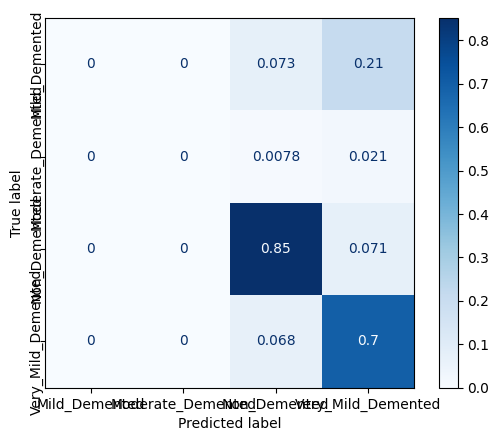

<Figure size 500x500 with 0 Axes>

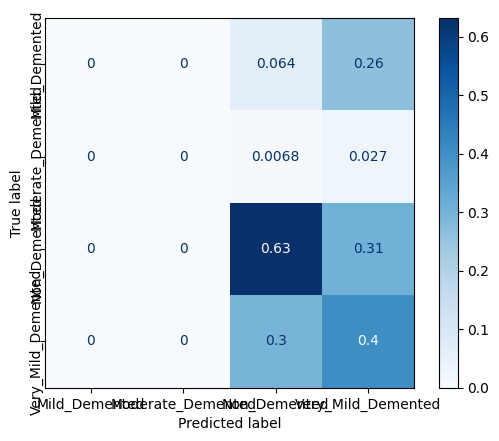

<Figure size 500x500 with 0 Axes>

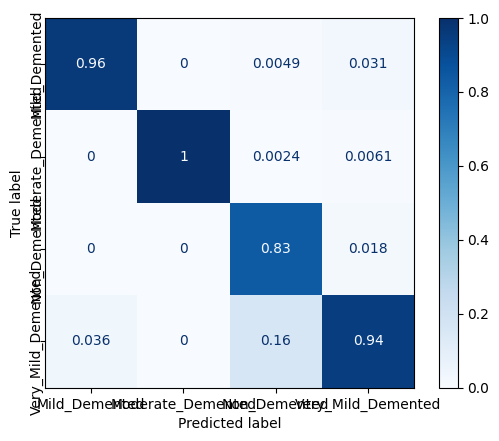

<Figure size 500x500 with 0 Axes>

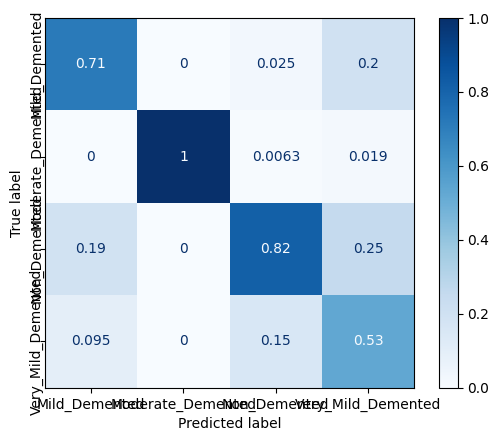

In [10]:
# experiments with Figshare
print('\nProcessing Alzihmers Dataset:')
print('--------------------------------')

train_ds, val_ds, test_ds, class_names = load(DATASET_DIR, IMAGE_SIZE, BATCH_SIZE, False)
experiments_with_dataset(train_ds, val_ds, test_ds, class_names)

In [ ]:
!zip -0 -r MobileNetV3Small.zip ./*